## Camera Selection

In [1]:
import scipy.io as spio
#from __future__ import print_function

import numpy as np
import os

from IPython.display import clear_output
from IPython import display

import matplotlib.pyplot as plt
#import cv2 as cv
%matplotlib inline

In [2]:
import string
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.distributions import Categorical
import time, math
 
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()

if use_cuda:
    print ('CUDA is available')
#use_cuda=False   #uncomment this if you dont want to use cuda variables

CUDA is available


In [3]:
import sys
import os
import gc
import collections
# import hickle as hkl
# import ttictoc as tt

sys.path.insert(0, '../data/')
import get_pid_train_test as db
import auxiliary as af

In [4]:
# sys.path.insert(0,'../py-MDNet/modules')
# from sample_generator import *
import pandas as pd

### For Validation

In [5]:
# Test function
def plot_current_state(ped, c,fno):
    # load image for current location
    img,bb = load_image(ped,c,fno,db_no)

    dpi = 80.0
    #figsize = (img.size[0]/dpi, img.size[1]/dpi)
    figsize = (img.shape[0]/dpi, img.shape[1]/dpi)
    fig = plt.figure(frameon=False, figsize=figsize, dpi=dpi)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)

    # get image and rect handle
    imAX = ax.imshow(img, aspect='normal')
    rect = plt.Rectangle(tuple(bb[0,:2]),bb[0,2],bb[0,3], 
        linewidth=3, edgecolor="#ff0000", zorder=1, fill=False)
    ax.add_patch(rect)

    plt.pause(.01)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'0000.jpg'),dpi=dpi)
    
    return imAX, rect
    
def plot_second(ped,c,curr_frame, imAX,rect):
    img,bb =  load_image(ped,c,curr_frame,db_no)
    #if np.array(img).shape[0] > 0:
    if img != []:
        imAX.set_data(img)
    #print (bb)

    #if bb.shape[0] > 0:
    if bb != []:
        rect.set_xy(bb[0,:2])
        rect.set_width(bb[0,2])
        rect.set_height(bb[0,3])
        print ('Correct camera')
    elif c!= num_camera-1:
        print ('Wrong camera')

    
    display.display(plt.gcf())
    plt.pause(1)
    plt.draw()
    #fig.savefig(os.path.join(savefig_dir,'%04d.jpg'%(i)),dpi=dpi)

def get_reward_gt(ped, curr_frame, c):
    y = afc.find_target_camera(ped,curr_frame)
    # get reward (give reward at end of episode)
    if y == num_camera-1 and y == c:
        reward = 0
    elif y == c:
        reward = 1
    else:
        reward = -1
        
    return reward,y

def get_next_step(ped,c,curr_frame, state):
    # update current state and history
    ispresent,this_state = get_state_vector(ped, c,curr_frame)
    if ispresent:
        next_state = this_state
    else:
        # use previous state
        next_state = state
    
    # get correct label from ground truth
    reward,y = get_reward_gt(ped, curr_frame,c)

    return next_state,reward,y,ispresent

def test_func(pTest, iloc='first', eloc='last', fixLoc=-1, isdebug=0, req_inc=1):
    policy_net.eval()
    rsT,accT = [],[]
    Qvalues = []
    numTrAllP = []
    
    for p in range(pTest.shape[0]): 
        reward_sum = 0
        accP = []
        inc = 1
        aaa = 1
        Qval_1p = []
        numTr = 0
        
        # load p'th person data
        ped = np.copy(pTest[p])
        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        
        # Initialize with current state with start frame
        if iloc == 'first':
            startIDX = 0
        elif iloc == 'rand':
            startIDX = np.random.randint( 0,ped.shape[0]-20 )
        elif iloc == 'fix':
            startIDX = fixLoc
        if startIDX > ped.shape[0]:
            continue
        myPos = ped[startIDX,0:]
        print ('Initial position: ',myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        occ_len = 0.01
        # Make initial state
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        #print (state.size())
        num_steps = 0
        prev_camera = curr_camera
        count_curr_c = 0
        
        if render: # show current location
            plot_current_state(ped, curr_camera,curr_frame)

            display.clear_output(wait=True)
            display.display(plt.gcf())

        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        
        
        while(curr_frame <= ped[-1,1]): # alltime-6):
            
            if use_cuda:
                state_in = Variable(state)
                value_c = policy_net(state_in)
            else:
                state_in = Variable(state)
                value_c = policy_net(state_in)
                
            # Only exploitation for testing
            camera_index = torch.argmax(value_c)
            c = camera_index.detach().cpu().numpy()
            
            occ_max_val = 12000000
            aaa += 1
            if aaa > 1 and occ_len > occ_max_val:
                c = c #np.array(num_camera-1)
            if occ_len > occ_max_val and aaa%50 == 0:
                aaa = 1
                c = np.array(np.random.randint(num_camera))

            # find target for the next frame
            curr_frame += fpsc
            num_steps += 1
            
            # get correct label from ground truth
            reward,y = get_reward_gt(ped, curr_frame,c)
            #if req_inc:
            if inc==1 and y!=num_camera-1:
                # inside a camera
                if req_inc:
                    accP.append((y,y))
                    c = y
                else:
                    accP.append((y,c.item(0)))
            elif inc==0 and y==c.item(0) and y!=num_camera-1:
                # transitioning to second camera
                accP.append((y,c.item(0)))
                inc = 1
                numTr += 1
            elif inc==1 and y==num_camera-1:
                # moving out of a camera FOV
                inc = 0
                accP.append((y,c.item(0)))
            else:
                # Making transition
                accP.append((y,c.item(0)))
                #print ('Another case',y,c.item(0))
                    
            #else:
            #    accP.append((y,c.item(0)))
            
            # get the current bounding box
            bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0: # and np.random.rand < 0.95:
                bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/320 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/240 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/320 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/240 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                curr_camera = c
                
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                
                ispresent = 1
                prev_rt = rt[0:4]
                    
            else:
                ispresent = 0
                
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += 1
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # update current state and history
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
                
            if isdebug:
                print ( np.where(rt.ravel()))
                print ( np.where(ch))
                print (c, curr_frame)
                print ('isPresent', ispresent)
                
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # store current reward
            reward_sum += reward
            Qval_1p.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,False,y,c,state.detach().cpu().numpy()))
                        
            #state = next_state
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, enc_history], dim=1)
            prev_camera = c
            
            if render:
                plot_second()
            if eloc != 'last':
                if num_steps > eloc:
                    break
            
        # stack episodic reward 
        Qvalues.append((np.stack(Qval_1p)))
        rsT.append((reward_sum,num_steps))
        accT.append(accP)
        numTrAllP.append(numTr)
        
    return rsT, accT, Qvalues, numTrAllP


### Initialize hyper-parameters

In [6]:
learning_rate = 1e-4
batch_size = 1500
replay_memory_size = 20000
#epsilon = 0.1
gamma = 0.99

resume = False # resume from previous checkpoint
render = False
eps = np.finfo(np.float32).eps.item()


In [7]:
# load dataset
db_no = 3
[pALL,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='train')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pALL = np.array(pALL)

# load test set for current data set
[pTest,num_camera,alltime,fps] = db.get_pid(set_no=db_no, train_flag='test')
num_camera += 1  # occlusion is also considered as a FOV
fpsc = 2
pTest = np.array(pTest)

Total number of person in data set:  (1, 14)
Total number of person in data set:  (1, 14)


In [8]:
camGTT = pd.read_csv(os.path.expanduser('~/8tb/hpc-storage/nlpr/annotation_files/annotation/Dataset' + str(db_no) + '/fullgt.csv'), header=None).values.astype(np.int)[:,:7]
tmp = np.copy(camGTT[:,1])
camGTT[:,1] = camGTT[:,2]
camGTT[:,2] = tmp
camGT = camGTT[:,[0,2,3,4,5,6]]

# In NLPR GT, frames already start with 0, only cam needs to be decremented
camGT[:,0]-=1
# camGT[:,1]-=1
# camGT = matlab.double(camGT)
print('Shape of full ground truth', camGT.shape)

Shape of full ground truth (18339, 6)


In [9]:
numEpoch = 100000
d = 10
region_size = (d,d)

h_len = 10

# Load auxiliary functions using an object
afc = af.AuxiliaryFunction(num_camera=num_camera, d=d, h_len=h_len)

## Policy Model

In [10]:
# Initialize required parameters
lstm_size = 256
hidden_size1 = 4096
hidden_size2 = 2048
hidden_size3 = 256

input_size = lstm_size + num_camera+ 4*2 +1

# Required network
class NextCamera(nn.Module):
    def __init__(self):
        super(NextCamera, self).__init__()
        
        # make decoder layers
        self.fch1 = nn.Linear(input_size, hidden_size1)
        self.fch2 = nn.Linear(hidden_size1, hidden_size2)
        self.fch3 = nn.Linear(hidden_size2, hidden_size3)
        self.fco = nn.Linear(hidden_size3, num_camera)
        
        # Activation function 
        self.tanh = nn.Tanh() #ReLU()
        self.relu = nn.ReLU() #ReLU()
        #self.linear = nn.Linear() 
        
    def forward(self, x):
        
        x = self.relu(self.fch1(x))
        x = self.relu(self.fch2(x))
        x = self.relu(self.fch3(x))
        x = self.fco(x)
            
        return x # nn.functional.softmax(x)

In [11]:
# build the model
if use_cuda:
    policy_net = NextCamera().float().cuda()
    criterion = nn.MSELoss().cuda()
    
else:
    policy_net = NextCamera().float()
    criterion = nn.MSELoss()
    
if use_cuda:
    target_net = NextCamera().cuda()
    target_net.float().cuda()
target_net.load_state_dict(policy_net.state_dict())

# use ADAM as optimizer since we can load the whole data to train
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)

In [12]:
def backward_network(replay_memory_pos,pos_prob, replay_memory_neg, replay_memory_cx, update_criteria):

    # sample random minibatch
    minibatch_pos = random.choices(replay_memory_pos, k=min(len(replay_memory_pos), 500), weights=pos_prob)
    #minibatch_pos = random.sample(replay_memory_pos, min(len(replay_memory_pos), 300)) #int(batch_size/3)))
    minibatch_posneg = minibatch_pos + random.sample(replay_memory_neg, min(len(replay_memory_neg), 500)) # int(batch_size/3)))
    minibatch = minibatch_posneg + random.sample(replay_memory_cx, min(len(replay_memory_cx), 500)) #int(batch_size/3)))
    
    # unpack minibatch
    #state_xt = tuple(d[0] for d in minibatch)
    state = torch.cat(tuple(d[0] for d in minibatch))
    #prev_ch = tuple(d[1] for d in minibatch)
    action = torch.cat(tuple(d[1] for d in minibatch))
    reward = torch.cat(tuple(d[2] for d in minibatch))
    #next_state_xt = tuple(d[4] for d in minibatch)
    next_state = torch.cat(tuple(d[3] for d in minibatch))
    #ch = tuple(d[5] for d in minibatch)
    
    # num samples of different categories
    numRew = torch.stack([torch.sum(reward>=0.2),torch.sum(reward==-1),torch.sum(reward==0.01)]).data.cpu().numpy()
    
    # get output for the next state
    next_output = target_net(next_state)

    # set y_j to r_j for terminal state, otherwise to r_j + gamma*max(Q)
    y = torch.cat(tuple(reward[i] if minibatch[i][4] \
                        else reward[i] + gamma * torch.max(next_output[i]) \
                        for i in range(len(minibatch))))

    # extract Q-value
    q_value = torch.sum(policy_net(state) * action, dim=1)

    # PyTorch accumulates gradients by default, so they need to be reset in each pass
    optimizer.zero_grad()

    # returns a new Tensor, detached from the current graph, the result will never require gradient
    y = y.detach()

    #print (y, q_value)
    # calculate loss
    loss = criterion(q_value, y)

    # do backward pass
    loss.backward()
    optimizer.step()

    # copy weights from policy_net to target_net
    if update_criteria == 10:
        target_net.load_state_dict(policy_net.state_dict())
        update_criteria = 0
    update_criteria += 1
    
    return loss.data,numRew,update_criteria

## AE Model

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src len, batch size]
        
        embedded = src #self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size, dim]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size, dim]
        
        embedded = input #self.dropout(self.embedding(input))
        #embedded[np.arange(embedded.size),a] = 1
        
        #embedded = [1, batch size, emb dim]
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.1):
        
        #src = [src len, batch size, dim]
        #trg = [trg len, batch size, dim]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output #.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

In [14]:
duke_cam = 9
INPUT_DIM = duke_cam
OUTPUT_DIM = duke_cam
ENC_EMB_DIM = duke_cam
DEC_EMB_DIM = duke_cam
HID_DIM = 256
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT).float().cuda()
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT).float().cuda()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Seq2Seq(enc, dec, device).float().to(device)
criterion_ae = nn.CrossEntropyLoss()

In [15]:
# load encoder model
#enc.load_state_dict(torch.load('enc-model_manyDB_state64.pt'))
#enc.load_state_dict(torch.load('enc-model_manyDB.pt'))
#enc.eval()
#dec.load_state_dict(torch.load('dec-model_manyDB_state64.pt'))
#dec.eval()
model.load_state_dict(torch.load('../eccv2020/tut1-model_duke_lstmSize128_manyDB_2.pt'))
model.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9, 9)
    (rnn): LSTM(9, 256, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (embedding): Embedding(9, 9)
    (rnn): LSTM(9, 256, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=256, out_features=9, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [16]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### Run episodes

In [17]:
reward_sum = 0
running_reward = None
xs,rs,cprs = [],[],[]
episode_number = 0
episode_durations = []
episode_reward = []
validation_reward= []
replay_memory_pos = []
pos_prob = []
replay_memory_neg = []
replay_memory_cx = []
M = np.zeros((num_camera,num_camera))

In [18]:
def make_state_vector(ped, curr_camera,curr_frame, ch,occ_len):
    numSamples = 30
    overlap_thres = [0.9, 1]
        
    # read image
    img,bbox,p = afc.load_image(ped,curr_camera,curr_frame,db_no)
    imw, imh = (320,240) #img.size
    hc = np.array(10*np.log(occ_len))
    
    if p:
        rt = np.zeros((8))
        rt[0] = bbox[0]/imw -(np.random.rand()-0.5)/100
        rt[1] = bbox[1]/imh -(np.random.rand()-0.5)/100
        rt[2] = bbox[2]/imw -(np.random.rand()-0.5)/100
        rt[3] = bbox[3]/imh -(np.random.rand()-0.5)/100
        rt[4] = 0
        rt[5] = 0
        rt[6] = 0
        rt[7] = 0
        #print (np.where(rt.ravel()))
        
        # make next_state vector
        #this_cam = afc.make_one_hot_camera(curr_camera)
        #state = np.concatenate((this_cam, rt.ravel()))
        #state = np.concatenate((state, hc.ravel()))
        #state = np.concatenate((state, ch.ravel()))
        #state = state.reshape(1,-1)
        #state[state==0] = -10
        #state[state==1] = 10
        
        # make next_state vector
        this_cam = afc.make_one_hot_camera(curr_camera)
        xt = np.concatenate((this_cam, rt.ravel()))
        xt[xt==0] = -10
        xt[xt==1] = 10
        xt = xt.reshape(1,-1)
        
        # make history vector
        c_t = this_cam.reshape(1,-1)
        
        if use_cuda:
            xt = torch.from_numpy(xt).float().cuda()
            c_t = torch.from_numpy(c_t).float().cuda()
            hc = torch.from_numpy(hc.reshape(1,-1)).float().cuda()
        else:
            xt = torch.from_numpy(xt).float()
            c_t = torch.from_numpy(c_t).float()
            hc = torch.from_numpy(hc.reshape(1,-1)).float()
    else:
        print ('Target is not present in ',c,curr_frame)
        xt,h_t = [],[]
    
    return xt,c_t,hc,rt #p,state,rt

def append_reward(rs,num_steps):
    if len(rs) > 0:
        # stack episodic reward 
        epR = np.vstack(rs)
        rs = []

        # append the episodic reward
        #episode_number += 1
        #episode_durations.append(num_steps)
        reward_stat = [num_steps,np.std(epR),np.sum(epR)]
        episode_reward.append(reward_stat)
    
    return rs

def reinit_ae(ch):
    # Initialize history variable (one-hot encoding)
    if use_cuda:
        ch = torch.from_numpy(ch).float().cuda()
        enc_h = torch.zeros(1,lstm_size).float().cuda()
        enc_c = torch.zeros(1,lstm_size).float().cuda()
    else:
        enc_h = torch.zeros(1,lstm_size).float()
        enc_c = torch.zeros(1,lstm_size).float()
        
    # encode whole camera history
    for i in range(seq_len-1,-1,-1):
        #print (ch[i,:])
        x = ch[i,:].view(1,-1)
        h_lstm,enc = ae_enc((enc_h,enc_c), x)
        (enc_h,enc_c) = h_lstm

    return h_lstm,enc

In [19]:
epoch = 0
occ_max_val = 100

In [20]:
EpData = []
allEpData = []
numRew=[]

numUpdateRew=[]
update_criteria = 0
episode_count = 0
steps_count = 0
initialEpsilon = 0.4
finalEpsilon = 0.01
epsilon = initialEpsilon

In [21]:
trExplored = {}
for i in range(num_camera):
    for j in range(num_camera):
        trExplored[str(i)+'-'+str(j)] = []

In [22]:
resume = False
if resume:
    epoch = 600
    epsilon = 0.170962
    aaa = np.load('./EpData/.npy', allow_pickle=True)
    episode_count = aaa[2]
    steps_count = aaa[3]
    episode_reward_pre = aaa[0]
    validation_reward_pre = aaa[1]
    policy_net.load_state_dict(torch.load('./models/')['state_dict'])

In [23]:
# tt.tic()

In [24]:
def bb_intersection_over_union(boxA, boxB):
    # convert to x1,y1,x2,y2
    boxA[2] = boxA[2] + boxA[0]
    boxA[3] = boxA[3] + boxA[1]
    boxB[2] = boxB[2] + boxB[0]
    boxB[3] = boxB[3] + boxB[1]
    
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def find_nearest_box(c,frame_no, prev_box):
    # find all bounding boxes
    all_dets = np.copy(camGT[np.logical_and(camGT[:,0]==c, camGT[:,1]==frame_no), 2:])
    
    #print (all_dets, prev_box)
    
    # find the nearest box
    maxIOU = -1
    box = np.array([])
    for i in range(len(all_dets)):
        this_box = np.copy(all_dets[i])
        iou = bb_intersection_over_union(this_box, prev_box)
        #print (iou, this_box)
        if iou > maxIOU and iou > 0.4:
            maxIOU = iou
            box = np.copy(all_dets[i])
            
    return box

In [25]:
# def discount_rewards(r):
#     """ take 1D float array of rewards and compute discounted reward """
#     discounted_r = np.zeros_like(r)
#     running_add = 0
#     for t in reversed(range(0, r.size)):
#         if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
#         running_add = running_add * gamma + r[t]
#         discounted_r[t] = running_add
#     return discounted_r

# def discount_rewards(r):
#     """ take 1D float array of rewards and compute discounted reward """
#     discounted_r = [] #np.zeros_like(r)
#     running_add = 0
#     for t in reversed(range(0, len(r))):
#         if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
#         running_add = running_add * gamma + r[t]
#         #discounted_r[t] = running_add
#         discounted_r.append(running_add)
#     return discounted_r

def discount_rewards(r,c):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = [] #np.zeros_like(r)
    running_add = 0
    pivot = c[-1]
    for t in reversed(range(0, len(r))):
        if r[t] != 0: 
            running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
            pivot = c[t]
        if c[t] == pivot:
            running_add = running_add * gamma + r[t]
            #discounted_r[t] = running_add
            discounted_r.append(running_add)
        else:
            running_add = running_add * gamma + 0
            discounted_r.append(0)
            
        
    return discounted_r

In [26]:
maxRewSteps = 5
max_ep_len = 500
seq_len = 20
h_len = seq_len

while epoch < numEpoch:
#for epoch in range(numEpoch):
    # repeat for all pedestrians
    #disp(pALL)
    
    for p in range(pALL.shape[0]): #range(pInLoop.shape[0])
        
        policy_net.train()
        
        # load p'th person data
        ped = np.copy(pALL[p])

        # camera index and frame index starts from zero
        ped[:,0] -= 1
        ped[:,1] -= 1
        #print (np.unique(ped[:,0]))
        
        # check if camera number is correct
        if (ped[:,0] >= num_camera).any():
            print ('Error in person ', p)
            break
            
        if ped.shape[0] < max_ep_len/4:
            continue
        
        # select a camera uniformly
        uniq_cam = np.unique(ped[:,0])
        if len(uniq_cam) < 2 and np.random.rand() > 0.4:
            if len(np.where(ped[1:,1]-ped[0:-1,1] != 1)[0]) == 0:
                continue
        rand_cam = uniq_cam[np.random.randint(len(uniq_cam))]
        index_of_rand_cam = np.nonzero( ped[:,0]==rand_cam )[0]
        len_indices_rand_cam = len(index_of_rand_cam)
        
        # Initialize with current state with start frame
        tranIDX = np.where(ped[1:,0]-ped[0:-1,0])[0]
        if len(uniq_cam) < 2 or np.random.rand() < 0.4:
            startIDX = np.random.randint( 0,int(ped.shape[0]-ped.shape[0]/2) )
        else:
            startIDX = np.random.choice(tranIDX)-20
        #startIDX = np.random.choice(tranIDX)-20 if np.random.rand(1) < 0.6 else np.random.randint( 0,ped.shape[0]-max_ep_len/2 )
        #startIDX = index_of_rand_cam[np.random.randint(len_indices_rand_cam/10)]
        myPos = ped[startIDX,0:]
        #print (myPos)
        
        curr_camera = myPos[0]
        curr_frame = myPos[1]
        
        # Initialize history variable (one-hot encoding)
        ch = np.zeros((h_len,duke_cam))
        prev_ch = ch
        
        # initialize total time target was occluded
        num_steps = 0
        occ_len = 0.01
        hcount = np.array(10*np.log(occ_len))
        CDataEp = []
        inCDataEp = []
        EpData = []
        episodic_seq = []
        rewSteps = 1
        
        tmp_replay = []
        tmp_reward = []
        tmp_c_seq = []
        pivot_cam = curr_camera
        prev_box = ped[ np.logical_and(ped[:,0]==curr_camera,ped[:,1]==curr_frame),2:][0]
        
        # create initial state (ct,rt,tau_t)
        #bbox = myPos[2:]
        #rt = afc.find_curr_rt(bbox)
        x_t,c_t,te_tau,r_t = make_state_vector(ped, curr_camera,curr_frame,ch,occ_len)
        prev_rt = r_t[0:4]
        stCam = curr_camera
        expStC = curr_camera
        count_curr_c = 0
        prev_camera = curr_camera

        if render: # show current location
            plt.imshow(x.reshape(input_size))
            display.clear_output(wait=True)
            display.display(plt.gcf())
        episode_count += 1
        if epsilon > finalEpsilon:
            epsilon -= (initialEpsilon - finalEpsilon)/20000
        
        # select an action from the current state
        hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
        #print (x_t.size(),h_t.size(),enc_history.size())
        state_xt = torch.cat([x_t, te_tau], dim=1)
        #state = torch.cat([state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
        state = torch.cat([state_xt, hidden[1,].detach()], dim=1)
        #print ('State size: ', state.size())
        
        while(curr_frame <= ped[-1,1]):
        
            state_in = Variable(state)
            value_c = policy_net(state_in)

            steps_count += 1
            
            # generate random steps
            if np.random.rand(1) < 0.01:
                rsteps = np.random.randint(fpsc,20,1)
            else:
                rsteps = 1
            curr_frame += rsteps*fpsc if rsteps > 1 else fpsc
            num_steps += 1
                
            # initialize action
            one_hot_action = torch.zeros([num_camera], dtype=torch.float32)
            if use_cuda:  # put on GPU if CUDA is available
                one_hot_action = one_hot_action.cuda()

            # epsilon greedy exploration
            random_action = np.random.random() <= epsilon
            camera_index = [torch.randint(num_camera, torch.Size([]), dtype=torch.int)
                           if random_action else torch.argmax(value_c)][0]
            
            if use_cuda:  # put on GPU if CUDA is available
                camera_index = camera_index.cuda()

            one_hot_action[camera_index] = 1
            one_hot_action = one_hot_action.unsqueeze(0)
            c = camera_index.detach().cpu().numpy().item()
            
            # Store the transition explored
            #M[stCam,c] += 1
            
            # get correct label from ground truth
            y = afc.find_target_camera(ped, curr_frame)
            # get reward (give reward at end of episode)
            
            #print (c, 'GT box: ', ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:])
            # give reward if rewardSteps reached maxRewardSteps
            if rewSteps >= maxRewSteps:
                
                #if np.random.rand() < 0.5:
                #    c = y
                
                if y == num_camera-1 and y == c:
                    reward = 0.01
                    wt = 1
                elif y == c and occ_len< 20:
                    reward = 0.5
                    wt = 1
                elif y == c:
                    reward = 1
                    wt = 10
                else:
                    wt = 1
                    reward = -1
                reward_sum += reward
                rs.append(reward)
                
                rewSteps = 1
                
                pivot_cam = c
                # take bounding box from GT
                # get the current bounding box
                bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
                if len(bbox): bbox = bbox[0]
            else:
                rewSteps += 1
                reward = 0
                
                # take nearest bounding box
                if c != num_camera-1 and c == pivot_cam and occ_len < 20:
                    bbox = np.array(find_nearest_box(c,curr_frame, prev_box))
                else:
                    bbox = np.array([])
                
            #print ('bbox taken: ', bbox)
            # get the current bounding box
            #bbox = ped[ np.logical_and(ped[:,0]==c,ped[:,1]==curr_frame),2:]
            if bbox.shape[0] > 0:
                #rt = afc.find_curr_rt(bbox[0]) 
                #bbox = bbox[0]
                rt = np.zeros((8))
                rt[0] = bbox[0]/320 -(np.random.rand()-0.5)/100
                rt[1] = bbox[1]/240 -(np.random.rand()-0.5)/100
                rt[2] = bbox[2]/320 -(np.random.rand()-0.5)/100
                rt[3] = bbox[3]/240 -(np.random.rand()-0.5)/100
                rt[4] = rt[0] - prev_rt[0] if occ_len < 0.2 else 0
                rt[5] = rt[1] - prev_rt[1] if occ_len < 0.2 else 0
                rt[6] = rt[2] - prev_rt[2] if occ_len < 0.2 else 0
                rt[7] = rt[3] - prev_rt[3] if occ_len < 0.2 else 0
                
                curr_camera = c
                # make next_state vector
                this_cam = afc.make_one_hot_camera(curr_camera)
                x_t = np.concatenate((this_cam, rt.ravel()))
                x_t[x_t==0] = -10
                x_t[x_t==1] = 10
                x_t = x_t.reshape(1,-1)
                if use_cuda:
                    x_t = torch.from_numpy(x_t).float().cuda()
                
                #num_steps = 0
                ispresent = 1
                stCam = c
                
                prev_rt = rt[0:4]
                prev_box = bbox
            else:
                ispresent = 0
            
            #if ispresent and expStC != num_camera-1 and c != num_camera-1:
            #    trExplored[str(expStC)+'-'+str(c)].append(occ_len)
            #    expStC = c
            
            
            #-----------    reward was here
            #EpData.append((list(value_c.detach().cpu().numpy()[0]),hcount.ravel()[0],reward,random_action,y,c,episode_reward))
            
            #print (np.array([rt, ispresent,c]))
            ######################## prepare the next state  #############################
            # count the time of prev_camera selection
            if ispresent:
                occ_len = 0.01
            else:
                occ_len += rsteps
            #hcount = np.array(-occ_max_val + (occ_len/500)*(occ_max_val-(-occ_max_val)))
            hcount = np.array(10*np.log(occ_len))
            
            # get next camera using policy network
            this_cam = afc.make_one_hot_camera(c)
            c_t = this_cam.reshape(1,-1)
            
            # update current state and history
            prev_ch = ch
            ch[1:,] = ch[0:-1,]
            ch[0,0:num_camera] = afc.make_one_hot_camera(c)
            ch[0,num_camera:] = 0
            
            #chCuda = torch.from_numpy(ch).float().cuda().unsqueeze(1)
            #outSeq = model(chCuda, chCuda)
            #print ('Encoding .. ', chCuda[:,0,].argmax(1))
            #print ('Decoded ..', outSeq[:,0].argmax(1))
            #print ('')
            
            if use_cuda:
                c_t = torch.from_numpy(c_t).float().cuda()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float().cuda()
            else:
                c_t = torch.from_numpy(c_t).float()
                te_tau = torch.from_numpy(hcount.reshape(1,-1)).float()
            episodic_seq.append((c_t))
            
            # make next_state vector
            hidden, cell = enc(torch.from_numpy(ch).float().cuda().unsqueeze(1))
            #print (x_t.size(),h_t.size(),enc_history.size())
            next_state_xt = torch.cat([x_t, te_tau], dim=1)
            #next_state = torch.cat([next_state_xt, hidden.detach().flatten().view(1,-1)], dim=1)
            next_state = torch.cat([next_state_xt, hidden[1,].detach()], dim=1)
            
            # save transition to replay memory
            tmp_replay.append((state, one_hot_action, next_state, ispresent))
            tmp_reward.append(reward)
            tmp_c_seq.append(c)
            
            #state_xt = next_state_xt
            state = next_state #torch.cat([state_xt, hidden.detach()], dim=1)
            #state = torch.cat([next_state_xt, enc_history], dim=1)
            prev_camera = c
            
            if num_steps >= max_ep_len and y!=num_camera-1 and y==c and reward != 0:  # break the episode
                #print ('')
                #print (epoch, p, random_action, rsteps)
                #print ('x_t: ', c,rt)
                ##print ( np.where(ch)[1])
                #print ('Q values: ', value_c)
                #print (y,c, curr_frame,ped[-1,1], num_steps, hcount)
                #print ('isPresent', ispresent)
                #print ('Pos Replay length: ', len(replay_memory_pos))
                
                
                #print (pos_prob[:])
                break
        
        #########################################################
        # compute reward backward
        #epr = np.vstack(tmp_reward)
        discounted_epr = discount_rewards(tmp_reward, tmp_c_seq)[-1::-1]
        #print (tmp_reward, discounted_epr)

        # save transition to replay memory
        for rLen in range(len(tmp_replay)):
            #state, one_hot_action, next_state, ispresent = tmp_replay[rLen]
            state = tmp_replay[rLen][0]
            one_hot_action = tmp_replay[rLen][1]
            next_state = tmp_replay[rLen][2]
            ispresent = tmp_replay[rLen][3]

            if use_cuda:
                reward = torch.from_numpy(np.array([discounted_epr[rLen]], dtype=np.float32)).unsqueeze(0).cuda()
            else:
                reward = torch.from_numpy(np.array([discounted_epr[rLen]], dtype=np.float32)).unsqueeze(0)

            if reward > 0.1:
                replay_memory_pos.append((state, one_hot_action, reward, next_state, ispresent))
                if reward > 0.5:
                    wt = 10
                else:
                    wt = 1
                pos_prob.append(wt)
            elif reward <= 0.01 and reward > 0:
                replay_memory_cx.append((state, one_hot_action, reward, next_state, ispresent))
            elif reward != 0:
                replay_memory_neg.append((state, one_hot_action, reward, next_state, ispresent))

            # if replay memory is full, remove the oldest transition
            if len(replay_memory_pos) > replay_memory_size:
                replay_memory_pos.pop(0)
                pos_prob.pop(0)
            if len(replay_memory_neg) > replay_memory_size:
                replay_memory_neg.pop(0)
            if len(replay_memory_cx) > replay_memory_size:
                replay_memory_cx.pop(0)
        #########################################################

        # update value_function
        loss,rrr,update_criteria = backward_network(replay_memory_pos, pos_prob[:], replay_memory_neg,replay_memory_cx, update_criteria)
        #numUpdateRew.append(rrr)
        #if np.random.rand() < 0.05:
        #    allEpData.append((np.stack(EpData)))
        
        # store episodic reward
        #numRew.append((sum(np.stack(rs)==100),sum(np.stack(rs)==-100),sum(np.stack(rs)==0.1)))
        rs = append_reward(rs,num_steps)
        
        # boring book-keeping
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        print ('ep %d: ep_len:%d episode reward: total was %f. running mean: %f' % (epoch, num_steps, reward_sum, running_reward))
        reward_sum = 0
        num_steps = 0
        rs = []
    
#     if epoch % 20 == 0: # test on validation set
#         _,accV,qv,numTR = test_func(pTest[1:2],iloc='first',eloc='last')
#         av = np.stack(accV[0])
#         av = sum(av[av[:,0]!=(num_camera-1),0] == av[av[:,0]!=(num_camera-1),1])/sum(av[:,0]!=(num_camera-1))
#         validation_reward.append((qv,av,numTR)) 
    #print (M)
    epoch += 1
    print ('epsilon:%f episode_count: %d. steps_count: %f' % (epsilon, episode_count,steps_count))
    if epoch % 20 == 1 and epoch > 300: 
        torch.save({'state_dict': policy_net.state_dict()}, './models/policy_db3_semisup_gtBOX_5_'+str(epoch))
    #if epoch %200 == 100:
        #np.save('./EpData/allEpData_ECCV_db3_pretrAE64_seq20_rp20K_'+str(epoch),np.array(allEpData),allow_pickle=True)
        #np.save('./EpData/episode_reward_ECCV_db3_pretrAE64_seq20_rp20K_'+str(epoch), (episode_reward,validation_reward,epsilon,episode_count, steps_count,running_reward))
    #allEpData = []
    #print ('Time elapsed: ', tt.toc())

ep 0: ep_len:665 episode reward: total was -110.930000. running mean: -110.930000
ep 0: ep_len:510 episode reward: total was -80.450000. running mean: -110.625200
ep 0: ep_len:550 episode reward: total was -100.930000. running mean: -110.528248
ep 0: ep_len:580 episode reward: total was -50.480000. running mean: -109.927766
ep 0: ep_len:2 episode reward: total was 0.000000. running mean: -108.828488
ep 0: ep_len:233 episode reward: total was -26.880000. running mean: -108.009003
ep 0: ep_len:1100 episode reward: total was -106.940000. running mean: -107.998313
epsilon:0.399863 episode_count: 7. steps_count: 3640.000000
ep 1: ep_len:610 episode reward: total was -59.020000. running mean: -107.508530
ep 1: ep_len:830 episode reward: total was -100.440000. running mean: -107.437845
ep 1: ep_len:1215 episode reward: total was -149.320000. running mean: -107.856666
ep 1: ep_len:670 episode reward: total was -98.810000. running mean: -107.766199
ep 1: ep_len:3 episode reward: total was 0.000

ep 13: ep_len:540 episode reward: total was -66.830000. running mean: -83.916059
ep 13: ep_len:520 episode reward: total was -66.840000. running mean: -83.745299
ep 13: ep_len:580 episode reward: total was -64.200000. running mean: -83.549846
ep 13: ep_len:3 episode reward: total was 0.000000. running mean: -82.714347
ep 13: ep_len:525 episode reward: total was -50.510000. running mean: -82.392304
ep 13: ep_len:650 episode reward: total was -66.630000. running mean: -82.234681
epsilon:0.398089 episode_count: 98. steps_count: 50306.000000
ep 14: ep_len:595 episode reward: total was -55.820000. running mean: -81.970534
ep 14: ep_len:690 episode reward: total was -106.320000. running mean: -82.214029
ep 14: ep_len:430 episode reward: total was -40.870000. running mean: -81.800588
ep 14: ep_len:530 episode reward: total was -50.860000. running mean: -81.491182
ep 14: ep_len:3 episode reward: total was 0.000000. running mean: -80.676271
ep 14: ep_len:169 episode reward: total was -5.470000.

ep 26: ep_len:715 episode reward: total was -62.420000. running mean: -65.891809
ep 26: ep_len:500 episode reward: total was -49.700000. running mean: -65.729891
ep 26: ep_len:3 episode reward: total was 0.000000. running mean: -65.072592
ep 26: ep_len:175 episode reward: total was -3.400000. running mean: -64.455866
ep 26: ep_len:545 episode reward: total was -35.150000. running mean: -64.162808
epsilon:0.396314 episode_count: 189. steps_count: 93930.000000
ep 27: ep_len:224 episode reward: total was -10.890000. running mean: -63.630080
ep 27: ep_len:690 episode reward: total was -82.240000. running mean: -63.816179
ep 27: ep_len:525 episode reward: total was -60.220000. running mean: -63.780217
ep 27: ep_len:520 episode reward: total was -60.850000. running mean: -63.750915
ep 27: ep_len:3 episode reward: total was 0.000000. running mean: -63.113406
ep 27: ep_len:500 episode reward: total was -59.890000. running mean: -63.081172
ep 27: ep_len:510 episode reward: total was -48.810000.

ep 39: ep_len:510 episode reward: total was -48.760000. running mean: -53.860007
ep 39: ep_len:92 episode reward: total was -13.470000. running mean: -53.456107
ep 39: ep_len:560 episode reward: total was -61.680000. running mean: -53.538346
ep 39: ep_len:630 episode reward: total was -50.890000. running mean: -53.511862
epsilon:0.394540 episode_count: 280. steps_count: 133691.000000
ep 40: ep_len:525 episode reward: total was -60.770000. running mean: -53.584444
ep 40: ep_len:383 episode reward: total was -51.390000. running mean: -53.562499
ep 40: ep_len:715 episode reward: total was -81.130000. running mean: -53.838174
ep 40: ep_len:585 episode reward: total was -39.090000. running mean: -53.690692
ep 40: ep_len:3 episode reward: total was 0.000000. running mean: -53.153785
ep 40: ep_len:695 episode reward: total was -71.100000. running mean: -53.333248
ep 40: ep_len:307 episode reward: total was -28.410000. running mean: -53.084015
epsilon:0.394403 episode_count: 287. steps_count: 

ep 52: ep_len:133 episode reward: total was -15.960000. running mean: -50.954212
ep 52: ep_len:555 episode reward: total was -67.800000. running mean: -51.122670
ep 52: ep_len:590 episode reward: total was -58.840000. running mean: -51.199843
epsilon:0.392765 episode_count: 371. steps_count: 178324.000000
ep 53: ep_len:500 episode reward: total was -37.890000. running mean: -51.066745
ep 53: ep_len:500 episode reward: total was -55.850000. running mean: -51.114578
ep 53: ep_len:630 episode reward: total was -63.300000. running mean: -51.236432
ep 53: ep_len:520 episode reward: total was -43.260000. running mean: -51.156668
ep 53: ep_len:3 episode reward: total was 0.000000. running mean: -50.645101
ep 53: ep_len:735 episode reward: total was -77.590000. running mean: -50.914550
ep 53: ep_len:530 episode reward: total was -51.710000. running mean: -50.922504
epsilon:0.392629 episode_count: 378. steps_count: 181742.000000
ep 54: ep_len:590 episode reward: total was -55.200000. running me

ep 65: ep_len:715 episode reward: total was -69.160000. running mean: -47.660264
ep 65: ep_len:565 episode reward: total was -39.010000. running mean: -47.573761
epsilon:0.390991 episode_count: 462. steps_count: 218838.000000
ep 66: ep_len:605 episode reward: total was -45.720000. running mean: -47.555224
ep 66: ep_len:274 episode reward: total was -20.390000. running mean: -47.283572
ep 66: ep_len:640 episode reward: total was -56.200000. running mean: -47.372736
ep 66: ep_len:500 episode reward: total was -40.640000. running mean: -47.305408
ep 66: ep_len:50 episode reward: total was -5.500000. running mean: -46.887354
ep 66: ep_len:565 episode reward: total was -65.260000. running mean: -47.071081
ep 66: ep_len:550 episode reward: total was -59.180000. running mean: -47.192170
epsilon:0.390854 episode_count: 469. steps_count: 222022.000000
ep 67: ep_len:223 episode reward: total was -10.400000. running mean: -46.824248
ep 67: ep_len:530 episode reward: total was -64.830000. running 

ep 78: ep_len:990 episode reward: total was -119.940000. running mean: -44.466289
epsilon:0.389216 episode_count: 553. steps_count: 258211.000000
ep 79: ep_len:585 episode reward: total was -36.190000. running mean: -44.383526
ep 79: ep_len:535 episode reward: total was -53.360000. running mean: -44.473290
ep 79: ep_len:540 episode reward: total was -59.640000. running mean: -44.624957
ep 79: ep_len:540 episode reward: total was -56.800000. running mean: -44.746708
ep 79: ep_len:3 episode reward: total was 0.000000. running mean: -44.299241
ep 79: ep_len:565 episode reward: total was -43.160000. running mean: -44.287848
ep 79: ep_len:692 episode reward: total was -82.110000. running mean: -44.666070
epsilon:0.389080 episode_count: 560. steps_count: 261671.000000
ep 80: ep_len:500 episode reward: total was -44.260000. running mean: -44.662009
ep 80: ep_len:555 episode reward: total was -38.250000. running mean: -44.597889
ep 80: ep_len:78 episode reward: total was -8.990000. running mea

ep 92: ep_len:525 episode reward: total was -36.910000. running mean: -44.095723
ep 92: ep_len:500 episode reward: total was -41.850000. running mean: -44.073265
ep 92: ep_len:560 episode reward: total was -59.210000. running mean: -44.224633
ep 92: ep_len:381 episode reward: total was -32.750000. running mean: -44.109886
ep 92: ep_len:3 episode reward: total was 0.000000. running mean: -43.668788
ep 92: ep_len:575 episode reward: total was -77.880000. running mean: -44.010900
ep 92: ep_len:307 episode reward: total was -29.860000. running mean: -43.869391
epsilon:0.387305 episode_count: 651. steps_count: 301807.000000
ep 93: ep_len:615 episode reward: total was -61.830000. running mean: -44.048997
ep 93: ep_len:560 episode reward: total was -56.720000. running mean: -44.175707
ep 93: ep_len:510 episode reward: total was -48.790000. running mean: -44.221850
ep 93: ep_len:398 episode reward: total was -19.260000. running mean: -43.972231
ep 93: ep_len:3 episode reward: total was 0.00000

ep 105: ep_len:635 episode reward: total was -65.100000. running mean: -42.668631
ep 105: ep_len:615 episode reward: total was -59.650000. running mean: -42.838445
ep 105: ep_len:515 episode reward: total was -27.770000. running mean: -42.687761
ep 105: ep_len:530 episode reward: total was -23.240000. running mean: -42.493283
ep 105: ep_len:3 episode reward: total was 0.000000. running mean: -42.068350
ep 105: ep_len:530 episode reward: total was -50.860000. running mean: -42.156267
ep 105: ep_len:565 episode reward: total was -48.700000. running mean: -42.221704
epsilon:0.385531 episode_count: 742. steps_count: 342249.000000
ep 106: ep_len:585 episode reward: total was -54.220000. running mean: -42.341687
ep 106: ep_len:590 episode reward: total was -52.700000. running mean: -42.445270
ep 106: ep_len:570 episode reward: total was -46.180000. running mean: -42.482617
ep 106: ep_len:590 episode reward: total was -45.210000. running mean: -42.509891
ep 106: ep_len:89 episode reward: tota

ep 118: ep_len:254 episode reward: total was -14.900000. running mean: -41.011903
ep 118: ep_len:505 episode reward: total was -50.740000. running mean: -41.109184
ep 118: ep_len:580 episode reward: total was -58.250000. running mean: -41.280592
ep 118: ep_len:500 episode reward: total was -30.150000. running mean: -41.169286
ep 118: ep_len:98 episode reward: total was -6.960000. running mean: -40.827193
ep 118: ep_len:585 episode reward: total was -41.210000. running mean: -40.831021
ep 118: ep_len:297 episode reward: total was -29.430000. running mean: -40.717011
epsilon:0.383756 episode_count: 833. steps_count: 382661.000000
ep 119: ep_len:565 episode reward: total was -50.240000. running mean: -40.812241
ep 119: ep_len:515 episode reward: total was -15.890000. running mean: -40.563019
ep 119: ep_len:555 episode reward: total was -34.760000. running mean: -40.504988
ep 119: ep_len:615 episode reward: total was -64.150000. running mean: -40.741439
ep 119: ep_len:115 episode reward: t

ep 131: ep_len:545 episode reward: total was -26.100000. running mean: -41.253848
ep 131: ep_len:500 episode reward: total was -42.110000. running mean: -41.262410
ep 131: ep_len:452 episode reward: total was -36.850000. running mean: -41.218286
ep 131: ep_len:525 episode reward: total was -36.080000. running mean: -41.166903
ep 131: ep_len:116 episode reward: total was -17.970000. running mean: -40.934934
ep 131: ep_len:610 episode reward: total was -47.010000. running mean: -40.995684
ep 131: ep_len:560 episode reward: total was -45.240000. running mean: -41.038128
epsilon:0.381982 episode_count: 924. steps_count: 426348.000000
ep 132: ep_len:500 episode reward: total was -59.320000. running mean: -41.220946
ep 132: ep_len:545 episode reward: total was -54.330000. running mean: -41.352037
ep 132: ep_len:440 episode reward: total was -47.390000. running mean: -41.412417
ep 132: ep_len:545 episode reward: total was -47.210000. running mean: -41.470392
ep 132: ep_len:3 episode reward: t

ep 144: ep_len:525 episode reward: total was -57.130000. running mean: -40.201225
ep 144: ep_len:505 episode reward: total was -44.190000. running mean: -40.241113
ep 144: ep_len:510 episode reward: total was -49.130000. running mean: -40.330002
ep 144: ep_len:545 episode reward: total was -34.720000. running mean: -40.273902
ep 144: ep_len:3 episode reward: total was 0.000000. running mean: -39.871163
ep 144: ep_len:505 episode reward: total was -27.850000. running mean: -39.750951
ep 144: ep_len:725 episode reward: total was -76.540000. running mean: -40.118841
epsilon:0.380207 episode_count: 1015. steps_count: 467665.000000
ep 145: ep_len:520 episode reward: total was -49.290000. running mean: -40.210553
ep 145: ep_len:655 episode reward: total was -62.020000. running mean: -40.428647
ep 145: ep_len:525 episode reward: total was -37.790000. running mean: -40.402261
ep 145: ep_len:515 episode reward: total was -22.740000. running mean: -40.225638
ep 145: ep_len:3 episode reward: tota

ep 157: ep_len:600 episode reward: total was -53.180000. running mean: -39.219800
ep 157: ep_len:500 episode reward: total was -30.740000. running mean: -39.135002
ep 157: ep_len:620 episode reward: total was -37.110000. running mean: -39.114752
ep 157: ep_len:500 episode reward: total was -32.710000. running mean: -39.050705
ep 157: ep_len:3 episode reward: total was 0.000000. running mean: -38.660198
ep 157: ep_len:525 episode reward: total was -61.710000. running mean: -38.890696
ep 157: ep_len:605 episode reward: total was -61.760000. running mean: -39.119389
epsilon:0.378433 episode_count: 1106. steps_count: 507768.000000
ep 158: ep_len:625 episode reward: total was -61.570000. running mean: -39.343895
ep 158: ep_len:500 episode reward: total was -35.390000. running mean: -39.304356
ep 158: ep_len:580 episode reward: total was -42.050000. running mean: -39.331812
ep 158: ep_len:520 episode reward: total was -21.640000. running mean: -39.154894
ep 158: ep_len:3 episode reward: tota

ep 170: ep_len:260 episode reward: total was -24.960000. running mean: -38.852442
ep 170: ep_len:535 episode reward: total was -33.890000. running mean: -38.802818
ep 170: ep_len:560 episode reward: total was -54.130000. running mean: -38.956090
ep 170: ep_len:535 episode reward: total was -58.200000. running mean: -39.148529
ep 170: ep_len:3 episode reward: total was 0.000000. running mean: -38.757044
ep 170: ep_len:585 episode reward: total was -32.730000. running mean: -38.696773
ep 170: ep_len:565 episode reward: total was -48.050000. running mean: -38.790305
epsilon:0.376658 episode_count: 1197. steps_count: 548533.000000
ep 171: ep_len:655 episode reward: total was -57.040000. running mean: -38.972802
ep 171: ep_len:515 episode reward: total was -48.700000. running mean: -39.070074
ep 171: ep_len:560 episode reward: total was -49.100000. running mean: -39.170374
ep 171: ep_len:119 episode reward: total was -6.940000. running mean: -38.848070
ep 171: ep_len:3 episode reward: total

ep 183: ep_len:520 episode reward: total was -61.150000. running mean: -38.890210
ep 183: ep_len:560 episode reward: total was -58.230000. running mean: -39.083608
ep 183: ep_len:600 episode reward: total was -60.750000. running mean: -39.300272
ep 183: ep_len:620 episode reward: total was -53.760000. running mean: -39.444869
ep 183: ep_len:3 episode reward: total was 0.000000. running mean: -39.050420
ep 183: ep_len:530 episode reward: total was -35.790000. running mean: -39.017816
ep 183: ep_len:500 episode reward: total was -44.730000. running mean: -39.074938
epsilon:0.374884 episode_count: 1288. steps_count: 588457.000000
ep 184: ep_len:535 episode reward: total was -45.600000. running mean: -39.140188
ep 184: ep_len:595 episode reward: total was -42.640000. running mean: -39.175187
ep 184: ep_len:580 episode reward: total was -56.550000. running mean: -39.348935
ep 184: ep_len:730 episode reward: total was -108.840000. running mean: -40.043845
ep 184: ep_len:40 episode reward: to

ep 196: ep_len:695 episode reward: total was -73.040000. running mean: -40.384711
ep 196: ep_len:595 episode reward: total was -43.200000. running mean: -40.412864
ep 196: ep_len:530 episode reward: total was -47.880000. running mean: -40.487536
ep 196: ep_len:560 episode reward: total was -41.210000. running mean: -40.494760
ep 196: ep_len:3 episode reward: total was 0.000000. running mean: -40.089813
ep 196: ep_len:615 episode reward: total was -51.250000. running mean: -40.201415
ep 196: ep_len:645 episode reward: total was -48.030000. running mean: -40.279700
epsilon:0.373109 episode_count: 1379. steps_count: 629804.000000
ep 197: ep_len:1010 episode reward: total was -135.710000. running mean: -41.234003
ep 197: ep_len:640 episode reward: total was -43.280000. running mean: -41.254463
ep 197: ep_len:655 episode reward: total was -61.220000. running mean: -41.454119
ep 197: ep_len:500 episode reward: total was -35.690000. running mean: -41.396478
ep 197: ep_len:3 episode reward: to

ep 209: ep_len:201 episode reward: total was -15.430000. running mean: -40.421123
ep 209: ep_len:305 episode reward: total was -32.380000. running mean: -40.340712
ep 209: ep_len:460 episode reward: total was -24.810000. running mean: -40.185405
ep 209: ep_len:600 episode reward: total was -33.700000. running mean: -40.120551
ep 209: ep_len:66 episode reward: total was -10.490000. running mean: -39.824246
ep 209: ep_len:540 episode reward: total was -40.220000. running mean: -39.828203
ep 209: ep_len:520 episode reward: total was -46.850000. running mean: -39.898421
epsilon:0.371335 episode_count: 1470. steps_count: 671627.000000
ep 210: ep_len:595 episode reward: total was -53.170000. running mean: -40.031137
ep 210: ep_len:510 episode reward: total was -51.790000. running mean: -40.148725
ep 210: ep_len:570 episode reward: total was -79.290000. running mean: -40.540138
ep 210: ep_len:515 episode reward: total was -42.740000. running mean: -40.562137
ep 210: ep_len:3 episode reward: t

ep 222: ep_len:545 episode reward: total was -47.680000. running mean: -39.008705
ep 222: ep_len:500 episode reward: total was -12.420000. running mean: -38.742818
ep 222: ep_len:555 episode reward: total was -45.580000. running mean: -38.811190
ep 222: ep_len:510 episode reward: total was -33.590000. running mean: -38.758978
ep 222: ep_len:3 episode reward: total was 0.000000. running mean: -38.371388
ep 222: ep_len:545 episode reward: total was -62.370000. running mean: -38.611375
ep 222: ep_len:560 episode reward: total was -39.220000. running mean: -38.617461
epsilon:0.369560 episode_count: 1561. steps_count: 710829.000000
ep 223: ep_len:109 episode reward: total was -10.970000. running mean: -38.340986
ep 223: ep_len:650 episode reward: total was -43.300000. running mean: -38.390576
ep 223: ep_len:555 episode reward: total was -58.190000. running mean: -38.588571
ep 223: ep_len:394 episode reward: total was -32.860000. running mean: -38.531285
ep 223: ep_len:114 episode reward: to

ep 235: ep_len:950 episode reward: total was -107.490000. running mean: -39.119189
ep 235: ep_len:515 episode reward: total was -38.260000. running mean: -39.110597
ep 235: ep_len:584 episode reward: total was -66.690000. running mean: -39.386391
ep 235: ep_len:565 episode reward: total was -44.270000. running mean: -39.435227
ep 235: ep_len:88 episode reward: total was 0.520000. running mean: -39.035675
ep 235: ep_len:685 episode reward: total was -105.850000. running mean: -39.703818
ep 235: ep_len:520 episode reward: total was -52.090000. running mean: -39.827680
epsilon:0.367786 episode_count: 1652. steps_count: 753392.000000
ep 236: ep_len:124 episode reward: total was -11.450000. running mean: -39.543903
ep 236: ep_len:327 episode reward: total was -43.370000. running mean: -39.582164
ep 236: ep_len:64 episode reward: total was -1.980000. running mean: -39.206142
ep 236: ep_len:500 episode reward: total was -37.620000. running mean: -39.190281
ep 236: ep_len:79 episode reward: to

ep 248: ep_len:675 episode reward: total was -67.590000. running mean: -39.289271
ep 248: ep_len:200 episode reward: total was -13.930000. running mean: -39.035678
ep 248: ep_len:840 episode reward: total was -109.660000. running mean: -39.741921
ep 248: ep_len:500 episode reward: total was -37.310000. running mean: -39.717602
ep 248: ep_len:3 episode reward: total was 0.000000. running mean: -39.320426
ep 248: ep_len:530 episode reward: total was -43.270000. running mean: -39.359922
ep 248: ep_len:590 episode reward: total was -45.040000. running mean: -39.416723
epsilon:0.366011 episode_count: 1743. steps_count: 792878.000000
ep 249: ep_len:570 episode reward: total was -71.260000. running mean: -39.735156
ep 249: ep_len:600 episode reward: total was -35.750000. running mean: -39.695304
ep 249: ep_len:56 episode reward: total was -1.990000. running mean: -39.318251
ep 249: ep_len:520 episode reward: total was -43.120000. running mean: -39.356268
ep 249: ep_len:95 episode reward: tota

ep 261: ep_len:565 episode reward: total was -52.170000. running mean: -38.870613
ep 261: ep_len:175 episode reward: total was -23.990000. running mean: -38.721807
ep 261: ep_len:570 episode reward: total was -62.150000. running mean: -38.956089
ep 261: ep_len:735 episode reward: total was -88.130000. running mean: -39.447828
ep 261: ep_len:3 episode reward: total was 0.000000. running mean: -39.053350
ep 261: ep_len:500 episode reward: total was -33.200000. running mean: -38.994816
ep 261: ep_len:520 episode reward: total was -27.450000. running mean: -38.879368
epsilon:0.364237 episode_count: 1834. steps_count: 832127.000000
ep 262: ep_len:610 episode reward: total was -36.200000. running mean: -38.852575
ep 262: ep_len:540 episode reward: total was -32.370000. running mean: -38.787749
ep 262: ep_len:505 episode reward: total was -38.200000. running mean: -38.781871
ep 262: ep_len:610 episode reward: total was -40.210000. running mean: -38.796153
ep 262: ep_len:3 episode reward: tota

ep 274: ep_len:665 episode reward: total was -54.680000. running mean: -35.963198
ep 274: ep_len:1105 episode reward: total was -131.280000. running mean: -36.916366
ep 274: ep_len:545 episode reward: total was -41.120000. running mean: -36.958402
ep 274: ep_len:510 episode reward: total was -35.820000. running mean: -36.947018
ep 274: ep_len:95 episode reward: total was 0.540000. running mean: -36.572148
ep 274: ep_len:510 episode reward: total was -43.900000. running mean: -36.645426
ep 274: ep_len:267 episode reward: total was -32.410000. running mean: -36.603072
epsilon:0.362462 episode_count: 1925. steps_count: 871334.000000
ep 275: ep_len:540 episode reward: total was -49.650000. running mean: -36.733541
ep 275: ep_len:600 episode reward: total was -65.730000. running mean: -37.023506
ep 275: ep_len:530 episode reward: total was -91.880000. running mean: -37.572071
ep 275: ep_len:535 episode reward: total was -28.180000. running mean: -37.478150
ep 275: ep_len:3 episode reward: t

ep 287: ep_len:510 episode reward: total was -27.830000. running mean: -38.290237
ep 287: ep_len:313 episode reward: total was -40.460000. running mean: -38.311935
ep 287: ep_len:500 episode reward: total was -54.400000. running mean: -38.472816
ep 287: ep_len:535 episode reward: total was -52.710000. running mean: -38.615187
ep 287: ep_len:83 episode reward: total was -8.960000. running mean: -38.318636
ep 287: ep_len:680 episode reward: total was -81.280000. running mean: -38.748249
ep 287: ep_len:500 episode reward: total was -31.720000. running mean: -38.677967
epsilon:0.360688 episode_count: 2016. steps_count: 912672.000000
ep 288: ep_len:530 episode reward: total was -27.790000. running mean: -38.569087
ep 288: ep_len:1455 episode reward: total was -170.380000. running mean: -39.887196
ep 288: ep_len:655 episode reward: total was -55.250000. running mean: -40.040824
ep 288: ep_len:505 episode reward: total was -26.780000. running mean: -39.908216
ep 288: ep_len:97 episode reward:

ep 300: ep_len:500 episode reward: total was -45.260000. running mean: -37.580983
ep 300: ep_len:615 episode reward: total was -43.670000. running mean: -37.641874
ep 300: ep_len:580 episode reward: total was -41.210000. running mean: -37.677555
ep 300: ep_len:369 episode reward: total was -29.360000. running mean: -37.594379
ep 300: ep_len:3 episode reward: total was 0.000000. running mean: -37.218435
ep 300: ep_len:590 episode reward: total was -52.500000. running mean: -37.371251
ep 300: ep_len:530 episode reward: total was -42.200000. running mean: -37.419539
epsilon:0.358913 episode_count: 2107. steps_count: 954024.000000
ep 301: ep_len:118 episode reward: total was -10.000000. running mean: -37.145343
ep 301: ep_len:277 episode reward: total was -20.920000. running mean: -36.983090
ep 301: ep_len:525 episode reward: total was -31.770000. running mean: -36.930959
ep 301: ep_len:555 episode reward: total was -17.670000. running mean: -36.738349
ep 301: ep_len:92 episode reward: tot

ep 313: ep_len:254 episode reward: total was -13.850000. running mean: -37.804795
ep 313: ep_len:605 episode reward: total was -50.620000. running mean: -37.932947
ep 313: ep_len:570 episode reward: total was -50.080000. running mean: -38.054417
ep 313: ep_len:510 episode reward: total was -34.730000. running mean: -38.021173
ep 313: ep_len:117 episode reward: total was -3.450000. running mean: -37.675461
ep 313: ep_len:520 episode reward: total was -52.900000. running mean: -37.827707
ep 313: ep_len:615 episode reward: total was -57.550000. running mean: -38.024930
epsilon:0.357139 episode_count: 2198. steps_count: 995646.000000
ep 314: ep_len:1085 episode reward: total was -107.280000. running mean: -38.717480
ep 314: ep_len:585 episode reward: total was -44.660000. running mean: -38.776906
ep 314: ep_len:500 episode reward: total was -43.730000. running mean: -38.826436
ep 314: ep_len:56 episode reward: total was -3.980000. running mean: -38.477972
ep 314: ep_len:3 episode reward: t

ep 326: ep_len:605 episode reward: total was -63.630000. running mean: -37.061445
ep 326: ep_len:650 episode reward: total was -35.120000. running mean: -37.042030
ep 326: ep_len:1000 episode reward: total was -160.750000. running mean: -38.279110
ep 326: ep_len:500 episode reward: total was -33.800000. running mean: -38.234319
ep 326: ep_len:112 episode reward: total was -8.460000. running mean: -37.936576
ep 326: ep_len:741 episode reward: total was -80.100000. running mean: -38.358210
ep 326: ep_len:211 episode reward: total was -17.460000. running mean: -38.149228
epsilon:0.355364 episode_count: 2289. steps_count: 1035898.000000
ep 327: ep_len:127 episode reward: total was -5.980000. running mean: -37.827536
ep 327: ep_len:505 episode reward: total was -41.280000. running mean: -37.862060
ep 327: ep_len:775 episode reward: total was -90.530000. running mean: -38.388740
ep 327: ep_len:500 episode reward: total was -24.670000. running mean: -38.251552
ep 327: ep_len:47 episode reward

ep 339: ep_len:535 episode reward: total was -39.150000. running mean: -38.129352
ep 339: ep_len:505 episode reward: total was -21.430000. running mean: -37.962359
ep 339: ep_len:615 episode reward: total was -41.230000. running mean: -37.995035
ep 339: ep_len:530 episode reward: total was -26.230000. running mean: -37.877385
ep 339: ep_len:98 episode reward: total was -9.960000. running mean: -37.598211
ep 339: ep_len:570 episode reward: total was -53.660000. running mean: -37.758829
ep 339: ep_len:570 episode reward: total was -48.720000. running mean: -37.868441
epsilon:0.353590 episode_count: 2380. steps_count: 1077038.000000
ep 340: ep_len:585 episode reward: total was -26.770000. running mean: -37.757456
ep 340: ep_len:515 episode reward: total was -25.920000. running mean: -37.639082
ep 340: ep_len:585 episode reward: total was -47.140000. running mean: -37.734091
ep 340: ep_len:505 episode reward: total was -38.650000. running mean: -37.743250
ep 340: ep_len:3 episode reward: t

ep 352: ep_len:505 episode reward: total was -35.230000. running mean: -35.552268
ep 352: ep_len:301 episode reward: total was -36.840000. running mean: -35.565145
ep 352: ep_len:520 episode reward: total was -32.280000. running mean: -35.532294
ep 352: ep_len:116 episode reward: total was -15.960000. running mean: -35.336571
ep 352: ep_len:80 episode reward: total was -0.470000. running mean: -34.987905
ep 352: ep_len:525 episode reward: total was -16.040000. running mean: -34.798426
ep 352: ep_len:585 episode reward: total was -34.470000. running mean: -34.795142
epsilon:0.351815 episode_count: 2471. steps_count: 1116419.000000
ep 353: ep_len:500 episode reward: total was -40.780000. running mean: -34.854991
ep 353: ep_len:500 episode reward: total was -41.280000. running mean: -34.919241
ep 353: ep_len:680 episode reward: total was -36.850000. running mean: -34.938548
ep 353: ep_len:540 episode reward: total was -43.640000. running mean: -35.025563
ep 353: ep_len:3 episode reward: t

ep 365: ep_len:650 episode reward: total was -49.700000. running mean: -34.270229
ep 365: ep_len:515 episode reward: total was -54.380000. running mean: -34.471326
ep 365: ep_len:560 episode reward: total was -46.060000. running mean: -34.587213
ep 365: ep_len:580 episode reward: total was -47.210000. running mean: -34.713441
ep 365: ep_len:50 episode reward: total was -3.500000. running mean: -34.401306
ep 365: ep_len:575 episode reward: total was -39.460000. running mean: -34.451893
ep 365: ep_len:271 episode reward: total was -23.880000. running mean: -34.346174
epsilon:0.350041 episode_count: 2562. steps_count: 1156876.000000
ep 366: ep_len:192 episode reward: total was -13.460000. running mean: -34.137313
ep 366: ep_len:505 episode reward: total was -47.890000. running mean: -34.274840
ep 366: ep_len:423 episode reward: total was -27.390000. running mean: -34.205991
ep 366: ep_len:505 episode reward: total was -50.250000. running mean: -34.366431
ep 366: ep_len:3 episode reward: t

ep 378: ep_len:600 episode reward: total was -36.340000. running mean: -35.504552
ep 378: ep_len:500 episode reward: total was -52.830000. running mean: -35.677807
ep 378: ep_len:505 episode reward: total was -24.210000. running mean: -35.563129
ep 378: ep_len:535 episode reward: total was -30.720000. running mean: -35.514697
ep 378: ep_len:3 episode reward: total was 0.000000. running mean: -35.159550
ep 378: ep_len:635 episode reward: total was -41.250000. running mean: -35.220455
ep 378: ep_len:660 episode reward: total was -42.410000. running mean: -35.292350
epsilon:0.348266 episode_count: 2653. steps_count: 1198832.000000
ep 379: ep_len:595 episode reward: total was -38.650000. running mean: -35.325927
ep 379: ep_len:201 episode reward: total was -15.460000. running mean: -35.127268
ep 379: ep_len:610 episode reward: total was -44.680000. running mean: -35.222795
ep 379: ep_len:500 episode reward: total was -42.180000. running mean: -35.292367
ep 379: ep_len:3 episode reward: tot

ep 391: ep_len:197 episode reward: total was -14.460000. running mean: -33.946645
ep 391: ep_len:590 episode reward: total was -50.730000. running mean: -34.114479
ep 391: ep_len:550 episode reward: total was -37.760000. running mean: -34.150934
ep 391: ep_len:56 episode reward: total was -5.480000. running mean: -33.864225
ep 391: ep_len:3 episode reward: total was 0.000000. running mean: -33.525583
ep 391: ep_len:725 episode reward: total was -55.520000. running mean: -33.745527
ep 391: ep_len:341 episode reward: total was -24.850000. running mean: -33.656572
epsilon:0.346492 episode_count: 2744. steps_count: 1239226.000000
ep 392: ep_len:224 episode reward: total was -5.430000. running mean: -33.374306
ep 392: ep_len:540 episode reward: total was -32.880000. running mean: -33.369363
ep 392: ep_len:575 episode reward: total was -34.600000. running mean: -33.381669
ep 392: ep_len:56 episode reward: total was -0.950000. running mean: -33.057352
ep 392: ep_len:3 episode reward: total wa

ep 404: ep_len:595 episode reward: total was -31.730000. running mean: -33.762987
ep 404: ep_len:500 episode reward: total was -27.440000. running mean: -33.699757
ep 404: ep_len:625 episode reward: total was -33.100000. running mean: -33.693760
ep 404: ep_len:570 episode reward: total was -58.710000. running mean: -33.943922
ep 404: ep_len:126 episode reward: total was -5.970000. running mean: -33.664183
ep 404: ep_len:555 episode reward: total was -61.760000. running mean: -33.945141
ep 404: ep_len:605 episode reward: total was -39.570000. running mean: -34.001390
epsilon:0.344717 episode_count: 2835. steps_count: 1280683.000000
ep 405: ep_len:215 episode reward: total was -20.940000. running mean: -33.870776
ep 405: ep_len:500 episode reward: total was -50.240000. running mean: -34.034468
ep 405: ep_len:675 episode reward: total was -57.580000. running mean: -34.269923
ep 405: ep_len:106 episode reward: total was -3.960000. running mean: -33.966824
ep 405: ep_len:3 episode reward: t

ep 417: ep_len:535 episode reward: total was -43.720000. running mean: -35.856707
ep 417: ep_len:520 episode reward: total was -55.200000. running mean: -36.050140
ep 417: ep_len:585 episode reward: total was -49.630000. running mean: -36.185938
ep 417: ep_len:590 episode reward: total was -40.140000. running mean: -36.225479
ep 417: ep_len:3 episode reward: total was 0.000000. running mean: -35.863224
ep 417: ep_len:228 episode reward: total was -10.450000. running mean: -35.609092
ep 417: ep_len:500 episode reward: total was -29.530000. running mean: -35.548301
epsilon:0.342943 episode_count: 2926. steps_count: 1321766.000000
ep 418: ep_len:650 episode reward: total was -61.060000. running mean: -35.803418
ep 418: ep_len:525 episode reward: total was -33.610000. running mean: -35.781484
ep 418: ep_len:510 episode reward: total was -36.770000. running mean: -35.791369
ep 418: ep_len:560 episode reward: total was -28.240000. running mean: -35.715855
ep 418: ep_len:3 episode reward: tot

ep 430: ep_len:605 episode reward: total was -26.750000. running mean: -35.574331
ep 430: ep_len:520 episode reward: total was -36.490000. running mean: -35.583487
ep 430: ep_len:404 episode reward: total was -17.790000. running mean: -35.405553
ep 430: ep_len:565 episode reward: total was -32.220000. running mean: -35.373697
ep 430: ep_len:3 episode reward: total was 0.000000. running mean: -35.019960
ep 430: ep_len:560 episode reward: total was -57.810000. running mean: -35.247860
ep 430: ep_len:540 episode reward: total was -60.630000. running mean: -35.501682
epsilon:0.341168 episode_count: 3017. steps_count: 1363586.000000
ep 431: ep_len:505 episode reward: total was -49.090000. running mean: -35.637565
ep 431: ep_len:645 episode reward: total was -37.930000. running mean: -35.660489
ep 431: ep_len:620 episode reward: total was -38.940000. running mean: -35.693284
ep 431: ep_len:570 episode reward: total was -27.740000. running mean: -35.613752
ep 431: ep_len:53 episode reward: to

ep 443: ep_len:500 episode reward: total was -30.560000. running mean: -33.922761
ep 443: ep_len:505 episode reward: total was -42.650000. running mean: -34.010033
ep 443: ep_len:590 episode reward: total was -44.720000. running mean: -34.117133
ep 443: ep_len:500 episode reward: total was -46.680000. running mean: -34.242762
ep 443: ep_len:113 episode reward: total was -6.470000. running mean: -33.965034
ep 443: ep_len:750 episode reward: total was -64.500000. running mean: -34.270384
ep 443: ep_len:515 episode reward: total was -15.920000. running mean: -34.086880
epsilon:0.339394 episode_count: 3108. steps_count: 1404001.000000
ep 444: ep_len:260 episode reward: total was -11.420000. running mean: -33.860211
ep 444: ep_len:500 episode reward: total was -39.350000. running mean: -33.915109
ep 444: ep_len:620 episode reward: total was -73.230000. running mean: -34.308258
ep 444: ep_len:540 episode reward: total was -30.220000. running mean: -34.267375
ep 444: ep_len:3 episode reward: 

ep 456: ep_len:500 episode reward: total was -48.900000. running mean: -35.213691
ep 456: ep_len:500 episode reward: total was -22.130000. running mean: -35.082854
ep 456: ep_len:590 episode reward: total was -46.980000. running mean: -35.201825
ep 456: ep_len:505 episode reward: total was -51.680000. running mean: -35.366607
ep 456: ep_len:3 episode reward: total was 0.000000. running mean: -35.012941
ep 456: ep_len:585 episode reward: total was -46.750000. running mean: -35.130312
ep 456: ep_len:520 episode reward: total was -48.820000. running mean: -35.267208
epsilon:0.337619 episode_count: 3199. steps_count: 1446015.000000
ep 457: ep_len:530 episode reward: total was -43.500000. running mean: -35.349536
ep 457: ep_len:510 episode reward: total was -30.750000. running mean: -35.303541
ep 457: ep_len:428 episode reward: total was -14.230000. running mean: -35.092806
ep 457: ep_len:505 episode reward: total was -42.130000. running mean: -35.163177
ep 457: ep_len:3 episode reward: tot

ep 469: ep_len:116 episode reward: total was -6.930000. running mean: -35.030441
ep 469: ep_len:500 episode reward: total was -28.840000. running mean: -34.968537
ep 469: ep_len:600 episode reward: total was -44.250000. running mean: -35.061351
ep 469: ep_len:530 episode reward: total was -28.120000. running mean: -34.991938
ep 469: ep_len:3 episode reward: total was 0.000000. running mean: -34.642019
ep 469: ep_len:253 episode reward: total was -16.890000. running mean: -34.464498
ep 469: ep_len:510 episode reward: total was -43.710000. running mean: -34.556953
epsilon:0.335845 episode_count: 3290. steps_count: 1487582.000000
ep 470: ep_len:515 episode reward: total was -40.650000. running mean: -34.617884
ep 470: ep_len:505 episode reward: total was -52.700000. running mean: -34.798705
ep 470: ep_len:635 episode reward: total was -53.970000. running mean: -34.990418
ep 470: ep_len:595 episode reward: total was -47.120000. running mean: -35.111714
ep 470: ep_len:3 episode reward: tota

ep 482: ep_len:206 episode reward: total was -11.400000. running mean: -32.929121
ep 482: ep_len:345 episode reward: total was -31.400000. running mean: -32.913830
ep 482: ep_len:400 episode reward: total was -14.820000. running mean: -32.732891
ep 482: ep_len:500 episode reward: total was -23.580000. running mean: -32.641362
ep 482: ep_len:3 episode reward: total was 0.000000. running mean: -32.314949
ep 482: ep_len:179 episode reward: total was -20.910000. running mean: -32.200899
ep 482: ep_len:600 episode reward: total was -35.510000. running mean: -32.233990
epsilon:0.334070 episode_count: 3381. steps_count: 1524712.000000
ep 483: ep_len:960 episode reward: total was -80.250000. running mean: -32.714150
ep 483: ep_len:725 episode reward: total was -53.160000. running mean: -32.918609
ep 483: ep_len:500 episode reward: total was -50.180000. running mean: -33.091223
ep 483: ep_len:505 episode reward: total was -26.220000. running mean: -33.022511
ep 483: ep_len:3 episode reward: tot

ep 495: ep_len:505 episode reward: total was -49.440000. running mean: -32.553173
ep 495: ep_len:565 episode reward: total was -28.730000. running mean: -32.514941
ep 495: ep_len:665 episode reward: total was -42.390000. running mean: -32.613692
ep 495: ep_len:595 episode reward: total was -29.730000. running mean: -32.584855
ep 495: ep_len:3 episode reward: total was 0.000000. running mean: -32.259006
ep 495: ep_len:550 episode reward: total was -37.490000. running mean: -32.311316
ep 495: ep_len:207 episode reward: total was -11.410000. running mean: -32.102303
epsilon:0.332296 episode_count: 3472. steps_count: 1566641.000000
ep 496: ep_len:625 episode reward: total was -68.650000. running mean: -32.467780
ep 496: ep_len:302 episode reward: total was -21.870000. running mean: -32.361802
ep 496: ep_len:820 episode reward: total was -80.490000. running mean: -32.843084
ep 496: ep_len:170 episode reward: total was -10.450000. running mean: -32.619154
ep 496: ep_len:46 episode reward: to

ep 508: ep_len:500 episode reward: total was -29.910000. running mean: -32.343372
ep 508: ep_len:585 episode reward: total was -30.150000. running mean: -32.321439
ep 508: ep_len:590 episode reward: total was -26.180000. running mean: -32.260024
ep 508: ep_len:505 episode reward: total was -21.660000. running mean: -32.154024
ep 508: ep_len:90 episode reward: total was -9.460000. running mean: -31.927084
ep 508: ep_len:610 episode reward: total was -49.770000. running mean: -32.105513
ep 508: ep_len:280 episode reward: total was -14.380000. running mean: -31.928258
epsilon:0.330521 episode_count: 3563. steps_count: 1606211.000000
ep 509: ep_len:660 episode reward: total was -62.080000. running mean: -32.229775
ep 509: ep_len:615 episode reward: total was -57.080000. running mean: -32.478277
ep 509: ep_len:535 episode reward: total was -26.440000. running mean: -32.417895
ep 509: ep_len:610 episode reward: total was -45.640000. running mean: -32.550116
ep 509: ep_len:3 episode reward: t

ep 521: ep_len:570 episode reward: total was -33.350000. running mean: -30.928256
ep 521: ep_len:525 episode reward: total was -38.220000. running mean: -31.001174
ep 521: ep_len:775 episode reward: total was -68.950000. running mean: -31.380662
ep 521: ep_len:615 episode reward: total was -55.710000. running mean: -31.623955
ep 521: ep_len:55 episode reward: total was -8.490000. running mean: -31.392616
ep 521: ep_len:500 episode reward: total was -38.330000. running mean: -31.461990
ep 521: ep_len:292 episode reward: total was -21.890000. running mean: -31.366270
epsilon:0.328747 episode_count: 3654. steps_count: 1645247.000000
ep 522: ep_len:605 episode reward: total was -48.400000. running mean: -31.536607
ep 522: ep_len:500 episode reward: total was -17.930000. running mean: -31.400541
ep 522: ep_len:565 episode reward: total was -27.230000. running mean: -31.358836
ep 522: ep_len:590 episode reward: total was -31.660000. running mean: -31.361847
ep 522: ep_len:73 episode reward: 

ep 534: ep_len:625 episode reward: total was -34.200000. running mean: -32.460528
ep 534: ep_len:560 episode reward: total was -41.270000. running mean: -32.548623
ep 534: ep_len:540 episode reward: total was -27.720000. running mean: -32.500336
ep 534: ep_len:121 episode reward: total was -5.460000. running mean: -32.229933
ep 534: ep_len:106 episode reward: total was -8.990000. running mean: -31.997534
ep 534: ep_len:261 episode reward: total was -7.900000. running mean: -31.756558
ep 534: ep_len:620 episode reward: total was -37.460000. running mean: -31.813593
epsilon:0.326972 episode_count: 3745. steps_count: 1686842.000000
ep 535: ep_len:234 episode reward: total was -8.970000. running mean: -31.585157
ep 535: ep_len:640 episode reward: total was -47.960000. running mean: -31.748905
ep 535: ep_len:382 episode reward: total was -24.850000. running mean: -31.679916
ep 535: ep_len:520 episode reward: total was -29.740000. running mean: -31.660517
ep 535: ep_len:75 episode reward: to

ep 547: ep_len:225 episode reward: total was -16.880000. running mean: -31.718310
ep 547: ep_len:500 episode reward: total was -24.600000. running mean: -31.647127
ep 547: ep_len:550 episode reward: total was -61.610000. running mean: -31.946756
ep 547: ep_len:505 episode reward: total was -26.750000. running mean: -31.894788
ep 547: ep_len:3 episode reward: total was 0.000000. running mean: -31.575840
ep 547: ep_len:620 episode reward: total was -50.130000. running mean: -31.761382
ep 547: ep_len:500 episode reward: total was -40.850000. running mean: -31.852268
epsilon:0.325198 episode_count: 3836. steps_count: 1726367.000000
ep 548: ep_len:122 episode reward: total was -16.980000. running mean: -31.703545
ep 548: ep_len:635 episode reward: total was -31.700000. running mean: -31.703510
ep 548: ep_len:79 episode reward: total was -4.980000. running mean: -31.436275
ep 548: ep_len:530 episode reward: total was -21.610000. running mean: -31.338012
ep 548: ep_len:87 episode reward: tota

ep 560: ep_len:575 episode reward: total was -17.150000. running mean: -30.674281
ep 560: ep_len:269 episode reward: total was -36.370000. running mean: -30.731238
ep 560: ep_len:560 episode reward: total was -26.660000. running mean: -30.690526
ep 560: ep_len:552 episode reward: total was -56.580000. running mean: -30.949421
ep 560: ep_len:3 episode reward: total was 0.000000. running mean: -30.639927
ep 560: ep_len:705 episode reward: total was -67.020000. running mean: -31.003727
ep 560: ep_len:339 episode reward: total was -24.330000. running mean: -30.936990
epsilon:0.323423 episode_count: 3927. steps_count: 1765134.000000
ep 561: ep_len:226 episode reward: total was -22.860000. running mean: -30.856220
ep 561: ep_len:505 episode reward: total was -54.930000. running mean: -31.096958
ep 561: ep_len:865 episode reward: total was -86.430000. running mean: -31.650288
ep 561: ep_len:530 episode reward: total was -56.800000. running mean: -31.901785
ep 561: ep_len:3 episode reward: tot

ep 573: ep_len:1085 episode reward: total was -135.770000. running mean: -32.600055
ep 573: ep_len:625 episode reward: total was -61.150000. running mean: -32.885555
ep 573: ep_len:580 episode reward: total was -50.110000. running mean: -33.057799
ep 573: ep_len:153 episode reward: total was -7.420000. running mean: -32.801421
ep 573: ep_len:3 episode reward: total was 0.000000. running mean: -32.473407
ep 573: ep_len:500 episode reward: total was -29.860000. running mean: -32.447273
ep 573: ep_len:590 episode reward: total was -52.710000. running mean: -32.649900
epsilon:0.321649 episode_count: 4018. steps_count: 1804413.000000
ep 574: ep_len:550 episode reward: total was -19.670000. running mean: -32.520101
ep 574: ep_len:500 episode reward: total was -40.180000. running mean: -32.596700
ep 574: ep_len:570 episode reward: total was -34.420000. running mean: -32.614933
ep 574: ep_len:505 episode reward: total was -31.180000. running mean: -32.600584
ep 574: ep_len:3 episode reward: to

ep 586: ep_len:590 episode reward: total was -30.730000. running mean: -32.396882
ep 586: ep_len:510 episode reward: total was -21.420000. running mean: -32.287113
ep 586: ep_len:500 episode reward: total was -50.180000. running mean: -32.466042
ep 586: ep_len:570 episode reward: total was -23.150000. running mean: -32.372882
ep 586: ep_len:3 episode reward: total was 0.000000. running mean: -32.049153
ep 586: ep_len:535 episode reward: total was -35.770000. running mean: -32.086361
ep 586: ep_len:505 episode reward: total was -46.280000. running mean: -32.228298
epsilon:0.319874 episode_count: 4109. steps_count: 1844696.000000
ep 587: ep_len:580 episode reward: total was -49.020000. running mean: -32.396215
ep 587: ep_len:372 episode reward: total was -34.860000. running mean: -32.420853
ep 587: ep_len:444 episode reward: total was -21.770000. running mean: -32.314344
ep 587: ep_len:505 episode reward: total was -28.200000. running mean: -32.273201
ep 587: ep_len:3 episode reward: tot

ep 599: ep_len:635 episode reward: total was -47.920000. running mean: -30.055289
ep 599: ep_len:600 episode reward: total was -68.510000. running mean: -30.439837
ep 599: ep_len:580 episode reward: total was -44.700000. running mean: -30.582438
ep 599: ep_len:500 episode reward: total was -42.640000. running mean: -30.703014
ep 599: ep_len:88 episode reward: total was -15.990000. running mean: -30.555884
ep 599: ep_len:520 episode reward: total was -29.080000. running mean: -30.541125
ep 599: ep_len:520 episode reward: total was -47.190000. running mean: -30.707614
epsilon:0.318100 episode_count: 4200. steps_count: 1882679.000000
ep 600: ep_len:247 episode reward: total was -18.900000. running mean: -30.589537
ep 600: ep_len:670 episode reward: total was -64.080000. running mean: -30.924442
ep 600: ep_len:500 episode reward: total was -43.640000. running mean: -31.051598
ep 600: ep_len:655 episode reward: total was -61.570000. running mean: -31.356782
ep 600: ep_len:3 episode reward: 

ep 612: ep_len:214 episode reward: total was -15.930000. running mean: -30.936456
ep 612: ep_len:338 episode reward: total was -24.390000. running mean: -30.870992
ep 612: ep_len:79 episode reward: total was -4.980000. running mean: -30.612082
ep 612: ep_len:525 episode reward: total was -21.600000. running mean: -30.521961
ep 612: ep_len:3 episode reward: total was 0.000000. running mean: -30.216741
ep 612: ep_len:540 episode reward: total was -33.660000. running mean: -30.251174
ep 612: ep_len:600 episode reward: total was -52.180000. running mean: -30.470462
epsilon:0.316325 episode_count: 4291. steps_count: 1922597.000000
ep 613: ep_len:505 episode reward: total was -44.610000. running mean: -30.611857
ep 613: ep_len:500 episode reward: total was -31.620000. running mean: -30.621939
ep 613: ep_len:575 episode reward: total was -30.400000. running mean: -30.619720
ep 613: ep_len:585 episode reward: total was -56.800000. running mean: -30.881522
ep 613: ep_len:49 episode reward: tota

ep 625: ep_len:655 episode reward: total was -34.300000. running mean: -30.553605
ep 625: ep_len:500 episode reward: total was -33.230000. running mean: -30.580369
ep 625: ep_len:555 episode reward: total was -32.650000. running mean: -30.601065
ep 625: ep_len:396 episode reward: total was -21.280000. running mean: -30.507855
ep 625: ep_len:96 episode reward: total was -7.970000. running mean: -30.282476
ep 625: ep_len:545 episode reward: total was -35.610000. running mean: -30.335751
ep 625: ep_len:555 episode reward: total was -59.150000. running mean: -30.623894
epsilon:0.314551 episode_count: 4382. steps_count: 1962774.000000
ep 626: ep_len:241 episode reward: total was -5.910000. running mean: -30.376755
ep 626: ep_len:500 episode reward: total was -52.220000. running mean: -30.595187
ep 626: ep_len:500 episode reward: total was -27.840000. running mean: -30.567636
ep 626: ep_len:500 episode reward: total was -40.700000. running mean: -30.668959
ep 626: ep_len:3 episode reward: to

ep 638: ep_len:655 episode reward: total was -54.540000. running mean: -31.521457
ep 638: ep_len:500 episode reward: total was -29.420000. running mean: -31.500442
ep 638: ep_len:510 episode reward: total was -32.480000. running mean: -31.510238
ep 638: ep_len:500 episode reward: total was -42.170000. running mean: -31.616836
ep 638: ep_len:3 episode reward: total was 0.000000. running mean: -31.300667
ep 638: ep_len:235 episode reward: total was -8.920000. running mean: -31.076861
ep 638: ep_len:500 episode reward: total was -33.760000. running mean: -31.103692
epsilon:0.312776 episode_count: 4473. steps_count: 2002415.000000
ep 639: ep_len:170 episode reward: total was -7.960000. running mean: -30.872255
ep 639: ep_len:865 episode reward: total was -59.440000. running mean: -31.157933
ep 639: ep_len:715 episode reward: total was -117.820000. running mean: -32.024553
ep 639: ep_len:505 episode reward: total was -29.090000. running mean: -31.995208
ep 639: ep_len:3 episode reward: tota

ep 651: ep_len:620 episode reward: total was -33.030000. running mean: -30.363774
ep 651: ep_len:635 episode reward: total was -76.250000. running mean: -30.822637
ep 651: ep_len:595 episode reward: total was -24.080000. running mean: -30.755210
ep 651: ep_len:500 episode reward: total was -41.130000. running mean: -30.858958
ep 651: ep_len:106 episode reward: total was 4.540000. running mean: -30.504969
ep 651: ep_len:249 episode reward: total was -30.420000. running mean: -30.504119
ep 651: ep_len:605 episode reward: total was -33.140000. running mean: -30.530478
epsilon:0.311002 episode_count: 4564. steps_count: 2041666.000000
ep 652: ep_len:500 episode reward: total was -12.230000. running mean: -30.347473
ep 652: ep_len:270 episode reward: total was -31.380000. running mean: -30.357798
ep 652: ep_len:69 episode reward: total was -5.980000. running mean: -30.114020
ep 652: ep_len:590 episode reward: total was -21.590000. running mean: -30.028780
ep 652: ep_len:93 episode reward: to

ep 664: ep_len:680 episode reward: total was -54.970000. running mean: -32.035730
ep 664: ep_len:680 episode reward: total was -24.120000. running mean: -31.956573
ep 664: ep_len:63 episode reward: total was -4.480000. running mean: -31.681807
ep 664: ep_len:500 episode reward: total was -16.170000. running mean: -31.526689
ep 664: ep_len:3 episode reward: total was 0.000000. running mean: -31.211422
ep 664: ep_len:525 episode reward: total was -34.700000. running mean: -31.246308
ep 664: ep_len:580 episode reward: total was -24.710000. running mean: -31.180945
epsilon:0.309227 episode_count: 4655. steps_count: 2081689.000000
ep 665: ep_len:205 episode reward: total was -13.400000. running mean: -31.003135
ep 665: ep_len:585 episode reward: total was -14.210000. running mean: -30.835204
ep 665: ep_len:540 episode reward: total was -31.650000. running mean: -30.843352
ep 665: ep_len:555 episode reward: total was -32.690000. running mean: -30.861818
ep 665: ep_len:3 episode reward: total

ep 677: ep_len:525 episode reward: total was -30.980000. running mean: -34.228290
ep 677: ep_len:610 episode reward: total was -47.630000. running mean: -34.362307
ep 677: ep_len:585 episode reward: total was -45.190000. running mean: -34.470584
ep 677: ep_len:500 episode reward: total was -2.670000. running mean: -34.152578
ep 677: ep_len:3 episode reward: total was 0.000000. running mean: -33.811052
ep 677: ep_len:535 episode reward: total was -33.360000. running mean: -33.806542
ep 677: ep_len:615 episode reward: total was -55.170000. running mean: -34.020176
epsilon:0.307453 episode_count: 4746. steps_count: 2123935.000000
ep 678: ep_len:500 episode reward: total was -24.650000. running mean: -33.926475
ep 678: ep_len:515 episode reward: total was -31.860000. running mean: -33.905810
ep 678: ep_len:700 episode reward: total was -45.350000. running mean: -34.020252
ep 678: ep_len:500 episode reward: total was -38.250000. running mean: -34.062549
ep 678: ep_len:50 episode reward: tot

ep 690: ep_len:510 episode reward: total was -40.370000. running mean: -32.690464
ep 690: ep_len:500 episode reward: total was -47.840000. running mean: -32.841959
ep 690: ep_len:605 episode reward: total was -29.060000. running mean: -32.804139
ep 690: ep_len:140 episode reward: total was -7.420000. running mean: -32.550298
ep 690: ep_len:3 episode reward: total was 0.000000. running mean: -32.224795
ep 690: ep_len:505 episode reward: total was -22.350000. running mean: -32.126047
ep 690: ep_len:515 episode reward: total was -37.520000. running mean: -32.179987
epsilon:0.305678 episode_count: 4837. steps_count: 2166052.000000
ep 691: ep_len:545 episode reward: total was -43.740000. running mean: -32.295587
ep 691: ep_len:530 episode reward: total was -40.750000. running mean: -32.380131
ep 691: ep_len:500 episode reward: total was -30.730000. running mean: -32.363629
ep 691: ep_len:40 episode reward: total was -3.490000. running mean: -32.074893
ep 691: ep_len:3 episode reward: total 

ep 703: ep_len:650 episode reward: total was -54.550000. running mean: -30.867130
ep 703: ep_len:775 episode reward: total was -85.570000. running mean: -31.414159
ep 703: ep_len:575 episode reward: total was -29.240000. running mean: -31.392417
ep 703: ep_len:500 episode reward: total was -12.520000. running mean: -31.203693
ep 703: ep_len:120 episode reward: total was -8.930000. running mean: -30.980956
ep 703: ep_len:540 episode reward: total was -50.750000. running mean: -31.178646
ep 703: ep_len:285 episode reward: total was -21.460000. running mean: -31.081460
epsilon:0.303904 episode_count: 4928. steps_count: 2205462.000000
ep 704: ep_len:565 episode reward: total was -62.100000. running mean: -31.391645
ep 704: ep_len:588 episode reward: total was -70.820000. running mean: -31.785929
ep 704: ep_len:635 episode reward: total was -32.050000. running mean: -31.788570
ep 704: ep_len:132 episode reward: total was -9.950000. running mean: -31.570184
ep 704: ep_len:3 episode reward: t

ep 716: ep_len:645 episode reward: total was -47.940000. running mean: -29.887104
ep 716: ep_len:600 episode reward: total was -29.250000. running mean: -29.880733
ep 716: ep_len:645 episode reward: total was -58.730000. running mean: -30.169226
ep 716: ep_len:500 episode reward: total was -18.210000. running mean: -30.049634
ep 716: ep_len:93 episode reward: total was -4.980000. running mean: -29.798937
ep 716: ep_len:580 episode reward: total was -33.630000. running mean: -29.837248
ep 716: ep_len:530 episode reward: total was -32.510000. running mean: -29.863975
epsilon:0.302129 episode_count: 5019. steps_count: 2246017.000000
ep 717: ep_len:660 episode reward: total was -50.440000. running mean: -30.069736
ep 717: ep_len:610 episode reward: total was -41.940000. running mean: -30.188438
ep 717: ep_len:545 episode reward: total was -32.700000. running mean: -30.213554
ep 717: ep_len:545 episode reward: total was -33.050000. running mean: -30.241918
ep 717: ep_len:3 episode reward: t

ep 729: ep_len:222 episode reward: total was -22.350000. running mean: -30.061975
ep 729: ep_len:199 episode reward: total was -9.900000. running mean: -29.860356
ep 729: ep_len:500 episode reward: total was -25.260000. running mean: -29.814352
ep 729: ep_len:500 episode reward: total was -34.300000. running mean: -29.859209
ep 729: ep_len:109 episode reward: total was 2.030000. running mean: -29.540317
ep 729: ep_len:635 episode reward: total was -20.020000. running mean: -29.445113
ep 729: ep_len:525 episode reward: total was -18.650000. running mean: -29.337162
epsilon:0.300355 episode_count: 5110. steps_count: 2286416.000000
ep 730: ep_len:595 episode reward: total was -38.280000. running mean: -29.426591
ep 730: ep_len:585 episode reward: total was -22.070000. running mean: -29.353025
ep 730: ep_len:570 episode reward: total was -19.840000. running mean: -29.257894
ep 730: ep_len:520 episode reward: total was -25.250000. running mean: -29.217815
ep 730: ep_len:88 episode reward: t

ep 742: ep_len:565 episode reward: total was -24.200000. running mean: -27.202151
ep 742: ep_len:177 episode reward: total was -8.430000. running mean: -27.014430
ep 742: ep_len:500 episode reward: total was -38.830000. running mean: -27.132585
ep 742: ep_len:545 episode reward: total was -25.150000. running mean: -27.112760
ep 742: ep_len:104 episode reward: total was 1.040000. running mean: -26.831232
ep 742: ep_len:500 episode reward: total was -25.600000. running mean: -26.818920
ep 742: ep_len:595 episode reward: total was -31.100000. running mean: -26.861730
epsilon:0.298580 episode_count: 5201. steps_count: 2324042.000000
ep 743: ep_len:630 episode reward: total was -27.600000. running mean: -26.869113
ep 743: ep_len:550 episode reward: total was -23.310000. running mean: -26.833522
ep 743: ep_len:605 episode reward: total was -37.250000. running mean: -26.937687
ep 743: ep_len:610 episode reward: total was -25.690000. running mean: -26.925210
ep 743: ep_len:3 episode reward: to

ep 755: ep_len:525 episode reward: total was -44.980000. running mean: -26.371149
ep 755: ep_len:540 episode reward: total was -29.120000. running mean: -26.398638
ep 755: ep_len:585 episode reward: total was -46.520000. running mean: -26.599851
ep 755: ep_len:138 episode reward: total was -2.410000. running mean: -26.357953
ep 755: ep_len:3 episode reward: total was 0.000000. running mean: -26.094373
ep 755: ep_len:500 episode reward: total was -34.240000. running mean: -26.175830
ep 755: ep_len:505 episode reward: total was -35.620000. running mean: -26.270271
epsilon:0.296806 episode_count: 5292. steps_count: 2362466.000000
ep 756: ep_len:515 episode reward: total was -33.270000. running mean: -26.340269
ep 756: ep_len:610 episode reward: total was -18.930000. running mean: -26.266166
ep 756: ep_len:364 episode reward: total was -16.890000. running mean: -26.172404
ep 756: ep_len:530 episode reward: total was -16.580000. running mean: -26.076480
ep 756: ep_len:3 episode reward: tota

ep 768: ep_len:615 episode reward: total was -40.640000. running mean: -27.995125
ep 768: ep_len:281 episode reward: total was -23.940000. running mean: -27.954573
ep 768: ep_len:585 episode reward: total was -41.130000. running mean: -28.086328
ep 768: ep_len:600 episode reward: total was -24.670000. running mean: -28.052164
ep 768: ep_len:96 episode reward: total was -3.960000. running mean: -27.811243
ep 768: ep_len:585 episode reward: total was -35.690000. running mean: -27.890030
ep 768: ep_len:610 episode reward: total was -32.060000. running mean: -27.931730
epsilon:0.295031 episode_count: 5383. steps_count: 2403461.000000
ep 769: ep_len:259 episode reward: total was -12.880000. running mean: -27.781213
ep 769: ep_len:525 episode reward: total was -14.760000. running mean: -27.651001
ep 769: ep_len:595 episode reward: total was -28.230000. running mean: -27.656791
ep 769: ep_len:565 episode reward: total was -28.580000. running mean: -27.666023
ep 769: ep_len:3 episode reward: t

ep 781: ep_len:640 episode reward: total was -61.540000. running mean: -30.538892
ep 781: ep_len:281 episode reward: total was -17.920000. running mean: -30.412703
ep 781: ep_len:70 episode reward: total was -6.980000. running mean: -30.178376
ep 781: ep_len:540 episode reward: total was -32.800000. running mean: -30.204592
ep 781: ep_len:3 episode reward: total was 0.000000. running mean: -29.902546
ep 781: ep_len:540 episode reward: total was -43.760000. running mean: -30.041121
ep 781: ep_len:211 episode reward: total was -18.440000. running mean: -29.925109
epsilon:0.293257 episode_count: 5474. steps_count: 2443135.000000
ep 782: ep_len:219 episode reward: total was -9.910000. running mean: -29.724958
ep 782: ep_len:333 episode reward: total was -30.930000. running mean: -29.737009
ep 782: ep_len:620 episode reward: total was -31.630000. running mean: -29.755939
ep 782: ep_len:560 episode reward: total was -23.200000. running mean: -29.690379
ep 782: ep_len:54 episode reward: total

ep 794: ep_len:805 episode reward: total was -69.910000. running mean: -29.223952
ep 794: ep_len:510 episode reward: total was -39.920000. running mean: -29.330913
ep 794: ep_len:500 episode reward: total was -20.700000. running mean: -29.244603
ep 794: ep_len:56 episode reward: total was -0.930000. running mean: -28.961457
ep 794: ep_len:3 episode reward: total was 0.000000. running mean: -28.671843
ep 794: ep_len:610 episode reward: total was -51.260000. running mean: -28.897724
ep 794: ep_len:530 episode reward: total was -31.440000. running mean: -28.923147
epsilon:0.291482 episode_count: 5565. steps_count: 2482028.000000
ep 795: ep_len:530 episode reward: total was -44.070000. running mean: -29.074616
ep 795: ep_len:200 episode reward: total was -10.930000. running mean: -28.893170
ep 795: ep_len:660 episode reward: total was -66.520000. running mean: -29.269438
ep 795: ep_len:143 episode reward: total was -6.950000. running mean: -29.046243
ep 795: ep_len:3 episode reward: total 

ep 807: ep_len:520 episode reward: total was -27.770000. running mean: -31.023889
ep 807: ep_len:515 episode reward: total was -45.610000. running mean: -31.169750
ep 807: ep_len:660 episode reward: total was -47.590000. running mean: -31.333952
ep 807: ep_len:620 episode reward: total was -43.180000. running mean: -31.452413
ep 807: ep_len:3 episode reward: total was 0.000000. running mean: -31.137888
ep 807: ep_len:565 episode reward: total was -27.840000. running mean: -31.104910
ep 807: ep_len:545 episode reward: total was -23.060000. running mean: -31.024461
epsilon:0.289708 episode_count: 5656. steps_count: 2524280.000000
ep 808: ep_len:575 episode reward: total was -75.840000. running mean: -31.472616
ep 808: ep_len:535 episode reward: total was -29.200000. running mean: -31.449890
ep 808: ep_len:585 episode reward: total was -29.450000. running mean: -31.429891
ep 808: ep_len:590 episode reward: total was -46.290000. running mean: -31.578492
ep 808: ep_len:3 episode reward: tot

ep 820: ep_len:129 episode reward: total was 0.570000. running mean: -28.389732
ep 820: ep_len:174 episode reward: total was -2.910000. running mean: -28.134935
ep 820: ep_len:500 episode reward: total was -27.160000. running mean: -28.125186
ep 820: ep_len:565 episode reward: total was -18.570000. running mean: -28.029634
ep 820: ep_len:3 episode reward: total was 0.000000. running mean: -27.749337
ep 820: ep_len:715 episode reward: total was -39.810000. running mean: -27.869944
ep 820: ep_len:595 episode reward: total was -30.160000. running mean: -27.892845
epsilon:0.287933 episode_count: 5747. steps_count: 2564421.000000
ep 821: ep_len:500 episode reward: total was -13.690000. running mean: -27.750816
ep 821: ep_len:515 episode reward: total was -51.210000. running mean: -27.985408
ep 821: ep_len:600 episode reward: total was -28.190000. running mean: -27.987454
ep 821: ep_len:500 episode reward: total was -16.080000. running mean: -27.868379
ep 821: ep_len:3 episode reward: total 

ep 833: ep_len:540 episode reward: total was -42.010000. running mean: -27.879360
ep 833: ep_len:505 episode reward: total was -43.310000. running mean: -28.033666
ep 833: ep_len:605 episode reward: total was -35.640000. running mean: -28.109729
ep 833: ep_len:700 episode reward: total was -73.630000. running mean: -28.564932
ep 833: ep_len:3 episode reward: total was 0.000000. running mean: -28.279283
ep 833: ep_len:296 episode reward: total was -25.350000. running mean: -28.249990
ep 833: ep_len:560 episode reward: total was -29.820000. running mean: -28.265690
epsilon:0.286159 episode_count: 5838. steps_count: 2604647.000000
ep 834: ep_len:625 episode reward: total was -41.100000. running mean: -28.394033
ep 834: ep_len:625 episode reward: total was -53.660000. running mean: -28.646693
ep 834: ep_len:540 episode reward: total was -34.130000. running mean: -28.701526
ep 834: ep_len:565 episode reward: total was -22.130000. running mean: -28.635811
ep 834: ep_len:3 episode reward: tot

ep 846: ep_len:525 episode reward: total was -41.000000. running mean: -27.805197
ep 846: ep_len:510 episode reward: total was -28.230000. running mean: -27.809445
ep 846: ep_len:655 episode reward: total was -61.910000. running mean: -28.150450
ep 846: ep_len:167 episode reward: total was -4.930000. running mean: -27.918246
ep 846: ep_len:102 episode reward: total was -0.460000. running mean: -27.643663
ep 846: ep_len:610 episode reward: total was -62.530000. running mean: -27.992527
ep 846: ep_len:505 episode reward: total was -30.940000. running mean: -28.022001
epsilon:0.284384 episode_count: 5929. steps_count: 2644400.000000
ep 847: ep_len:545 episode reward: total was -25.030000. running mean: -27.992081
ep 847: ep_len:201 episode reward: total was -14.940000. running mean: -27.861561
ep 847: ep_len:590 episode reward: total was -45.440000. running mean: -28.037345
ep 847: ep_len:550 episode reward: total was -38.140000. running mean: -28.138372
ep 847: ep_len:109 episode reward:

ep 859: ep_len:605 episode reward: total was -73.340000. running mean: -26.051802
ep 859: ep_len:600 episode reward: total was -57.500000. running mean: -26.366284
ep 859: ep_len:540 episode reward: total was -34.480000. running mean: -26.447421
ep 859: ep_len:505 episode reward: total was -19.640000. running mean: -26.379347
ep 859: ep_len:51 episode reward: total was 2.000000. running mean: -26.095554
ep 859: ep_len:525 episode reward: total was -25.610000. running mean: -26.090698
ep 859: ep_len:600 episode reward: total was -27.910000. running mean: -26.108891
epsilon:0.282610 episode_count: 6020. steps_count: 2682730.000000
ep 860: ep_len:515 episode reward: total was -31.550000. running mean: -26.163302
ep 860: ep_len:540 episode reward: total was -26.720000. running mean: -26.168869
ep 860: ep_len:595 episode reward: total was -29.340000. running mean: -26.200580
ep 860: ep_len:56 episode reward: total was -0.460000. running mean: -25.943175
ep 860: ep_len:3 episode reward: tota

ep 872: ep_len:600 episode reward: total was -23.540000. running mean: -25.214129
ep 872: ep_len:540 episode reward: total was -32.160000. running mean: -25.283587
ep 872: ep_len:391 episode reward: total was -10.310000. running mean: -25.133851
ep 872: ep_len:505 episode reward: total was -10.110000. running mean: -24.983613
ep 872: ep_len:91 episode reward: total was 0.530000. running mean: -24.728477
ep 872: ep_len:540 episode reward: total was -33.840000. running mean: -24.819592
ep 872: ep_len:595 episode reward: total was -23.430000. running mean: -24.805696
epsilon:0.280835 episode_count: 6111. steps_count: 2722210.000000
ep 873: ep_len:605 episode reward: total was -54.210000. running mean: -25.099739
ep 873: ep_len:565 episode reward: total was -33.610000. running mean: -25.184842
ep 873: ep_len:68 episode reward: total was -7.480000. running mean: -25.007793
ep 873: ep_len:427 episode reward: total was -11.700000. running mean: -24.874715
ep 873: ep_len:3 episode reward: tota

ep 885: ep_len:780 episode reward: total was -66.600000. running mean: -28.336571
ep 885: ep_len:540 episode reward: total was -29.980000. running mean: -28.353005
ep 885: ep_len:79 episode reward: total was -3.970000. running mean: -28.109175
ep 885: ep_len:56 episode reward: total was -1.940000. running mean: -27.847484
ep 885: ep_len:3 episode reward: total was 0.000000. running mean: -27.569009
ep 885: ep_len:625 episode reward: total was -33.710000. running mean: -27.630419
ep 885: ep_len:500 episode reward: total was -33.660000. running mean: -27.690714
epsilon:0.279061 episode_count: 6202. steps_count: 2762438.000000
ep 886: ep_len:505 episode reward: total was -42.320000. running mean: -27.837007
ep 886: ep_len:620 episode reward: total was -31.650000. running mean: -27.875137
ep 886: ep_len:500 episode reward: total was -33.280000. running mean: -27.929186
ep 886: ep_len:500 episode reward: total was -35.290000. running mean: -28.002794
ep 886: ep_len:3 episode reward: total w

ep 898: ep_len:217 episode reward: total was -10.430000. running mean: -28.300777
ep 898: ep_len:597 episode reward: total was -69.620000. running mean: -28.713969
ep 898: ep_len:650 episode reward: total was -36.850000. running mean: -28.795329
ep 898: ep_len:530 episode reward: total was -25.550000. running mean: -28.762876
ep 898: ep_len:3 episode reward: total was 0.000000. running mean: -28.475247
ep 898: ep_len:500 episode reward: total was -27.790000. running mean: -28.468395
ep 898: ep_len:256 episode reward: total was -18.900000. running mean: -28.372711
epsilon:0.277286 episode_count: 6293. steps_count: 2804961.000000
ep 899: ep_len:590 episode reward: total was -20.730000. running mean: -28.296284
ep 899: ep_len:535 episode reward: total was -18.880000. running mean: -28.202121
ep 899: ep_len:565 episode reward: total was -20.190000. running mean: -28.122000
ep 899: ep_len:520 episode reward: total was -37.660000. running mean: -28.217380
ep 899: ep_len:3 episode reward: tot

ep 911: ep_len:590 episode reward: total was -32.680000. running mean: -28.751052
ep 911: ep_len:600 episode reward: total was -20.250000. running mean: -28.666042
ep 911: ep_len:610 episode reward: total was -41.430000. running mean: -28.793681
ep 911: ep_len:565 episode reward: total was -23.660000. running mean: -28.742345
ep 911: ep_len:3 episode reward: total was 0.000000. running mean: -28.454921
ep 911: ep_len:690 episode reward: total was -17.730000. running mean: -28.347672
ep 911: ep_len:615 episode reward: total was -37.470000. running mean: -28.438895
epsilon:0.275512 episode_count: 6384. steps_count: 2847095.000000
ep 912: ep_len:505 episode reward: total was -19.720000. running mean: -28.351706
ep 912: ep_len:555 episode reward: total was -40.220000. running mean: -28.470389
ep 912: ep_len:580 episode reward: total was -42.040000. running mean: -28.606085
ep 912: ep_len:545 episode reward: total was -16.650000. running mean: -28.486525
ep 912: ep_len:76 episode reward: to

ep 924: ep_len:545 episode reward: total was -33.140000. running mean: -28.615516
ep 924: ep_len:500 episode reward: total was -3.410000. running mean: -28.363461
ep 924: ep_len:79 episode reward: total was -6.480000. running mean: -28.144626
ep 924: ep_len:535 episode reward: total was -27.120000. running mean: -28.134380
ep 924: ep_len:3 episode reward: total was 0.000000. running mean: -27.853036
ep 924: ep_len:234 episode reward: total was -9.920000. running mean: -27.673706
ep 924: ep_len:520 episode reward: total was -29.140000. running mean: -27.688369
epsilon:0.273737 episode_count: 6475. steps_count: 2887973.000000
ep 925: ep_len:615 episode reward: total was -36.120000. running mean: -27.772685
ep 925: ep_len:545 episode reward: total was -41.020000. running mean: -27.905158
ep 925: ep_len:635 episode reward: total was -53.630000. running mean: -28.162407
ep 925: ep_len:620 episode reward: total was -42.190000. running mean: -28.302683
ep 925: ep_len:3 episode reward: total w

ep 937: ep_len:705 episode reward: total was -36.710000. running mean: -26.415265
ep 937: ep_len:580 episode reward: total was -30.160000. running mean: -26.452713
ep 937: ep_len:580 episode reward: total was -31.250000. running mean: -26.500686
ep 937: ep_len:590 episode reward: total was -13.570000. running mean: -26.371379
ep 937: ep_len:3 episode reward: total was 0.000000. running mean: -26.107665
ep 937: ep_len:555 episode reward: total was -33.210000. running mean: -26.178688
ep 937: ep_len:670 episode reward: total was -39.380000. running mean: -26.310701
epsilon:0.271963 episode_count: 6566. steps_count: 2929491.000000
ep 938: ep_len:560 episode reward: total was -21.650000. running mean: -26.264094
ep 938: ep_len:525 episode reward: total was -34.540000. running mean: -26.346853
ep 938: ep_len:595 episode reward: total was -34.310000. running mean: -26.426485
ep 938: ep_len:515 episode reward: total was -20.700000. running mean: -26.369220
ep 938: ep_len:3 episode reward: tot

ep 950: ep_len:209 episode reward: total was -2.410000. running mean: -26.967885
ep 950: ep_len:655 episode reward: total was -11.550000. running mean: -26.813706
ep 950: ep_len:580 episode reward: total was -46.690000. running mean: -27.012469
ep 950: ep_len:530 episode reward: total was -12.650000. running mean: -26.868844
ep 950: ep_len:118 episode reward: total was -5.970000. running mean: -26.659856
ep 950: ep_len:600 episode reward: total was -17.580000. running mean: -26.569057
ep 950: ep_len:555 episode reward: total was -27.580000. running mean: -26.579167
epsilon:0.270188 episode_count: 6657. steps_count: 2971091.000000
ep 951: ep_len:655 episode reward: total was -31.440000. running mean: -26.627775
ep 951: ep_len:257 episode reward: total was -22.470000. running mean: -26.586197
ep 951: ep_len:500 episode reward: total was -22.960000. running mean: -26.549935
ep 951: ep_len:382 episode reward: total was -39.750000. running mean: -26.681936
ep 951: ep_len:91 episode reward: 

ep 963: ep_len:93 episode reward: total was -0.480000. running mean: -25.292425
ep 963: ep_len:530 episode reward: total was -56.660000. running mean: -25.606101
ep 963: ep_len:400 episode reward: total was -22.400000. running mean: -25.574040
ep 963: ep_len:102 episode reward: total was -0.450000. running mean: -25.322800
ep 963: ep_len:82 episode reward: total was -13.980000. running mean: -25.209372
ep 963: ep_len:261 episode reward: total was -7.400000. running mean: -25.031278
ep 963: ep_len:315 episode reward: total was -21.370000. running mean: -24.994665
epsilon:0.268414 episode_count: 6748. steps_count: 3009105.000000
ep 964: ep_len:223 episode reward: total was -10.930000. running mean: -24.854019
ep 964: ep_len:285 episode reward: total was -20.410000. running mean: -24.809578
ep 964: ep_len:500 episode reward: total was -40.600000. running mean: -24.967483
ep 964: ep_len:500 episode reward: total was -26.100000. running mean: -24.978808
ep 964: ep_len:3 episode reward: tota

ep 976: ep_len:580 episode reward: total was -58.030000. running mean: -25.133087
ep 976: ep_len:500 episode reward: total was -33.920000. running mean: -25.220956
ep 976: ep_len:535 episode reward: total was -12.180000. running mean: -25.090546
ep 976: ep_len:525 episode reward: total was -37.730000. running mean: -25.216941
ep 976: ep_len:131 episode reward: total was 6.060000. running mean: -24.904171
ep 976: ep_len:500 episode reward: total was -17.990000. running mean: -24.835030
ep 976: ep_len:585 episode reward: total was -36.650000. running mean: -24.953179
epsilon:0.266639 episode_count: 6839. steps_count: 3046946.000000
ep 977: ep_len:500 episode reward: total was -23.200000. running mean: -24.935648
ep 977: ep_len:500 episode reward: total was -38.200000. running mean: -25.068291
ep 977: ep_len:595 episode reward: total was -28.560000. running mean: -25.103208
ep 977: ep_len:372 episode reward: total was -12.240000. running mean: -24.974576
ep 977: ep_len:3 episode reward: t

ep 989: ep_len:211 episode reward: total was -8.450000. running mean: -25.384402
ep 989: ep_len:510 episode reward: total was -19.110000. running mean: -25.321658
ep 989: ep_len:76 episode reward: total was -2.470000. running mean: -25.093142
ep 989: ep_len:570 episode reward: total was -18.260000. running mean: -25.024810
ep 989: ep_len:3 episode reward: total was 0.000000. running mean: -24.774562
ep 989: ep_len:500 episode reward: total was -31.880000. running mean: -24.845617
ep 989: ep_len:298 episode reward: total was -14.370000. running mean: -24.740860
epsilon:0.264865 episode_count: 6930. steps_count: 3085266.000000
ep 990: ep_len:500 episode reward: total was -21.790000. running mean: -24.711352
ep 990: ep_len:540 episode reward: total was -17.200000. running mean: -24.636238
ep 990: ep_len:560 episode reward: total was -31.560000. running mean: -24.705476
ep 990: ep_len:520 episode reward: total was -26.620000. running mean: -24.724621
ep 990: ep_len:3 episode reward: total 

ep 1002: ep_len:565 episode reward: total was -33.210000. running mean: -25.505584
ep 1002: ep_len:680 episode reward: total was -57.020000. running mean: -25.820728
ep 1002: ep_len:560 episode reward: total was -23.220000. running mean: -25.794721
ep 1002: ep_len:505 episode reward: total was -24.530000. running mean: -25.782074
ep 1002: ep_len:3 episode reward: total was 0.000000. running mean: -25.524253
ep 1002: ep_len:630 episode reward: total was -35.900000. running mean: -25.628011
ep 1002: ep_len:515 episode reward: total was -28.170000. running mean: -25.653431
epsilon:0.263090 episode_count: 7021. steps_count: 3125643.000000
ep 1003: ep_len:187 episode reward: total was -6.920000. running mean: -25.466096
ep 1003: ep_len:545 episode reward: total was -6.230000. running mean: -25.273735
ep 1003: ep_len:575 episode reward: total was -54.230000. running mean: -25.563298
ep 1003: ep_len:500 episode reward: total was -29.630000. running mean: -25.603965
ep 1003: ep_len:3 episode r

ep 1014: ep_len:610 episode reward: total was -48.090000. running mean: -25.017193
epsilon:0.261452 episode_count: 7105. steps_count: 3161260.000000
ep 1015: ep_len:640 episode reward: total was -22.520000. running mean: -24.992222
ep 1015: ep_len:515 episode reward: total was -23.770000. running mean: -24.979999
ep 1015: ep_len:500 episode reward: total was -52.260000. running mean: -25.252799
ep 1015: ep_len:510 episode reward: total was -23.050000. running mean: -25.230771
ep 1015: ep_len:102 episode reward: total was -9.960000. running mean: -25.078064
ep 1015: ep_len:500 episode reward: total was -40.080000. running mean: -25.228083
ep 1015: ep_len:252 episode reward: total was -21.350000. running mean: -25.189302
epsilon:0.261316 episode_count: 7112. steps_count: 3164279.000000
ep 1016: ep_len:775 episode reward: total was -81.560000. running mean: -25.753009
ep 1016: ep_len:370 episode reward: total was -30.340000. running mean: -25.798879
ep 1016: ep_len:545 episode reward: tot

ep 1027: ep_len:3 episode reward: total was 0.000000. running mean: -26.538577
ep 1027: ep_len:660 episode reward: total was -45.380000. running mean: -26.726991
ep 1027: ep_len:535 episode reward: total was -23.980000. running mean: -26.699521
epsilon:0.259678 episode_count: 7196. steps_count: 3201702.000000
ep 1028: ep_len:665 episode reward: total was -40.570000. running mean: -26.838226
ep 1028: ep_len:720 episode reward: total was -54.930000. running mean: -27.119143
ep 1028: ep_len:372 episode reward: total was -20.400000. running mean: -27.051952
ep 1028: ep_len:500 episode reward: total was -20.210000. running mean: -26.983533
ep 1028: ep_len:3 episode reward: total was 0.000000. running mean: -26.713697
ep 1028: ep_len:590 episode reward: total was -17.670000. running mean: -26.623260
ep 1028: ep_len:198 episode reward: total was -13.420000. running mean: -26.491228
epsilon:0.259541 episode_count: 7203. steps_count: 3204750.000000
ep 1029: ep_len:545 episode reward: total was 

ep 1040: ep_len:500 episode reward: total was -43.910000. running mean: -28.418579
ep 1040: ep_len:570 episode reward: total was -28.720000. running mean: -28.421593
ep 1040: ep_len:3 episode reward: total was 0.000000. running mean: -28.137377
ep 1040: ep_len:530 episode reward: total was -26.100000. running mean: -28.117004
ep 1040: ep_len:560 episode reward: total was -38.230000. running mean: -28.218134
epsilon:0.257903 episode_count: 7287. steps_count: 3242273.000000
ep 1041: ep_len:605 episode reward: total was -66.550000. running mean: -28.601452
ep 1041: ep_len:500 episode reward: total was -22.590000. running mean: -28.541338
ep 1041: ep_len:595 episode reward: total was -36.560000. running mean: -28.621524
ep 1041: ep_len:505 episode reward: total was -19.180000. running mean: -28.527109
ep 1041: ep_len:3 episode reward: total was 0.000000. running mean: -28.241838
ep 1041: ep_len:500 episode reward: total was -33.810000. running mean: -28.297520
ep 1041: ep_len:500 episode r

ep 1053: ep_len:560 episode reward: total was -26.030000. running mean: -28.111715
ep 1053: ep_len:580 episode reward: total was -18.070000. running mean: -28.011298
ep 1053: ep_len:555 episode reward: total was -19.670000. running mean: -27.927885
ep 1053: ep_len:530 episode reward: total was -8.090000. running mean: -27.729506
ep 1053: ep_len:3 episode reward: total was 0.000000. running mean: -27.452211
ep 1053: ep_len:170 episode reward: total was -17.940000. running mean: -27.357089
ep 1053: ep_len:575 episode reward: total was -28.110000. running mean: -27.364618
epsilon:0.256129 episode_count: 7378. steps_count: 3284489.000000
ep 1054: ep_len:264 episode reward: total was -17.930000. running mean: -27.270272
ep 1054: ep_len:505 episode reward: total was -11.870000. running mean: -27.116269
ep 1054: ep_len:550 episode reward: total was -13.150000. running mean: -26.976606
ep 1054: ep_len:530 episode reward: total was -25.660000. running mean: -26.963440
ep 1054: ep_len:93 episode

ep 1065: ep_len:510 episode reward: total was -21.920000. running mean: -26.446823
epsilon:0.254491 episode_count: 7462. steps_count: 3320104.000000
ep 1066: ep_len:640 episode reward: total was -27.570000. running mean: -26.458055
ep 1066: ep_len:201 episode reward: total was -7.930000. running mean: -26.272774
ep 1066: ep_len:505 episode reward: total was -35.050000. running mean: -26.360547
ep 1066: ep_len:655 episode reward: total was -68.120000. running mean: -26.778141
ep 1066: ep_len:3 episode reward: total was 0.000000. running mean: -26.510360
ep 1066: ep_len:650 episode reward: total was -43.140000. running mean: -26.676656
ep 1066: ep_len:505 episode reward: total was -18.120000. running mean: -26.591090
epsilon:0.254354 episode_count: 7469. steps_count: 3323263.000000
ep 1067: ep_len:247 episode reward: total was -3.400000. running mean: -26.359179
ep 1067: ep_len:500 episode reward: total was -9.530000. running mean: -26.190887
ep 1067: ep_len:525 episode reward: total was

ep 1078: ep_len:283 episode reward: total was -20.390000. running mean: -26.792790
ep 1078: ep_len:520 episode reward: total was -35.520000. running mean: -26.880062
epsilon:0.252716 episode_count: 7553. steps_count: 3361172.000000
ep 1079: ep_len:500 episode reward: total was -21.680000. running mean: -26.828061
ep 1079: ep_len:550 episode reward: total was -17.770000. running mean: -26.737481
ep 1079: ep_len:710 episode reward: total was -35.290000. running mean: -26.823006
ep 1079: ep_len:530 episode reward: total was -34.080000. running mean: -26.895576
ep 1079: ep_len:3 episode reward: total was 0.000000. running mean: -26.626620
ep 1079: ep_len:545 episode reward: total was -40.470000. running mean: -26.765054
ep 1079: ep_len:605 episode reward: total was -31.570000. running mean: -26.813103
epsilon:0.252580 episode_count: 7560. steps_count: 3364615.000000
ep 1080: ep_len:500 episode reward: total was -36.480000. running mean: -26.909772
ep 1080: ep_len:169 episode reward: total 

ep 1091: ep_len:3 episode reward: total was 0.000000. running mean: -23.626834
ep 1091: ep_len:590 episode reward: total was -31.200000. running mean: -23.702566
ep 1091: ep_len:585 episode reward: total was -26.190000. running mean: -23.727440
epsilon:0.250942 episode_count: 7644. steps_count: 3399377.000000
ep 1092: ep_len:595 episode reward: total was -30.110000. running mean: -23.791265
ep 1092: ep_len:565 episode reward: total was -31.790000. running mean: -23.871253
ep 1092: ep_len:590 episode reward: total was -57.230000. running mean: -24.204840
ep 1092: ep_len:615 episode reward: total was -38.100000. running mean: -24.343792
ep 1092: ep_len:3 episode reward: total was 0.000000. running mean: -24.100354
ep 1092: ep_len:570 episode reward: total was -30.690000. running mean: -24.166250
ep 1092: ep_len:560 episode reward: total was -18.610000. running mean: -24.110688
epsilon:0.250805 episode_count: 7651. steps_count: 3402875.000000
ep 1093: ep_len:545 episode reward: total was 

ep 1104: ep_len:590 episode reward: total was -39.970000. running mean: -25.263355
ep 1104: ep_len:530 episode reward: total was -16.190000. running mean: -25.172622
ep 1104: ep_len:84 episode reward: total was -7.950000. running mean: -25.000396
ep 1104: ep_len:585 episode reward: total was -29.250000. running mean: -25.042892
ep 1104: ep_len:272 episode reward: total was -10.320000. running mean: -24.895663
epsilon:0.249167 episode_count: 7735. steps_count: 3437352.000000
ep 1105: ep_len:535 episode reward: total was -55.590000. running mean: -25.202606
ep 1105: ep_len:505 episode reward: total was -45.810000. running mean: -25.408680
ep 1105: ep_len:500 episode reward: total was -20.190000. running mean: -25.356493
ep 1105: ep_len:170 episode reward: total was -2.910000. running mean: -25.132028
ep 1105: ep_len:121 episode reward: total was -18.970000. running mean: -25.070408
ep 1105: ep_len:241 episode reward: total was -9.350000. running mean: -24.913204
ep 1105: ep_len:353 episo

ep 1117: ep_len:600 episode reward: total was -35.160000. running mean: -27.530506
ep 1117: ep_len:500 episode reward: total was -27.040000. running mean: -27.525601
ep 1117: ep_len:585 episode reward: total was -54.640000. running mean: -27.796745
ep 1117: ep_len:422 episode reward: total was -25.790000. running mean: -27.776677
ep 1117: ep_len:3 episode reward: total was 0.000000. running mean: -27.498910
ep 1117: ep_len:540 episode reward: total was -46.130000. running mean: -27.685221
ep 1117: ep_len:565 episode reward: total was -57.110000. running mean: -27.979469
epsilon:0.247393 episode_count: 7826. steps_count: 3476688.000000
ep 1118: ep_len:248 episode reward: total was -27.830000. running mean: -27.977974
ep 1118: ep_len:500 episode reward: total was -36.850000. running mean: -28.066695
ep 1118: ep_len:515 episode reward: total was -37.180000. running mean: -28.157828
ep 1118: ep_len:500 episode reward: total was -42.720000. running mean: -28.303449
ep 1118: ep_len:94 episod

ep 1129: ep_len:500 episode reward: total was -38.360000. running mean: -26.809948
epsilon:0.245755 episode_count: 7910. steps_count: 3512571.000000
ep 1130: ep_len:550 episode reward: total was -41.670000. running mean: -26.958548
ep 1130: ep_len:565 episode reward: total was -24.150000. running mean: -26.930463
ep 1130: ep_len:735 episode reward: total was -45.860000. running mean: -27.119758
ep 1130: ep_len:500 episode reward: total was -23.270000. running mean: -27.081260
ep 1130: ep_len:53 episode reward: total was 2.000000. running mean: -26.790448
ep 1130: ep_len:505 episode reward: total was -21.700000. running mean: -26.739543
ep 1130: ep_len:192 episode reward: total was -15.430000. running mean: -26.626448
epsilon:0.245618 episode_count: 7917. steps_count: 3515671.000000
ep 1131: ep_len:575 episode reward: total was -51.020000. running mean: -26.870383
ep 1131: ep_len:580 episode reward: total was -26.590000. running mean: -26.867580
ep 1131: ep_len:73 episode reward: total 

ep 1142: ep_len:505 episode reward: total was -39.580000. running mean: -25.017395
ep 1142: ep_len:545 episode reward: total was -29.650000. running mean: -25.063721
epsilon:0.243980 episode_count: 8001. steps_count: 3550613.000000
ep 1143: ep_len:785 episode reward: total was -51.880000. running mean: -25.331884
ep 1143: ep_len:520 episode reward: total was -25.980000. running mean: -25.338365
ep 1143: ep_len:505 episode reward: total was -25.750000. running mean: -25.342482
ep 1143: ep_len:120 episode reward: total was -7.950000. running mean: -25.168557
ep 1143: ep_len:3 episode reward: total was 0.000000. running mean: -24.916871
ep 1143: ep_len:520 episode reward: total was -32.490000. running mean: -24.992602
ep 1143: ep_len:510 episode reward: total was -39.800000. running mean: -25.140676
epsilon:0.243844 episode_count: 8008. steps_count: 3553576.000000
ep 1144: ep_len:500 episode reward: total was -40.040000. running mean: -25.289670
ep 1144: ep_len:500 episode reward: total w

ep 1155: ep_len:605 episode reward: total was -25.070000. running mean: -25.964945
ep 1155: ep_len:42 episode reward: total was 2.500000. running mean: -25.680296
ep 1155: ep_len:500 episode reward: total was -30.810000. running mean: -25.731593
ep 1155: ep_len:545 episode reward: total was -47.630000. running mean: -25.950577
epsilon:0.242206 episode_count: 8092. steps_count: 3592533.000000
ep 1156: ep_len:500 episode reward: total was -55.910000. running mean: -26.250171
ep 1156: ep_len:368 episode reward: total was -31.410000. running mean: -26.301769
ep 1156: ep_len:69 episode reward: total was -2.980000. running mean: -26.068551
ep 1156: ep_len:535 episode reward: total was -18.670000. running mean: -25.994566
ep 1156: ep_len:3 episode reward: total was 0.000000. running mean: -25.734620
ep 1156: ep_len:540 episode reward: total was -25.220000. running mean: -25.729474
ep 1156: ep_len:505 episode reward: total was -35.750000. running mean: -25.829679
epsilon:0.242069 episode_count

ep 1168: ep_len:620 episode reward: total was -56.650000. running mean: -25.541269
ep 1168: ep_len:530 episode reward: total was -24.950000. running mean: -25.535356
ep 1168: ep_len:520 episode reward: total was -22.580000. running mean: -25.505803
ep 1168: ep_len:3 episode reward: total was 0.000000. running mean: -25.250744
ep 1168: ep_len:535 episode reward: total was -16.130000. running mean: -25.159537
ep 1168: ep_len:505 episode reward: total was -33.130000. running mean: -25.239242
epsilon:0.240431 episode_count: 8183. steps_count: 3632310.000000
ep 1169: ep_len:605 episode reward: total was -22.660000. running mean: -25.213449
ep 1169: ep_len:635 episode reward: total was -15.490000. running mean: -25.116215
ep 1169: ep_len:630 episode reward: total was -44.630000. running mean: -25.311353
ep 1169: ep_len:565 episode reward: total was -44.090000. running mean: -25.499139
ep 1169: ep_len:3 episode reward: total was 0.000000. running mean: -25.244148
ep 1169: ep_len:530 episode r

ep 1181: ep_len:520 episode reward: total was -35.630000. running mean: -24.606868
ep 1181: ep_len:500 episode reward: total was -6.360000. running mean: -24.424399
ep 1181: ep_len:630 episode reward: total was -30.370000. running mean: -24.483855
ep 1181: ep_len:515 episode reward: total was -8.670000. running mean: -24.325716
ep 1181: ep_len:94 episode reward: total was 1.540000. running mean: -24.067059
ep 1181: ep_len:505 episode reward: total was -17.810000. running mean: -24.004489
ep 1181: ep_len:590 episode reward: total was -31.750000. running mean: -24.081944
epsilon:0.238657 episode_count: 8274. steps_count: 3673865.000000
ep 1182: ep_len:515 episode reward: total was -38.070000. running mean: -24.221824
ep 1182: ep_len:500 episode reward: total was -30.670000. running mean: -24.286306
ep 1182: ep_len:555 episode reward: total was -29.920000. running mean: -24.342643
ep 1182: ep_len:515 episode reward: total was -24.600000. running mean: -24.345217
ep 1182: ep_len:3 episode 

ep 1193: ep_len:575 episode reward: total was -32.630000. running mean: -23.478313
epsilon:0.237019 episode_count: 8358. steps_count: 3711789.000000
ep 1194: ep_len:625 episode reward: total was -21.620000. running mean: -23.459730
ep 1194: ep_len:515 episode reward: total was -45.290000. running mean: -23.678033
ep 1194: ep_len:560 episode reward: total was -35.700000. running mean: -23.798253
ep 1194: ep_len:49 episode reward: total was -3.460000. running mean: -23.594870
ep 1194: ep_len:3 episode reward: total was 0.000000. running mean: -23.358921
ep 1194: ep_len:505 episode reward: total was -34.780000. running mean: -23.473132
ep 1194: ep_len:195 episode reward: total was -17.430000. running mean: -23.412701
epsilon:0.236882 episode_count: 8365. steps_count: 3714241.000000
ep 1195: ep_len:550 episode reward: total was -20.110000. running mean: -23.379674
ep 1195: ep_len:590 episode reward: total was -46.610000. running mean: -23.611977
ep 1195: ep_len:555 episode reward: total wa

ep 1206: ep_len:620 episode reward: total was -47.990000. running mean: -23.446349
ep 1206: ep_len:530 episode reward: total was -48.670000. running mean: -23.698586
epsilon:0.235244 episode_count: 8449. steps_count: 3752183.000000
ep 1207: ep_len:265 episode reward: total was -9.910000. running mean: -23.560700
ep 1207: ep_len:530 episode reward: total was -40.150000. running mean: -23.726593
ep 1207: ep_len:595 episode reward: total was -76.130000. running mean: -24.250627
ep 1207: ep_len:500 episode reward: total was -6.220000. running mean: -24.070320
ep 1207: ep_len:3 episode reward: total was 0.000000. running mean: -23.829617
ep 1207: ep_len:171 episode reward: total was -3.440000. running mean: -23.625721
ep 1207: ep_len:505 episode reward: total was -36.050000. running mean: -23.749964
epsilon:0.235108 episode_count: 8456. steps_count: 3754752.000000
ep 1208: ep_len:545 episode reward: total was -47.590000. running mean: -23.988364
ep 1208: ep_len:585 episode reward: total was

ep 1219: ep_len:500 episode reward: total was -14.550000. running mean: -24.704226
ep 1219: ep_len:3 episode reward: total was 0.000000. running mean: -24.457184
ep 1219: ep_len:164 episode reward: total was -11.930000. running mean: -24.331912
ep 1219: ep_len:287 episode reward: total was -13.380000. running mean: -24.222393
epsilon:0.233470 episode_count: 8540. steps_count: 3792287.000000
ep 1220: ep_len:525 episode reward: total was -41.980000. running mean: -24.399969
ep 1220: ep_len:560 episode reward: total was -35.690000. running mean: -24.512870
ep 1220: ep_len:520 episode reward: total was -36.700000. running mean: -24.634741
ep 1220: ep_len:580 episode reward: total was -11.050000. running mean: -24.498893
ep 1220: ep_len:3 episode reward: total was 0.000000. running mean: -24.253905
ep 1220: ep_len:545 episode reward: total was -38.480000. running mean: -24.396165
ep 1220: ep_len:510 episode reward: total was -27.440000. running mean: -24.426604
epsilon:0.233333 episode_coun

ep 1232: ep_len:715 episode reward: total was -58.930000. running mean: -22.160269
ep 1232: ep_len:505 episode reward: total was -9.720000. running mean: -22.035866
ep 1232: ep_len:3 episode reward: total was 0.000000. running mean: -21.815508
ep 1232: ep_len:500 episode reward: total was -18.830000. running mean: -21.785653
ep 1232: ep_len:570 episode reward: total was -39.640000. running mean: -21.964196
epsilon:0.231695 episode_count: 8631. steps_count: 3829583.000000
ep 1233: ep_len:134 episode reward: total was -3.460000. running mean: -21.779154
ep 1233: ep_len:500 episode reward: total was -28.630000. running mean: -21.847663
ep 1233: ep_len:73 episode reward: total was 2.540000. running mean: -21.603786
ep 1233: ep_len:505 episode reward: total was -47.170000. running mean: -21.859448
ep 1233: ep_len:115 episode reward: total was -12.450000. running mean: -21.765354
ep 1233: ep_len:540 episode reward: total was -41.820000. running mean: -21.965900
ep 1233: ep_len:500 episode re

ep 1245: ep_len:610 episode reward: total was -46.080000. running mean: -21.553482
ep 1245: ep_len:505 episode reward: total was -17.010000. running mean: -21.508047
ep 1245: ep_len:56 episode reward: total was -0.930000. running mean: -21.302266
ep 1245: ep_len:129 episode reward: total was -13.950000. running mean: -21.228744
ep 1245: ep_len:530 episode reward: total was -35.300000. running mean: -21.369456
ep 1245: ep_len:510 episode reward: total was -15.990000. running mean: -21.315662
epsilon:0.229921 episode_count: 8722. steps_count: 3867144.000000
ep 1246: ep_len:510 episode reward: total was -26.600000. running mean: -21.368505
ep 1246: ep_len:585 episode reward: total was -32.410000. running mean: -21.478920
ep 1246: ep_len:500 episode reward: total was -8.470000. running mean: -21.348831
ep 1246: ep_len:565 episode reward: total was -32.980000. running mean: -21.465142
ep 1246: ep_len:3 episode reward: total was 0.000000. running mean: -21.250491
ep 1246: ep_len:550 episode 

ep 1258: ep_len:202 episode reward: total was 4.100000. running mean: -21.962004
ep 1258: ep_len:560 episode reward: total was -32.100000. running mean: -22.063384
ep 1258: ep_len:565 episode reward: total was -21.350000. running mean: -22.056250
ep 1258: ep_len:148 episode reward: total was -9.450000. running mean: -21.930188
ep 1258: ep_len:3 episode reward: total was 0.000000. running mean: -21.710886
ep 1258: ep_len:500 episode reward: total was -13.270000. running mean: -21.626477
ep 1258: ep_len:600 episode reward: total was -25.370000. running mean: -21.663912
epsilon:0.228146 episode_count: 8813. steps_count: 3907163.000000
ep 1259: ep_len:500 episode reward: total was -35.190000. running mean: -21.799173
ep 1259: ep_len:655 episode reward: total was -46.180000. running mean: -22.042981
ep 1259: ep_len:595 episode reward: total was -16.640000. running mean: -21.988951
ep 1259: ep_len:419 episode reward: total was -20.230000. running mean: -21.971362
ep 1259: ep_len:104 episode 

ep 1270: ep_len:194 episode reward: total was -17.440000. running mean: -23.300153
epsilon:0.226508 episode_count: 8897. steps_count: 3942824.000000
ep 1271: ep_len:209 episode reward: total was -2.400000. running mean: -23.091151
ep 1271: ep_len:500 episode reward: total was -14.050000. running mean: -23.000740
ep 1271: ep_len:715 episode reward: total was -58.840000. running mean: -23.359133
ep 1271: ep_len:500 episode reward: total was -25.640000. running mean: -23.381941
ep 1271: ep_len:3 episode reward: total was 0.000000. running mean: -23.148122
ep 1271: ep_len:645 episode reward: total was -54.550000. running mean: -23.462141
ep 1271: ep_len:635 episode reward: total was -53.450000. running mean: -23.762019
epsilon:0.226372 episode_count: 8904. steps_count: 3946031.000000
ep 1272: ep_len:500 episode reward: total was -24.160000. running mean: -23.765999
ep 1272: ep_len:625 episode reward: total was -39.010000. running mean: -23.918439
ep 1272: ep_len:515 episode reward: total w

ep 1283: ep_len:3 episode reward: total was 0.000000. running mean: -25.069595
ep 1283: ep_len:505 episode reward: total was -44.610000. running mean: -25.264999
ep 1283: ep_len:520 episode reward: total was -31.220000. running mean: -25.324549
epsilon:0.224734 episode_count: 8988. steps_count: 3984066.000000
ep 1284: ep_len:705 episode reward: total was -51.370000. running mean: -25.585004
ep 1284: ep_len:520 episode reward: total was -32.010000. running mean: -25.649254
ep 1284: ep_len:670 episode reward: total was -27.340000. running mean: -25.666161
ep 1284: ep_len:505 episode reward: total was -34.760000. running mean: -25.757100
ep 1284: ep_len:2 episode reward: total was 0.000000. running mean: -25.499529
ep 1284: ep_len:530 episode reward: total was -28.640000. running mean: -25.530933
ep 1284: ep_len:194 episode reward: total was -8.380000. running mean: -25.359424
epsilon:0.224597 episode_count: 8995. steps_count: 3987192.000000
ep 1285: ep_len:520 episode reward: total was -

ep 1296: ep_len:79 episode reward: total was -0.970000. running mean: -25.282767
ep 1296: ep_len:377 episode reward: total was -15.260000. running mean: -25.182540
ep 1296: ep_len:3 episode reward: total was 0.000000. running mean: -24.930714
ep 1296: ep_len:555 episode reward: total was -26.140000. running mean: -24.942807
ep 1296: ep_len:328 episode reward: total was -13.840000. running mean: -24.831779
epsilon:0.222959 episode_count: 9079. steps_count: 4023567.000000
ep 1297: ep_len:600 episode reward: total was -15.040000. running mean: -24.733861
ep 1297: ep_len:500 episode reward: total was -28.790000. running mean: -24.774423
ep 1297: ep_len:505 episode reward: total was -21.220000. running mean: -24.738878
ep 1297: ep_len:540 episode reward: total was -26.020000. running mean: -24.751690
ep 1297: ep_len:3 episode reward: total was 0.000000. running mean: -24.504173
ep 1297: ep_len:510 episode reward: total was -17.460000. running mean: -24.433731
ep 1297: ep_len:169 episode rew

ep 1309: ep_len:505 episode reward: total was -19.320000. running mean: -22.971279
ep 1309: ep_len:565 episode reward: total was -38.950000. running mean: -23.131066
ep 1309: ep_len:640 episode reward: total was -31.030000. running mean: -23.210055
ep 1309: ep_len:3 episode reward: total was 0.000000. running mean: -22.977955
ep 1309: ep_len:545 episode reward: total was -45.690000. running mean: -23.205075
ep 1309: ep_len:268 episode reward: total was -34.330000. running mean: -23.316324
epsilon:0.221185 episode_count: 9170. steps_count: 4062154.000000
ep 1310: ep_len:610 episode reward: total was -20.520000. running mean: -23.288361
ep 1310: ep_len:600 episode reward: total was 1.380000. running mean: -23.041677
ep 1310: ep_len:71 episode reward: total was -4.500000. running mean: -22.856261
ep 1310: ep_len:51 episode reward: total was -4.980000. running mean: -22.677498
ep 1310: ep_len:86 episode reward: total was -12.960000. running mean: -22.580323
ep 1310: ep_len:560 episode rewa

ep 1322: ep_len:525 episode reward: total was -30.190000. running mean: -23.272199
ep 1322: ep_len:500 episode reward: total was -25.200000. running mean: -23.291477
ep 1322: ep_len:443 episode reward: total was -30.820000. running mean: -23.366762
ep 1322: ep_len:550 episode reward: total was -30.230000. running mean: -23.435394
ep 1322: ep_len:3 episode reward: total was 0.000000. running mean: -23.201040
ep 1322: ep_len:605 episode reward: total was -8.380000. running mean: -23.052830
ep 1322: ep_len:199 episode reward: total was -10.890000. running mean: -22.931202
epsilon:0.219410 episode_count: 9261. steps_count: 4101332.000000
ep 1323: ep_len:590 episode reward: total was -34.610000. running mean: -23.047990
ep 1323: ep_len:600 episode reward: total was -50.750000. running mean: -23.325010
ep 1323: ep_len:675 episode reward: total was -11.760000. running mean: -23.209360
ep 1323: ep_len:383 episode reward: total was -23.740000. running mean: -23.214666
ep 1323: ep_len:101 episod

ep 1334: ep_len:595 episode reward: total was -42.060000. running mean: -23.370383
epsilon:0.217772 episode_count: 9345. steps_count: 4138301.000000
ep 1335: ep_len:585 episode reward: total was -25.040000. running mean: -23.387079
ep 1335: ep_len:520 episode reward: total was -27.530000. running mean: -23.428509
ep 1335: ep_len:625 episode reward: total was -27.610000. running mean: -23.470324
ep 1335: ep_len:500 episode reward: total was -16.540000. running mean: -23.401020
ep 1335: ep_len:3 episode reward: total was 0.000000. running mean: -23.167010
ep 1335: ep_len:500 episode reward: total was -30.550000. running mean: -23.240840
ep 1335: ep_len:525 episode reward: total was -27.200000. running mean: -23.280432
epsilon:0.217636 episode_count: 9352. steps_count: 4141559.000000
ep 1336: ep_len:600 episode reward: total was -9.600000. running mean: -23.143627
ep 1336: ep_len:555 episode reward: total was -3.740000. running mean: -22.949591
ep 1336: ep_len:580 episode reward: total wa

ep 1347: ep_len:610 episode reward: total was -24.350000. running mean: -24.251613
ep 1347: ep_len:333 episode reward: total was -16.340000. running mean: -24.172497
epsilon:0.215998 episode_count: 9436. steps_count: 4178575.000000
ep 1348: ep_len:595 episode reward: total was -6.610000. running mean: -23.996872
ep 1348: ep_len:510 episode reward: total was -42.350000. running mean: -24.180403
ep 1348: ep_len:755 episode reward: total was -41.810000. running mean: -24.356699
ep 1348: ep_len:570 episode reward: total was -32.230000. running mean: -24.435432
ep 1348: ep_len:3 episode reward: total was 0.000000. running mean: -24.191078
ep 1348: ep_len:580 episode reward: total was -20.540000. running mean: -24.154567
ep 1348: ep_len:605 episode reward: total was -31.670000. running mean: -24.229722
epsilon:0.215861 episode_count: 9443. steps_count: 4182193.000000
ep 1349: ep_len:625 episode reward: total was -25.030000. running mean: -24.237724
ep 1349: ep_len:500 episode reward: total w

ep 1360: ep_len:91 episode reward: total was -1.450000. running mean: -22.346000
ep 1360: ep_len:500 episode reward: total was -5.120000. running mean: -22.173740
ep 1360: ep_len:340 episode reward: total was -20.330000. running mean: -22.155302
epsilon:0.214223 episode_count: 9527. steps_count: 4219535.000000
ep 1361: ep_len:500 episode reward: total was -20.670000. running mean: -22.140449
ep 1361: ep_len:550 episode reward: total was -2.710000. running mean: -21.946145
ep 1361: ep_len:690 episode reward: total was -36.740000. running mean: -22.094083
ep 1361: ep_len:515 episode reward: total was -33.110000. running mean: -22.204243
ep 1361: ep_len:3 episode reward: total was 0.000000. running mean: -21.982200
ep 1361: ep_len:590 episode reward: total was -24.830000. running mean: -22.010678
ep 1361: ep_len:555 episode reward: total was -38.010000. running mean: -22.170671
epsilon:0.214087 episode_count: 9534. steps_count: 4222938.000000
ep 1362: ep_len:565 episode reward: total was 

ep 1373: ep_len:510 episode reward: total was -42.700000. running mean: -22.259271
ep 1373: ep_len:3 episode reward: total was 0.000000. running mean: -22.036678
ep 1373: ep_len:620 episode reward: total was -33.680000. running mean: -22.153111
ep 1373: ep_len:630 episode reward: total was -23.880000. running mean: -22.170380
epsilon:0.212449 episode_count: 9618. steps_count: 4259639.000000
ep 1374: ep_len:229 episode reward: total was -9.930000. running mean: -22.047976
ep 1374: ep_len:660 episode reward: total was -43.260000. running mean: -22.260097
ep 1374: ep_len:670 episode reward: total was -16.730000. running mean: -22.204796
ep 1374: ep_len:500 episode reward: total was -12.720000. running mean: -22.109948
ep 1374: ep_len:3 episode reward: total was 0.000000. running mean: -21.888848
ep 1374: ep_len:710 episode reward: total was -24.180000. running mean: -21.911760
ep 1374: ep_len:505 episode reward: total was -19.190000. running mean: -21.884542
epsilon:0.212312 episode_count

ep 1386: ep_len:500 episode reward: total was -19.470000. running mean: -23.903212
ep 1386: ep_len:625 episode reward: total was -35.700000. running mean: -24.021180
ep 1386: ep_len:42 episode reward: total was -1.990000. running mean: -23.800868
ep 1386: ep_len:76 episode reward: total was -2.500000. running mean: -23.587859
ep 1386: ep_len:650 episode reward: total was -39.560000. running mean: -23.747581
ep 1386: ep_len:260 episode reward: total was -13.360000. running mean: -23.643705
epsilon:0.210674 episode_count: 9709. steps_count: 4301766.000000
ep 1387: ep_len:640 episode reward: total was -26.370000. running mean: -23.670968
ep 1387: ep_len:500 episode reward: total was -29.540000. running mean: -23.729658
ep 1387: ep_len:585 episode reward: total was -17.540000. running mean: -23.667762
ep 1387: ep_len:52 episode reward: total was -0.960000. running mean: -23.440684
ep 1387: ep_len:3 episode reward: total was 0.000000. running mean: -23.206277
ep 1387: ep_len:705 episode rew

ep 1399: ep_len:845 episode reward: total was -96.610000. running mean: -23.531625
ep 1399: ep_len:785 episode reward: total was -84.080000. running mean: -24.137108
ep 1399: ep_len:605 episode reward: total was -19.310000. running mean: -24.088837
ep 1399: ep_len:505 episode reward: total was -3.130000. running mean: -23.879249
ep 1399: ep_len:89 episode reward: total was -1.960000. running mean: -23.660056
ep 1399: ep_len:500 episode reward: total was -41.310000. running mean: -23.836556
ep 1399: ep_len:545 episode reward: total was -26.500000. running mean: -23.863190
epsilon:0.208900 episode_count: 9800. steps_count: 4339804.000000
ep 1400: ep_len:134 episode reward: total was -19.990000. running mean: -23.824458
ep 1400: ep_len:510 episode reward: total was -5.700000. running mean: -23.643214
ep 1400: ep_len:595 episode reward: total was -47.960000. running mean: -23.886382
ep 1400: ep_len:500 episode reward: total was -30.720000. running mean: -23.954718
ep 1400: ep_len:104 episo

ep 1411: ep_len:500 episode reward: total was -26.560000. running mean: -21.330137
epsilon:0.207262 episode_count: 9884. steps_count: 4375889.000000
ep 1412: ep_len:505 episode reward: total was -17.290000. running mean: -21.289736
ep 1412: ep_len:515 episode reward: total was -20.580000. running mean: -21.282638
ep 1412: ep_len:500 episode reward: total was -15.630000. running mean: -21.226112
ep 1412: ep_len:505 episode reward: total was -16.620000. running mean: -21.180051
ep 1412: ep_len:3 episode reward: total was 0.000000. running mean: -20.968250
ep 1412: ep_len:530 episode reward: total was -39.660000. running mean: -21.155168
ep 1412: ep_len:620 episode reward: total was -42.600000. running mean: -21.369616
epsilon:0.207125 episode_count: 9891. steps_count: 4379067.000000
ep 1413: ep_len:134 episode reward: total was -13.950000. running mean: -21.295420
ep 1413: ep_len:500 episode reward: total was -22.880000. running mean: -21.311266
ep 1413: ep_len:625 episode reward: total 

ep 1424: ep_len:174 episode reward: total was 0.600000. running mean: -21.438790
ep 1424: ep_len:500 episode reward: total was -20.740000. running mean: -21.431802
epsilon:0.205487 episode_count: 9975. steps_count: 4414051.000000
ep 1425: ep_len:500 episode reward: total was -15.770000. running mean: -21.375184
ep 1425: ep_len:500 episode reward: total was -31.690000. running mean: -21.478332
ep 1425: ep_len:585 episode reward: total was -37.360000. running mean: -21.637149
ep 1425: ep_len:500 episode reward: total was -31.160000. running mean: -21.732377
ep 1425: ep_len:3 episode reward: total was 0.000000. running mean: -21.515054
ep 1425: ep_len:326 episode reward: total was -7.300000. running mean: -21.372903
ep 1425: ep_len:525 episode reward: total was -35.100000. running mean: -21.510174
epsilon:0.205351 episode_count: 9982. steps_count: 4416990.000000
ep 1426: ep_len:242 episode reward: total was -1.850000. running mean: -21.313572
ep 1426: ep_len:545 episode reward: total was 

ep 1437: ep_len:56 episode reward: total was -2.950000. running mean: -22.368895
ep 1437: ep_len:3 episode reward: total was 0.000000. running mean: -22.145206
ep 1437: ep_len:246 episode reward: total was -15.880000. running mean: -22.082554
ep 1437: ep_len:545 episode reward: total was -25.640000. running mean: -22.118128
epsilon:0.203713 episode_count: 10066. steps_count: 4450613.000000
ep 1438: ep_len:580 episode reward: total was -27.270000. running mean: -22.169647
ep 1438: ep_len:500 episode reward: total was -9.730000. running mean: -22.045250
ep 1438: ep_len:595 episode reward: total was -19.510000. running mean: -22.019898
ep 1438: ep_len:510 episode reward: total was -15.510000. running mean: -21.954799
ep 1438: ep_len:59 episode reward: total was -3.460000. running mean: -21.769851
ep 1438: ep_len:565 episode reward: total was -17.650000. running mean: -21.728652
ep 1438: ep_len:635 episode reward: total was -35.990000. running mean: -21.871266
epsilon:0.203576 episode_coun

ep 1450: ep_len:500 episode reward: total was -16.710000. running mean: -21.192016
ep 1450: ep_len:600 episode reward: total was -40.140000. running mean: -21.381496
ep 1450: ep_len:170 episode reward: total was -3.900000. running mean: -21.206681
ep 1450: ep_len:38 episode reward: total was -7.000000. running mean: -21.064614
ep 1450: ep_len:525 episode reward: total was -20.580000. running mean: -21.059768
ep 1450: ep_len:327 episode reward: total was -35.430000. running mean: -21.203470
epsilon:0.201938 episode_count: 10157. steps_count: 4491242.000000
ep 1451: ep_len:217 episode reward: total was -3.890000. running mean: -21.030335
ep 1451: ep_len:300 episode reward: total was -44.900000. running mean: -21.269032
ep 1451: ep_len:69 episode reward: total was -4.480000. running mean: -21.101142
ep 1451: ep_len:610 episode reward: total was -21.650000. running mean: -21.106630
ep 1451: ep_len:35 episode reward: total was -1.490000. running mean: -20.910464
ep 1451: ep_len:595 episode 

ep 1463: ep_len:540 episode reward: total was -18.140000. running mean: -21.425235
ep 1463: ep_len:510 episode reward: total was -27.500000. running mean: -21.485982
ep 1463: ep_len:715 episode reward: total was -58.430000. running mean: -21.855423
ep 1463: ep_len:132 episode reward: total was -1.410000. running mean: -21.650968
ep 1463: ep_len:3 episode reward: total was 0.000000. running mean: -21.434459
ep 1463: ep_len:525 episode reward: total was -29.740000. running mean: -21.517514
ep 1463: ep_len:315 episode reward: total was -14.850000. running mean: -21.450839
epsilon:0.200164 episode_count: 10248. steps_count: 4528243.000000
ep 1464: ep_len:250 episode reward: total was -5.380000. running mean: -21.290131
ep 1464: ep_len:368 episode reward: total was -25.850000. running mean: -21.335729
ep 1464: ep_len:75 episode reward: total was -5.470000. running mean: -21.177072
ep 1464: ep_len:505 episode reward: total was -9.210000. running mean: -21.057401
ep 1464: ep_len:3 episode rew

ep 1475: ep_len:555 episode reward: total was -53.090000. running mean: -21.058495
epsilon:0.198526 episode_count: 10332. steps_count: 4565484.000000
ep 1476: ep_len:134 episode reward: total was -2.450000. running mean: -20.872411
ep 1476: ep_len:690 episode reward: total was -12.490000. running mean: -20.788586
ep 1476: ep_len:388 episode reward: total was -33.400000. running mean: -20.914701
ep 1476: ep_len:530 episode reward: total was -28.060000. running mean: -20.986154
ep 1476: ep_len:103 episode reward: total was 3.030000. running mean: -20.745992
ep 1476: ep_len:600 episode reward: total was -7.020000. running mean: -20.608732
ep 1476: ep_len:505 episode reward: total was -19.590000. running mean: -20.598545
epsilon:0.198389 episode_count: 10339. steps_count: 4568434.000000
ep 1477: ep_len:540 episode reward: total was -10.680000. running mean: -20.499359
ep 1477: ep_len:535 episode reward: total was -24.450000. running mean: -20.538866
ep 1477: ep_len:570 episode reward: tota

ep 1488: ep_len:3 episode reward: total was 0.000000. running mean: -20.399332
ep 1488: ep_len:500 episode reward: total was -20.700000. running mean: -20.402339
ep 1488: ep_len:560 episode reward: total was -21.560000. running mean: -20.413915
epsilon:0.196751 episode_count: 10423. steps_count: 4605109.000000
ep 1489: ep_len:132 episode reward: total was -7.470000. running mean: -20.284476
ep 1489: ep_len:545 episode reward: total was -36.000000. running mean: -20.441632
ep 1489: ep_len:79 episode reward: total was -4.980000. running mean: -20.287015
ep 1489: ep_len:131 episode reward: total was -1.950000. running mean: -20.103645
ep 1489: ep_len:3 episode reward: total was 0.000000. running mean: -19.902609
ep 1489: ep_len:630 episode reward: total was -23.330000. running mean: -19.936883
ep 1489: ep_len:600 episode reward: total was -23.560000. running mean: -19.973114
epsilon:0.196615 episode_count: 10430. steps_count: 4607229.000000
ep 1490: ep_len:610 episode reward: total was -1

ep 1501: ep_len:550 episode reward: total was -19.670000. running mean: -22.231781
ep 1501: ep_len:396 episode reward: total was -7.160000. running mean: -22.081063
ep 1501: ep_len:99 episode reward: total was -3.960000. running mean: -21.899853
ep 1501: ep_len:570 episode reward: total was -18.320000. running mean: -21.864054
ep 1501: ep_len:505 episode reward: total was -22.000000. running mean: -21.865414
epsilon:0.194977 episode_count: 10514. steps_count: 4645305.000000
ep 1502: ep_len:530 episode reward: total was -33.670000. running mean: -21.983459
ep 1502: ep_len:166 episode reward: total was -3.930000. running mean: -21.802925
ep 1502: ep_len:715 episode reward: total was -39.790000. running mean: -21.982796
ep 1502: ep_len:500 episode reward: total was -14.530000. running mean: -21.908268
ep 1502: ep_len:3 episode reward: total was 0.000000. running mean: -21.689185
ep 1502: ep_len:525 episode reward: total was -19.360000. running mean: -21.665893
ep 1502: ep_len:520 episode 

ep 1514: ep_len:610 episode reward: total was -24.310000. running mean: -21.226580
ep 1514: ep_len:605 episode reward: total was -57.110000. running mean: -21.585414
ep 1514: ep_len:420 episode reward: total was -21.350000. running mean: -21.583060
ep 1514: ep_len:401 episode reward: total was -11.700000. running mean: -21.484229
ep 1514: ep_len:3 episode reward: total was 0.000000. running mean: -21.269387
ep 1514: ep_len:515 episode reward: total was -64.690000. running mean: -21.703593
ep 1514: ep_len:245 episode reward: total was -15.380000. running mean: -21.640357
epsilon:0.193202 episode_count: 10605. steps_count: 4685730.000000
ep 1515: ep_len:570 episode reward: total was -20.510000. running mean: -21.629054
ep 1515: ep_len:500 episode reward: total was -28.330000. running mean: -21.696063
ep 1515: ep_len:500 episode reward: total was -32.130000. running mean: -21.800402
ep 1515: ep_len:510 episode reward: total was -10.670000. running mean: -21.689098
ep 1515: ep_len:3 episod

ep 1526: ep_len:505 episode reward: total was -33.670000. running mean: -24.108101
epsilon:0.191564 episode_count: 10689. steps_count: 4724637.000000
ep 1527: ep_len:600 episode reward: total was -21.120000. running mean: -24.078220
ep 1527: ep_len:545 episode reward: total was -31.690000. running mean: -24.154338
ep 1527: ep_len:505 episode reward: total was -43.690000. running mean: -24.349695
ep 1527: ep_len:40 episode reward: total was -3.490000. running mean: -24.141098
ep 1527: ep_len:3 episode reward: total was 0.000000. running mean: -23.899687
ep 1527: ep_len:510 episode reward: total was -57.170000. running mean: -24.232390
ep 1527: ep_len:565 episode reward: total was -28.180000. running mean: -24.271866
epsilon:0.191428 episode_count: 10696. steps_count: 4727405.000000
ep 1528: ep_len:500 episode reward: total was -25.190000. running mean: -24.281047
ep 1528: ep_len:535 episode reward: total was -41.640000. running mean: -24.454637
ep 1528: ep_len:570 episode reward: total 

ep 1539: ep_len:110 episode reward: total was -10.430000. running mean: -21.186392
ep 1539: ep_len:615 episode reward: total was -26.130000. running mean: -21.235829
ep 1539: ep_len:500 episode reward: total was -26.610000. running mean: -21.289570
epsilon:0.189790 episode_count: 10780. steps_count: 4763443.000000
ep 1540: ep_len:215 episode reward: total was -19.860000. running mean: -21.275275
ep 1540: ep_len:515 episode reward: total was -13.930000. running mean: -21.201822
ep 1540: ep_len:600 episode reward: total was -30.090000. running mean: -21.290704
ep 1540: ep_len:540 episode reward: total was -14.260000. running mean: -21.220397
ep 1540: ep_len:3 episode reward: total was 0.000000. running mean: -21.008193
ep 1540: ep_len:575 episode reward: total was -18.770000. running mean: -20.985811
ep 1540: ep_len:500 episode reward: total was -30.600000. running mean: -21.081953
epsilon:0.189653 episode_count: 10787. steps_count: 4766391.000000
ep 1541: ep_len:600 episode reward: tota

ep 1552: ep_len:374 episode reward: total was -24.890000. running mean: -22.408011
ep 1552: ep_len:520 episode reward: total was -20.640000. running mean: -22.390331
ep 1552: ep_len:130 episode reward: total was 4.070000. running mean: -22.125727
ep 1552: ep_len:500 episode reward: total was -29.760000. running mean: -22.202070
ep 1552: ep_len:299 episode reward: total was -3.750000. running mean: -22.017549
epsilon:0.188015 episode_count: 10871. steps_count: 4803661.000000
ep 1553: ep_len:570 episode reward: total was -33.840000. running mean: -22.135774
ep 1553: ep_len:525 episode reward: total was -29.840000. running mean: -22.212816
ep 1553: ep_len:560 episode reward: total was -22.320000. running mean: -22.213888
ep 1553: ep_len:505 episode reward: total was -4.020000. running mean: -22.031949
ep 1553: ep_len:3 episode reward: total was 0.000000. running mean: -21.811630
ep 1553: ep_len:595 episode reward: total was -1.970000. running mean: -21.613213
ep 1553: ep_len:605 episode r

ep 1565: ep_len:600 episode reward: total was -16.130000. running mean: -23.846848
ep 1565: ep_len:785 episode reward: total was -89.300000. running mean: -24.501380
ep 1565: ep_len:535 episode reward: total was -39.070000. running mean: -24.647066
ep 1565: ep_len:371 episode reward: total was -34.690000. running mean: -24.747495
ep 1565: ep_len:3 episode reward: total was 0.000000. running mean: -24.500020
ep 1565: ep_len:301 episode reward: total was -8.360000. running mean: -24.338620
ep 1565: ep_len:200 episode reward: total was -6.340000. running mean: -24.158634
epsilon:0.186241 episode_count: 10962. steps_count: 4844498.000000
ep 1566: ep_len:580 episode reward: total was -15.470000. running mean: -24.071748
ep 1566: ep_len:530 episode reward: total was -32.510000. running mean: -24.156130
ep 1566: ep_len:575 episode reward: total was -34.640000. running mean: -24.260969
ep 1566: ep_len:520 episode reward: total was -39.710000. running mean: -24.415459
ep 1566: ep_len:3 episode 

ep 1577: ep_len:595 episode reward: total was -24.110000. running mean: -22.588923
epsilon:0.184603 episode_count: 11046. steps_count: 4881312.000000
ep 1578: ep_len:515 episode reward: total was -36.050000. running mean: -22.723534
ep 1578: ep_len:500 episode reward: total was -12.270000. running mean: -22.618998
ep 1578: ep_len:393 episode reward: total was -4.340000. running mean: -22.436208
ep 1578: ep_len:510 episode reward: total was -30.690000. running mean: -22.518746
ep 1578: ep_len:3 episode reward: total was 0.000000. running mean: -22.293559
ep 1578: ep_len:336 episode reward: total was -6.360000. running mean: -22.134223
ep 1578: ep_len:315 episode reward: total was -15.340000. running mean: -22.066281
epsilon:0.184466 episode_count: 11053. steps_count: 4883884.000000
ep 1579: ep_len:510 episode reward: total was -41.610000. running mean: -22.261718
ep 1579: ep_len:520 episode reward: total was -37.200000. running mean: -22.411101
ep 1579: ep_len:540 episode reward: total 

ep 1590: ep_len:500 episode reward: total was -41.760000. running mean: -21.049493
ep 1590: ep_len:525 episode reward: total was -34.960000. running mean: -21.188598
epsilon:0.182828 episode_count: 11137. steps_count: 4920737.000000
ep 1591: ep_len:560 episode reward: total was -36.430000. running mean: -21.341012
ep 1591: ep_len:500 episode reward: total was -35.190000. running mean: -21.479502
ep 1591: ep_len:500 episode reward: total was -12.690000. running mean: -21.391607
ep 1591: ep_len:615 episode reward: total was -7.010000. running mean: -21.247791
ep 1591: ep_len:3 episode reward: total was 0.000000. running mean: -21.035313
ep 1591: ep_len:530 episode reward: total was -33.510000. running mean: -21.160060
ep 1591: ep_len:620 episode reward: total was -27.350000. running mean: -21.221959
epsilon:0.182692 episode_count: 11144. steps_count: 4924065.000000
ep 1592: ep_len:630 episode reward: total was -50.390000. running mean: -21.513640
ep 1592: ep_len:500 episode reward: total

ep 1603: ep_len:505 episode reward: total was -26.150000. running mean: -20.355732
ep 1603: ep_len:96 episode reward: total was 2.530000. running mean: -20.126875
ep 1603: ep_len:500 episode reward: total was -34.820000. running mean: -20.273806
ep 1603: ep_len:520 episode reward: total was -19.620000. running mean: -20.267268
epsilon:0.181054 episode_count: 11228. steps_count: 4960300.000000
ep 1604: ep_len:630 episode reward: total was -19.810000. running mean: -20.262695
ep 1604: ep_len:500 episode reward: total was -31.200000. running mean: -20.372068
ep 1604: ep_len:540 episode reward: total was -18.290000. running mean: -20.351247
ep 1604: ep_len:505 episode reward: total was -13.200000. running mean: -20.279735
ep 1604: ep_len:79 episode reward: total was 0.040000. running mean: -20.076538
ep 1604: ep_len:650 episode reward: total was -18.270000. running mean: -20.058472
ep 1604: ep_len:650 episode reward: total was -42.940000. running mean: -20.287287
epsilon:0.180917 episode_c

ep 1616: ep_len:505 episode reward: total was -46.940000. running mean: -20.475304
ep 1616: ep_len:500 episode reward: total was -16.750000. running mean: -20.438051
ep 1616: ep_len:500 episode reward: total was -26.590000. running mean: -20.499571
ep 1616: ep_len:3 episode reward: total was 0.000000. running mean: -20.294575
ep 1616: ep_len:186 episode reward: total was 2.590000. running mean: -20.065729
ep 1616: ep_len:565 episode reward: total was -38.610000. running mean: -20.251172
epsilon:0.179279 episode_count: 11319. steps_count: 5001098.000000
ep 1617: ep_len:500 episode reward: total was -12.170000. running mean: -20.170360
ep 1617: ep_len:580 episode reward: total was -12.880000. running mean: -20.097457
ep 1617: ep_len:675 episode reward: total was -26.820000. running mean: -20.164682
ep 1617: ep_len:515 episode reward: total was -19.610000. running mean: -20.159135
ep 1617: ep_len:3 episode reward: total was 0.000000. running mean: -19.957544
ep 1617: ep_len:665 episode re

ep 1629: ep_len:255 episode reward: total was -21.370000. running mean: -20.079163
ep 1629: ep_len:264 episode reward: total was -15.910000. running mean: -20.037472
ep 1629: ep_len:600 episode reward: total was -61.620000. running mean: -20.453297
ep 1629: ep_len:520 episode reward: total was -25.540000. running mean: -20.504164
ep 1629: ep_len:100 episode reward: total was -13.450000. running mean: -20.433622
ep 1629: ep_len:695 episode reward: total was -52.380000. running mean: -20.753086
ep 1629: ep_len:284 episode reward: total was -25.880000. running mean: -20.804355
epsilon:0.177505 episode_count: 11410. steps_count: 5042231.000000
ep 1630: ep_len:535 episode reward: total was -23.630000. running mean: -20.832612
ep 1630: ep_len:555 episode reward: total was -24.710000. running mean: -20.871386
ep 1630: ep_len:635 episode reward: total was -41.080000. running mean: -21.073472
ep 1630: ep_len:359 episode reward: total was -1.650000. running mean: -20.879237
ep 1630: ep_len:75 ep

ep 1641: ep_len:525 episode reward: total was -39.130000. running mean: -18.153246
epsilon:0.175867 episode_count: 11494. steps_count: 5076841.000000
ep 1642: ep_len:635 episode reward: total was -11.380000. running mean: -18.085514
ep 1642: ep_len:540 episode reward: total was -28.930000. running mean: -18.193959
ep 1642: ep_len:381 episode reward: total was -29.890000. running mean: -18.310919
ep 1642: ep_len:500 episode reward: total was -16.020000. running mean: -18.288010
ep 1642: ep_len:90 episode reward: total was -11.940000. running mean: -18.224530
ep 1642: ep_len:500 episode reward: total was -17.280000. running mean: -18.215085
ep 1642: ep_len:299 episode reward: total was -24.880000. running mean: -18.281734
epsilon:0.175730 episode_count: 11501. steps_count: 5079786.000000
ep 1643: ep_len:116 episode reward: total was -1.960000. running mean: -18.118516
ep 1643: ep_len:505 episode reward: total was -20.500000. running mean: -18.142331
ep 1643: ep_len:393 episode reward: to

ep 1654: ep_len:3 episode reward: total was 0.000000. running mean: -20.491394
ep 1654: ep_len:540 episode reward: total was -14.940000. running mean: -20.435880
ep 1654: ep_len:525 episode reward: total was -24.080000. running mean: -20.472322
epsilon:0.174092 episode_count: 11585. steps_count: 5116464.000000
ep 1655: ep_len:500 episode reward: total was -14.190000. running mean: -20.409498
ep 1655: ep_len:610 episode reward: total was -28.420000. running mean: -20.489603
ep 1655: ep_len:545 episode reward: total was -35.090000. running mean: -20.635607
ep 1655: ep_len:155 episode reward: total was -9.850000. running mean: -20.527751
ep 1655: ep_len:101 episode reward: total was 0.060000. running mean: -20.321874
ep 1655: ep_len:550 episode reward: total was -14.140000. running mean: -20.260055
ep 1655: ep_len:302 episode reward: total was -11.330000. running mean: -20.170755
epsilon:0.173956 episode_count: 11592. steps_count: 5119227.000000
ep 1656: ep_len:585 episode reward: total w

ep 1667: ep_len:510 episode reward: total was -15.380000. running mean: -20.672073
ep 1667: ep_len:610 episode reward: total was -29.070000. running mean: -20.756053
ep 1667: ep_len:3 episode reward: total was 0.000000. running mean: -20.548492
ep 1667: ep_len:500 episode reward: total was -52.870000. running mean: -20.871707
ep 1667: ep_len:500 episode reward: total was -20.150000. running mean: -20.864490
epsilon:0.172318 episode_count: 11676. steps_count: 5157394.000000
ep 1668: ep_len:585 episode reward: total was -34.950000. running mean: -21.005345
ep 1668: ep_len:500 episode reward: total was -25.800000. running mean: -21.053292
ep 1668: ep_len:645 episode reward: total was -19.320000. running mean: -21.035959
ep 1668: ep_len:505 episode reward: total was -18.020000. running mean: -21.005799
ep 1668: ep_len:3 episode reward: total was 0.000000. running mean: -20.795741
ep 1668: ep_len:525 episode reward: total was -13.440000. running mean: -20.722184
ep 1668: ep_len:600 episode 

ep 1680: ep_len:650 episode reward: total was -43.370000. running mean: -20.317365
ep 1680: ep_len:505 episode reward: total was -3.850000. running mean: -20.152691
ep 1680: ep_len:605 episode reward: total was -30.040000. running mean: -20.251564
ep 1680: ep_len:525 episode reward: total was -10.060000. running mean: -20.149649
ep 1680: ep_len:3 episode reward: total was 0.000000. running mean: -19.948152
ep 1680: ep_len:555 episode reward: total was -26.080000. running mean: -20.009471
ep 1680: ep_len:291 episode reward: total was -15.840000. running mean: -19.967776
epsilon:0.170543 episode_count: 11767. steps_count: 5196957.000000
ep 1681: ep_len:229 episode reward: total was -0.900000. running mean: -19.777098
ep 1681: ep_len:299 episode reward: total was -40.350000. running mean: -19.982827
ep 1681: ep_len:79 episode reward: total was -3.970000. running mean: -19.822699
ep 1681: ep_len:500 episode reward: total was -10.530000. running mean: -19.729772
ep 1681: ep_len:3 episode re

ep 1692: ep_len:630 episode reward: total was -14.880000. running mean: -20.954370
epsilon:0.168905 episode_count: 11851. steps_count: 5233976.000000
ep 1693: ep_len:640 episode reward: total was -28.430000. running mean: -21.029127
ep 1693: ep_len:823 episode reward: total was -86.390000. running mean: -21.682735
ep 1693: ep_len:565 episode reward: total was -8.720000. running mean: -21.553108
ep 1693: ep_len:500 episode reward: total was -29.130000. running mean: -21.628877
ep 1693: ep_len:3 episode reward: total was 0.000000. running mean: -21.412588
ep 1693: ep_len:580 episode reward: total was -42.960000. running mean: -21.628062
ep 1693: ep_len:505 episode reward: total was -25.020000. running mean: -21.661982
epsilon:0.168769 episode_count: 11858. steps_count: 5237592.000000
ep 1694: ep_len:500 episode reward: total was -7.840000. running mean: -21.523762
ep 1694: ep_len:248 episode reward: total was -12.920000. running mean: -21.437724
ep 1694: ep_len:387 episode reward: total 

ep 1705: ep_len:95 episode reward: total was 0.050000. running mean: -20.020788
ep 1705: ep_len:525 episode reward: total was -47.620000. running mean: -20.296780
ep 1705: ep_len:500 episode reward: total was -19.280000. running mean: -20.286612
epsilon:0.167131 episode_count: 11942. steps_count: 5275022.000000
ep 1706: ep_len:520 episode reward: total was -7.640000. running mean: -20.160146
ep 1706: ep_len:500 episode reward: total was -5.480000. running mean: -20.013344
ep 1706: ep_len:555 episode reward: total was -10.150000. running mean: -19.914711
ep 1706: ep_len:500 episode reward: total was -2.170000. running mean: -19.737264
ep 1706: ep_len:88 episode reward: total was 1.040000. running mean: -19.529491
ep 1706: ep_len:565 episode reward: total was -13.860000. running mean: -19.472796
ep 1706: ep_len:515 episode reward: total was -24.460000. running mean: -19.522668
epsilon:0.166994 episode_count: 11949. steps_count: 5278265.000000
ep 1707: ep_len:116 episode reward: total was

ep 1718: ep_len:500 episode reward: total was -11.710000. running mean: -18.988542
ep 1718: ep_len:91 episode reward: total was -13.960000. running mean: -18.938257
ep 1718: ep_len:545 episode reward: total was -20.970000. running mean: -18.958574
ep 1718: ep_len:550 episode reward: total was -21.880000. running mean: -18.987789
epsilon:0.165356 episode_count: 12033. steps_count: 5314516.000000
ep 1719: ep_len:200 episode reward: total was -18.910000. running mean: -18.987011
ep 1719: ep_len:560 episode reward: total was -30.570000. running mean: -19.102841
ep 1719: ep_len:610 episode reward: total was -14.530000. running mean: -19.057112
ep 1719: ep_len:56 episode reward: total was 0.550000. running mean: -18.861041
ep 1719: ep_len:116 episode reward: total was -1.440000. running mean: -18.686831
ep 1719: ep_len:525 episode reward: total was -37.390000. running mean: -18.873862
ep 1719: ep_len:580 episode reward: total was -23.180000. running mean: -18.916924
epsilon:0.165220 episode_

ep 1731: ep_len:500 episode reward: total was -30.240000. running mean: -20.592511
ep 1731: ep_len:635 episode reward: total was -16.970000. running mean: -20.556286
ep 1731: ep_len:500 episode reward: total was -21.000000. running mean: -20.560723
ep 1731: ep_len:3 episode reward: total was 0.000000. running mean: -20.355116
ep 1731: ep_len:520 episode reward: total was -8.180000. running mean: -20.233365
ep 1731: ep_len:520 episode reward: total was -23.930000. running mean: -20.270331
epsilon:0.163582 episode_count: 12124. steps_count: 5355984.000000
ep 1732: ep_len:550 episode reward: total was -19.940000. running mean: -20.267028
ep 1732: ep_len:505 episode reward: total was -2.120000. running mean: -20.085557
ep 1732: ep_len:510 episode reward: total was -36.850000. running mean: -20.253202
ep 1732: ep_len:515 episode reward: total was -27.140000. running mean: -20.322070
ep 1732: ep_len:76 episode reward: total was 1.020000. running mean: -20.108649
ep 1732: ep_len:515 episode r

ep 1744: ep_len:134 episode reward: total was -5.450000. running mean: -19.870216
ep 1744: ep_len:630 episode reward: total was -16.630000. running mean: -19.837813
ep 1744: ep_len:610 episode reward: total was -24.100000. running mean: -19.880435
ep 1744: ep_len:132 episode reward: total was 4.110000. running mean: -19.640531
ep 1744: ep_len:3 episode reward: total was 0.000000. running mean: -19.444126
ep 1744: ep_len:715 episode reward: total was -34.440000. running mean: -19.594084
ep 1744: ep_len:520 episode reward: total was -21.150000. running mean: -19.609643
epsilon:0.161807 episode_count: 12215. steps_count: 5395169.000000
ep 1745: ep_len:590 episode reward: total was -45.980000. running mean: -19.873347
ep 1745: ep_len:560 episode reward: total was -9.720000. running mean: -19.771814
ep 1745: ep_len:404 episode reward: total was -6.320000. running mean: -19.637295
ep 1745: ep_len:520 episode reward: total was -8.510000. running mean: -19.526022
ep 1745: ep_len:84 episode rew

ep 1756: ep_len:515 episode reward: total was -26.010000. running mean: -20.391756
epsilon:0.160169 episode_count: 12299. steps_count: 5433032.000000
ep 1757: ep_len:249 episode reward: total was -2.420000. running mean: -20.212038
ep 1757: ep_len:600 episode reward: total was -25.990000. running mean: -20.269818
ep 1757: ep_len:695 episode reward: total was -25.710000. running mean: -20.324220
ep 1757: ep_len:515 episode reward: total was -16.200000. running mean: -20.282978
ep 1757: ep_len:52 episode reward: total was 2.000000. running mean: -20.060148
ep 1757: ep_len:525 episode reward: total was -16.680000. running mean: -20.026346
ep 1757: ep_len:500 episode reward: total was -34.640000. running mean: -20.172483
epsilon:0.160033 episode_count: 12306. steps_count: 5436168.000000
ep 1758: ep_len:685 episode reward: total was -36.870000. running mean: -20.339458
ep 1758: ep_len:550 episode reward: total was -35.130000. running mean: -20.487363
ep 1758: ep_len:575 episode reward: tota

ep 1769: ep_len:38 episode reward: total was -5.500000. running mean: -20.693631
ep 1769: ep_len:560 episode reward: total was -13.260000. running mean: -20.619295
ep 1769: ep_len:309 episode reward: total was -8.320000. running mean: -20.496302
epsilon:0.158395 episode_count: 12390. steps_count: 5474501.000000
ep 1770: ep_len:213 episode reward: total was -1.910000. running mean: -20.310439
ep 1770: ep_len:545 episode reward: total was -7.210000. running mean: -20.179435
ep 1770: ep_len:550 episode reward: total was -29.840000. running mean: -20.276040
ep 1770: ep_len:500 episode reward: total was -23.580000. running mean: -20.309080
ep 1770: ep_len:84 episode reward: total was -7.950000. running mean: -20.185489
ep 1770: ep_len:525 episode reward: total was -24.540000. running mean: -20.229034
ep 1770: ep_len:505 episode reward: total was -49.210000. running mean: -20.518844
epsilon:0.158258 episode_count: 12397. steps_count: 5477423.000000
ep 1771: ep_len:204 episode reward: total w

ep 1782: ep_len:650 episode reward: total was -15.760000. running mean: -18.378814
ep 1782: ep_len:500 episode reward: total was -20.610000. running mean: -18.401126
ep 1782: ep_len:102 episode reward: total was 1.040000. running mean: -18.206715
ep 1782: ep_len:535 episode reward: total was -26.000000. running mean: -18.284648
ep 1782: ep_len:515 episode reward: total was -43.160000. running mean: -18.533401
epsilon:0.156620 episode_count: 12481. steps_count: 5513724.000000
ep 1783: ep_len:207 episode reward: total was -0.380000. running mean: -18.351867
ep 1783: ep_len:505 episode reward: total was 0.180000. running mean: -18.166548
ep 1783: ep_len:580 episode reward: total was -12.580000. running mean: -18.110683
ep 1783: ep_len:162 episode reward: total was -1.370000. running mean: -17.943276
ep 1783: ep_len:3 episode reward: total was 0.000000. running mean: -17.763843
ep 1783: ep_len:505 episode reward: total was -22.250000. running mean: -17.808705
ep 1783: ep_len:640 episode re

ep 1795: ep_len:500 episode reward: total was -1.410000. running mean: -17.772970
ep 1795: ep_len:595 episode reward: total was -26.160000. running mean: -17.856841
ep 1795: ep_len:510 episode reward: total was -17.480000. running mean: -17.853072
ep 1795: ep_len:3 episode reward: total was 0.000000. running mean: -17.674541
ep 1795: ep_len:505 episode reward: total was -9.130000. running mean: -17.589096
ep 1795: ep_len:585 episode reward: total was -29.100000. running mean: -17.704205
epsilon:0.154846 episode_count: 12572. steps_count: 5553801.000000
ep 1796: ep_len:555 episode reward: total was -9.680000. running mean: -17.623963
ep 1796: ep_len:530 episode reward: total was -55.080000. running mean: -17.998523
ep 1796: ep_len:645 episode reward: total was -20.300000. running mean: -18.021538
ep 1796: ep_len:520 episode reward: total was -5.080000. running mean: -17.892123
ep 1796: ep_len:60 episode reward: total was -5.960000. running mean: -17.772802
ep 1796: ep_len:560 episode re

ep 1808: ep_len:650 episode reward: total was -34.830000. running mean: -19.011870
ep 1808: ep_len:600 episode reward: total was -20.990000. running mean: -19.031652
ep 1808: ep_len:530 episode reward: total was -29.750000. running mean: -19.138835
ep 1808: ep_len:540 episode reward: total was -21.280000. running mean: -19.160247
ep 1808: ep_len:3 episode reward: total was 0.000000. running mean: -18.968644
ep 1808: ep_len:565 episode reward: total was -6.860000. running mean: -18.847558
ep 1808: ep_len:620 episode reward: total was -14.320000. running mean: -18.802282
epsilon:0.153071 episode_count: 12663. steps_count: 5596533.000000
ep 1809: ep_len:540 episode reward: total was -25.360000. running mean: -18.867859
ep 1809: ep_len:505 episode reward: total was -41.130000. running mean: -19.090481
ep 1809: ep_len:418 episode reward: total was -29.290000. running mean: -19.192476
ep 1809: ep_len:129 episode reward: total was 1.580000. running mean: -18.984751
ep 1809: ep_len:3 episode r

ep 1820: ep_len:525 episode reward: total was -27.410000. running mean: -18.910585
epsilon:0.151433 episode_count: 12747. steps_count: 5631232.000000
ep 1821: ep_len:590 episode reward: total was -23.040000. running mean: -18.951880
ep 1821: ep_len:540 episode reward: total was -15.620000. running mean: -18.918561
ep 1821: ep_len:386 episode reward: total was -5.330000. running mean: -18.782675
ep 1821: ep_len:505 episode reward: total was -40.200000. running mean: -18.996848
ep 1821: ep_len:102 episode reward: total was 5.540000. running mean: -18.751480
ep 1821: ep_len:500 episode reward: total was -64.230000. running mean: -19.206265
ep 1821: ep_len:540 episode reward: total was -33.470000. running mean: -19.348903
epsilon:0.151297 episode_count: 12754. steps_count: 5634395.000000
ep 1822: ep_len:515 episode reward: total was -7.120000. running mean: -19.226614
ep 1822: ep_len:540 episode reward: total was -13.070000. running mean: -19.165047
ep 1822: ep_len:61 episode reward: total

ep 1833: ep_len:112 episode reward: total was -12.450000. running mean: -19.667432
ep 1833: ep_len:580 episode reward: total was -46.240000. running mean: -19.933158
ep 1833: ep_len:630 episode reward: total was -24.310000. running mean: -19.976926
epsilon:0.149659 episode_count: 12838. steps_count: 5670970.000000
ep 1834: ep_len:500 episode reward: total was -36.590000. running mean: -20.143057
ep 1834: ep_len:500 episode reward: total was -43.610000. running mean: -20.377726
ep 1834: ep_len:530 episode reward: total was -17.160000. running mean: -20.345549
ep 1834: ep_len:530 episode reward: total was -43.750000. running mean: -20.579593
ep 1834: ep_len:93 episode reward: total was -13.960000. running mean: -20.513397
ep 1834: ep_len:510 episode reward: total was -39.670000. running mean: -20.704963
ep 1834: ep_len:545 episode reward: total was -20.610000. running mean: -20.704014
epsilon:0.149522 episode_count: 12845. steps_count: 5674178.000000
ep 1835: ep_len:600 episode reward: t

ep 1846: ep_len:600 episode reward: total was -11.070000. running mean: -19.602851
ep 1846: ep_len:620 episode reward: total was -17.060000. running mean: -19.577422
ep 1846: ep_len:56 episode reward: total was 5.500000. running mean: -19.326648
ep 1846: ep_len:243 episode reward: total was -2.890000. running mean: -19.162281
ep 1846: ep_len:565 episode reward: total was -20.610000. running mean: -19.176758
epsilon:0.147884 episode_count: 12929. steps_count: 5712737.000000
ep 1847: ep_len:775 episode reward: total was -44.760000. running mean: -19.432591
ep 1847: ep_len:500 episode reward: total was -51.780000. running mean: -19.756065
ep 1847: ep_len:570 episode reward: total was -29.970000. running mean: -19.858204
ep 1847: ep_len:510 episode reward: total was -37.680000. running mean: -20.036422
ep 1847: ep_len:3 episode reward: total was 0.000000. running mean: -19.836058
ep 1847: ep_len:515 episode reward: total was -9.170000. running mean: -19.729397
ep 1847: ep_len:540 episode r

ep 1859: ep_len:500 episode reward: total was -9.480000. running mean: -19.070625
ep 1859: ep_len:635 episode reward: total was -32.610000. running mean: -19.206018
ep 1859: ep_len:725 episode reward: total was -84.300000. running mean: -19.856958
ep 1859: ep_len:3 episode reward: total was 0.000000. running mean: -19.658389
ep 1859: ep_len:173 episode reward: total was -3.410000. running mean: -19.495905
ep 1859: ep_len:301 episode reward: total was -11.330000. running mean: -19.414246
epsilon:0.146110 episode_count: 13020. steps_count: 5750477.000000
ep 1860: ep_len:645 episode reward: total was -38.850000. running mean: -19.608603
ep 1860: ep_len:500 episode reward: total was -10.910000. running mean: -19.521617
ep 1860: ep_len:520 episode reward: total was -12.680000. running mean: -19.453201
ep 1860: ep_len:500 episode reward: total was -19.690000. running mean: -19.455569
ep 1860: ep_len:3 episode reward: total was 0.000000. running mean: -19.261013
ep 1860: ep_len:555 episode re

ep 1872: ep_len:186 episode reward: total was 5.610000. running mean: -18.086530
ep 1872: ep_len:555 episode reward: total was -29.140000. running mean: -18.197064
ep 1872: ep_len:555 episode reward: total was -19.840000. running mean: -18.213494
ep 1872: ep_len:615 episode reward: total was -24.050000. running mean: -18.271859
ep 1872: ep_len:3 episode reward: total was 0.000000. running mean: -18.089140
ep 1872: ep_len:336 episode reward: total was -7.370000. running mean: -17.981949
ep 1872: ep_len:510 episode reward: total was -23.480000. running mean: -18.036929
epsilon:0.144335 episode_count: 13111. steps_count: 5791448.000000
ep 1873: ep_len:560 episode reward: total was -21.770000. running mean: -18.074260
ep 1873: ep_len:555 episode reward: total was -90.350000. running mean: -18.797018
ep 1873: ep_len:585 episode reward: total was -10.760000. running mean: -18.716647
ep 1873: ep_len:570 episode reward: total was -15.740000. running mean: -18.686881
ep 1873: ep_len:3 episode r

ep 1884: ep_len:325 episode reward: total was -44.880000. running mean: -19.886777
epsilon:0.142697 episode_count: 13195. steps_count: 5829591.000000
ep 1885: ep_len:215 episode reward: total was -5.390000. running mean: -19.741809
ep 1885: ep_len:610 episode reward: total was -22.940000. running mean: -19.773791
ep 1885: ep_len:555 episode reward: total was -24.840000. running mean: -19.824453
ep 1885: ep_len:500 episode reward: total was -15.170000. running mean: -19.777909
ep 1885: ep_len:75 episode reward: total was 1.540000. running mean: -19.564730
ep 1885: ep_len:500 episode reward: total was -14.250000. running mean: -19.511582
ep 1885: ep_len:333 episode reward: total was -36.400000. running mean: -19.680466
epsilon:0.142561 episode_count: 13202. steps_count: 5832379.000000
ep 1886: ep_len:515 episode reward: total was -26.060000. running mean: -19.744262
ep 1886: ep_len:545 episode reward: total was -10.000000. running mean: -19.646819
ep 1886: ep_len:570 episode reward: tota

ep 1897: ep_len:3 episode reward: total was 0.000000. running mean: -17.885604
ep 1897: ep_len:500 episode reward: total was -0.520000. running mean: -17.711948
ep 1897: ep_len:635 episode reward: total was -59.750000. running mean: -18.132328
epsilon:0.140923 episode_count: 13286. steps_count: 5868450.000000
ep 1898: ep_len:550 episode reward: total was -7.130000. running mean: -18.022305
ep 1898: ep_len:675 episode reward: total was -44.910000. running mean: -18.291182
ep 1898: ep_len:421 episode reward: total was -5.250000. running mean: -18.160770
ep 1898: ep_len:515 episode reward: total was -30.110000. running mean: -18.280263
ep 1898: ep_len:3 episode reward: total was 0.000000. running mean: -18.097460
ep 1898: ep_len:530 episode reward: total was -51.820000. running mean: -18.434685
ep 1898: ep_len:580 episode reward: total was -30.530000. running mean: -18.555638
epsilon:0.140786 episode_count: 13293. steps_count: 5871724.000000
ep 1899: ep_len:545 episode reward: total was -

ep 1910: ep_len:500 episode reward: total was -10.290000. running mean: -16.577253
ep 1910: ep_len:3 episode reward: total was 0.000000. running mean: -16.411480
ep 1910: ep_len:525 episode reward: total was -23.920000. running mean: -16.486566
ep 1910: ep_len:520 episode reward: total was -18.420000. running mean: -16.505900
epsilon:0.139148 episode_count: 13377. steps_count: 5908210.000000
ep 1911: ep_len:545 episode reward: total was -13.430000. running mean: -16.475141
ep 1911: ep_len:515 episode reward: total was -12.730000. running mean: -16.437689
ep 1911: ep_len:555 episode reward: total was -37.910000. running mean: -16.652413
ep 1911: ep_len:520 episode reward: total was -13.120000. running mean: -16.617088
ep 1911: ep_len:3 episode reward: total was 0.000000. running mean: -16.450918
ep 1911: ep_len:520 episode reward: total was -31.110000. running mean: -16.597508
ep 1911: ep_len:590 episode reward: total was -17.930000. running mean: -16.610833
epsilon:0.139012 episode_cou

ep 1923: ep_len:77 episode reward: total was 0.040000. running mean: -16.539671
ep 1923: ep_len:520 episode reward: total was -15.500000. running mean: -16.529274
ep 1923: ep_len:100 episode reward: total was -3.450000. running mean: -16.398481
ep 1923: ep_len:500 episode reward: total was -20.160000. running mean: -16.436097
ep 1923: ep_len:605 episode reward: total was -36.560000. running mean: -16.637336
epsilon:0.137374 episode_count: 13468. steps_count: 5949411.000000
ep 1924: ep_len:540 episode reward: total was -3.640000. running mean: -16.507362
ep 1924: ep_len:530 episode reward: total was -26.540000. running mean: -16.607689
ep 1924: ep_len:437 episode reward: total was -30.800000. running mean: -16.749612
ep 1924: ep_len:379 episode reward: total was -13.190000. running mean: -16.714016
ep 1924: ep_len:94 episode reward: total was -3.450000. running mean: -16.581376
ep 1924: ep_len:560 episode reward: total was -26.820000. running mean: -16.683762
ep 1924: ep_len:750 episode

ep 1936: ep_len:635 episode reward: total was -32.920000. running mean: -18.835440
ep 1936: ep_len:930 episode reward: total was -96.640000. running mean: -19.613485
ep 1936: ep_len:380 episode reward: total was -19.890000. running mean: -19.616250
ep 1936: ep_len:500 episode reward: total was -12.050000. running mean: -19.540588
ep 1936: ep_len:3 episode reward: total was 0.000000. running mean: -19.345182
ep 1936: ep_len:580 episode reward: total was -9.620000. running mean: -19.247930
ep 1936: ep_len:615 episode reward: total was -19.870000. running mean: -19.254151
epsilon:0.135599 episode_count: 13559. steps_count: 5989493.000000
ep 1937: ep_len:500 episode reward: total was -40.070000. running mean: -19.462309
ep 1937: ep_len:530 episode reward: total was -35.020000. running mean: -19.617886
ep 1937: ep_len:650 episode reward: total was -47.120000. running mean: -19.892907
ep 1937: ep_len:575 episode reward: total was -1.480000. running mean: -19.708778
ep 1937: ep_len:3 episode 

ep 1948: ep_len:500 episode reward: total was -27.660000. running mean: -18.508499
epsilon:0.133961 episode_count: 13643. steps_count: 6027658.000000
ep 1949: ep_len:209 episode reward: total was 3.110000. running mean: -18.292314
ep 1949: ep_len:580 episode reward: total was -29.650000. running mean: -18.405891
ep 1949: ep_len:500 episode reward: total was -10.000000. running mean: -18.321832
ep 1949: ep_len:510 episode reward: total was -17.080000. running mean: -18.309413
ep 1949: ep_len:97 episode reward: total was 1.550000. running mean: -18.110819
ep 1949: ep_len:980 episode reward: total was -65.630000. running mean: -18.586011
ep 1949: ep_len:515 episode reward: total was -29.910000. running mean: -18.699251
epsilon:0.133825 episode_count: 13650. steps_count: 6031049.000000
ep 1950: ep_len:600 episode reward: total was -5.450000. running mean: -18.566758
ep 1950: ep_len:197 episode reward: total was 0.660000. running mean: -18.374491
ep 1950: ep_len:630 episode reward: total wa

ep 1961: ep_len:605 episode reward: total was -21.340000. running mean: -16.173054
ep 1961: ep_len:555 episode reward: total was -24.380000. running mean: -16.255123
epsilon:0.132187 episode_count: 13734. steps_count: 6068238.000000
ep 1962: ep_len:243 episode reward: total was -4.330000. running mean: -16.135872
ep 1962: ep_len:500 episode reward: total was -2.870000. running mean: -16.003213
ep 1962: ep_len:670 episode reward: total was -27.460000. running mean: -16.117781
ep 1962: ep_len:685 episode reward: total was -113.830000. running mean: -17.094904
ep 1962: ep_len:23 episode reward: total was -2.500000. running mean: -16.948954
ep 1962: ep_len:515 episode reward: total was -20.300000. running mean: -16.982465
ep 1962: ep_len:194 episode reward: total was -8.360000. running mean: -16.896240
epsilon:0.132050 episode_count: 13741. steps_count: 6071068.000000
ep 1963: ep_len:680 episode reward: total was -20.290000. running mean: -16.930178
ep 1963: ep_len:530 episode reward: tota

ep 1974: ep_len:530 episode reward: total was -28.320000. running mean: -17.235489
ep 1974: ep_len:263 episode reward: total was -0.850000. running mean: -17.071634
epsilon:0.130412 episode_count: 13825. steps_count: 6108813.000000
ep 1975: ep_len:550 episode reward: total was -8.100000. running mean: -16.981917
ep 1975: ep_len:515 episode reward: total was -11.290000. running mean: -16.924998
ep 1975: ep_len:595 episode reward: total was -17.460000. running mean: -16.930348
ep 1975: ep_len:52 episode reward: total was -1.480000. running mean: -16.775845
ep 1975: ep_len:88 episode reward: total was 5.050000. running mean: -16.557586
ep 1975: ep_len:545 episode reward: total was -53.510000. running mean: -16.927110
ep 1975: ep_len:675 episode reward: total was -46.630000. running mean: -17.224139
epsilon:0.130276 episode_count: 13832. steps_count: 6111833.000000
ep 1976: ep_len:655 episode reward: total was -27.230000. running mean: -17.324198
ep 1976: ep_len:510 episode reward: total w

ep 1987: ep_len:600 episode reward: total was -9.110000. running mean: -18.085870
ep 1987: ep_len:289 episode reward: total was -7.770000. running mean: -17.982712
epsilon:0.128638 episode_count: 13916. steps_count: 6151134.000000
ep 1988: ep_len:131 episode reward: total was -2.970000. running mean: -17.832584
ep 1988: ep_len:500 episode reward: total was -19.230000. running mean: -17.846559
ep 1988: ep_len:580 episode reward: total was -16.300000. running mean: -17.831093
ep 1988: ep_len:118 episode reward: total was -5.940000. running mean: -17.712182
ep 1988: ep_len:85 episode reward: total was -11.950000. running mean: -17.654560
ep 1988: ep_len:610 episode reward: total was -4.560000. running mean: -17.523615
ep 1988: ep_len:505 episode reward: total was -33.560000. running mean: -17.683978
epsilon:0.128501 episode_count: 13923. steps_count: 6153663.000000
ep 1989: ep_len:560 episode reward: total was -3.130000. running mean: -17.538439
ep 1989: ep_len:565 episode reward: total w

ep 2000: ep_len:540 episode reward: total was -22.960000. running mean: -16.144972
ep 2000: ep_len:580 episode reward: total was -33.120000. running mean: -16.314723
epsilon:0.126863 episode_count: 14007. steps_count: 6190743.000000
ep 2001: ep_len:625 episode reward: total was -24.290000. running mean: -16.394475
ep 2001: ep_len:620 episode reward: total was -16.180000. running mean: -16.392331
ep 2001: ep_len:505 episode reward: total was -12.980000. running mean: -16.358207
ep 2001: ep_len:500 episode reward: total was -25.610000. running mean: -16.450725
ep 2001: ep_len:3 episode reward: total was 0.000000. running mean: -16.286218
ep 2001: ep_len:585 episode reward: total was -2.460000. running mean: -16.147956
ep 2001: ep_len:535 episode reward: total was -10.800000. running mean: -16.094476
epsilon:0.126727 episode_count: 14014. steps_count: 6194116.000000
ep 2002: ep_len:196 episode reward: total was 4.580000. running mean: -15.887732
ep 2002: ep_len:184 episode reward: total w

ep 2013: ep_len:113 episode reward: total was 5.530000. running mean: -16.494767
ep 2013: ep_len:675 episode reward: total was -32.880000. running mean: -16.658619
ep 2013: ep_len:530 episode reward: total was -33.490000. running mean: -16.826933
epsilon:0.125089 episode_count: 14098. steps_count: 6231801.000000
ep 2014: ep_len:221 episode reward: total was -8.920000. running mean: -16.747864
ep 2014: ep_len:510 episode reward: total was -8.400000. running mean: -16.664385
ep 2014: ep_len:389 episode reward: total was 0.730000. running mean: -16.490441
ep 2014: ep_len:610 episode reward: total was -9.980000. running mean: -16.425337
ep 2014: ep_len:52 episode reward: total was 2.000000. running mean: -16.241083
ep 2014: ep_len:610 episode reward: total was -15.080000. running mean: -16.229473
ep 2014: ep_len:500 episode reward: total was -10.000000. running mean: -16.167178
epsilon:0.124952 episode_count: 14105. steps_count: 6234693.000000
ep 2015: ep_len:565 episode reward: total was 

ep 2026: ep_len:605 episode reward: total was -18.040000. running mean: -14.787938
ep 2026: ep_len:3 episode reward: total was 0.000000. running mean: -14.640059
ep 2026: ep_len:635 episode reward: total was -10.450000. running mean: -14.598158
ep 2026: ep_len:525 episode reward: total was -6.900000. running mean: -14.521177
epsilon:0.123314 episode_count: 14189. steps_count: 6270805.000000
ep 2027: ep_len:600 episode reward: total was 6.440000. running mean: -14.311565
ep 2027: ep_len:500 episode reward: total was -3.000000. running mean: -14.198449
ep 2027: ep_len:665 episode reward: total was -30.850000. running mean: -14.364965
ep 2027: ep_len:500 episode reward: total was -30.210000. running mean: -14.523415
ep 2027: ep_len:3 episode reward: total was 0.000000. running mean: -14.378181
ep 2027: ep_len:505 episode reward: total was -38.860000. running mean: -14.622999
ep 2027: ep_len:590 episode reward: total was -35.560000. running mean: -14.832369
epsilon:0.123178 episode_count: 

ep 2039: ep_len:545 episode reward: total was -30.410000. running mean: -16.870610
ep 2039: ep_len:529 episode reward: total was -28.490000. running mean: -16.986804
ep 2039: ep_len:94 episode reward: total was 0.530000. running mean: -16.811636
ep 2039: ep_len:570 episode reward: total was -12.320000. running mean: -16.766719
ep 2039: ep_len:505 episode reward: total was -25.510000. running mean: -16.854152
epsilon:0.121540 episode_count: 14280. steps_count: 6312008.000000
ep 2040: ep_len:640 episode reward: total was -15.260000. running mean: -16.838211
ep 2040: ep_len:595 episode reward: total was -28.970000. running mean: -16.959529
ep 2040: ep_len:535 episode reward: total was -12.580000. running mean: -16.915733
ep 2040: ep_len:505 episode reward: total was -9.480000. running mean: -16.841376
ep 2040: ep_len:2 episode reward: total was 0.000000. running mean: -16.672962
ep 2040: ep_len:540 episode reward: total was -43.660000. running mean: -16.942833
ep 2040: ep_len:500 episode 

ep 2052: ep_len:278 episode reward: total was -14.390000. running mean: -15.138169
ep 2052: ep_len:555 episode reward: total was -26.860000. running mean: -15.255387
ep 2052: ep_len:500 episode reward: total was -18.050000. running mean: -15.283333
ep 2052: ep_len:3 episode reward: total was 0.000000. running mean: -15.130500
ep 2052: ep_len:610 episode reward: total was -26.170000. running mean: -15.240895
ep 2052: ep_len:321 episode reward: total was -14.810000. running mean: -15.236586
epsilon:0.119765 episode_count: 14371. steps_count: 6351098.000000
ep 2053: ep_len:510 episode reward: total was -15.520000. running mean: -15.239420
ep 2053: ep_len:500 episode reward: total was -31.230000. running mean: -15.399326
ep 2053: ep_len:365 episode reward: total was -13.840000. running mean: -15.383733
ep 2053: ep_len:520 episode reward: total was -1.120000. running mean: -15.241095
ep 2053: ep_len:3 episode reward: total was 0.000000. running mean: -15.088684
ep 2053: ep_len:600 episode r

ep 2065: ep_len:525 episode reward: total was -1.680000. running mean: -14.441530
ep 2065: ep_len:775 episode reward: total was -50.920000. running mean: -14.806314
ep 2065: ep_len:500 episode reward: total was -6.790000. running mean: -14.726151
ep 2065: ep_len:525 episode reward: total was -20.510000. running mean: -14.783990
ep 2065: ep_len:129 episode reward: total was 3.050000. running mean: -14.605650
ep 2065: ep_len:615 episode reward: total was -18.070000. running mean: -14.640293
ep 2065: ep_len:620 episode reward: total was -16.910000. running mean: -14.662990
epsilon:0.117991 episode_count: 14462. steps_count: 6392222.000000
ep 2066: ep_len:560 episode reward: total was -24.170000. running mean: -14.758061
ep 2066: ep_len:520 episode reward: total was -11.950000. running mean: -14.729980
ep 2066: ep_len:560 episode reward: total was -8.730000. running mean: -14.669980
ep 2066: ep_len:51 episode reward: total was -0.960000. running mean: -14.532880
ep 2066: ep_len:90 episode 

ep 2077: ep_len:510 episode reward: total was -13.530000. running mean: -15.310009
epsilon:0.116353 episode_count: 14546. steps_count: 6429560.000000
ep 2078: ep_len:560 episode reward: total was -23.730000. running mean: -15.394209
ep 2078: ep_len:500 episode reward: total was -4.350000. running mean: -15.283767
ep 2078: ep_len:565 episode reward: total was -17.780000. running mean: -15.308729
ep 2078: ep_len:530 episode reward: total was -24.580000. running mean: -15.401442
ep 2078: ep_len:89 episode reward: total was -13.970000. running mean: -15.387127
ep 2078: ep_len:655 episode reward: total was -7.270000. running mean: -15.305956
ep 2078: ep_len:550 episode reward: total was -15.630000. running mean: -15.309196
epsilon:0.116216 episode_count: 14553. steps_count: 6433009.000000
ep 2079: ep_len:570 episode reward: total was -20.770000. running mean: -15.363804
ep 2079: ep_len:620 episode reward: total was -8.540000. running mean: -15.295566
ep 2079: ep_len:366 episode reward: tota

ep 2090: ep_len:3 episode reward: total was 0.000000. running mean: -14.761008
ep 2090: ep_len:500 episode reward: total was -25.330000. running mean: -14.866698
ep 2090: ep_len:500 episode reward: total was -21.040000. running mean: -14.928431
epsilon:0.114578 episode_count: 14637. steps_count: 6470787.000000
ep 2091: ep_len:500 episode reward: total was -21.470000. running mean: -14.993847
ep 2091: ep_len:500 episode reward: total was -17.800000. running mean: -15.021908
ep 2091: ep_len:620 episode reward: total was -15.040000. running mean: -15.022089
ep 2091: ep_len:545 episode reward: total was -3.600000. running mean: -14.907868
ep 2091: ep_len:111 episode reward: total was 4.550000. running mean: -14.713290
ep 2091: ep_len:234 episode reward: total was 4.100000. running mean: -14.525157
ep 2091: ep_len:530 episode reward: total was -35.480000. running mean: -14.734705
epsilon:0.114442 episode_count: 14644. steps_count: 6473827.000000
ep 2092: ep_len:505 episode reward: total was

ep 2103: ep_len:565 episode reward: total was -8.160000. running mean: -14.587350
ep 2103: ep_len:3 episode reward: total was 0.000000. running mean: -14.441477
ep 2103: ep_len:655 episode reward: total was -58.480000. running mean: -14.881862
ep 2103: ep_len:570 episode reward: total was -21.020000. running mean: -14.943243
epsilon:0.112804 episode_count: 14728. steps_count: 6511326.000000
ep 2104: ep_len:530 episode reward: total was -6.420000. running mean: -14.858011
ep 2104: ep_len:864 episode reward: total was -68.360000. running mean: -15.393031
ep 2104: ep_len:555 episode reward: total was -21.180000. running mean: -15.450900
ep 2104: ep_len:595 episode reward: total was -2.940000. running mean: -15.325791
ep 2104: ep_len:88 episode reward: total was 3.550000. running mean: -15.137034
ep 2104: ep_len:500 episode reward: total was -6.430000. running mean: -15.049963
ep 2104: ep_len:191 episode reward: total was -7.400000. running mean: -14.973464
epsilon:0.112667 episode_count: 

ep 2116: ep_len:79 episode reward: total was 1.050000. running mean: -15.366783
ep 2116: ep_len:407 episode reward: total was -6.190000. running mean: -15.275015
ep 2116: ep_len:3 episode reward: total was 0.000000. running mean: -15.122265
ep 2116: ep_len:535 episode reward: total was -20.900000. running mean: -15.180043
ep 2116: ep_len:327 episode reward: total was -13.290000. running mean: -15.161142
epsilon:0.111029 episode_count: 14819. steps_count: 6552188.000000
ep 2117: ep_len:555 episode reward: total was -11.710000. running mean: -15.126631
ep 2117: ep_len:505 episode reward: total was -8.650000. running mean: -15.061864
ep 2117: ep_len:540 episode reward: total was -25.910000. running mean: -15.170346
ep 2117: ep_len:510 episode reward: total was -16.590000. running mean: -15.184542
ep 2117: ep_len:3 episode reward: total was 0.000000. running mean: -15.032697
ep 2117: ep_len:540 episode reward: total was -25.530000. running mean: -15.137670
ep 2117: ep_len:204 episode rewar

ep 2129: ep_len:525 episode reward: total was -3.350000. running mean: -14.843793
ep 2129: ep_len:570 episode reward: total was -9.560000. running mean: -14.790955
ep 2129: ep_len:535 episode reward: total was -9.100000. running mean: -14.734046
ep 2129: ep_len:93 episode reward: total was -8.940000. running mean: -14.676105
ep 2129: ep_len:500 episode reward: total was -7.640000. running mean: -14.605744
ep 2129: ep_len:510 episode reward: total was -17.120000. running mean: -14.630887
epsilon:0.109255 episode_count: 14910. steps_count: 6593514.000000
ep 2130: ep_len:510 episode reward: total was -0.150000. running mean: -14.486078
ep 2130: ep_len:525 episode reward: total was -24.520000. running mean: -14.586417
ep 2130: ep_len:590 episode reward: total was -15.270000. running mean: -14.593253
ep 2130: ep_len:505 episode reward: total was 3.400000. running mean: -14.413320
ep 2130: ep_len:89 episode reward: total was -11.980000. running mean: -14.388987
ep 2130: ep_len:500 episode re

ep 2142: ep_len:249 episode reward: total was -6.880000. running mean: -14.025429
ep 2142: ep_len:580 episode reward: total was -28.990000. running mean: -14.175075
ep 2142: ep_len:560 episode reward: total was -26.990000. running mean: -14.303224
ep 2142: ep_len:510 episode reward: total was -9.540000. running mean: -14.255592
ep 2142: ep_len:3 episode reward: total was 0.000000. running mean: -14.113036
ep 2142: ep_len:515 episode reward: total was -22.630000. running mean: -14.198205
ep 2142: ep_len:274 episode reward: total was -11.840000. running mean: -14.174623
epsilon:0.107480 episode_count: 15001. steps_count: 6633660.000000
ep 2143: ep_len:615 episode reward: total was -5.600000. running mean: -14.088877
ep 2143: ep_len:500 episode reward: total was -8.020000. running mean: -14.028188
ep 2143: ep_len:655 episode reward: total was -38.840000. running mean: -14.276306
ep 2143: ep_len:114 episode reward: total was 0.110000. running mean: -14.132443
ep 2143: ep_len:96 episode rew

ep 2155: ep_len:545 episode reward: total was -27.660000. running mean: -13.843483
ep 2155: ep_len:510 episode reward: total was -16.300000. running mean: -13.868048
ep 2155: ep_len:550 episode reward: total was -33.480000. running mean: -14.064168
ep 2155: ep_len:695 episode reward: total was -43.920000. running mean: -14.362726
ep 2155: ep_len:131 episode reward: total was 4.040000. running mean: -14.178699
ep 2155: ep_len:650 episode reward: total was -19.280000. running mean: -14.229712
ep 2155: ep_len:595 episode reward: total was -13.410000. running mean: -14.221515
epsilon:0.105706 episode_count: 15092. steps_count: 6673143.000000
ep 2156: ep_len:520 episode reward: total was -9.000000. running mean: -14.169300
ep 2156: ep_len:515 episode reward: total was -24.000000. running mean: -14.267607
ep 2156: ep_len:560 episode reward: total was -13.600000. running mean: -14.260931
ep 2156: ep_len:505 episode reward: total was -21.690000. running mean: -14.335221
ep 2156: ep_len:3 episo

ep 2167: ep_len:580 episode reward: total was -29.000000. running mean: -15.830200
epsilon:0.104068 episode_count: 15176. steps_count: 6708915.000000
ep 2168: ep_len:101 episode reward: total was -7.950000. running mean: -15.751398
ep 2168: ep_len:535 episode reward: total was 0.010000. running mean: -15.593784
ep 2168: ep_len:660 episode reward: total was -26.300000. running mean: -15.700847
ep 2168: ep_len:535 episode reward: total was -8.190000. running mean: -15.625738
ep 2168: ep_len:3 episode reward: total was 0.000000. running mean: -15.469481
ep 2168: ep_len:500 episode reward: total was -21.610000. running mean: -15.530886
ep 2168: ep_len:500 episode reward: total was -14.730000. running mean: -15.522877
epsilon:0.103931 episode_count: 15183. steps_count: 6711749.000000
ep 2169: ep_len:590 episode reward: total was -8.600000. running mean: -15.453648
ep 2169: ep_len:297 episode reward: total was -40.870000. running mean: -15.707812
ep 2169: ep_len:69 episode reward: total was 

ep 2180: ep_len:660 episode reward: total was -44.420000. running mean: -13.025691
ep 2180: ep_len:535 episode reward: total was -33.510000. running mean: -13.230534
epsilon:0.102293 episode_count: 15267. steps_count: 6746331.000000
ep 2181: ep_len:580 episode reward: total was -7.480000. running mean: -13.173029
ep 2181: ep_len:354 episode reward: total was -12.810000. running mean: -13.169399
ep 2181: ep_len:1120 episode reward: total was -146.720000. running mean: -14.504905
ep 2181: ep_len:500 episode reward: total was -42.730000. running mean: -14.787156
ep 2181: ep_len:87 episode reward: total was -7.940000. running mean: -14.718684
ep 2181: ep_len:500 episode reward: total was -16.180000. running mean: -14.733297
ep 2181: ep_len:585 episode reward: total was -32.070000. running mean: -14.906664
epsilon:0.102157 episode_count: 15274. steps_count: 6750057.000000
ep 2182: ep_len:540 episode reward: total was -32.490000. running mean: -15.082498
ep 2182: ep_len:185 episode reward: t

ep 2193: ep_len:260 episode reward: total was -3.310000. running mean: -14.004608
ep 2193: ep_len:500 episode reward: total was -21.760000. running mean: -14.082162
epsilon:0.100519 episode_count: 15358. steps_count: 6784759.000000
ep 2194: ep_len:500 episode reward: total was 4.920000. running mean: -13.892140
ep 2194: ep_len:500 episode reward: total was -9.980000. running mean: -13.853019
ep 2194: ep_len:442 episode reward: total was -4.780000. running mean: -13.762289
ep 2194: ep_len:505 episode reward: total was -15.590000. running mean: -13.780566
ep 2194: ep_len:3 episode reward: total was 0.000000. running mean: -13.642760
ep 2194: ep_len:690 episode reward: total was -45.370000. running mean: -13.960033
ep 2194: ep_len:520 episode reward: total was -33.680000. running mean: -14.157232
epsilon:0.100382 episode_count: 15365. steps_count: 6787919.000000
ep 2195: ep_len:500 episode reward: total was -2.810000. running mean: -14.043760
ep 2195: ep_len:660 episode reward: total was 

ep 2206: ep_len:3 episode reward: total was 0.000000. running mean: -15.594625
ep 2206: ep_len:585 episode reward: total was -17.660000. running mean: -15.615279
ep 2206: ep_len:500 episode reward: total was -25.990000. running mean: -15.719026
epsilon:0.098744 episode_count: 15449. steps_count: 6824577.000000
ep 2207: ep_len:525 episode reward: total was -47.720000. running mean: -16.039036
ep 2207: ep_len:605 episode reward: total was -33.460000. running mean: -16.213246
ep 2207: ep_len:560 episode reward: total was -15.910000. running mean: -16.210213
ep 2207: ep_len:500 episode reward: total was -37.190000. running mean: -16.420011
ep 2207: ep_len:2 episode reward: total was 0.000000. running mean: -16.255811
ep 2207: ep_len:500 episode reward: total was -8.300000. running mean: -16.176253
ep 2207: ep_len:575 episode reward: total was -2.020000. running mean: -16.034690
epsilon:0.098608 episode_count: 15456. steps_count: 6827844.000000
ep 2208: ep_len:240 episode reward: total was 

ep 2219: ep_len:500 episode reward: total was 6.450000. running mean: -15.014613
ep 2219: ep_len:95 episode reward: total was -5.450000. running mean: -14.918967
ep 2219: ep_len:291 episode reward: total was -0.850000. running mean: -14.778277
ep 2219: ep_len:615 episode reward: total was -19.840000. running mean: -14.828894
epsilon:0.096970 episode_count: 15540. steps_count: 6864347.000000
ep 2220: ep_len:128 episode reward: total was 6.600000. running mean: -14.614605
ep 2220: ep_len:500 episode reward: total was -18.110000. running mean: -14.649559
ep 2220: ep_len:585 episode reward: total was -13.260000. running mean: -14.635664
ep 2220: ep_len:500 episode reward: total was -33.690000. running mean: -14.826207
ep 2220: ep_len:3 episode reward: total was 0.000000. running mean: -14.677945
ep 2220: ep_len:570 episode reward: total was -11.570000. running mean: -14.646865
ep 2220: ep_len:505 episode reward: total was -20.420000. running mean: -14.704597
epsilon:0.096833 episode_count:

ep 2232: ep_len:625 episode reward: total was -36.680000. running mean: -15.633064
ep 2232: ep_len:550 episode reward: total was -22.060000. running mean: -15.697334
ep 2232: ep_len:100 episode reward: total was -10.450000. running mean: -15.644860
ep 2232: ep_len:580 episode reward: total was -0.550000. running mean: -15.493912
ep 2232: ep_len:560 episode reward: total was -18.360000. running mean: -15.522573
epsilon:0.095195 episode_count: 15631. steps_count: 6905473.000000
ep 2233: ep_len:630 episode reward: total was -7.890000. running mean: -15.446247
ep 2233: ep_len:500 episode reward: total was 3.390000. running mean: -15.257884
ep 2233: ep_len:500 episode reward: total was -29.550000. running mean: -15.400806
ep 2233: ep_len:525 episode reward: total was -13.500000. running mean: -15.381797
ep 2233: ep_len:3 episode reward: total was 0.000000. running mean: -15.227980
ep 2233: ep_len:565 episode reward: total was -32.410000. running mean: -15.399800
ep 2233: ep_len:500 episode 

ep 2245: ep_len:500 episode reward: total was -2.010000. running mean: -15.570957
ep 2245: ep_len:535 episode reward: total was -7.280000. running mean: -15.488047
ep 2245: ep_len:595 episode reward: total was -18.040000. running mean: -15.513567
ep 2245: ep_len:3 episode reward: total was 0.000000. running mean: -15.358431
ep 2245: ep_len:550 episode reward: total was -20.780000. running mean: -15.412647
ep 2245: ep_len:191 episode reward: total was -6.360000. running mean: -15.322120
epsilon:0.093421 episode_count: 15722. steps_count: 6945470.000000
ep 2246: ep_len:640 episode reward: total was -31.270000. running mean: -15.481599
ep 2246: ep_len:545 episode reward: total was 1.390000. running mean: -15.312883
ep 2246: ep_len:79 episode reward: total was -0.970000. running mean: -15.169454
ep 2246: ep_len:545 episode reward: total was -17.020000. running mean: -15.187960
ep 2246: ep_len:3 episode reward: total was 0.000000. running mean: -15.036080
ep 2246: ep_len:610 episode reward:

ep 2258: ep_len:209 episode reward: total was -17.410000. running mean: -13.408155
ep 2258: ep_len:535 episode reward: total was 7.300000. running mean: -13.201073
ep 2258: ep_len:515 episode reward: total was -8.930000. running mean: -13.158362
ep 2258: ep_len:520 episode reward: total was -0.530000. running mean: -13.032079
ep 2258: ep_len:76 episode reward: total was -8.450000. running mean: -12.986258
ep 2258: ep_len:515 episode reward: total was -13.470000. running mean: -12.991095
ep 2258: ep_len:335 episode reward: total was -21.900000. running mean: -13.080184
epsilon:0.091646 episode_count: 15813. steps_count: 6982735.000000
ep 2259: ep_len:505 episode reward: total was 0.390000. running mean: -12.945483
ep 2259: ep_len:560 episode reward: total was 5.810000. running mean: -12.757928
ep 2259: ep_len:575 episode reward: total was -9.770000. running mean: -12.728048
ep 2259: ep_len:56 episode reward: total was -0.460000. running mean: -12.605368
ep 2259: ep_len:3 episode reward:

ep 2271: ep_len:535 episode reward: total was -15.550000. running mean: -13.118640
ep 2271: ep_len:500 episode reward: total was 6.690000. running mean: -12.920553
ep 2271: ep_len:570 episode reward: total was -7.600000. running mean: -12.867348
ep 2271: ep_len:625 episode reward: total was 4.420000. running mean: -12.694474
ep 2271: ep_len:3 episode reward: total was 0.000000. running mean: -12.567530
ep 2271: ep_len:700 episode reward: total was -8.160000. running mean: -12.523454
ep 2271: ep_len:505 episode reward: total was -8.890000. running mean: -12.487120
epsilon:0.089872 episode_count: 15904. steps_count: 7024297.000000
ep 2272: ep_len:626 episode reward: total was -47.440000. running mean: -12.836649
ep 2272: ep_len:610 episode reward: total was -31.890000. running mean: -13.027182
ep 2272: ep_len:525 episode reward: total was -33.440000. running mean: -13.231310
ep 2272: ep_len:515 episode reward: total was -7.080000. running mean: -13.169797
ep 2272: ep_len:3 episode reward

ep 2283: ep_len:540 episode reward: total was -36.560000. running mean: -14.388372
epsilon:0.088234 episode_count: 15988. steps_count: 7061186.000000
ep 2284: ep_len:540 episode reward: total was -39.960000. running mean: -14.644088
ep 2284: ep_len:182 episode reward: total was -1.880000. running mean: -14.516447
ep 2284: ep_len:505 episode reward: total was -20.040000. running mean: -14.571682
ep 2284: ep_len:625 episode reward: total was -13.920000. running mean: -14.565166
ep 2284: ep_len:3 episode reward: total was 0.000000. running mean: -14.419514
ep 2284: ep_len:670 episode reward: total was -32.740000. running mean: -14.602719
ep 2284: ep_len:535 episode reward: total was -18.450000. running mean: -14.641192
epsilon:0.088097 episode_count: 15995. steps_count: 7064246.000000
ep 2285: ep_len:500 episode reward: total was -36.290000. running mean: -14.857680
ep 2285: ep_len:570 episode reward: total was 0.030000. running mean: -14.708803
ep 2285: ep_len:379 episode reward: total w

ep 2296: ep_len:555 episode reward: total was -19.590000. running mean: -14.019554
ep 2296: ep_len:585 episode reward: total was -22.890000. running mean: -14.108259
epsilon:0.086459 episode_count: 16079. steps_count: 7103620.000000
ep 2297: ep_len:675 episode reward: total was -17.210000. running mean: -14.139276
ep 2297: ep_len:590 episode reward: total was -27.460000. running mean: -14.272483
ep 2297: ep_len:630 episode reward: total was -7.890000. running mean: -14.208658
ep 2297: ep_len:500 episode reward: total was -28.150000. running mean: -14.348072
ep 2297: ep_len:124 episode reward: total was 5.060000. running mean: -14.153991
ep 2297: ep_len:500 episode reward: total was -8.260000. running mean: -14.095051
ep 2297: ep_len:500 episode reward: total was -19.280000. running mean: -14.146901
epsilon:0.086323 episode_count: 16086. steps_count: 7107139.000000
ep 2298: ep_len:500 episode reward: total was -10.730000. running mean: -14.112732
ep 2298: ep_len:640 episode reward: tota

ep 2309: ep_len:3 episode reward: total was 0.000000. running mean: -13.413835
ep 2309: ep_len:660 episode reward: total was -75.680000. running mean: -14.036496
ep 2309: ep_len:299 episode reward: total was -45.900000. running mean: -14.355131
epsilon:0.084685 episode_count: 16170. steps_count: 7146939.000000
ep 2310: ep_len:580 episode reward: total was 2.400000. running mean: -14.187580
ep 2310: ep_len:500 episode reward: total was -24.140000. running mean: -14.287104
ep 2310: ep_len:580 episode reward: total was -10.190000. running mean: -14.246133
ep 2310: ep_len:500 episode reward: total was -0.710000. running mean: -14.110772
ep 2310: ep_len:107 episode reward: total was 8.060000. running mean: -13.889064
ep 2310: ep_len:500 episode reward: total was -10.820000. running mean: -13.858374
ep 2310: ep_len:605 episode reward: total was -11.840000. running mean: -13.838190
epsilon:0.084548 episode_count: 16177. steps_count: 7150311.000000
ep 2311: ep_len:685 episode reward: total was

ep 2322: ep_len:505 episode reward: total was 5.890000. running mean: -14.674670
ep 2322: ep_len:3 episode reward: total was 0.000000. running mean: -14.527923
ep 2322: ep_len:500 episode reward: total was -13.010000. running mean: -14.512744
ep 2322: ep_len:585 episode reward: total was -4.810000. running mean: -14.415716
epsilon:0.082910 episode_count: 16261. steps_count: 7186833.000000
ep 2323: ep_len:645 episode reward: total was -9.970000. running mean: -14.371259
ep 2323: ep_len:575 episode reward: total was -10.370000. running mean: -14.331246
ep 2323: ep_len:650 episode reward: total was -10.370000. running mean: -14.291634
ep 2323: ep_len:112 episode reward: total was -0.430000. running mean: -14.153018
ep 2323: ep_len:47 episode reward: total was 0.000000. running mean: -14.011487
ep 2323: ep_len:500 episode reward: total was -23.590000. running mean: -14.107273
ep 2323: ep_len:580 episode reward: total was -11.070000. running mean: -14.076900
epsilon:0.082774 episode_count: 

ep 2335: ep_len:630 episode reward: total was -12.620000. running mean: -13.343878
ep 2335: ep_len:555 episode reward: total was -11.390000. running mean: -13.324339
ep 2335: ep_len:120 episode reward: total was 3.040000. running mean: -13.160696
ep 2335: ep_len:560 episode reward: total was -3.450000. running mean: -13.063589
ep 2335: ep_len:620 episode reward: total was -26.130000. running mean: -13.194253
epsilon:0.081136 episode_count: 16352. steps_count: 7228077.000000
ep 2336: ep_len:500 episode reward: total was -27.810000. running mean: -13.340411
ep 2336: ep_len:555 episode reward: total was -62.220000. running mean: -13.829206
ep 2336: ep_len:590 episode reward: total was -56.980000. running mean: -14.260714
ep 2336: ep_len:500 episode reward: total was 2.340000. running mean: -14.094707
ep 2336: ep_len:3 episode reward: total was 0.000000. running mean: -13.953760
ep 2336: ep_len:615 episode reward: total was -2.500000. running mean: -13.839223
ep 2336: ep_len:500 episode re

ep 2348: ep_len:500 episode reward: total was 7.660000. running mean: -13.634723
ep 2348: ep_len:500 episode reward: total was -9.800000. running mean: -13.596376
ep 2348: ep_len:590 episode reward: total was -3.530000. running mean: -13.495712
ep 2348: ep_len:3 episode reward: total was 0.000000. running mean: -13.360755
ep 2348: ep_len:575 episode reward: total was -12.740000. running mean: -13.354547
ep 2348: ep_len:575 episode reward: total was -17.150000. running mean: -13.392502
epsilon:0.079361 episode_count: 16443. steps_count: 7268761.000000
ep 2349: ep_len:550 episode reward: total was -4.110000. running mean: -13.299677
ep 2349: ep_len:500 episode reward: total was -3.220000. running mean: -13.198880
ep 2349: ep_len:419 episode reward: total was -1.280000. running mean: -13.079691
ep 2349: ep_len:580 episode reward: total was 0.840000. running mean: -12.940494
ep 2349: ep_len:48 episode reward: total was 4.500000. running mean: -12.766090
ep 2349: ep_len:520 episode reward: 

ep 2361: ep_len:505 episode reward: total was -15.750000. running mean: -15.402867
ep 2361: ep_len:189 episode reward: total was -5.910000. running mean: -15.307939
ep 2361: ep_len:560 episode reward: total was -2.120000. running mean: -15.176059
ep 2361: ep_len:505 episode reward: total was -17.580000. running mean: -15.200099
ep 2361: ep_len:47 episode reward: total was 0.000000. running mean: -15.048098
ep 2361: ep_len:550 episode reward: total was -31.370000. running mean: -15.211317
ep 2361: ep_len:620 episode reward: total was -28.070000. running mean: -15.339904
epsilon:0.077587 episode_count: 16534. steps_count: 7310332.000000
ep 2362: ep_len:213 episode reward: total was -14.950000. running mean: -15.336005
ep 2362: ep_len:198 episode reward: total was -5.920000. running mean: -15.241845
ep 2362: ep_len:575 episode reward: total was -21.830000. running mean: -15.307726
ep 2362: ep_len:500 episode reward: total was -5.210000. running mean: -15.206749
ep 2362: ep_len:95 episode 

ep 2374: ep_len:520 episode reward: total was 9.930000. running mean: -14.372326
ep 2374: ep_len:570 episode reward: total was -34.730000. running mean: -14.575903
ep 2374: ep_len:565 episode reward: total was -22.830000. running mean: -14.658444
ep 2374: ep_len:505 episode reward: total was -10.080000. running mean: -14.612659
ep 2374: ep_len:3 episode reward: total was 0.000000. running mean: -14.466533
ep 2374: ep_len:555 episode reward: total was -2.560000. running mean: -14.347467
ep 2374: ep_len:615 episode reward: total was -41.000000. running mean: -14.613993
epsilon:0.075812 episode_count: 16625. steps_count: 7351049.000000
ep 2375: ep_len:535 episode reward: total was -5.100000. running mean: -14.518853
ep 2375: ep_len:525 episode reward: total was -34.470000. running mean: -14.718364
ep 2375: ep_len:387 episode reward: total was 0.670000. running mean: -14.564481
ep 2375: ep_len:415 episode reward: total was -7.170000. running mean: -14.490536
ep 2375: ep_len:3 episode rewar

ep 2387: ep_len:500 episode reward: total was 5.690000. running mean: -12.705492
ep 2387: ep_len:300 episode reward: total was -9.370000. running mean: -12.672137
ep 2387: ep_len:605 episode reward: total was -7.470000. running mean: -12.620116
ep 2387: ep_len:560 episode reward: total was -16.970000. running mean: -12.663615
ep 2387: ep_len:3 episode reward: total was 0.000000. running mean: -12.536978
ep 2387: ep_len:630 episode reward: total was -32.750000. running mean: -12.739109
ep 2387: ep_len:302 episode reward: total was -42.360000. running mean: -13.035318
epsilon:0.074038 episode_count: 16716. steps_count: 7388101.000000
ep 2388: ep_len:560 episode reward: total was -15.180000. running mean: -13.056764
ep 2388: ep_len:500 episode reward: total was -23.660000. running mean: -13.162797
ep 2388: ep_len:545 episode reward: total was -2.210000. running mean: -13.053269
ep 2388: ep_len:500 episode reward: total was -32.680000. running mean: -13.249536
ep 2388: ep_len:3 episode rew

ep 2400: ep_len:545 episode reward: total was -9.510000. running mean: -15.730371
ep 2400: ep_len:296 episode reward: total was -3.290000. running mean: -15.605968
ep 2400: ep_len:530 episode reward: total was -6.010000. running mean: -15.510008
ep 2400: ep_len:565 episode reward: total was -42.940000. running mean: -15.784308
ep 2400: ep_len:3 episode reward: total was 0.000000. running mean: -15.626465
ep 2400: ep_len:635 episode reward: total was -19.410000. running mean: -15.664300
ep 2400: ep_len:286 episode reward: total was -4.320000. running mean: -15.550857
epsilon:0.072263 episode_count: 16807. steps_count: 7431502.000000
ep 2401: ep_len:560 episode reward: total was -33.340000. running mean: -15.728749
ep 2401: ep_len:530 episode reward: total was -15.370000. running mean: -15.725161
ep 2401: ep_len:565 episode reward: total was -1.770000. running mean: -15.585609
ep 2401: ep_len:615 episode reward: total was 10.460000. running mean: -15.325153
ep 2401: ep_len:88 episode rew

ep 2413: ep_len:580 episode reward: total was -4.120000. running mean: -14.798346
ep 2413: ep_len:615 episode reward: total was -36.810000. running mean: -15.018462
ep 2413: ep_len:500 episode reward: total was -12.230000. running mean: -14.990578
ep 2413: ep_len:525 episode reward: total was -10.470000. running mean: -14.945372
ep 2413: ep_len:3 episode reward: total was 0.000000. running mean: -14.795918
ep 2413: ep_len:515 episode reward: total was -16.890000. running mean: -14.816859
ep 2413: ep_len:500 episode reward: total was -5.070000. running mean: -14.719390
epsilon:0.070489 episode_count: 16898. steps_count: 7471909.000000
ep 2414: ep_len:515 episode reward: total was -5.960000. running mean: -14.631796
ep 2414: ep_len:500 episode reward: total was -22.040000. running mean: -14.705879
ep 2414: ep_len:500 episode reward: total was -12.460000. running mean: -14.683420
ep 2414: ep_len:500 episode reward: total was -28.640000. running mean: -14.822986
ep 2414: ep_len:3 episode r

ep 2426: ep_len:238 episode reward: total was 5.120000. running mean: -13.500017
ep 2426: ep_len:635 episode reward: total was 9.060000. running mean: -13.274417
ep 2426: ep_len:555 episode reward: total was -27.870000. running mean: -13.420373
ep 2426: ep_len:500 episode reward: total was 8.930000. running mean: -13.196869
ep 2426: ep_len:3 episode reward: total was 0.000000. running mean: -13.064900
ep 2426: ep_len:620 episode reward: total was -23.000000. running mean: -13.164251
ep 2426: ep_len:635 episode reward: total was -31.040000. running mean: -13.343009
epsilon:0.068714 episode_count: 16989. steps_count: 7512129.000000
ep 2427: ep_len:248 episode reward: total was -0.390000. running mean: -13.213479
ep 2427: ep_len:500 episode reward: total was -37.570000. running mean: -13.457044
ep 2427: ep_len:560 episode reward: total was -7.400000. running mean: -13.396473
ep 2427: ep_len:500 episode reward: total was -15.540000. running mean: -13.417909
ep 2427: ep_len:95 episode rewar

ep 2439: ep_len:646 episode reward: total was -59.960000. running mean: -13.246501
ep 2439: ep_len:500 episode reward: total was -19.840000. running mean: -13.312436
ep 2439: ep_len:570 episode reward: total was -0.520000. running mean: -13.184511
ep 2439: ep_len:565 episode reward: total was -43.760000. running mean: -13.490266
ep 2439: ep_len:83 episode reward: total was -10.460000. running mean: -13.459964
ep 2439: ep_len:500 episode reward: total was -0.110000. running mean: -13.326464
ep 2439: ep_len:605 episode reward: total was -18.030000. running mean: -13.373499
epsilon:0.066940 episode_count: 17080. steps_count: 7553708.000000
ep 2440: ep_len:220 episode reward: total was -0.380000. running mean: -13.243564
ep 2440: ep_len:605 episode reward: total was -31.250000. running mean: -13.423629
ep 2440: ep_len:625 episode reward: total was -13.930000. running mean: -13.428692
ep 2440: ep_len:570 episode reward: total was -6.540000. running mean: -13.359806
ep 2440: ep_len:3 episode

ep 2452: ep_len:500 episode reward: total was -14.660000. running mean: -11.763901
ep 2452: ep_len:540 episode reward: total was 10.870000. running mean: -11.537562
ep 2452: ep_len:630 episode reward: total was -40.580000. running mean: -11.827986
ep 2452: ep_len:500 episode reward: total was -16.560000. running mean: -11.875306
ep 2452: ep_len:43 episode reward: total was -2.000000. running mean: -11.776553
ep 2452: ep_len:555 episode reward: total was -5.620000. running mean: -11.714988
ep 2452: ep_len:298 episode reward: total was -3.750000. running mean: -11.635338
epsilon:0.065165 episode_count: 17171. steps_count: 7594813.000000
ep 2453: ep_len:545 episode reward: total was -0.390000. running mean: -11.522884
ep 2453: ep_len:700 episode reward: total was -54.360000. running mean: -11.951256
ep 2453: ep_len:620 episode reward: total was -5.540000. running mean: -11.887143
ep 2453: ep_len:500 episode reward: total was -7.020000. running mean: -11.838472
ep 2453: ep_len:3 episode re

ep 2465: ep_len:605 episode reward: total was 1.110000. running mean: -12.750235
ep 2465: ep_len:367 episode reward: total was -20.850000. running mean: -12.831233
ep 2465: ep_len:500 episode reward: total was -7.430000. running mean: -12.777221
ep 2465: ep_len:565 episode reward: total was -6.020000. running mean: -12.709649
ep 2465: ep_len:3 episode reward: total was 0.000000. running mean: -12.582552
ep 2465: ep_len:500 episode reward: total was -14.130000. running mean: -12.598027
ep 2465: ep_len:500 episode reward: total was -6.210000. running mean: -12.534146
epsilon:0.063391 episode_count: 17262. steps_count: 7636639.000000
ep 2466: ep_len:134 episode reward: total was 2.570000. running mean: -12.383105
ep 2466: ep_len:575 episode reward: total was 2.330000. running mean: -12.235974
ep 2466: ep_len:765 episode reward: total was -51.980000. running mean: -12.633414
ep 2466: ep_len:555 episode reward: total was 6.390000. running mean: -12.443180
ep 2466: ep_len:3 episode reward: t

ep 2478: ep_len:550 episode reward: total was -9.600000. running mean: -13.425861
ep 2478: ep_len:510 episode reward: total was -16.310000. running mean: -13.454702
ep 2478: ep_len:356 episode reward: total was 3.700000. running mean: -13.283155
ep 2478: ep_len:520 episode reward: total was -6.520000. running mean: -13.215524
ep 2478: ep_len:130 episode reward: total was 3.060000. running mean: -13.052769
ep 2478: ep_len:575 episode reward: total was -13.230000. running mean: -13.054541
ep 2478: ep_len:510 episode reward: total was -21.350000. running mean: -13.137495
epsilon:0.061616 episode_count: 17353. steps_count: 7678390.000000
ep 2479: ep_len:545 episode reward: total was -16.030000. running mean: -13.166420
ep 2479: ep_len:605 episode reward: total was -15.150000. running mean: -13.186256
ep 2479: ep_len:500 episode reward: total was -2.630000. running mean: -13.080694
ep 2479: ep_len:520 episode reward: total was -1.080000. running mean: -12.960687
ep 2479: ep_len:3 episode re

ep 2491: ep_len:570 episode reward: total was -16.320000. running mean: -12.619075
ep 2491: ep_len:309 episode reward: total was -26.330000. running mean: -12.756184
ep 2491: ep_len:500 episode reward: total was -11.010000. running mean: -12.738722
ep 2491: ep_len:540 episode reward: total was 3.420000. running mean: -12.577135
ep 2491: ep_len:3 episode reward: total was 0.000000. running mean: -12.451364
ep 2491: ep_len:585 episode reward: total was -36.580000. running mean: -12.692650
ep 2491: ep_len:500 episode reward: total was -25.170000. running mean: -12.817423
epsilon:0.059842 episode_count: 17444. steps_count: 7719712.000000
ep 2492: ep_len:600 episode reward: total was 10.500000. running mean: -12.584249
ep 2492: ep_len:500 episode reward: total was -8.540000. running mean: -12.543807
ep 2492: ep_len:505 episode reward: total was -6.980000. running mean: -12.488169
ep 2492: ep_len:610 episode reward: total was 1.070000. running mean: -12.352587
ep 2492: ep_len:3 episode rewar

ep 2504: ep_len:192 episode reward: total was -1.860000. running mean: -11.088630
ep 2504: ep_len:570 episode reward: total was -5.830000. running mean: -11.036044
ep 2504: ep_len:615 episode reward: total was -8.950000. running mean: -11.015184
ep 2504: ep_len:560 episode reward: total was -3.110000. running mean: -10.936132
ep 2504: ep_len:3 episode reward: total was 0.000000. running mean: -10.826770
ep 2504: ep_len:515 episode reward: total was 8.940000. running mean: -10.629103
ep 2504: ep_len:500 episode reward: total was -6.560000. running mean: -10.588412
epsilon:0.058067 episode_count: 17535. steps_count: 7759692.000000
ep 2505: ep_len:575 episode reward: total was -16.500000. running mean: -10.647528
ep 2505: ep_len:500 episode reward: total was -34.370000. running mean: -10.884752
ep 2505: ep_len:630 episode reward: total was -17.300000. running mean: -10.948905
ep 2505: ep_len:610 episode reward: total was -1.930000. running mean: -10.858716
ep 2505: ep_len:90 episode rewar

ep 2517: ep_len:210 episode reward: total was 7.640000. running mean: -10.755296
ep 2517: ep_len:600 episode reward: total was -4.620000. running mean: -10.693943
ep 2517: ep_len:660 episode reward: total was -2.900000. running mean: -10.616004
ep 2517: ep_len:500 episode reward: total was 6.410000. running mean: -10.445744
ep 2517: ep_len:3 episode reward: total was 0.000000. running mean: -10.341286
ep 2517: ep_len:610 episode reward: total was -7.360000. running mean: -10.311474
ep 2517: ep_len:172 episode reward: total was -2.880000. running mean: -10.237159
epsilon:0.056293 episode_count: 17626. steps_count: 7799659.000000
ep 2518: ep_len:183 episode reward: total was 3.120000. running mean: -10.103587
ep 2518: ep_len:590 episode reward: total was -1.430000. running mean: -10.016851
ep 2518: ep_len:645 episode reward: total was -22.900000. running mean: -10.145683
ep 2518: ep_len:170 episode reward: total was 1.650000. running mean: -10.027726
ep 2518: ep_len:126 episode reward: t

ep 2530: ep_len:134 episode reward: total was -1.920000. running mean: -10.566766
ep 2530: ep_len:500 episode reward: total was -1.890000. running mean: -10.479999
ep 2530: ep_len:500 episode reward: total was -18.510000. running mean: -10.560299
ep 2530: ep_len:130 episode reward: total was 1.100000. running mean: -10.443696
ep 2530: ep_len:2 episode reward: total was 0.000000. running mean: -10.339259
ep 2530: ep_len:250 episode reward: total was 2.610000. running mean: -10.209766
ep 2530: ep_len:545 episode reward: total was -22.100000. running mean: -10.328668
epsilon:0.054518 episode_count: 17717. steps_count: 7837464.000000
ep 2531: ep_len:207 episode reward: total was -19.840000. running mean: -10.423782
ep 2531: ep_len:565 episode reward: total was -8.490000. running mean: -10.404444
ep 2531: ep_len:590 episode reward: total was -13.310000. running mean: -10.433499
ep 2531: ep_len:56 episode reward: total was -5.950000. running mean: -10.388664
ep 2531: ep_len:3 episode reward:

ep 2543: ep_len:233 episode reward: total was 4.590000. running mean: -10.423080
ep 2543: ep_len:570 episode reward: total was -29.640000. running mean: -10.615250
ep 2543: ep_len:366 episode reward: total was 5.220000. running mean: -10.456897
ep 2543: ep_len:542 episode reward: total was -3.400000. running mean: -10.386328
ep 2543: ep_len:47 episode reward: total was -1.000000. running mean: -10.292465
ep 2543: ep_len:590 episode reward: total was 1.470000. running mean: -10.174840
ep 2543: ep_len:193 episode reward: total was -10.920000. running mean: -10.182292
epsilon:0.052744 episode_count: 17808. steps_count: 7876612.000000
ep 2544: ep_len:500 episode reward: total was -13.370000. running mean: -10.214169
ep 2544: ep_len:500 episode reward: total was 2.670000. running mean: -10.085327
ep 2544: ep_len:434 episode reward: total was -12.800000. running mean: -10.112474
ep 2544: ep_len:525 episode reward: total was 1.410000. running mean: -9.997249
ep 2544: ep_len:3 episode reward: 

ep 2556: ep_len:210 episode reward: total was 1.090000. running mean: -11.349232
ep 2556: ep_len:525 episode reward: total was 13.400000. running mean: -11.101740
ep 2556: ep_len:510 episode reward: total was -8.970000. running mean: -11.080423
ep 2556: ep_len:500 episode reward: total was -13.560000. running mean: -11.105219
ep 2556: ep_len:3 episode reward: total was 0.000000. running mean: -10.994166
ep 2556: ep_len:575 episode reward: total was -39.600000. running mean: -11.280225
ep 2556: ep_len:292 episode reward: total was -1.800000. running mean: -11.185422
epsilon:0.050969 episode_count: 17899. steps_count: 7912980.000000
ep 2557: ep_len:500 episode reward: total was -15.380000. running mean: -11.227368
ep 2557: ep_len:515 episode reward: total was 14.950000. running mean: -10.965595
ep 2557: ep_len:585 episode reward: total was -5.750000. running mean: -10.913439
ep 2557: ep_len:102 episode reward: total was 3.110000. running mean: -10.773204
ep 2557: ep_len:3 episode reward:

ep 2569: ep_len:500 episode reward: total was 3.730000. running mean: -10.964149
ep 2569: ep_len:735 episode reward: total was -39.370000. running mean: -11.248207
ep 2569: ep_len:500 episode reward: total was -25.590000. running mean: -11.391625
ep 2569: ep_len:56 episode reward: total was 1.560000. running mean: -11.262109
ep 2569: ep_len:3 episode reward: total was 0.000000. running mean: -11.149488
ep 2569: ep_len:234 episode reward: total was 2.150000. running mean: -11.016493
ep 2569: ep_len:560 episode reward: total was -14.850000. running mean: -11.054828
epsilon:0.049195 episode_count: 17990. steps_count: 7951940.000000
ep 2570: ep_len:127 episode reward: total was -0.960000. running mean: -10.953880
ep 2570: ep_len:339 episode reward: total was -8.370000. running mean: -10.928041
ep 2570: ep_len:371 episode reward: total was 0.680000. running mean: -10.811961
ep 2570: ep_len:515 episode reward: total was -4.970000. running mean: -10.753541
ep 2570: ep_len:95 episode reward: t

ep 2582: ep_len:665 episode reward: total was -12.120000. running mean: -12.149203
ep 2582: ep_len:500 episode reward: total was -10.870000. running mean: -12.136411
ep 2582: ep_len:500 episode reward: total was 2.400000. running mean: -11.991047
ep 2582: ep_len:520 episode reward: total was 6.370000. running mean: -11.807436
ep 2582: ep_len:3 episode reward: total was 0.000000. running mean: -11.689362
ep 2582: ep_len:505 episode reward: total was -20.320000. running mean: -11.775668
ep 2582: ep_len:505 episode reward: total was -23.620000. running mean: -11.894111
epsilon:0.047420 episode_count: 18081. steps_count: 7993464.000000
ep 2583: ep_len:500 episode reward: total was -29.680000. running mean: -12.071970
ep 2583: ep_len:500 episode reward: total was -49.160000. running mean: -12.442851
ep 2583: ep_len:620 episode reward: total was -15.710000. running mean: -12.475522
ep 2583: ep_len:500 episode reward: total was -19.090000. running mean: -12.541667
ep 2583: ep_len:3 episode re

ep 2595: ep_len:560 episode reward: total was -2.090000. running mean: -11.574989
ep 2595: ep_len:188 episode reward: total was -9.430000. running mean: -11.553539
ep 2595: ep_len:397 episode reward: total was 0.230000. running mean: -11.435703
ep 2595: ep_len:510 episode reward: total was -9.950000. running mean: -11.420846
ep 2595: ep_len:3 episode reward: total was 0.000000. running mean: -11.306638
ep 2595: ep_len:530 episode reward: total was -9.170000. running mean: -11.285272
ep 2595: ep_len:520 episode reward: total was -39.550000. running mean: -11.567919
epsilon:0.045646 episode_count: 18172. steps_count: 8033065.000000
ep 2596: ep_len:525 episode reward: total was 1.910000. running mean: -11.433140
ep 2596: ep_len:500 episode reward: total was 3.660000. running mean: -11.282208
ep 2596: ep_len:540 episode reward: total was -13.750000. running mean: -11.306886
ep 2596: ep_len:625 episode reward: total was -8.980000. running mean: -11.283617
ep 2596: ep_len:3 episode reward: t

ep 2608: ep_len:525 episode reward: total was -3.950000. running mean: -10.822421
ep 2608: ep_len:500 episode reward: total was -3.050000. running mean: -10.744697
ep 2608: ep_len:605 episode reward: total was -6.550000. running mean: -10.702750
ep 2608: ep_len:500 episode reward: total was 7.310000. running mean: -10.522622
ep 2608: ep_len:3 episode reward: total was 0.000000. running mean: -10.417396
ep 2608: ep_len:530 episode reward: total was -15.040000. running mean: -10.463622
ep 2608: ep_len:510 episode reward: total was -3.750000. running mean: -10.396486
epsilon:0.043871 episode_count: 18263. steps_count: 8073466.000000
ep 2609: ep_len:500 episode reward: total was -36.350000. running mean: -10.656021
ep 2609: ep_len:500 episode reward: total was -2.450000. running mean: -10.573961
ep 2609: ep_len:570 episode reward: total was 2.120000. running mean: -10.447021
ep 2609: ep_len:540 episode reward: total was -38.460000. running mean: -10.727151
ep 2609: ep_len:3 episode reward:

ep 2621: ep_len:126 episode reward: total was 0.080000. running mean: -9.801323
ep 2621: ep_len:745 episode reward: total was -109.420000. running mean: -10.797510
ep 2621: ep_len:600 episode reward: total was -34.150000. running mean: -11.031035
ep 2621: ep_len:500 episode reward: total was 4.020000. running mean: -10.880524
ep 2621: ep_len:3 episode reward: total was 0.000000. running mean: -10.771719
ep 2621: ep_len:650 episode reward: total was -58.930000. running mean: -11.253302
ep 2621: ep_len:560 episode reward: total was -15.530000. running mean: -11.296069
epsilon:0.042097 episode_count: 18354. steps_count: 8112771.000000
ep 2622: ep_len:260 episode reward: total was 4.650000. running mean: -11.136608
ep 2622: ep_len:500 episode reward: total was 0.700000. running mean: -11.018242
ep 2622: ep_len:795 episode reward: total was -44.730000. running mean: -11.355360
ep 2622: ep_len:580 episode reward: total was 3.090000. running mean: -11.210906
ep 2622: ep_len:39 episode reward:

ep 2634: ep_len:630 episode reward: total was 2.640000. running mean: -11.982923
ep 2634: ep_len:560 episode reward: total was -20.580000. running mean: -12.068894
ep 2634: ep_len:755 episode reward: total was -60.310000. running mean: -12.551305
ep 2634: ep_len:500 episode reward: total was -17.620000. running mean: -12.601992
ep 2634: ep_len:3 episode reward: total was 0.000000. running mean: -12.475972
ep 2634: ep_len:650 episode reward: total was -30.910000. running mean: -12.660312
ep 2634: ep_len:530 episode reward: total was -6.090000. running mean: -12.594609
epsilon:0.040322 episode_count: 18445. steps_count: 8154560.000000
ep 2635: ep_len:132 episode reward: total was 0.090000. running mean: -12.467763
ep 2635: ep_len:500 episode reward: total was -7.150000. running mean: -12.414585
ep 2635: ep_len:645 episode reward: total was -8.200000. running mean: -12.372440
ep 2635: ep_len:565 episode reward: total was 4.420000. running mean: -12.204515
ep 2635: ep_len:93 episode reward

ep 2647: ep_len:545 episode reward: total was -3.130000. running mean: -11.155358
ep 2647: ep_len:505 episode reward: total was -30.880000. running mean: -11.352604
ep 2647: ep_len:550 episode reward: total was -20.920000. running mean: -11.448278
ep 2647: ep_len:529 episode reward: total was -27.910000. running mean: -11.612895
ep 2647: ep_len:3 episode reward: total was 0.000000. running mean: -11.496766
ep 2647: ep_len:570 episode reward: total was 5.920000. running mean: -11.322599
ep 2647: ep_len:339 episode reward: total was -16.790000. running mean: -11.377273
epsilon:0.038548 episode_count: 18536. steps_count: 8194765.000000
ep 2648: ep_len:515 episode reward: total was -6.800000. running mean: -11.331500
ep 2648: ep_len:500 episode reward: total was 2.030000. running mean: -11.197885
ep 2648: ep_len:555 episode reward: total was -10.770000. running mean: -11.193606
ep 2648: ep_len:500 episode reward: total was 8.940000. running mean: -10.992270
ep 2648: ep_len:3 episode reward

ep 2660: ep_len:510 episode reward: total was -24.900000. running mean: -10.750895
ep 2660: ep_len:540 episode reward: total was -17.210000. running mean: -10.815486
ep 2660: ep_len:505 episode reward: total was -9.990000. running mean: -10.807232
ep 2660: ep_len:500 episode reward: total was -10.720000. running mean: -10.806359
ep 2660: ep_len:3 episode reward: total was 0.000000. running mean: -10.698296
ep 2660: ep_len:585 episode reward: total was -17.630000. running mean: -10.767613
ep 2660: ep_len:580 episode reward: total was -2.010000. running mean: -10.680037
epsilon:0.036773 episode_count: 18627. steps_count: 8234712.000000
ep 2661: ep_len:660 episode reward: total was -15.130000. running mean: -10.724536
ep 2661: ep_len:580 episode reward: total was -32.750000. running mean: -10.944791
ep 2661: ep_len:670 episode reward: total was -9.650000. running mean: -10.931843
ep 2661: ep_len:500 episode reward: total was -3.070000. running mean: -10.853225
ep 2661: ep_len:3 episode re

ep 2673: ep_len:265 episode reward: total was -8.900000. running mean: -10.389243
ep 2673: ep_len:257 episode reward: total was -23.320000. running mean: -10.518551
ep 2673: ep_len:500 episode reward: total was -8.960000. running mean: -10.502965
ep 2673: ep_len:565 episode reward: total was 6.060000. running mean: -10.337336
ep 2673: ep_len:3 episode reward: total was 0.000000. running mean: -10.233962
ep 2673: ep_len:224 episode reward: total was 3.160000. running mean: -10.100023
ep 2673: ep_len:560 episode reward: total was -14.590000. running mean: -10.144923
epsilon:0.034999 episode_count: 18718. steps_count: 8274310.000000
ep 2674: ep_len:595 episode reward: total was 7.090000. running mean: -9.972573
ep 2674: ep_len:500 episode reward: total was -3.510000. running mean: -9.907948
ep 2674: ep_len:500 episode reward: total was -4.580000. running mean: -9.854668
ep 2674: ep_len:500 episode reward: total was -5.990000. running mean: -9.816021
ep 2674: ep_len:109 episode reward: tot

ep 2686: ep_len:585 episode reward: total was 2.920000. running mean: -9.067724
ep 2686: ep_len:515 episode reward: total was -39.530000. running mean: -9.372347
ep 2686: ep_len:500 episode reward: total was 0.530000. running mean: -9.273323
ep 2686: ep_len:126 episode reward: total was -0.900000. running mean: -9.189590
ep 2686: ep_len:101 episode reward: total was 5.540000. running mean: -9.042294
ep 2686: ep_len:680 episode reward: total was -21.730000. running mean: -9.169171
ep 2686: ep_len:645 episode reward: total was -37.510000. running mean: -9.452579
epsilon:0.033224 episode_count: 18809. steps_count: 8313849.000000
ep 2687: ep_len:500 episode reward: total was 3.870000. running mean: -9.319354
ep 2687: ep_len:620 episode reward: total was -48.610000. running mean: -9.712260
ep 2687: ep_len:605 episode reward: total was -8.020000. running mean: -9.695337
ep 2687: ep_len:710 episode reward: total was -58.960000. running mean: -10.187984
ep 2687: ep_len:3 episode reward: total 

ep 2699: ep_len:645 episode reward: total was -43.790000. running mean: -12.475639
ep 2699: ep_len:500 episode reward: total was -2.160000. running mean: -12.372483
ep 2699: ep_len:650 episode reward: total was -6.180000. running mean: -12.310558
ep 2699: ep_len:500 episode reward: total was 2.410000. running mean: -12.163352
ep 2699: ep_len:87 episode reward: total was 5.540000. running mean: -11.986319
ep 2699: ep_len:500 episode reward: total was -6.770000. running mean: -11.934156
ep 2699: ep_len:500 episode reward: total was -6.860000. running mean: -11.883414
epsilon:0.031450 episode_count: 18900. steps_count: 8356892.000000
ep 2700: ep_len:500 episode reward: total was 3.760000. running mean: -11.726980
ep 2700: ep_len:640 episode reward: total was -3.960000. running mean: -11.649310
ep 2700: ep_len:343 episode reward: total was -18.850000. running mean: -11.721317
ep 2700: ep_len:500 episode reward: total was -17.650000. running mean: -11.780604
ep 2700: ep_len:3 episode reward

ep 2712: ep_len:133 episode reward: total was -8.970000. running mean: -11.042513
ep 2712: ep_len:500 episode reward: total was 14.820000. running mean: -10.783887
ep 2712: ep_len:500 episode reward: total was 0.760000. running mean: -10.668449
ep 2712: ep_len:540 episode reward: total was -6.180000. running mean: -10.623564
ep 2712: ep_len:3 episode reward: total was 0.000000. running mean: -10.517328
ep 2712: ep_len:620 episode reward: total was -6.050000. running mean: -10.472655
ep 2712: ep_len:202 episode reward: total was -7.900000. running mean: -10.446929
epsilon:0.029675 episode_count: 18991. steps_count: 8397273.000000
ep 2713: ep_len:265 episode reward: total was -0.910000. running mean: -10.351559
ep 2713: ep_len:605 episode reward: total was -42.090000. running mean: -10.668944
ep 2713: ep_len:402 episode reward: total was -20.880000. running mean: -10.771054
ep 2713: ep_len:500 episode reward: total was -12.550000. running mean: -10.788844
ep 2713: ep_len:94 episode rewar

ep 2725: ep_len:250 episode reward: total was 0.630000. running mean: -9.790354
ep 2725: ep_len:605 episode reward: total was 11.140000. running mean: -9.581050
ep 2725: ep_len:400 episode reward: total was 2.720000. running mean: -9.458040
ep 2725: ep_len:56 episode reward: total was 1.560000. running mean: -9.347859
ep 2725: ep_len:97 episode reward: total was -11.440000. running mean: -9.368781
ep 2725: ep_len:500 episode reward: total was -0.740000. running mean: -9.282493
ep 2725: ep_len:190 episode reward: total was 1.200000. running mean: -9.177668
epsilon:0.027901 episode_count: 19082. steps_count: 8435756.000000
ep 2726: ep_len:500 episode reward: total was -20.950000. running mean: -9.295391
ep 2726: ep_len:605 episode reward: total was 2.920000. running mean: -9.173237
ep 2726: ep_len:500 episode reward: total was -1.600000. running mean: -9.097505
ep 2726: ep_len:500 episode reward: total was -9.050000. running mean: -9.097030
ep 2726: ep_len:3 episode reward: total was 0.0

ep 2738: ep_len:500 episode reward: total was 1.420000. running mean: -8.705367
ep 2738: ep_len:560 episode reward: total was -18.830000. running mean: -8.806613
ep 2738: ep_len:585 episode reward: total was -11.040000. running mean: -8.828947
ep 2738: ep_len:510 episode reward: total was 4.420000. running mean: -8.696457
ep 2738: ep_len:119 episode reward: total was 3.070000. running mean: -8.578793
ep 2738: ep_len:570 episode reward: total was -13.240000. running mean: -8.625405
ep 2738: ep_len:550 episode reward: total was -5.560000. running mean: -8.594751
epsilon:0.026126 episode_count: 19173. steps_count: 8476623.000000
ep 2739: ep_len:580 episode reward: total was 0.990000. running mean: -8.498903
ep 2739: ep_len:182 episode reward: total was -11.900000. running mean: -8.532914
ep 2739: ep_len:555 episode reward: total was -12.750000. running mean: -8.575085
ep 2739: ep_len:402 episode reward: total was -0.680000. running mean: -8.496134
ep 2739: ep_len:126 episode reward: total

ep 2751: ep_len:565 episode reward: total was -0.380000. running mean: -8.192744
ep 2751: ep_len:515 episode reward: total was -6.310000. running mean: -8.173917
ep 2751: ep_len:585 episode reward: total was -13.780000. running mean: -8.229978
ep 2751: ep_len:500 episode reward: total was -14.540000. running mean: -8.293078
ep 2751: ep_len:83 episode reward: total was 6.540000. running mean: -8.144747
ep 2751: ep_len:510 episode reward: total was 1.900000. running mean: -8.044300
ep 2751: ep_len:545 episode reward: total was 0.950000. running mean: -7.954357
epsilon:0.024352 episode_count: 19264. steps_count: 8518619.000000
ep 2752: ep_len:500 episode reward: total was 0.760000. running mean: -7.867213
ep 2752: ep_len:500 episode reward: total was -27.870000. running mean: -8.067241
ep 2752: ep_len:625 episode reward: total was -3.990000. running mean: -8.026469
ep 2752: ep_len:535 episode reward: total was 6.030000. running mean: -7.885904
ep 2752: ep_len:3 episode reward: total was 0

ep 2764: ep_len:185 episode reward: total was 4.110000. running mean: -6.985946
ep 2764: ep_len:165 episode reward: total was -9.960000. running mean: -7.015686
ep 2764: ep_len:590 episode reward: total was -8.350000. running mean: -7.029029
ep 2764: ep_len:402 episode reward: total was 10.380000. running mean: -6.854939
ep 2764: ep_len:3 episode reward: total was 0.000000. running mean: -6.786390
ep 2764: ep_len:500 episode reward: total was -0.700000. running mean: -6.725526
ep 2764: ep_len:500 episode reward: total was 4.460000. running mean: -6.613671
epsilon:0.022577 episode_count: 19355. steps_count: 8558136.000000
ep 2765: ep_len:580 episode reward: total was -19.130000. running mean: -6.738834
ep 2765: ep_len:565 episode reward: total was -3.380000. running mean: -6.705245
ep 2765: ep_len:525 episode reward: total was 1.430000. running mean: -6.623893
ep 2765: ep_len:515 episode reward: total was 6.420000. running mean: -6.493454
ep 2765: ep_len:3 episode reward: total was 0.00

ep 2777: ep_len:565 episode reward: total was 7.610000. running mean: -6.729976
ep 2777: ep_len:500 episode reward: total was -58.810000. running mean: -7.250776
ep 2777: ep_len:500 episode reward: total was 5.400000. running mean: -7.124269
ep 2777: ep_len:500 episode reward: total was -11.530000. running mean: -7.168326
ep 2777: ep_len:106 episode reward: total was 7.540000. running mean: -7.021243
ep 2777: ep_len:500 episode reward: total was -28.120000. running mean: -7.232230
ep 2777: ep_len:605 episode reward: total was -0.480000. running mean: -7.164708
epsilon:0.020803 episode_count: 19446. steps_count: 8597910.000000
ep 2778: ep_len:134 episode reward: total was 1.560000. running mean: -7.077461
ep 2778: ep_len:545 episode reward: total was -2.270000. running mean: -7.029386
ep 2778: ep_len:620 episode reward: total was -17.910000. running mean: -7.138192
ep 2778: ep_len:600 episode reward: total was 10.110000. running mean: -6.965710
ep 2778: ep_len:102 episode reward: total 

ep 2790: ep_len:197 episode reward: total was 3.570000. running mean: -8.999451
ep 2790: ep_len:590 episode reward: total was -1.830000. running mean: -8.927756
ep 2790: ep_len:560 episode reward: total was -28.260000. running mean: -9.121079
ep 2790: ep_len:540 episode reward: total was 12.970000. running mean: -8.900168
ep 2790: ep_len:2 episode reward: total was 0.000000. running mean: -8.811166
ep 2790: ep_len:560 episode reward: total was -25.290000. running mean: -8.975955
ep 2790: ep_len:281 episode reward: total was -1.330000. running mean: -8.899495
epsilon:0.019028 episode_count: 19537. steps_count: 8638814.000000
ep 2791: ep_len:525 episode reward: total was -20.470000. running mean: -9.015200
ep 2791: ep_len:575 episode reward: total was 0.130000. running mean: -8.923748
ep 2791: ep_len:550 episode reward: total was -13.820000. running mean: -8.972711
ep 2791: ep_len:575 episode reward: total was -2.460000. running mean: -8.907583
ep 2791: ep_len:3 episode reward: total was

ep 2803: ep_len:590 episode reward: total was -34.440000. running mean: -9.364719
ep 2803: ep_len:1500 episode reward: total was -205.910000. running mean: -11.330172
ep 2803: ep_len:575 episode reward: total was -5.230000. running mean: -11.269170
ep 2803: ep_len:615 episode reward: total was -19.890000. running mean: -11.355378
ep 2803: ep_len:3 episode reward: total was 0.000000. running mean: -11.241824
ep 2803: ep_len:610 episode reward: total was -1.590000. running mean: -11.145306
ep 2803: ep_len:500 episode reward: total was -5.500000. running mean: -11.088853
epsilon:0.017254 episode_count: 19628. steps_count: 8680826.000000
ep 2804: ep_len:515 episode reward: total was -13.810000. running mean: -11.116065
ep 2804: ep_len:359 episode reward: total was -39.840000. running mean: -11.403304
ep 2804: ep_len:625 episode reward: total was -2.560000. running mean: -11.314871
ep 2804: ep_len:393 episode reward: total was -16.640000. running mean: -11.368122
ep 2804: ep_len:3 episode r

ep 2816: ep_len:505 episode reward: total was -19.860000. running mean: -10.028124
ep 2816: ep_len:374 episode reward: total was -11.360000. running mean: -10.041443
ep 2816: ep_len:605 episode reward: total was 0.440000. running mean: -9.936629
ep 2816: ep_len:585 episode reward: total was 2.030000. running mean: -9.816962
ep 2816: ep_len:3 episode reward: total was 0.000000. running mean: -9.718793
ep 2816: ep_len:237 episode reward: total was -17.900000. running mean: -9.800605
ep 2816: ep_len:540 episode reward: total was -16.600000. running mean: -9.868599
epsilon:0.015479 episode_count: 19719. steps_count: 8718597.000000
ep 2817: ep_len:119 episode reward: total was 2.570000. running mean: -9.744213
ep 2817: ep_len:500 episode reward: total was 11.670000. running mean: -9.530071
ep 2817: ep_len:829 episode reward: total was -112.070000. running mean: -10.555470
ep 2817: ep_len:565 episode reward: total was -7.470000. running mean: -10.524615
ep 2817: ep_len:3 episode reward: tota

ep 2829: ep_len:237 episode reward: total was -0.930000. running mean: -7.997293
ep 2829: ep_len:610 episode reward: total was -19.340000. running mean: -8.110720
ep 2829: ep_len:535 episode reward: total was -11.400000. running mean: -8.143613
ep 2829: ep_len:550 episode reward: total was 9.530000. running mean: -7.966877
ep 2829: ep_len:91 episode reward: total was 4.540000. running mean: -7.841808
ep 2829: ep_len:570 episode reward: total was -5.570000. running mean: -7.819090
ep 2829: ep_len:545 episode reward: total was -11.760000. running mean: -7.858499
epsilon:0.013705 episode_count: 19810. steps_count: 8757991.000000
ep 2830: ep_len:500 episode reward: total was 9.960000. running mean: -7.680314
ep 2830: ep_len:530 episode reward: total was -7.320000. running mean: -7.676711
ep 2830: ep_len:500 episode reward: total was -21.520000. running mean: -7.815144
ep 2830: ep_len:555 episode reward: total was -8.070000. running mean: -7.817693
ep 2830: ep_len:3 episode reward: total wa

ep 2842: ep_len:630 episode reward: total was 9.660000. running mean: -7.563817
ep 2842: ep_len:825 episode reward: total was -53.330000. running mean: -8.021479
ep 2842: ep_len:555 episode reward: total was -9.280000. running mean: -8.034064
ep 2842: ep_len:585 episode reward: total was -2.540000. running mean: -7.979123
ep 2842: ep_len:3 episode reward: total was 0.000000. running mean: -7.899332
ep 2842: ep_len:235 episode reward: total was 9.650000. running mean: -7.723839
ep 2842: ep_len:326 episode reward: total was -6.830000. running mean: -7.714901
epsilon:0.011930 episode_count: 19901. steps_count: 8798178.000000
ep 2843: ep_len:660 episode reward: total was -12.160000. running mean: -7.759352
ep 2843: ep_len:500 episode reward: total was -31.930000. running mean: -8.001058
ep 2843: ep_len:62 episode reward: total was 1.050000. running mean: -7.910547
ep 2843: ep_len:500 episode reward: total was 9.590000. running mean: -7.735542
ep 2843: ep_len:3 episode reward: total was 0.0

ep 2855: ep_len:620 episode reward: total was -0.400000. running mean: -9.010759
ep 2855: ep_len:560 episode reward: total was 19.840000. running mean: -8.722251
ep 2855: ep_len:376 episode reward: total was 4.750000. running mean: -8.587529
ep 2855: ep_len:525 episode reward: total was -53.200000. running mean: -9.033653
ep 2855: ep_len:3 episode reward: total was 0.000000. running mean: -8.943317
ep 2855: ep_len:515 episode reward: total was -12.540000. running mean: -8.979284
ep 2855: ep_len:191 episode reward: total was -7.920000. running mean: -8.968691
epsilon:0.010156 episode_count: 19992. steps_count: 8837898.000000
ep 2856: ep_len:645 episode reward: total was -15.940000. running mean: -9.038404
ep 2856: ep_len:525 episode reward: total was -7.330000. running mean: -9.021320
ep 2856: ep_len:72 episode reward: total was 2.540000. running mean: -8.905707
ep 2856: ep_len:56 episode reward: total was 0.550000. running mean: -8.811150
ep 2856: ep_len:3 episode reward: total was 0.0

ep 2868: ep_len:215 episode reward: total was 1.100000. running mean: -7.746579
ep 2868: ep_len:560 episode reward: total was 19.900000. running mean: -7.470114
ep 2868: ep_len:358 episode reward: total was -21.840000. running mean: -7.613812
ep 2868: ep_len:500 episode reward: total was 14.900000. running mean: -7.388674
ep 2868: ep_len:3 episode reward: total was 0.000000. running mean: -7.314788
ep 2868: ep_len:695 episode reward: total was -45.300000. running mean: -7.694640
ep 2868: ep_len:605 episode reward: total was -5.490000. running mean: -7.672593
epsilon:0.010000 episode_count: 20083. steps_count: 8876130.000000
ep 2869: ep_len:540 episode reward: total was 6.910000. running mean: -7.526767
ep 2869: ep_len:372 episode reward: total was -7.320000. running mean: -7.524700
ep 2869: ep_len:625 episode reward: total was 1.020000. running mean: -7.439253
ep 2869: ep_len:133 episode reward: total was 1.080000. running mean: -7.354060
ep 2869: ep_len:3 episode reward: total was 0.0

ep 2881: ep_len:715 episode reward: total was -30.750000. running mean: -8.419189
ep 2881: ep_len:570 episode reward: total was 25.430000. running mean: -8.080697
ep 2881: ep_len:570 episode reward: total was 12.040000. running mean: -7.879490
ep 2881: ep_len:500 episode reward: total was -15.080000. running mean: -7.951495
ep 2881: ep_len:117 episode reward: total was 5.050000. running mean: -7.821480
ep 2881: ep_len:765 episode reward: total was -22.660000. running mean: -7.969866
ep 2881: ep_len:600 episode reward: total was -4.840000. running mean: -7.938567
epsilon:0.010000 episode_count: 20174. steps_count: 8918399.000000
ep 2882: ep_len:540 episode reward: total was -12.600000. running mean: -7.985181
ep 2882: ep_len:540 episode reward: total was 14.390000. running mean: -7.761429
ep 2882: ep_len:444 episode reward: total was 9.290000. running mean: -7.590915
ep 2882: ep_len:515 episode reward: total was -4.980000. running mean: -7.564806
ep 2882: ep_len:53 episode reward: total

ep 2894: ep_len:640 episode reward: total was -27.290000. running mean: -7.048587
ep 2894: ep_len:500 episode reward: total was -13.010000. running mean: -7.108201
ep 2894: ep_len:595 episode reward: total was -10.740000. running mean: -7.144519
ep 2894: ep_len:540 episode reward: total was 17.000000. running mean: -6.903073
ep 2894: ep_len:3 episode reward: total was 0.000000. running mean: -6.834043
ep 2894: ep_len:710 episode reward: total was 3.430000. running mean: -6.731402
ep 2894: ep_len:575 episode reward: total was -8.600000. running mean: -6.750088
epsilon:0.010000 episode_count: 20265. steps_count: 8959479.000000
ep 2895: ep_len:259 episode reward: total was -19.890000. running mean: -6.881487
ep 2895: ep_len:565 episode reward: total was -6.530000. running mean: -6.877973
ep 2895: ep_len:635 episode reward: total was -11.260000. running mean: -6.921793
ep 2895: ep_len:500 episode reward: total was 8.030000. running mean: -6.772275
ep 2895: ep_len:108 episode reward: total 

ep 2907: ep_len:500 episode reward: total was 6.410000. running mean: -3.738949
ep 2907: ep_len:560 episode reward: total was -37.000000. running mean: -4.071560
ep 2907: ep_len:655 episode reward: total was -15.780000. running mean: -4.188644
ep 2907: ep_len:505 episode reward: total was -1.070000. running mean: -4.157458
ep 2907: ep_len:3 episode reward: total was 0.000000. running mean: -4.115883
ep 2907: ep_len:675 episode reward: total was -16.690000. running mean: -4.241624
ep 2907: ep_len:520 episode reward: total was -31.730000. running mean: -4.516508
epsilon:0.010000 episode_count: 20356. steps_count: 8999005.000000
ep 2908: ep_len:515 episode reward: total was -9.910000. running mean: -4.570443
ep 2908: ep_len:500 episode reward: total was 0.120000. running mean: -4.523539
ep 2908: ep_len:406 episode reward: total was -3.270000. running mean: -4.511003
ep 2908: ep_len:555 episode reward: total was -7.070000. running mean: -4.536593
ep 2908: ep_len:3 episode reward: total was

ep 2920: ep_len:585 episode reward: total was 7.680000. running mean: -4.763007
ep 2920: ep_len:595 episode reward: total was -15.900000. running mean: -4.874376
ep 2920: ep_len:500 episode reward: total was -29.530000. running mean: -5.120933
ep 2920: ep_len:389 episode reward: total was -2.720000. running mean: -5.096923
ep 2920: ep_len:87 episode reward: total was -10.940000. running mean: -5.155354
ep 2920: ep_len:540 episode reward: total was -1.470000. running mean: -5.118501
ep 2920: ep_len:585 episode reward: total was -5.980000. running mean: -5.127116
epsilon:0.010000 episode_count: 20447. steps_count: 9037947.000000
ep 2921: ep_len:590 episode reward: total was -1.470000. running mean: -5.090544
ep 2921: ep_len:545 episode reward: total was 2.420000. running mean: -5.015439
ep 2921: ep_len:650 episode reward: total was -48.340000. running mean: -5.448685
ep 2921: ep_len:102 episode reward: total was 5.060000. running mean: -5.343598
ep 2921: ep_len:3 episode reward: total wa

ep 2933: ep_len:885 episode reward: total was -33.190000. running mean: -9.347052
ep 2933: ep_len:725 episode reward: total was -27.700000. running mean: -9.530581
ep 2933: ep_len:75 episode reward: total was -1.460000. running mean: -9.449876
ep 2933: ep_len:525 episode reward: total was -37.250000. running mean: -9.727877
ep 2933: ep_len:3 episode reward: total was 0.000000. running mean: -9.630598
ep 2933: ep_len:500 episode reward: total was -0.080000. running mean: -9.535092
ep 2933: ep_len:520 episode reward: total was -11.950000. running mean: -9.559241
epsilon:0.010000 episode_count: 20538. steps_count: 9082762.000000
ep 2934: ep_len:106 episode reward: total was 4.580000. running mean: -9.417849
ep 2934: ep_len:500 episode reward: total was 7.190000. running mean: -9.251770
ep 2934: ep_len:565 episode reward: total was -2.430000. running mean: -9.183553
ep 2934: ep_len:510 episode reward: total was -12.000000. running mean: -9.211717
ep 2934: ep_len:76 episode reward: total wa

ep 2946: ep_len:134 episode reward: total was 4.590000. running mean: -8.809137
ep 2946: ep_len:670 episode reward: total was -21.290000. running mean: -8.933946
ep 2946: ep_len:500 episode reward: total was -18.450000. running mean: -9.029106
ep 2946: ep_len:419 episode reward: total was 1.880000. running mean: -8.920015
ep 2946: ep_len:133 episode reward: total was 7.560000. running mean: -8.755215
ep 2946: ep_len:520 episode reward: total was -8.120000. running mean: -8.748863
ep 2946: ep_len:585 episode reward: total was -17.860000. running mean: -8.839974
epsilon:0.010000 episode_count: 20629. steps_count: 9122891.000000
ep 2947: ep_len:565 episode reward: total was -2.100000. running mean: -8.772574
ep 2947: ep_len:535 episode reward: total was 1.920000. running mean: -8.665649
ep 2947: ep_len:615 episode reward: total was -20.190000. running mean: -8.780892
ep 2947: ep_len:595 episode reward: total was -10.460000. running mean: -8.797683
ep 2947: ep_len:3 episode reward: total w

ep 2959: ep_len:500 episode reward: total was 2.750000. running mean: -6.536186
ep 2959: ep_len:510 episode reward: total was -13.850000. running mean: -6.609324
ep 2959: ep_len:535 episode reward: total was -4.090000. running mean: -6.584131
ep 2959: ep_len:546 episode reward: total was 8.120000. running mean: -6.437090
ep 2959: ep_len:3 episode reward: total was 0.000000. running mean: -6.372719
ep 2959: ep_len:500 episode reward: total was 3.760000. running mean: -6.271391
ep 2959: ep_len:198 episode reward: total was -4.880000. running mean: -6.257478
epsilon:0.010000 episode_count: 20720. steps_count: 9161470.000000
ep 2960: ep_len:109 episode reward: total was 1.080000. running mean: -6.184103
ep 2960: ep_len:500 episode reward: total was 10.650000. running mean: -6.015762
ep 2960: ep_len:710 episode reward: total was -54.310000. running mean: -6.498704
ep 2960: ep_len:520 episode reward: total was 1.820000. running mean: -6.415517
ep 2960: ep_len:105 episode reward: total was -9

ep 2972: ep_len:660 episode reward: total was -18.680000. running mean: -5.683615
ep 2972: ep_len:535 episode reward: total was -10.290000. running mean: -5.729679
ep 2972: ep_len:685 episode reward: total was -61.830000. running mean: -6.290682
ep 2972: ep_len:570 episode reward: total was -1.040000. running mean: -6.238175
ep 2972: ep_len:98 episode reward: total was 5.040000. running mean: -6.125393
ep 2972: ep_len:505 episode reward: total was -15.900000. running mean: -6.223140
ep 2972: ep_len:500 episode reward: total was -29.640000. running mean: -6.457308
epsilon:0.010000 episode_count: 20811. steps_count: 9200659.000000
ep 2973: ep_len:610 episode reward: total was 4.150000. running mean: -6.351235
ep 2973: ep_len:530 episode reward: total was 17.330000. running mean: -6.114423
ep 2973: ep_len:615 episode reward: total was -27.540000. running mean: -6.328678
ep 2973: ep_len:600 episode reward: total was 14.470000. running mean: -6.120692
ep 2973: ep_len:120 episode reward: tot

ep 2985: ep_len:500 episode reward: total was -19.420000. running mean: -8.398981
ep 2985: ep_len:580 episode reward: total was 5.590000. running mean: -8.259091
ep 2985: ep_len:505 episode reward: total was -12.510000. running mean: -8.301601
ep 2985: ep_len:515 episode reward: total was 5.570000. running mean: -8.162885
ep 2985: ep_len:3 episode reward: total was 0.000000. running mean: -8.081256
ep 2985: ep_len:525 episode reward: total was 1.560000. running mean: -7.984843
ep 2985: ep_len:535 episode reward: total was -6.000000. running mean: -7.964995
epsilon:0.010000 episode_count: 20902. steps_count: 9245455.000000
ep 2986: ep_len:226 episode reward: total was 9.640000. running mean: -7.788945
ep 2986: ep_len:580 episode reward: total was 8.100000. running mean: -7.630055
ep 2986: ep_len:61 episode reward: total was 0.530000. running mean: -7.548455
ep 2986: ep_len:51 episode reward: total was 0.050000. running mean: -7.472470
ep 2986: ep_len:3 episode reward: total was 0.000000

ep 2998: ep_len:755 episode reward: total was -54.220000. running mean: -8.116243
ep 2998: ep_len:530 episode reward: total was -3.730000. running mean: -8.072381
ep 2998: ep_len:500 episode reward: total was -30.470000. running mean: -8.296357
ep 2998: ep_len:595 episode reward: total was -2.030000. running mean: -8.233694
ep 2998: ep_len:3 episode reward: total was 0.000000. running mean: -8.151357
ep 2998: ep_len:500 episode reward: total was 11.600000. running mean: -7.953843
ep 2998: ep_len:575 episode reward: total was -8.010000. running mean: -7.954405
epsilon:0.010000 episode_count: 20993. steps_count: 9286237.000000
ep 2999: ep_len:500 episode reward: total was -2.610000. running mean: -7.900961
ep 2999: ep_len:500 episode reward: total was 5.860000. running mean: -7.763351
ep 2999: ep_len:565 episode reward: total was -16.480000. running mean: -7.850517
ep 2999: ep_len:500 episode reward: total was 5.000000. running mean: -7.722012
ep 2999: ep_len:3 episode reward: total was 

ep 3011: ep_len:620 episode reward: total was -28.050000. running mean: -8.243492
ep 3011: ep_len:500 episode reward: total was -0.210000. running mean: -8.163157
ep 3011: ep_len:530 episode reward: total was 1.860000. running mean: -8.062925
ep 3011: ep_len:432 episode reward: total was 10.920000. running mean: -7.873096
ep 3011: ep_len:127 episode reward: total was 7.060000. running mean: -7.723765
ep 3011: ep_len:510 episode reward: total was -10.320000. running mean: -7.749727
ep 3011: ep_len:575 episode reward: total was -8.240000. running mean: -7.754630
epsilon:0.010000 episode_count: 21084. steps_count: 9325132.000000
ep 3012: ep_len:560 episode reward: total was 8.970000. running mean: -7.587384
ep 3012: ep_len:505 episode reward: total was 6.160000. running mean: -7.449910
ep 3012: ep_len:565 episode reward: total was -6.470000. running mean: -7.440111
ep 3012: ep_len:610 episode reward: total was 1.560000. running mean: -7.350110
ep 3012: ep_len:3 episode reward: total was 0

ep 3024: ep_len:555 episode reward: total was 4.560000. running mean: -5.645175
ep 3024: ep_len:575 episode reward: total was -7.070000. running mean: -5.659423
ep 3024: ep_len:79 episode reward: total was 0.040000. running mean: -5.602429
ep 3024: ep_len:530 episode reward: total was 6.090000. running mean: -5.485505
ep 3024: ep_len:128 episode reward: total was 8.070000. running mean: -5.349950
ep 3024: ep_len:500 episode reward: total was -3.950000. running mean: -5.335950
ep 3024: ep_len:605 episode reward: total was -13.400000. running mean: -5.416591
epsilon:0.010000 episode_count: 21175. steps_count: 9365216.000000
ep 3025: ep_len:550 episode reward: total was 6.400000. running mean: -5.298425
ep 3025: ep_len:590 episode reward: total was -23.440000. running mean: -5.479841
ep 3025: ep_len:545 episode reward: total was -3.190000. running mean: -5.456942
ep 3025: ep_len:590 episode reward: total was 6.080000. running mean: -5.341573
ep 3025: ep_len:55 episode reward: total was 4.

ep 3037: ep_len:520 episode reward: total was 0.740000. running mean: -5.088083
ep 3037: ep_len:690 episode reward: total was -14.210000. running mean: -5.179302
ep 3037: ep_len:510 episode reward: total was 1.450000. running mean: -5.113009
ep 3037: ep_len:595 episode reward: total was -3.420000. running mean: -5.096079
ep 3037: ep_len:3 episode reward: total was 0.000000. running mean: -5.045118
ep 3037: ep_len:1205 episode reward: total was -150.170000. running mean: -6.496367
ep 3037: ep_len:520 episode reward: total was 6.930000. running mean: -6.362104
epsilon:0.010000 episode_count: 21266. steps_count: 9404891.000000
ep 3038: ep_len:580 episode reward: total was 12.030000. running mean: -6.178183
ep 3038: ep_len:307 episode reward: total was -1.840000. running mean: -6.134801
ep 3038: ep_len:620 episode reward: total was 2.160000. running mean: -6.051853
ep 3038: ep_len:500 episode reward: total was -30.600000. running mean: -6.297334
ep 3038: ep_len:3 episode reward: total was 

ep 3050: ep_len:565 episode reward: total was -2.740000. running mean: -5.829896
ep 3050: ep_len:570 episode reward: total was 17.410000. running mean: -5.597497
ep 3050: ep_len:575 episode reward: total was -1.020000. running mean: -5.551722
ep 3050: ep_len:500 episode reward: total was -4.490000. running mean: -5.541105
ep 3050: ep_len:43 episode reward: total was 4.000000. running mean: -5.445694
ep 3050: ep_len:500 episode reward: total was -6.620000. running mean: -5.457437
ep 3050: ep_len:570 episode reward: total was -8.420000. running mean: -5.487062
epsilon:0.010000 episode_count: 21357. steps_count: 9445630.000000
ep 3051: ep_len:645 episode reward: total was -7.130000. running mean: -5.503492
ep 3051: ep_len:605 episode reward: total was -2.580000. running mean: -5.474257
ep 3051: ep_len:565 episode reward: total was -46.030000. running mean: -5.879814
ep 3051: ep_len:530 episode reward: total was 5.040000. running mean: -5.770616
ep 3051: ep_len:3 episode reward: total was 

ep 3063: ep_len:560 episode reward: total was -2.960000. running mean: -6.317185
ep 3063: ep_len:590 episode reward: total was -16.890000. running mean: -6.422914
ep 3063: ep_len:500 episode reward: total was 4.970000. running mean: -6.308984
ep 3063: ep_len:500 episode reward: total was 8.550000. running mean: -6.160395
ep 3063: ep_len:3 episode reward: total was 0.000000. running mean: -6.098791
ep 3063: ep_len:610 episode reward: total was -3.640000. running mean: -6.074203
ep 3063: ep_len:530 episode reward: total was -11.880000. running mean: -6.132261
epsilon:0.010000 episode_count: 21448. steps_count: 9486404.000000
ep 3064: ep_len:116 episode reward: total was 3.060000. running mean: -6.040338
ep 3064: ep_len:645 episode reward: total was -23.000000. running mean: -6.209935
ep 3064: ep_len:570 episode reward: total was 3.990000. running mean: -6.107935
ep 3064: ep_len:500 episode reward: total was 0.850000. running mean: -6.038356
ep 3064: ep_len:98 episode reward: total was 3.

ep 3076: ep_len:545 episode reward: total was 2.410000. running mean: -5.648939
ep 3076: ep_len:500 episode reward: total was 11.700000. running mean: -5.475450
ep 3076: ep_len:500 episode reward: total was -5.660000. running mean: -5.477295
ep 3076: ep_len:429 episode reward: total was -3.140000. running mean: -5.453922
ep 3076: ep_len:83 episode reward: total was 2.500000. running mean: -5.374383
ep 3076: ep_len:590 episode reward: total was -4.410000. running mean: -5.364739
ep 3076: ep_len:530 episode reward: total was -11.110000. running mean: -5.422192
epsilon:0.010000 episode_count: 21539. steps_count: 9527190.000000
ep 3077: ep_len:229 episode reward: total was -0.410000. running mean: -5.372070
ep 3077: ep_len:500 episode reward: total was 13.610000. running mean: -5.182249
ep 3077: ep_len:600 episode reward: total was 0.670000. running mean: -5.123727
ep 3077: ep_len:500 episode reward: total was 5.950000. running mean: -5.012989
ep 3077: ep_len:3 episode reward: total was 0.

ep 3089: ep_len:505 episode reward: total was 4.370000. running mean: -6.855598
ep 3089: ep_len:605 episode reward: total was 4.720000. running mean: -6.739842
ep 3089: ep_len:575 episode reward: total was -1.600000. running mean: -6.688444
ep 3089: ep_len:535 episode reward: total was 7.530000. running mean: -6.546259
ep 3089: ep_len:3 episode reward: total was 0.000000. running mean: -6.480797
ep 3089: ep_len:585 episode reward: total was -31.070000. running mean: -6.726689
ep 3089: ep_len:565 episode reward: total was -3.270000. running mean: -6.692122
epsilon:0.010000 episode_count: 21630. steps_count: 9568240.000000
ep 3090: ep_len:640 episode reward: total was -29.300000. running mean: -6.918201
ep 3090: ep_len:635 episode reward: total was -20.350000. running mean: -7.052519
ep 3090: ep_len:540 episode reward: total was -9.220000. running mean: -7.074194
ep 3090: ep_len:565 episode reward: total was -5.390000. running mean: -7.057352
ep 3090: ep_len:88 episode reward: total was 

ep 3102: ep_len:580 episode reward: total was -11.710000. running mean: -5.664256
ep 3102: ep_len:500 episode reward: total was 1.210000. running mean: -5.595514
ep 3102: ep_len:660 episode reward: total was -35.990000. running mean: -5.899458
ep 3102: ep_len:515 episode reward: total was -5.000000. running mean: -5.890464
ep 3102: ep_len:49 episode reward: total was 4.500000. running mean: -5.786559
ep 3102: ep_len:660 episode reward: total was -4.660000. running mean: -5.775294
ep 3102: ep_len:595 episode reward: total was -16.090000. running mean: -5.878441
epsilon:0.010000 episode_count: 21721. steps_count: 9609400.000000
ep 3103: ep_len:555 episode reward: total was 2.920000. running mean: -5.790456
ep 3103: ep_len:535 episode reward: total was -4.140000. running mean: -5.773952
ep 3103: ep_len:570 episode reward: total was -4.290000. running mean: -5.759112
ep 3103: ep_len:520 episode reward: total was 5.910000. running mean: -5.642421
ep 3103: ep_len:96 episode reward: total was

ep 3115: ep_len:560 episode reward: total was 6.390000. running mean: -5.734676
ep 3115: ep_len:535 episode reward: total was -20.020000. running mean: -5.877529
ep 3115: ep_len:560 episode reward: total was -2.670000. running mean: -5.845454
ep 3115: ep_len:505 episode reward: total was 10.640000. running mean: -5.680599
ep 3115: ep_len:1 episode reward: total was 0.000000. running mean: -5.623793
ep 3115: ep_len:635 episode reward: total was -0.470000. running mean: -5.572255
ep 3115: ep_len:500 episode reward: total was -13.490000. running mean: -5.651433
epsilon:0.010000 episode_count: 21812. steps_count: 9650153.000000
ep 3116: ep_len:500 episode reward: total was 16.770000. running mean: -5.427218
ep 3116: ep_len:530 episode reward: total was -7.560000. running mean: -5.448546
ep 3116: ep_len:625 episode reward: total was 2.990000. running mean: -5.364161
ep 3116: ep_len:535 episode reward: total was -0.030000. running mean: -5.310819
ep 3116: ep_len:92 episode reward: total was 

ep 3128: ep_len:685 episode reward: total was -10.090000. running mean: -8.446921
ep 3128: ep_len:580 episode reward: total was 20.940000. running mean: -8.153052
ep 3128: ep_len:535 episode reward: total was -13.770000. running mean: -8.209221
ep 3128: ep_len:500 episode reward: total was 14.750000. running mean: -7.979629
ep 3128: ep_len:124 episode reward: total was 8.060000. running mean: -7.819233
ep 3128: ep_len:530 episode reward: total was 6.070000. running mean: -7.680340
ep 3128: ep_len:605 episode reward: total was -12.500000. running mean: -7.728537
epsilon:0.010000 episode_count: 21903. steps_count: 9691099.000000
ep 3129: ep_len:565 episode reward: total was 6.430000. running mean: -7.586952
ep 3129: ep_len:645 episode reward: total was 9.090000. running mean: -7.420182
ep 3129: ep_len:426 episode reward: total was -5.800000. running mean: -7.403980
ep 3129: ep_len:510 episode reward: total was -14.080000. running mean: -7.470740
ep 3129: ep_len:3 episode reward: total wa

ep 3141: ep_len:258 episode reward: total was -24.840000. running mean: -7.699881
ep 3141: ep_len:500 episode reward: total was 3.530000. running mean: -7.587582
ep 3141: ep_len:580 episode reward: total was -3.410000. running mean: -7.545806
ep 3141: ep_len:500 episode reward: total was 6.590000. running mean: -7.404448
ep 3141: ep_len:3 episode reward: total was 0.000000. running mean: -7.330404
ep 3141: ep_len:181 episode reward: total was 4.600000. running mean: -7.211100
ep 3141: ep_len:320 episode reward: total was -9.350000. running mean: -7.232489
epsilon:0.010000 episode_count: 21994. steps_count: 9730546.000000
ep 3142: ep_len:500 episode reward: total was 4.750000. running mean: -7.112664
ep 3142: ep_len:600 episode reward: total was -31.930000. running mean: -7.360837
ep 3142: ep_len:575 episode reward: total was -33.850000. running mean: -7.625729
ep 3142: ep_len:520 episode reward: total was 0.520000. running mean: -7.544271
ep 3142: ep_len:3 episode reward: total was 0.0

ep 3154: ep_len:500 episode reward: total was 13.740000. running mean: -6.247355
ep 3154: ep_len:580 episode reward: total was 5.030000. running mean: -6.134581
ep 3154: ep_len:500 episode reward: total was -7.890000. running mean: -6.152136
ep 3154: ep_len:52 episode reward: total was -0.940000. running mean: -6.100014
ep 3154: ep_len:78 episode reward: total was 6.530000. running mean: -5.973714
ep 3154: ep_len:750 episode reward: total was -41.300000. running mean: -6.326977
ep 3154: ep_len:510 episode reward: total was -3.780000. running mean: -6.301507
epsilon:0.010000 episode_count: 22085. steps_count: 9770953.000000
ep 3155: ep_len:500 episode reward: total was -8.860000. running mean: -6.327092
ep 3155: ep_len:620 episode reward: total was -20.790000. running mean: -6.471721
ep 3155: ep_len:575 episode reward: total was 5.910000. running mean: -6.347904
ep 3155: ep_len:500 episode reward: total was 10.890000. running mean: -6.175525
ep 3155: ep_len:3 episode reward: total was 0

ep 3167: ep_len:500 episode reward: total was 2.310000. running mean: -6.063250
ep 3167: ep_len:610 episode reward: total was -26.870000. running mean: -6.271318
ep 3167: ep_len:540 episode reward: total was -5.590000. running mean: -6.264505
ep 3167: ep_len:500 episode reward: total was -10.040000. running mean: -6.302260
ep 3167: ep_len:3 episode reward: total was 0.000000. running mean: -6.239237
ep 3167: ep_len:301 episode reward: total was 2.660000. running mean: -6.150245
ep 3167: ep_len:515 episode reward: total was -15.090000. running mean: -6.239642
epsilon:0.010000 episode_count: 22176. steps_count: 9810958.000000
ep 3168: ep_len:605 episode reward: total was -26.240000. running mean: -6.439646
ep 3168: ep_len:640 episode reward: total was 7.550000. running mean: -6.299749
ep 3168: ep_len:500 episode reward: total was 0.500000. running mean: -6.231752
ep 3168: ep_len:510 episode reward: total was -9.030000. running mean: -6.259734
ep 3168: ep_len:3 episode reward: total was 0

ep 3180: ep_len:510 episode reward: total was 9.490000. running mean: -6.134468
ep 3180: ep_len:575 episode reward: total was -0.850000. running mean: -6.081623
ep 3180: ep_len:72 episode reward: total was -0.460000. running mean: -6.025407
ep 3180: ep_len:520 episode reward: total was -5.950000. running mean: -6.024653
ep 3180: ep_len:124 episode reward: total was -7.440000. running mean: -6.038807
ep 3180: ep_len:785 episode reward: total was -114.780000. running mean: -7.126219
ep 3180: ep_len:635 episode reward: total was -54.940000. running mean: -7.604356
epsilon:0.010000 episode_count: 22267. steps_count: 9852891.000000
ep 3181: ep_len:555 episode reward: total was 10.450000. running mean: -7.423813
ep 3181: ep_len:535 episode reward: total was -9.410000. running mean: -7.443675
ep 3181: ep_len:655 episode reward: total was -7.150000. running mean: -7.440738
ep 3181: ep_len:575 episode reward: total was 13.470000. running mean: -7.231631
ep 3181: ep_len:3 episode reward: total w

ep 3193: ep_len:520 episode reward: total was -1.360000. running mean: -5.191886
ep 3193: ep_len:515 episode reward: total was -17.070000. running mean: -5.310667
ep 3193: ep_len:640 episode reward: total was -0.890000. running mean: -5.266460
ep 3193: ep_len:555 episode reward: total was 10.590000. running mean: -5.107896
ep 3193: ep_len:3 episode reward: total was 0.000000. running mean: -5.056817
ep 3193: ep_len:645 episode reward: total was -89.800000. running mean: -5.904248
ep 3193: ep_len:535 episode reward: total was -21.880000. running mean: -6.064006
epsilon:0.010000 episode_count: 22358. steps_count: 9893051.000000
ep 3194: ep_len:104 episode reward: total was 5.600000. running mean: -5.947366
ep 3194: ep_len:570 episode reward: total was -12.380000. running mean: -6.011692
ep 3194: ep_len:645 episode reward: total was -2.180000. running mean: -5.973375
ep 3194: ep_len:525 episode reward: total was -1.540000. running mean: -5.929042
ep 3194: ep_len:3 episode reward: total wa

ep 3206: ep_len:229 episode reward: total was 5.130000. running mean: -7.478024
ep 3206: ep_len:280 episode reward: total was -8.860000. running mean: -7.491843
ep 3206: ep_len:540 episode reward: total was -10.300000. running mean: -7.519925
ep 3206: ep_len:47 episode reward: total was 1.070000. running mean: -7.434026
ep 3206: ep_len:128 episode reward: total was 6.050000. running mean: -7.299185
ep 3206: ep_len:645 episode reward: total was 9.040000. running mean: -7.135794
ep 3206: ep_len:500 episode reward: total was -5.820000. running mean: -7.122636
epsilon:0.010000 episode_count: 22449. steps_count: 9934097.000000
ep 3207: ep_len:565 episode reward: total was -15.700000. running mean: -7.208409
ep 3207: ep_len:500 episode reward: total was 6.860000. running mean: -7.067725
ep 3207: ep_len:645 episode reward: total was 10.200000. running mean: -6.895048
ep 3207: ep_len:585 episode reward: total was -12.470000. running mean: -6.950797
ep 3207: ep_len:55 episode reward: total was 

ep 3219: ep_len:229 episode reward: total was -3.380000. running mean: -6.116805
ep 3219: ep_len:368 episode reward: total was -2.310000. running mean: -6.078737
ep 3219: ep_len:615 episode reward: total was 3.970000. running mean: -5.978250
ep 3219: ep_len:500 episode reward: total was -35.690000. running mean: -6.275367
ep 3219: ep_len:3 episode reward: total was 0.000000. running mean: -6.212614
ep 3219: ep_len:535 episode reward: total was 0.340000. running mean: -6.147088
ep 3219: ep_len:535 episode reward: total was -18.070000. running mean: -6.266317
epsilon:0.010000 episode_count: 22540. steps_count: 9975309.000000
ep 3220: ep_len:500 episode reward: total was 3.900000. running mean: -6.164654
ep 3220: ep_len:500 episode reward: total was 0.160000. running mean: -6.101407
ep 3220: ep_len:565 episode reward: total was 3.630000. running mean: -6.004093
ep 3220: ep_len:545 episode reward: total was -13.000000. running mean: -6.074052
ep 3220: ep_len:3 episode reward: total was 0.0

ep 3232: ep_len:530 episode reward: total was -11.500000. running mean: -5.770082
ep 3232: ep_len:505 episode reward: total was -1.980000. running mean: -5.732182
ep 3232: ep_len:530 episode reward: total was -10.230000. running mean: -5.777160
ep 3232: ep_len:543 episode reward: total was -26.410000. running mean: -5.983488
ep 3232: ep_len:3 episode reward: total was 0.000000. running mean: -5.923653
ep 3232: ep_len:580 episode reward: total was 8.190000. running mean: -5.782517
ep 3232: ep_len:500 episode reward: total was -14.960000. running mean: -5.874292
epsilon:0.010000 episode_count: 22631. steps_count: 10015797.000000
ep 3233: ep_len:590 episode reward: total was -0.390000. running mean: -5.819449
ep 3233: ep_len:515 episode reward: total was 18.840000. running mean: -5.572854
ep 3233: ep_len:575 episode reward: total was -6.270000. running mean: -5.579826
ep 3233: ep_len:500 episode reward: total was -20.630000. running mean: -5.730327
ep 3233: ep_len:52 episode reward: total

ep 3245: ep_len:520 episode reward: total was -16.310000. running mean: -5.338367
ep 3245: ep_len:510 episode reward: total was -4.590000. running mean: -5.330884
ep 3245: ep_len:64 episode reward: total was -2.960000. running mean: -5.307175
ep 3245: ep_len:520 episode reward: total was 3.500000. running mean: -5.219103
ep 3245: ep_len:91 episode reward: total was 8.030000. running mean: -5.086612
ep 3245: ep_len:595 episode reward: total was -2.520000. running mean: -5.060946
ep 3245: ep_len:555 episode reward: total was -38.270000. running mean: -5.393037
epsilon:0.010000 episode_count: 22722. steps_count: 10053537.000000
ep 3246: ep_len:500 episode reward: total was 6.270000. running mean: -5.276406
ep 3246: ep_len:510 episode reward: total was 17.200000. running mean: -5.051642
ep 3246: ep_len:625 episode reward: total was -35.110000. running mean: -5.352226
ep 3246: ep_len:720 episode reward: total was -30.590000. running mean: -5.604603
ep 3246: ep_len:3 episode reward: total wa

ep 3258: ep_len:610 episode reward: total was 12.640000. running mean: -3.118052
ep 3258: ep_len:515 episode reward: total was -3.800000. running mean: -3.124872
ep 3258: ep_len:500 episode reward: total was 1.430000. running mean: -3.079323
ep 3258: ep_len:500 episode reward: total was -12.570000. running mean: -3.174230
ep 3258: ep_len:3 episode reward: total was 0.000000. running mean: -3.142487
ep 3258: ep_len:525 episode reward: total was -4.650000. running mean: -3.157562
ep 3258: ep_len:186 episode reward: total was -8.390000. running mean: -3.209887
epsilon:0.010000 episode_count: 22813. steps_count: 10089872.000000
ep 3259: ep_len:510 episode reward: total was 14.480000. running mean: -3.032988
ep 3259: ep_len:500 episode reward: total was 0.130000. running mean: -3.001358
ep 3259: ep_len:382 episode reward: total was -11.830000. running mean: -3.089644
ep 3259: ep_len:500 episode reward: total was 8.320000. running mean: -2.975548
ep 3259: ep_len:3 episode reward: total was 0

ep 3271: ep_len:194 episode reward: total was 3.620000. running mean: -2.856150
ep 3271: ep_len:825 episode reward: total was -64.880000. running mean: -3.476388
ep 3271: ep_len:580 episode reward: total was -3.180000. running mean: -3.473424
ep 3271: ep_len:500 episode reward: total was 16.460000. running mean: -3.274090
ep 3271: ep_len:3 episode reward: total was 0.000000. running mean: -3.241349
ep 3271: ep_len:607 episode reward: total was -64.090000. running mean: -3.849836
ep 3271: ep_len:590 episode reward: total was -1.980000. running mean: -3.831137
epsilon:0.010000 episode_count: 22904. steps_count: 10130852.000000
ep 3272: ep_len:500 episode reward: total was 7.390000. running mean: -3.718926
ep 3272: ep_len:585 episode reward: total was -8.430000. running mean: -3.766037
ep 3272: ep_len:595 episode reward: total was -30.530000. running mean: -4.033676
ep 3272: ep_len:510 episode reward: total was 18.530000. running mean: -3.808039
ep 3272: ep_len:90 episode reward: total wa

ep 3284: ep_len:630 episode reward: total was -14.730000. running mean: -4.139178
ep 3284: ep_len:500 episode reward: total was 2.050000. running mean: -4.077286
ep 3284: ep_len:570 episode reward: total was 2.030000. running mean: -4.016213
ep 3284: ep_len:535 episode reward: total was 8.520000. running mean: -3.890851
ep 3284: ep_len:91 episode reward: total was 5.550000. running mean: -3.796442
ep 3284: ep_len:304 episode reward: total was 7.680000. running mean: -3.681678
ep 3284: ep_len:185 episode reward: total was -4.350000. running mean: -3.688361
epsilon:0.010000 episode_count: 22995. steps_count: 10169670.000000
ep 3285: ep_len:685 episode reward: total was -13.730000. running mean: -3.788778
ep 3285: ep_len:590 episode reward: total was -5.860000. running mean: -3.809490
ep 3285: ep_len:590 episode reward: total was -9.220000. running mean: -3.863595
ep 3285: ep_len:500 episode reward: total was -1.550000. running mean: -3.840459
ep 3285: ep_len:89 episode reward: total was 

ep 3297: ep_len:660 episode reward: total was -6.620000. running mean: -4.705012
ep 3297: ep_len:540 episode reward: total was 0.070000. running mean: -4.657262
ep 3297: ep_len:620 episode reward: total was 5.510000. running mean: -4.555589
ep 3297: ep_len:600 episode reward: total was 9.450000. running mean: -4.415534
ep 3297: ep_len:45 episode reward: total was 3.000000. running mean: -4.341378
ep 3297: ep_len:555 episode reward: total was 8.860000. running mean: -4.209364
ep 3297: ep_len:620 episode reward: total was 1.230000. running mean: -4.154971
epsilon:0.010000 episode_count: 23086. steps_count: 10210783.000000
ep 3298: ep_len:545 episode reward: total was -4.280000. running mean: -4.156221
ep 3298: ep_len:540 episode reward: total was 1.440000. running mean: -4.100259
ep 3298: ep_len:580 episode reward: total was -6.750000. running mean: -4.126756
ep 3298: ep_len:625 episode reward: total was 4.450000. running mean: -4.040989
ep 3298: ep_len:40 episode reward: total was 2.500

ep 3310: ep_len:595 episode reward: total was -12.750000. running mean: -2.411730
ep 3310: ep_len:500 episode reward: total was -4.870000. running mean: -2.436313
ep 3310: ep_len:615 episode reward: total was -44.590000. running mean: -2.857849
ep 3310: ep_len:570 episode reward: total was -0.550000. running mean: -2.834771
ep 3310: ep_len:3 episode reward: total was 0.000000. running mean: -2.806423
ep 3310: ep_len:500 episode reward: total was -20.740000. running mean: -2.985759
ep 3310: ep_len:515 episode reward: total was -15.970000. running mean: -3.115601
epsilon:0.010000 episode_count: 23177. steps_count: 10250499.000000
ep 3311: ep_len:500 episode reward: total was -13.910000. running mean: -3.223545
ep 3311: ep_len:500 episode reward: total was -2.100000. running mean: -3.212310
ep 3311: ep_len:360 episode reward: total was -12.370000. running mean: -3.303887
ep 3311: ep_len:580 episode reward: total was -5.450000. running mean: -3.325348
ep 3311: ep_len:3 episode reward: tota

ep 3323: ep_len:500 episode reward: total was 8.260000. running mean: -3.405541
ep 3323: ep_len:640 episode reward: total was -10.020000. running mean: -3.471686
ep 3323: ep_len:500 episode reward: total was -4.400000. running mean: -3.480969
ep 3323: ep_len:500 episode reward: total was -18.050000. running mean: -3.626659
ep 3323: ep_len:3 episode reward: total was 0.000000. running mean: -3.590392
ep 3323: ep_len:500 episode reward: total was 0.210000. running mean: -3.552388
ep 3323: ep_len:560 episode reward: total was -4.930000. running mean: -3.566165
epsilon:0.010000 episode_count: 23268. steps_count: 10289528.000000
ep 3324: ep_len:500 episode reward: total was 4.850000. running mean: -3.482003
ep 3324: ep_len:500 episode reward: total was -11.980000. running mean: -3.566983
ep 3324: ep_len:625 episode reward: total was 2.080000. running mean: -3.510513
ep 3324: ep_len:525 episode reward: total was -19.140000. running mean: -3.666808
ep 3324: ep_len:3 episode reward: total was 

ep 3336: ep_len:117 episode reward: total was 5.570000. running mean: -5.732916
ep 3336: ep_len:500 episode reward: total was 4.020000. running mean: -5.635386
ep 3336: ep_len:525 episode reward: total was -9.830000. running mean: -5.677333
ep 3336: ep_len:630 episode reward: total was 16.160000. running mean: -5.458959
ep 3336: ep_len:3 episode reward: total was 0.000000. running mean: -5.404370
ep 3336: ep_len:585 episode reward: total was 0.450000. running mean: -5.345826
ep 3336: ep_len:555 episode reward: total was -34.700000. running mean: -5.639368
epsilon:0.010000 episode_count: 23359. steps_count: 10330877.000000
ep 3337: ep_len:615 episode reward: total was -34.030000. running mean: -5.923274
ep 3337: ep_len:510 episode reward: total was 4.150000. running mean: -5.822541
ep 3337: ep_len:500 episode reward: total was 0.810000. running mean: -5.756216
ep 3337: ep_len:500 episode reward: total was -15.120000. running mean: -5.849854
ep 3337: ep_len:3 episode reward: total was 0.

ep 3349: ep_len:695 episode reward: total was -8.660000. running mean: -4.031071
ep 3349: ep_len:500 episode reward: total was 1.390000. running mean: -3.976860
ep 3349: ep_len:384 episode reward: total was 3.200000. running mean: -3.905092
ep 3349: ep_len:500 episode reward: total was 8.840000. running mean: -3.777641
ep 3349: ep_len:3 episode reward: total was 0.000000. running mean: -3.739864
ep 3349: ep_len:570 episode reward: total was 2.890000. running mean: -3.673566
ep 3349: ep_len:338 episode reward: total was -7.850000. running mean: -3.715330
epsilon:0.010000 episode_count: 23450. steps_count: 10369762.000000
ep 3350: ep_len:500 episode reward: total was -14.480000. running mean: -3.822977
ep 3350: ep_len:192 episode reward: total was -2.900000. running mean: -3.813747
ep 3350: ep_len:555 episode reward: total was -6.740000. running mean: -3.843009
ep 3350: ep_len:515 episode reward: total was 10.090000. running mean: -3.703679
ep 3350: ep_len:50 episode reward: total was 3.

ep 3362: ep_len:640 episode reward: total was -16.700000. running mean: -5.035258
ep 3362: ep_len:585 episode reward: total was -44.000000. running mean: -5.424906
ep 3362: ep_len:535 episode reward: total was 6.960000. running mean: -5.301057
ep 3362: ep_len:515 episode reward: total was 9.880000. running mean: -5.149246
ep 3362: ep_len:3 episode reward: total was 0.000000. running mean: -5.097754
ep 3362: ep_len:555 episode reward: total was -26.110000. running mean: -5.307876
ep 3362: ep_len:500 episode reward: total was -14.040000. running mean: -5.395197
epsilon:0.010000 episode_count: 23541. steps_count: 10410100.000000
ep 3363: ep_len:206 episode reward: total was 3.620000. running mean: -5.305045
ep 3363: ep_len:515 episode reward: total was 7.250000. running mean: -5.179495
ep 3363: ep_len:545 episode reward: total was 2.440000. running mean: -5.103300
ep 3363: ep_len:530 episode reward: total was 7.440000. running mean: -4.977867
ep 3363: ep_len:96 episode reward: total was -

ep 3375: ep_len:525 episode reward: total was -15.030000. running mean: -5.270127
ep 3375: ep_len:550 episode reward: total was -12.270000. running mean: -5.340126
ep 3375: ep_len:500 episode reward: total was -29.610000. running mean: -5.582824
ep 3375: ep_len:525 episode reward: total was -14.530000. running mean: -5.672296
ep 3375: ep_len:129 episode reward: total was 3.540000. running mean: -5.580173
ep 3375: ep_len:580 episode reward: total was -3.180000. running mean: -5.556171
ep 3375: ep_len:327 episode reward: total was -1.290000. running mean: -5.513510
epsilon:0.010000 episode_count: 23632. steps_count: 10450075.000000
ep 3376: ep_len:635 episode reward: total was -5.660000. running mean: -5.514975
ep 3376: ep_len:500 episode reward: total was 8.230000. running mean: -5.377525
ep 3376: ep_len:830 episode reward: total was -35.560000. running mean: -5.679350
ep 3376: ep_len:510 episode reward: total was 13.480000. running mean: -5.487756
ep 3376: ep_len:3 episode reward: tota

ep 3388: ep_len:535 episode reward: total was 2.860000. running mean: -5.793561
ep 3388: ep_len:515 episode reward: total was -2.630000. running mean: -5.761926
ep 3388: ep_len:625 episode reward: total was -11.250000. running mean: -5.816806
ep 3388: ep_len:530 episode reward: total was 14.470000. running mean: -5.613938
ep 3388: ep_len:3 episode reward: total was 0.000000. running mean: -5.557799
ep 3388: ep_len:520 episode reward: total was 0.280000. running mean: -5.499421
ep 3388: ep_len:188 episode reward: total was -25.960000. running mean: -5.704027
epsilon:0.010000 episode_count: 23723. steps_count: 10489112.000000
ep 3389: ep_len:580 episode reward: total was 3.320000. running mean: -5.613787
ep 3389: ep_len:585 episode reward: total was 19.580000. running mean: -5.361849
ep 3389: ep_len:525 episode reward: total was -0.230000. running mean: -5.310530
ep 3389: ep_len:500 episode reward: total was -11.540000. running mean: -5.372825
ep 3389: ep_len:3 episode reward: total was 

ep 3401: ep_len:620 episode reward: total was 0.610000. running mean: -4.819765
ep 3401: ep_len:500 episode reward: total was 18.680000. running mean: -4.584768
ep 3401: ep_len:570 episode reward: total was -24.340000. running mean: -4.782320
ep 3401: ep_len:500 episode reward: total was -35.620000. running mean: -5.090697
ep 3401: ep_len:107 episode reward: total was -7.930000. running mean: -5.119090
ep 3401: ep_len:575 episode reward: total was 2.380000. running mean: -5.044099
ep 3401: ep_len:510 episode reward: total was -7.730000. running mean: -5.070958
epsilon:0.010000 episode_count: 23814. steps_count: 10528489.000000
ep 3402: ep_len:500 episode reward: total was 8.430000. running mean: -4.935948
ep 3402: ep_len:635 episode reward: total was -19.260000. running mean: -5.079189
ep 3402: ep_len:615 episode reward: total was -16.490000. running mean: -5.193297
ep 3402: ep_len:500 episode reward: total was -6.510000. running mean: -5.206464
ep 3402: ep_len:3 episode reward: total 

ep 3414: ep_len:590 episode reward: total was 0.900000. running mean: -8.034735
ep 3414: ep_len:361 episode reward: total was -37.350000. running mean: -8.327888
ep 3414: ep_len:70 episode reward: total was -2.450000. running mean: -8.269109
ep 3414: ep_len:505 episode reward: total was -6.990000. running mean: -8.256318
ep 3414: ep_len:3 episode reward: total was 0.000000. running mean: -8.173755
ep 3414: ep_len:296 episode reward: total was -13.840000. running mean: -8.230417
ep 3414: ep_len:500 episode reward: total was -3.700000. running mean: -8.185113
epsilon:0.010000 episode_count: 23905. steps_count: 10567445.000000
ep 3415: ep_len:232 episode reward: total was 4.600000. running mean: -8.057262
ep 3415: ep_len:560 episode reward: total was 0.420000. running mean: -7.972489
ep 3415: ep_len:575 episode reward: total was 2.500000. running mean: -7.867764
ep 3415: ep_len:132 episode reward: total was 6.100000. running mean: -7.728087
ep 3415: ep_len:106 episode reward: total was 3.

ep 3427: ep_len:515 episode reward: total was -3.140000. running mean: -7.872947
ep 3427: ep_len:510 episode reward: total was -40.090000. running mean: -8.195117
ep 3427: ep_len:500 episode reward: total was -11.560000. running mean: -8.228766
ep 3427: ep_len:500 episode reward: total was -22.640000. running mean: -8.372878
ep 3427: ep_len:3 episode reward: total was 0.000000. running mean: -8.289150
ep 3427: ep_len:600 episode reward: total was 4.460000. running mean: -8.161658
ep 3427: ep_len:295 episode reward: total was -26.890000. running mean: -8.348942
epsilon:0.010000 episode_count: 23996. steps_count: 10606094.000000
ep 3428: ep_len:217 episode reward: total was 0.130000. running mean: -8.264152
ep 3428: ep_len:550 episode reward: total was 1.000000. running mean: -8.171511
ep 3428: ep_len:500 episode reward: total was 1.770000. running mean: -8.072095
ep 3428: ep_len:530 episode reward: total was 7.430000. running mean: -7.917075
ep 3428: ep_len:3 episode reward: total was 0

ep 3440: ep_len:224 episode reward: total was 2.580000. running mean: -7.711103
ep 3440: ep_len:500 episode reward: total was -7.900000. running mean: -7.712992
ep 3440: ep_len:575 episode reward: total was -29.330000. running mean: -7.929162
ep 3440: ep_len:545 episode reward: total was -38.020000. running mean: -8.230070
ep 3440: ep_len:2 episode reward: total was 0.000000. running mean: -8.147770
ep 3440: ep_len:245 episode reward: total was 6.640000. running mean: -7.999892
ep 3440: ep_len:615 episode reward: total was -7.560000. running mean: -7.995493
epsilon:0.010000 episode_count: 24087. steps_count: 10644617.000000
ep 3441: ep_len:645 episode reward: total was -10.140000. running mean: -8.016938
ep 3441: ep_len:353 episode reward: total was -36.360000. running mean: -8.300369
ep 3441: ep_len:575 episode reward: total was -0.390000. running mean: -8.221265
ep 3441: ep_len:500 episode reward: total was -0.080000. running mean: -8.139852
ep 3441: ep_len:106 episode reward: total 

ep 3453: ep_len:530 episode reward: total was -20.940000. running mean: -6.119020
ep 3453: ep_len:500 episode reward: total was 2.870000. running mean: -6.029130
ep 3453: ep_len:590 episode reward: total was 7.960000. running mean: -5.889238
ep 3453: ep_len:530 episode reward: total was 7.950000. running mean: -5.750846
ep 3453: ep_len:3 episode reward: total was 0.000000. running mean: -5.693338
ep 3453: ep_len:327 episode reward: total was -4.810000. running mean: -5.684504
ep 3453: ep_len:290 episode reward: total was -4.320000. running mean: -5.670859
epsilon:0.010000 episode_count: 24178. steps_count: 10682848.000000
ep 3454: ep_len:134 episode reward: total was 3.580000. running mean: -5.578351
ep 3454: ep_len:505 episode reward: total was -36.060000. running mean: -5.883167
ep 3454: ep_len:575 episode reward: total was 3.450000. running mean: -5.789835
ep 3454: ep_len:600 episode reward: total was 3.070000. running mean: -5.701237
ep 3454: ep_len:3 episode reward: total was 0.00

ep 3466: ep_len:615 episode reward: total was 3.620000. running mean: -4.762642
ep 3466: ep_len:745 episode reward: total was -42.380000. running mean: -5.138816
ep 3466: ep_len:515 episode reward: total was -8.760000. running mean: -5.175027
ep 3466: ep_len:529 episode reward: total was -42.020000. running mean: -5.543477
ep 3466: ep_len:3 episode reward: total was 0.000000. running mean: -5.488042
ep 3466: ep_len:314 episode reward: total was 4.150000. running mean: -5.391662
ep 3466: ep_len:291 episode reward: total was -2.320000. running mean: -5.360945
epsilon:0.010000 episode_count: 24269. steps_count: 10721651.000000
ep 3467: ep_len:500 episode reward: total was -10.390000. running mean: -5.411236
ep 3467: ep_len:500 episode reward: total was 26.180000. running mean: -5.095324
ep 3467: ep_len:650 episode reward: total was 2.390000. running mean: -5.020470
ep 3467: ep_len:630 episode reward: total was -36.930000. running mean: -5.339566
ep 3467: ep_len:69 episode reward: total wa

ep 3479: ep_len:263 episode reward: total was -3.890000. running mean: -8.422706
ep 3479: ep_len:560 episode reward: total was 19.970000. running mean: -8.138779
ep 3479: ep_len:595 episode reward: total was -2.510000. running mean: -8.082491
ep 3479: ep_len:540 episode reward: total was -47.840000. running mean: -8.480066
ep 3479: ep_len:3 episode reward: total was 0.000000. running mean: -8.395265
ep 3479: ep_len:186 episode reward: total was 8.130000. running mean: -8.230013
ep 3479: ep_len:550 episode reward: total was -2.320000. running mean: -8.170912
epsilon:0.010000 episode_count: 24360. steps_count: 10762189.000000
ep 3480: ep_len:530 episode reward: total was 7.700000. running mean: -8.012203
ep 3480: ep_len:500 episode reward: total was -21.710000. running mean: -8.149181
ep 3480: ep_len:500 episode reward: total was 2.780000. running mean: -8.039889
ep 3480: ep_len:505 episode reward: total was 1.070000. running mean: -7.948791
ep 3480: ep_len:3 episode reward: total was 0.

ep 3492: ep_len:580 episode reward: total was 2.160000. running mean: -7.956128
ep 3492: ep_len:575 episode reward: total was 8.730000. running mean: -7.789267
ep 3492: ep_len:555 episode reward: total was 1.160000. running mean: -7.699774
ep 3492: ep_len:500 episode reward: total was -4.000000. running mean: -7.662777
ep 3492: ep_len:3 episode reward: total was 0.000000. running mean: -7.586149
ep 3492: ep_len:545 episode reward: total was -6.450000. running mean: -7.574787
ep 3492: ep_len:580 episode reward: total was -2.890000. running mean: -7.527940
epsilon:0.010000 episode_count: 24451. steps_count: 10804485.000000
ep 3493: ep_len:550 episode reward: total was -23.520000. running mean: -7.687860
ep 3493: ep_len:500 episode reward: total was -28.400000. running mean: -7.894982
ep 3493: ep_len:580 episode reward: total was -1.000000. running mean: -7.826032
ep 3493: ep_len:750 episode reward: total was -46.690000. running mean: -8.214671
ep 3493: ep_len:100 episode reward: total wa

ep 3505: ep_len:585 episode reward: total was 6.970000. running mean: -5.052064
ep 3505: ep_len:685 episode reward: total was -22.330000. running mean: -5.224843
ep 3505: ep_len:615 episode reward: total was 1.980000. running mean: -5.152795
ep 3505: ep_len:500 episode reward: total was 6.020000. running mean: -5.041067
ep 3505: ep_len:40 episode reward: total was -3.000000. running mean: -5.020656
ep 3505: ep_len:660 episode reward: total was 2.840000. running mean: -4.942050
ep 3505: ep_len:540 episode reward: total was -50.770000. running mean: -5.400329
epsilon:0.010000 episode_count: 24542. steps_count: 10842269.000000
ep 3506: ep_len:620 episode reward: total was -10.130000. running mean: -5.447626
ep 3506: ep_len:505 episode reward: total was 13.340000. running mean: -5.259750
ep 3506: ep_len:565 episode reward: total was -15.240000. running mean: -5.359552
ep 3506: ep_len:500 episode reward: total was -14.670000. running mean: -5.452657
ep 3506: ep_len:3 episode reward: total w

ep 3518: ep_len:660 episode reward: total was -4.690000. running mean: -5.169186
ep 3518: ep_len:500 episode reward: total was 6.090000. running mean: -5.056594
ep 3518: ep_len:565 episode reward: total was -2.690000. running mean: -5.032928
ep 3518: ep_len:510 episode reward: total was -13.040000. running mean: -5.112999
ep 3518: ep_len:3 episode reward: total was 0.000000. running mean: -5.061869
ep 3518: ep_len:530 episode reward: total was -5.100000. running mean: -5.062250
ep 3518: ep_len:595 episode reward: total was -16.970000. running mean: -5.181328
epsilon:0.010000 episode_count: 24633. steps_count: 10882722.000000
ep 3519: ep_len:540 episode reward: total was -5.190000. running mean: -5.181414
ep 3519: ep_len:505 episode reward: total was -18.150000. running mean: -5.311100
ep 3519: ep_len:555 episode reward: total was 0.820000. running mean: -5.249789
ep 3519: ep_len:505 episode reward: total was -7.550000. running mean: -5.272791
ep 3519: ep_len:3 episode reward: total was

ep 3531: ep_len:600 episode reward: total was 7.640000. running mean: -5.169036
ep 3531: ep_len:530 episode reward: total was 11.220000. running mean: -5.005145
ep 3531: ep_len:545 episode reward: total was -3.100000. running mean: -4.986094
ep 3531: ep_len:510 episode reward: total was 6.410000. running mean: -4.872133
ep 3531: ep_len:3 episode reward: total was 0.000000. running mean: -4.823411
ep 3531: ep_len:535 episode reward: total was -6.240000. running mean: -4.837577
ep 3531: ep_len:685 episode reward: total was -8.680000. running mean: -4.876002
epsilon:0.010000 episode_count: 24724. steps_count: 10925182.000000
ep 3532: ep_len:540 episode reward: total was -25.660000. running mean: -5.083842
ep 3532: ep_len:595 episode reward: total was -7.390000. running mean: -5.106903
ep 3532: ep_len:590 episode reward: total was -18.790000. running mean: -5.243734
ep 3532: ep_len:510 episode reward: total was -6.460000. running mean: -5.255897
ep 3532: ep_len:3 episode reward: total was 

ep 3544: ep_len:610 episode reward: total was -3.870000. running mean: -4.086739
ep 3544: ep_len:287 episode reward: total was -36.850000. running mean: -4.414372
ep 3544: ep_len:640 episode reward: total was -29.340000. running mean: -4.663628
ep 3544: ep_len:155 episode reward: total was 5.130000. running mean: -4.565692
ep 3544: ep_len:64 episode reward: total was -8.970000. running mean: -4.609735
ep 3544: ep_len:500 episode reward: total was -0.230000. running mean: -4.565938
ep 3544: ep_len:560 episode reward: total was -30.880000. running mean: -4.829078
epsilon:0.010000 episode_count: 24815. steps_count: 10964206.000000
ep 3545: ep_len:600 episode reward: total was -20.330000. running mean: -4.984088
ep 3545: ep_len:500 episode reward: total was -10.830000. running mean: -5.042547
ep 3545: ep_len:560 episode reward: total was -11.080000. running mean: -5.102921
ep 3545: ep_len:50 episode reward: total was 0.070000. running mean: -5.051192
ep 3545: ep_len:51 episode reward: tota

ep 3557: ep_len:585 episode reward: total was 8.580000. running mean: -6.010273
ep 3557: ep_len:500 episode reward: total was 19.210000. running mean: -5.758071
ep 3557: ep_len:530 episode reward: total was -3.740000. running mean: -5.737890
ep 3557: ep_len:530 episode reward: total was 12.920000. running mean: -5.551311
ep 3557: ep_len:3 episode reward: total was 0.000000. running mean: -5.495798
ep 3557: ep_len:530 episode reward: total was -25.460000. running mean: -5.695440
ep 3557: ep_len:510 episode reward: total was -10.990000. running mean: -5.748385
epsilon:0.010000 episode_count: 24906. steps_count: 11003352.000000
ep 3558: ep_len:202 episode reward: total was 2.600000. running mean: -5.664902
ep 3558: ep_len:630 episode reward: total was -27.810000. running mean: -5.886353
ep 3558: ep_len:580 episode reward: total was -18.080000. running mean: -6.008289
ep 3558: ep_len:555 episode reward: total was 6.950000. running mean: -5.878706
ep 3558: ep_len:3 episode reward: total was

ep 3570: ep_len:132 episode reward: total was -11.440000. running mean: -8.251775
ep 3570: ep_len:165 episode reward: total was -4.940000. running mean: -8.218657
ep 3570: ep_len:515 episode reward: total was -18.300000. running mean: -8.319470
ep 3570: ep_len:515 episode reward: total was 1.860000. running mean: -8.217676
ep 3570: ep_len:3 episode reward: total was 0.000000. running mean: -8.135499
ep 3570: ep_len:500 episode reward: total was -61.720000. running mean: -8.671344
ep 3570: ep_len:505 episode reward: total was -14.620000. running mean: -8.730830
epsilon:0.010000 episode_count: 24997. steps_count: 11042792.000000
ep 3571: ep_len:580 episode reward: total was 13.390000. running mean: -8.509622
ep 3571: ep_len:625 episode reward: total was -7.580000. running mean: -8.500326
ep 3571: ep_len:660 episode reward: total was -0.610000. running mean: -8.421423
ep 3571: ep_len:505 episode reward: total was 8.940000. running mean: -8.247808
ep 3571: ep_len:3 episode reward: total wa

ep 3583: ep_len:530 episode reward: total was 7.020000. running mean: -5.937027
ep 3583: ep_len:339 episode reward: total was -15.930000. running mean: -6.036957
ep 3583: ep_len:376 episode reward: total was -4.840000. running mean: -6.024988
ep 3583: ep_len:580 episode reward: total was 8.620000. running mean: -5.878538
ep 3583: ep_len:3 episode reward: total was 0.000000. running mean: -5.819752
ep 3583: ep_len:575 episode reward: total was -16.740000. running mean: -5.928955
ep 3583: ep_len:610 episode reward: total was -3.750000. running mean: -5.907165
epsilon:0.010000 episode_count: 25088. steps_count: 11082257.000000
ep 3584: ep_len:595 episode reward: total was -29.260000. running mean: -6.140694
ep 3584: ep_len:555 episode reward: total was 6.570000. running mean: -6.013587
ep 3584: ep_len:540 episode reward: total was -28.040000. running mean: -6.233851
ep 3584: ep_len:500 episode reward: total was -39.190000. running mean: -6.563412
ep 3584: ep_len:3 episode reward: total wa

ep 3596: ep_len:615 episode reward: total was 2.530000. running mean: -7.639322
ep 3596: ep_len:171 episode reward: total was -2.910000. running mean: -7.592029
ep 3596: ep_len:705 episode reward: total was -16.660000. running mean: -7.682708
ep 3596: ep_len:170 episode reward: total was 4.150000. running mean: -7.564381
ep 3596: ep_len:3 episode reward: total was 0.000000. running mean: -7.488737
ep 3596: ep_len:1060 episode reward: total was -84.490000. running mean: -8.258750
ep 3596: ep_len:535 episode reward: total was -1.610000. running mean: -8.192262
epsilon:0.010000 episode_count: 25179. steps_count: 11120425.000000
ep 3597: ep_len:500 episode reward: total was 1.940000. running mean: -8.090940
ep 3597: ep_len:500 episode reward: total was -2.680000. running mean: -8.036830
ep 3597: ep_len:555 episode reward: total was -3.370000. running mean: -7.990162
ep 3597: ep_len:56 episode reward: total was 2.570000. running mean: -7.884561
ep 3597: ep_len:3 episode reward: total was 0.

ep 3609: ep_len:575 episode reward: total was -10.980000. running mean: -5.755722
ep 3609: ep_len:605 episode reward: total was 2.240000. running mean: -5.675764
ep 3609: ep_len:500 episode reward: total was 9.820000. running mean: -5.520807
ep 3609: ep_len:149 episode reward: total was 8.140000. running mean: -5.384199
ep 3609: ep_len:98 episode reward: total was 7.530000. running mean: -5.255057
ep 3609: ep_len:269 episode reward: total was -1.870000. running mean: -5.221206
ep 3609: ep_len:329 episode reward: total was -2.760000. running mean: -5.196594
epsilon:0.010000 episode_count: 25270. steps_count: 11159898.000000
ep 3610: ep_len:500 episode reward: total was 14.320000. running mean: -5.001428
ep 3610: ep_len:500 episode reward: total was -11.790000. running mean: -5.069314
ep 3610: ep_len:870 episode reward: total was -101.090000. running mean: -6.029521
ep 3610: ep_len:515 episode reward: total was -5.490000. running mean: -6.024126
ep 3610: ep_len:3 episode reward: total wa

ep 3622: ep_len:610 episode reward: total was -49.620000. running mean: -5.956235
ep 3622: ep_len:615 episode reward: total was -0.430000. running mean: -5.900973
ep 3622: ep_len:525 episode reward: total was 4.950000. running mean: -5.792463
ep 3622: ep_len:615 episode reward: total was -12.920000. running mean: -5.863739
ep 3622: ep_len:2 episode reward: total was 0.000000. running mean: -5.805101
ep 3622: ep_len:500 episode reward: total was -5.280000. running mean: -5.799850
ep 3622: ep_len:550 episode reward: total was 5.550000. running mean: -5.686352
epsilon:0.010000 episode_count: 25361. steps_count: 11201973.000000
ep 3623: ep_len:545 episode reward: total was -7.170000. running mean: -5.701188
ep 3623: ep_len:500 episode reward: total was -3.890000. running mean: -5.683076
ep 3623: ep_len:605 episode reward: total was 6.520000. running mean: -5.561046
ep 3623: ep_len:590 episode reward: total was 6.030000. running mean: -5.445135
ep 3623: ep_len:51 episode reward: total was 5

ep 3635: ep_len:600 episode reward: total was 3.440000. running mean: -4.166223
ep 3635: ep_len:500 episode reward: total was 13.850000. running mean: -3.986061
ep 3635: ep_len:635 episode reward: total was 1.090000. running mean: -3.935300
ep 3635: ep_len:525 episode reward: total was -15.110000. running mean: -4.047047
ep 3635: ep_len:3 episode reward: total was 0.000000. running mean: -4.006577
ep 3635: ep_len:660 episode reward: total was 11.900000. running mean: -3.847511
ep 3635: ep_len:595 episode reward: total was -14.780000. running mean: -3.956836
epsilon:0.010000 episode_count: 25452. steps_count: 11243090.000000
ep 3636: ep_len:550 episode reward: total was -14.230000. running mean: -4.059567
ep 3636: ep_len:525 episode reward: total was -23.950000. running mean: -4.258472
ep 3636: ep_len:377 episode reward: total was 6.680000. running mean: -4.149087
ep 3636: ep_len:505 episode reward: total was 5.560000. running mean: -4.051996
ep 3636: ep_len:83 episode reward: total was

ep 3648: ep_len:232 episode reward: total was 2.640000. running mean: -4.973818
ep 3648: ep_len:510 episode reward: total was 0.200000. running mean: -4.922080
ep 3648: ep_len:500 episode reward: total was 6.870000. running mean: -4.804159
ep 3648: ep_len:520 episode reward: total was -21.060000. running mean: -4.966717
ep 3648: ep_len:122 episode reward: total was 6.560000. running mean: -4.851450
ep 3648: ep_len:500 episode reward: total was -4.410000. running mean: -4.847036
ep 3648: ep_len:500 episode reward: total was -46.190000. running mean: -5.260465
epsilon:0.010000 episode_count: 25543. steps_count: 11283321.000000
ep 3649: ep_len:128 episode reward: total was -4.940000. running mean: -5.257261
ep 3649: ep_len:500 episode reward: total was 20.240000. running mean: -5.002288
ep 3649: ep_len:71 episode reward: total was -1.990000. running mean: -4.972165
ep 3649: ep_len:170 episode reward: total was 5.140000. running mean: -4.871043
ep 3649: ep_len:3 episode reward: total was 0

ep 3661: ep_len:500 episode reward: total was 7.310000. running mean: -3.885935
ep 3661: ep_len:500 episode reward: total was 15.710000. running mean: -3.689976
ep 3661: ep_len:650 episode reward: total was -16.740000. running mean: -3.820476
ep 3661: ep_len:535 episode reward: total was 3.520000. running mean: -3.747071
ep 3661: ep_len:3 episode reward: total was 0.000000. running mean: -3.709600
ep 3661: ep_len:580 episode reward: total was -0.040000. running mean: -3.672904
ep 3661: ep_len:520 episode reward: total was -10.390000. running mean: -3.740075
epsilon:0.010000 episode_count: 25634. steps_count: 11321697.000000
ep 3662: ep_len:500 episode reward: total was -1.790000. running mean: -3.720575
ep 3662: ep_len:348 episode reward: total was -15.860000. running mean: -3.841969
ep 3662: ep_len:585 episode reward: total was -0.200000. running mean: -3.805549
ep 3662: ep_len:525 episode reward: total was 3.910000. running mean: -3.728394
ep 3662: ep_len:3 episode reward: total was 

ep 3674: ep_len:645 episode reward: total was -8.150000. running mean: -4.867247
ep 3674: ep_len:500 episode reward: total was 5.600000. running mean: -4.762575
ep 3674: ep_len:580 episode reward: total was -19.800000. running mean: -4.912949
ep 3674: ep_len:590 episode reward: total was 9.920000. running mean: -4.764620
ep 3674: ep_len:3 episode reward: total was 0.000000. running mean: -4.716973
ep 3674: ep_len:500 episode reward: total was -9.740000. running mean: -4.767204
ep 3674: ep_len:545 episode reward: total was -19.530000. running mean: -4.914832
epsilon:0.010000 episode_count: 25725. steps_count: 11362320.000000
ep 3675: ep_len:690 episode reward: total was -13.660000. running mean: -5.002283
ep 3675: ep_len:500 episode reward: total was -21.570000. running mean: -5.167960
ep 3675: ep_len:500 episode reward: total was -11.840000. running mean: -5.234681
ep 3675: ep_len:645 episode reward: total was -32.890000. running mean: -5.511234
ep 3675: ep_len:91 episode reward: total

ep 3687: ep_len:575 episode reward: total was 2.590000. running mean: -8.186352
ep 3687: ep_len:187 episode reward: total was -7.410000. running mean: -8.178589
ep 3687: ep_len:640 episode reward: total was -0.450000. running mean: -8.101303
ep 3687: ep_len:530 episode reward: total was 11.440000. running mean: -7.905890
ep 3687: ep_len:3 episode reward: total was 0.000000. running mean: -7.826831
ep 3687: ep_len:500 episode reward: total was -9.220000. running mean: -7.840763
ep 3687: ep_len:575 episode reward: total was -6.030000. running mean: -7.822655
epsilon:0.010000 episode_count: 25816. steps_count: 11400941.000000
ep 3688: ep_len:535 episode reward: total was -16.800000. running mean: -7.912428
ep 3688: ep_len:276 episode reward: total was 0.200000. running mean: -7.831304
ep 3688: ep_len:655 episode reward: total was -36.810000. running mean: -8.121091
ep 3688: ep_len:545 episode reward: total was -19.030000. running mean: -8.230180
ep 3688: ep_len:79 episode reward: total wa

ep 3700: ep_len:615 episode reward: total was -8.700000. running mean: -7.495352
ep 3700: ep_len:555 episode reward: total was -15.350000. running mean: -7.573898
ep 3700: ep_len:875 episode reward: total was -158.950000. running mean: -9.087659
ep 3700: ep_len:56 episode reward: total was 2.570000. running mean: -8.971083
ep 3700: ep_len:3 episode reward: total was 0.000000. running mean: -8.881372
ep 3700: ep_len:580 episode reward: total was -2.990000. running mean: -8.822458
ep 3700: ep_len:600 episode reward: total was -28.840000. running mean: -9.022634
epsilon:0.010000 episode_count: 25907. steps_count: 11443553.000000
ep 3701: ep_len:615 episode reward: total was -6.480000. running mean: -8.997207
ep 3701: ep_len:515 episode reward: total was 14.720000. running mean: -8.760035
ep 3701: ep_len:500 episode reward: total was 3.060000. running mean: -8.641835
ep 3701: ep_len:159 episode reward: total was 3.060000. running mean: -8.524817
ep 3701: ep_len:84 episode reward: total was

ep 3713: ep_len:655 episode reward: total was -22.180000. running mean: -7.039062
ep 3713: ep_len:510 episode reward: total was -1.100000. running mean: -6.979671
ep 3713: ep_len:365 episode reward: total was 2.710000. running mean: -6.882774
ep 3713: ep_len:530 episode reward: total was -2.570000. running mean: -6.839647
ep 3713: ep_len:81 episode reward: total was 2.530000. running mean: -6.745950
ep 3713: ep_len:615 episode reward: total was -9.120000. running mean: -6.769691
ep 3713: ep_len:565 episode reward: total was -11.080000. running mean: -6.812794
epsilon:0.010000 episode_count: 25998. steps_count: 11480553.000000
ep 3714: ep_len:500 episode reward: total was 7.260000. running mean: -6.672066
ep 3714: ep_len:570 episode reward: total was 20.930000. running mean: -6.396045
ep 3714: ep_len:500 episode reward: total was 1.050000. running mean: -6.321585
ep 3714: ep_len:520 episode reward: total was -1.110000. running mean: -6.269469
ep 3714: ep_len:113 episode reward: total wa

ep 3726: ep_len:585 episode reward: total was -29.250000. running mean: -6.199249
ep 3726: ep_len:545 episode reward: total was -4.350000. running mean: -6.180756
ep 3726: ep_len:555 episode reward: total was -6.640000. running mean: -6.185349
ep 3726: ep_len:500 episode reward: total was -22.130000. running mean: -6.344795
ep 3726: ep_len:3 episode reward: total was 0.000000. running mean: -6.281347
ep 3726: ep_len:565 episode reward: total was -9.650000. running mean: -6.315034
ep 3726: ep_len:585 episode reward: total was -10.050000. running mean: -6.352384
epsilon:0.010000 episode_count: 26089. steps_count: 11521382.000000
ep 3727: ep_len:126 episode reward: total was 3.080000. running mean: -6.258060
ep 3727: ep_len:283 episode reward: total was -10.350000. running mean: -6.298979
ep 3727: ep_len:590 episode reward: total was -1.070000. running mean: -6.246689
ep 3727: ep_len:550 episode reward: total was 6.480000. running mean: -6.119422
ep 3727: ep_len:3 episode reward: total wa

ep 3739: ep_len:250 episode reward: total was 7.140000. running mean: -5.817917
ep 3739: ep_len:530 episode reward: total was 12.870000. running mean: -5.631038
ep 3739: ep_len:500 episode reward: total was -21.690000. running mean: -5.791628
ep 3739: ep_len:132 episode reward: total was -0.890000. running mean: -5.742611
ep 3739: ep_len:49 episode reward: total was 4.500000. running mean: -5.640185
ep 3739: ep_len:670 episode reward: total was -8.620000. running mean: -5.669983
ep 3739: ep_len:580 episode reward: total was -24.520000. running mean: -5.858484
epsilon:0.010000 episode_count: 26180. steps_count: 11560492.000000
ep 3740: ep_len:505 episode reward: total was -10.590000. running mean: -5.905799
ep 3740: ep_len:590 episode reward: total was 11.240000. running mean: -5.734341
ep 3740: ep_len:630 episode reward: total was -28.750000. running mean: -5.964497
ep 3740: ep_len:610 episode reward: total was -0.490000. running mean: -5.909752
ep 3740: ep_len:3 episode reward: total 

ep 3752: ep_len:575 episode reward: total was -16.230000. running mean: -3.756667
ep 3752: ep_len:530 episode reward: total was -19.330000. running mean: -3.912401
ep 3752: ep_len:575 episode reward: total was 4.340000. running mean: -3.829877
ep 3752: ep_len:122 episode reward: total was 3.600000. running mean: -3.755578
ep 3752: ep_len:128 episode reward: total was 7.060000. running mean: -3.647422
ep 3752: ep_len:500 episode reward: total was -43.300000. running mean: -4.043948
ep 3752: ep_len:500 episode reward: total was -7.710000. running mean: -4.080608
epsilon:0.010000 episode_count: 26271. steps_count: 11599905.000000
ep 3753: ep_len:595 episode reward: total was 8.430000. running mean: -3.955502
ep 3753: ep_len:500 episode reward: total was -5.760000. running mean: -3.973547
ep 3753: ep_len:585 episode reward: total was 0.160000. running mean: -3.932212
ep 3753: ep_len:500 episode reward: total was -12.050000. running mean: -4.013390
ep 3753: ep_len:3 episode reward: total wa

ep 3765: ep_len:1155 episode reward: total was -155.270000. running mean: -6.703196
ep 3765: ep_len:500 episode reward: total was 11.210000. running mean: -6.524064
ep 3765: ep_len:640 episode reward: total was -86.200000. running mean: -7.320824
ep 3765: ep_len:500 episode reward: total was 2.320000. running mean: -7.224415
ep 3765: ep_len:125 episode reward: total was 3.050000. running mean: -7.121671
ep 3765: ep_len:810 episode reward: total was -42.180000. running mean: -7.472254
ep 3765: ep_len:550 episode reward: total was -15.850000. running mean: -7.556032
epsilon:0.010000 episode_count: 26362. steps_count: 11642026.000000
ep 3766: ep_len:570 episode reward: total was -44.170000. running mean: -7.922172
ep 3766: ep_len:680 episode reward: total was -18.270000. running mean: -8.025650
ep 3766: ep_len:500 episode reward: total was 8.290000. running mean: -7.862493
ep 3766: ep_len:355 episode reward: total was 4.830000. running mean: -7.735568
ep 3766: ep_len:87 episode reward: to

ep 3778: ep_len:211 episode reward: total was -13.880000. running mean: -6.759917
ep 3778: ep_len:520 episode reward: total was 8.720000. running mean: -6.605118
ep 3778: ep_len:600 episode reward: total was -35.370000. running mean: -6.892767
ep 3778: ep_len:575 episode reward: total was 0.570000. running mean: -6.818139
ep 3778: ep_len:81 episode reward: total was -4.450000. running mean: -6.794458
ep 3778: ep_len:525 episode reward: total was 1.650000. running mean: -6.710013
ep 3778: ep_len:605 episode reward: total was -17.900000. running mean: -6.821913
epsilon:0.010000 episode_count: 26453. steps_count: 11681974.000000
ep 3779: ep_len:500 episode reward: total was 7.970000. running mean: -6.673994
ep 3779: ep_len:515 episode reward: total was 20.310000. running mean: -6.404154
ep 3779: ep_len:505 episode reward: total was -3.070000. running mean: -6.370813
ep 3779: ep_len:525 episode reward: total was -5.560000. running mean: -6.362704
ep 3779: ep_len:3 episode reward: total was

ep 3791: ep_len:500 episode reward: total was 7.800000. running mean: -6.651557
ep 3791: ep_len:364 episode reward: total was -34.790000. running mean: -6.932941
ep 3791: ep_len:575 episode reward: total was 7.000000. running mean: -6.793612
ep 3791: ep_len:500 episode reward: total was -21.140000. running mean: -6.937076
ep 3791: ep_len:3 episode reward: total was 0.000000. running mean: -6.867705
ep 3791: ep_len:560 episode reward: total was 8.090000. running mean: -6.718128
ep 3791: ep_len:198 episode reward: total was -5.890000. running mean: -6.709847
epsilon:0.010000 episode_count: 26544. steps_count: 11719838.000000
ep 3792: ep_len:745 episode reward: total was -29.160000. running mean: -6.934348
ep 3792: ep_len:580 episode reward: total was 7.970000. running mean: -6.785305
ep 3792: ep_len:550 episode reward: total was -2.860000. running mean: -6.746052
ep 3792: ep_len:500 episode reward: total was 2.360000. running mean: -6.654991
ep 3792: ep_len:3 episode reward: total was 0.

ep 3804: ep_len:510 episode reward: total was 6.950000. running mean: -5.528040
ep 3804: ep_len:500 episode reward: total was -12.850000. running mean: -5.601260
ep 3804: ep_len:530 episode reward: total was -28.350000. running mean: -5.828747
ep 3804: ep_len:515 episode reward: total was 13.460000. running mean: -5.635860
ep 3804: ep_len:3 episode reward: total was 0.000000. running mean: -5.579501
ep 3804: ep_len:635 episode reward: total was -6.920000. running mean: -5.592906
ep 3804: ep_len:500 episode reward: total was -22.500000. running mean: -5.761977
epsilon:0.010000 episode_count: 26635. steps_count: 11760800.000000
ep 3805: ep_len:500 episode reward: total was 20.840000. running mean: -5.495957
ep 3805: ep_len:575 episode reward: total was -4.860000. running mean: -5.489598
ep 3805: ep_len:500 episode reward: total was 3.450000. running mean: -5.400202
ep 3805: ep_len:525 episode reward: total was -12.030000. running mean: -5.466500
ep 3805: ep_len:3 episode reward: total wa

ep 3817: ep_len:580 episode reward: total was 9.660000. running mean: -4.835673
ep 3817: ep_len:610 episode reward: total was 10.440000. running mean: -4.682916
ep 3817: ep_len:670 episode reward: total was -10.900000. running mean: -4.745087
ep 3817: ep_len:625 episode reward: total was -32.070000. running mean: -5.018336
ep 3817: ep_len:3 episode reward: total was 0.000000. running mean: -4.968153
ep 3817: ep_len:590 episode reward: total was -5.610000. running mean: -4.974571
ep 3817: ep_len:585 episode reward: total was -14.640000. running mean: -5.071225
epsilon:0.010000 episode_count: 26726. steps_count: 11802653.000000
ep 3818: ep_len:117 episode reward: total was 1.560000. running mean: -5.004913
ep 3818: ep_len:500 episode reward: total was -7.900000. running mean: -5.033864
ep 3818: ep_len:830 episode reward: total was -49.710000. running mean: -5.480625
ep 3818: ep_len:510 episode reward: total was -12.510000. running mean: -5.550919
ep 3818: ep_len:3 episode reward: total w

ep 3830: ep_len:560 episode reward: total was 10.960000. running mean: -7.260241
ep 3830: ep_len:655 episode reward: total was -32.920000. running mean: -7.516838
ep 3830: ep_len:640 episode reward: total was 5.650000. running mean: -7.385170
ep 3830: ep_len:510 episode reward: total was -11.050000. running mean: -7.421818
ep 3830: ep_len:125 episode reward: total was 6.570000. running mean: -7.281900
ep 3830: ep_len:635 episode reward: total was -26.200000. running mean: -7.471081
ep 3830: ep_len:625 episode reward: total was -16.160000. running mean: -7.557970
epsilon:0.010000 episode_count: 26817. steps_count: 11841641.000000
ep 3831: ep_len:251 episode reward: total was 1.140000. running mean: -7.470990
ep 3831: ep_len:500 episode reward: total was -19.840000. running mean: -7.594680
ep 3831: ep_len:640 episode reward: total was -4.100000. running mean: -7.559734
ep 3831: ep_len:515 episode reward: total was 15.420000. running mean: -7.329936
ep 3831: ep_len:89 episode reward: tota

ep 3843: ep_len:525 episode reward: total was -1.900000. running mean: -6.540024
ep 3843: ep_len:515 episode reward: total was -2.760000. running mean: -6.502224
ep 3843: ep_len:620 episode reward: total was 3.660000. running mean: -6.400602
ep 3843: ep_len:500 episode reward: total was 4.540000. running mean: -6.291196
ep 3843: ep_len:3 episode reward: total was 0.000000. running mean: -6.228284
ep 3843: ep_len:610 episode reward: total was 3.130000. running mean: -6.134701
ep 3843: ep_len:505 episode reward: total was -1.500000. running mean: -6.088354
epsilon:0.010000 episode_count: 26908. steps_count: 11880925.000000
ep 3844: ep_len:545 episode reward: total was 8.940000. running mean: -5.938070
ep 3844: ep_len:595 episode reward: total was 1.670000. running mean: -5.861990
ep 3844: ep_len:730 episode reward: total was -4.610000. running mean: -5.849470
ep 3844: ep_len:515 episode reward: total was -9.090000. running mean: -5.881875
ep 3844: ep_len:110 episode reward: total was 3.0

ep 3856: ep_len:500 episode reward: total was -13.640000. running mean: -5.709465
ep 3856: ep_len:201 episode reward: total was -5.390000. running mean: -5.706270
ep 3856: ep_len:500 episode reward: total was -15.430000. running mean: -5.803507
ep 3856: ep_len:500 episode reward: total was -21.690000. running mean: -5.962372
ep 3856: ep_len:98 episode reward: total was 5.010000. running mean: -5.852649
ep 3856: ep_len:585 episode reward: total was -20.100000. running mean: -5.995122
ep 3856: ep_len:585 episode reward: total was -11.550000. running mean: -6.050671
epsilon:0.010000 episode_count: 26999. steps_count: 11919359.000000
ep 3857: ep_len:585 episode reward: total was -25.470000. running mean: -6.244864
ep 3857: ep_len:775 episode reward: total was -37.760000. running mean: -6.560016
ep 3857: ep_len:595 episode reward: total was -3.180000. running mean: -6.526215
ep 3857: ep_len:537 episode reward: total was -23.880000. running mean: -6.699753
ep 3857: ep_len:3 episode reward: t

ep 3869: ep_len:500 episode reward: total was -12.750000. running mean: -7.488927
ep 3869: ep_len:545 episode reward: total was -51.670000. running mean: -7.930738
ep 3869: ep_len:600 episode reward: total was 1.890000. running mean: -7.832530
ep 3869: ep_len:550 episode reward: total was 13.450000. running mean: -7.619705
ep 3869: ep_len:3 episode reward: total was 0.000000. running mean: -7.543508
ep 3869: ep_len:500 episode reward: total was -23.280000. running mean: -7.700873
ep 3869: ep_len:570 episode reward: total was -32.020000. running mean: -7.944064
epsilon:0.010000 episode_count: 27090. steps_count: 11958868.000000
ep 3870: ep_len:540 episode reward: total was -35.670000. running mean: -8.221324
ep 3870: ep_len:635 episode reward: total was 0.590000. running mean: -8.133210
ep 3870: ep_len:555 episode reward: total was 1.130000. running mean: -8.040578
ep 3870: ep_len:525 episode reward: total was -47.180000. running mean: -8.431973
ep 3870: ep_len:124 episode reward: total

ep 3882: ep_len:500 episode reward: total was 8.270000. running mean: -7.771577
ep 3882: ep_len:500 episode reward: total was -4.380000. running mean: -7.737661
ep 3882: ep_len:590 episode reward: total was -3.910000. running mean: -7.699384
ep 3882: ep_len:555 episode reward: total was -11.470000. running mean: -7.737091
ep 3882: ep_len:77 episode reward: total was 3.530000. running mean: -7.624420
ep 3882: ep_len:570 episode reward: total was -12.230000. running mean: -7.670475
ep 3882: ep_len:520 episode reward: total was -8.110000. running mean: -7.674871
epsilon:0.010000 episode_count: 27181. steps_count: 11999203.000000
ep 3883: ep_len:219 episode reward: total was 1.590000. running mean: -7.582222
ep 3883: ep_len:540 episode reward: total was 20.390000. running mean: -7.302500
ep 3883: ep_len:655 episode reward: total was -10.350000. running mean: -7.332975
ep 3883: ep_len:500 episode reward: total was -9.510000. running mean: -7.354745
ep 3883: ep_len:3 episode reward: total wa

ep 3895: ep_len:550 episode reward: total was 11.450000. running mean: -5.790573
ep 3895: ep_len:535 episode reward: total was -17.800000. running mean: -5.910668
ep 3895: ep_len:615 episode reward: total was -21.140000. running mean: -6.062961
ep 3895: ep_len:510 episode reward: total was -7.010000. running mean: -6.072431
ep 3895: ep_len:95 episode reward: total was 3.540000. running mean: -5.976307
ep 3895: ep_len:570 episode reward: total was -17.620000. running mean: -6.092744
ep 3895: ep_len:585 episode reward: total was -2.300000. running mean: -6.054817
epsilon:0.010000 episode_count: 27272. steps_count: 12039370.000000
ep 3896: ep_len:660 episode reward: total was -22.230000. running mean: -6.216568
ep 3896: ep_len:347 episode reward: total was -36.320000. running mean: -6.517603
ep 3896: ep_len:500 episode reward: total was 9.930000. running mean: -6.353127
ep 3896: ep_len:515 episode reward: total was -13.980000. running mean: -6.429395
ep 3896: ep_len:3 episode reward: tota

ep 3908: ep_len:500 episode reward: total was -9.430000. running mean: -5.547288
ep 3908: ep_len:505 episode reward: total was 5.950000. running mean: -5.432315
ep 3908: ep_len:505 episode reward: total was 4.260000. running mean: -5.335392
ep 3908: ep_len:610 episode reward: total was -13.980000. running mean: -5.421838
ep 3908: ep_len:3 episode reward: total was 0.000000. running mean: -5.367620
ep 3908: ep_len:645 episode reward: total was 5.590000. running mean: -5.258044
ep 3908: ep_len:615 episode reward: total was -12.340000. running mean: -5.328863
epsilon:0.010000 episode_count: 27363. steps_count: 12080864.000000
ep 3909: ep_len:545 episode reward: total was -16.870000. running mean: -5.444275
ep 3909: ep_len:685 episode reward: total was -11.190000. running mean: -5.501732
ep 3909: ep_len:625 episode reward: total was -6.680000. running mean: -5.513515
ep 3909: ep_len:500 episode reward: total was -2.160000. running mean: -5.479979
ep 3909: ep_len:3 episode reward: total was

ep 3921: ep_len:500 episode reward: total was 10.800000. running mean: -7.142839
ep 3921: ep_len:545 episode reward: total was -13.530000. running mean: -7.206711
ep 3921: ep_len:520 episode reward: total was -2.750000. running mean: -7.162144
ep 3921: ep_len:505 episode reward: total was -34.750000. running mean: -7.438022
ep 3921: ep_len:3 episode reward: total was 0.000000. running mean: -7.363642
ep 3921: ep_len:570 episode reward: total was 5.950000. running mean: -7.230506
ep 3921: ep_len:198 episode reward: total was -7.360000. running mean: -7.231800
epsilon:0.010000 episode_count: 27454. steps_count: 12120868.000000
ep 3922: ep_len:261 episode reward: total was 4.130000. running mean: -7.118182
ep 3922: ep_len:500 episode reward: total was 3.070000. running mean: -7.016301
ep 3922: ep_len:630 episode reward: total was -12.970000. running mean: -7.075838
ep 3922: ep_len:525 episode reward: total was 10.500000. running mean: -6.900079
ep 3922: ep_len:3 episode reward: total was 

ep 3934: ep_len:500 episode reward: total was 8.920000. running mean: -6.615695
ep 3934: ep_len:555 episode reward: total was 4.450000. running mean: -6.505038
ep 3934: ep_len:595 episode reward: total was 3.580000. running mean: -6.404188
ep 3934: ep_len:90 episode reward: total was -10.930000. running mean: -6.449446
ep 3934: ep_len:3 episode reward: total was 0.000000. running mean: -6.384951
ep 3934: ep_len:620 episode reward: total was 0.960000. running mean: -6.311502
ep 3934: ep_len:208 episode reward: total was -1.830000. running mean: -6.266687
epsilon:0.010000 episode_count: 27545. steps_count: 12159143.000000
ep 3935: ep_len:525 episode reward: total was -24.810000. running mean: -6.452120
ep 3935: ep_len:197 episode reward: total was -3.380000. running mean: -6.421399
ep 3935: ep_len:665 episode reward: total was -43.350000. running mean: -6.790685
ep 3935: ep_len:535 episode reward: total was -5.690000. running mean: -6.779678
ep 3935: ep_len:3 episode reward: total was 0.

ep 3947: ep_len:117 episode reward: total was 0.580000. running mean: -5.156803
ep 3947: ep_len:560 episode reward: total was 11.600000. running mean: -4.989235
ep 3947: ep_len:550 episode reward: total was -6.380000. running mean: -5.003143
ep 3947: ep_len:152 episode reward: total was -11.360000. running mean: -5.066711
ep 3947: ep_len:53 episode reward: total was 5.000000. running mean: -4.966044
ep 3947: ep_len:540 episode reward: total was -48.010000. running mean: -5.396484
ep 3947: ep_len:570 episode reward: total was -41.080000. running mean: -5.753319
epsilon:0.010000 episode_count: 27636. steps_count: 12198389.000000
ep 3948: ep_len:500 episode reward: total was 16.280000. running mean: -5.532986
ep 3948: ep_len:500 episode reward: total was 4.280000. running mean: -5.434856
ep 3948: ep_len:610 episode reward: total was -1.270000. running mean: -5.393207
ep 3948: ep_len:121 episode reward: total was 2.120000. running mean: -5.318075
ep 3948: ep_len:3 episode reward: total was

ep 3960: ep_len:525 episode reward: total was -3.030000. running mean: -6.486822
ep 3960: ep_len:520 episode reward: total was 0.880000. running mean: -6.413154
ep 3960: ep_len:545 episode reward: total was -2.780000. running mean: -6.376822
ep 3960: ep_len:533 episode reward: total was 9.140000. running mean: -6.221654
ep 3960: ep_len:3 episode reward: total was 0.000000. running mean: -6.159437
ep 3960: ep_len:680 episode reward: total was -18.240000. running mean: -6.280243
ep 3960: ep_len:610 episode reward: total was -6.980000. running mean: -6.287241
epsilon:0.010000 episode_count: 27727. steps_count: 12239155.000000
ep 3961: ep_len:570 episode reward: total was 12.500000. running mean: -6.099368
ep 3961: ep_len:299 episode reward: total was -36.830000. running mean: -6.406675
ep 3961: ep_len:570 episode reward: total was -2.560000. running mean: -6.368208
ep 3961: ep_len:510 episode reward: total was -2.090000. running mean: -6.325426
ep 3961: ep_len:49 episode reward: total was

ep 3973: ep_len:580 episode reward: total was -24.530000. running mean: -7.763447
ep 3973: ep_len:500 episode reward: total was -9.400000. running mean: -7.779812
ep 3973: ep_len:695 episode reward: total was -12.670000. running mean: -7.828714
ep 3973: ep_len:500 episode reward: total was 9.540000. running mean: -7.655027
ep 3973: ep_len:3 episode reward: total was 0.000000. running mean: -7.578477
ep 3973: ep_len:535 episode reward: total was -11.960000. running mean: -7.622292
ep 3973: ep_len:615 episode reward: total was -19.870000. running mean: -7.744769
epsilon:0.010000 episode_count: 27818. steps_count: 12279256.000000
ep 3974: ep_len:500 episode reward: total was 5.810000. running mean: -7.609221
ep 3974: ep_len:595 episode reward: total was 2.960000. running mean: -7.503529
ep 3974: ep_len:555 episode reward: total was -3.950000. running mean: -7.467994
ep 3974: ep_len:56 episode reward: total was 1.560000. running mean: -7.377714
ep 3974: ep_len:51 episode reward: total was 

ep 3986: ep_len:520 episode reward: total was 6.280000. running mean: -7.156754
ep 3986: ep_len:530 episode reward: total was -13.320000. running mean: -7.218387
ep 3986: ep_len:454 episode reward: total was 1.760000. running mean: -7.128603
ep 3986: ep_len:605 episode reward: total was 5.040000. running mean: -7.006917
ep 3986: ep_len:3 episode reward: total was 0.000000. running mean: -6.936848
ep 3986: ep_len:530 episode reward: total was -3.480000. running mean: -6.902279
ep 3986: ep_len:500 episode reward: total was -12.400000. running mean: -6.957256
epsilon:0.010000 episode_count: 27909. steps_count: 12318333.000000
ep 3987: ep_len:225 episode reward: total was 0.140000. running mean: -6.886284
ep 3987: ep_len:640 episode reward: total was -12.100000. running mean: -6.938421
ep 3987: ep_len:620 episode reward: total was -21.150000. running mean: -7.080537
ep 3987: ep_len:570 episode reward: total was 6.010000. running mean: -6.949631
ep 3987: ep_len:3 episode reward: total was 0

ep 3999: ep_len:605 episode reward: total was 6.400000. running mean: -6.087524
ep 3999: ep_len:181 episode reward: total was 0.600000. running mean: -6.020649
ep 3999: ep_len:580 episode reward: total was -13.770000. running mean: -6.098142
ep 3999: ep_len:625 episode reward: total was -11.990000. running mean: -6.157061
ep 3999: ep_len:3 episode reward: total was 0.000000. running mean: -6.095490
ep 3999: ep_len:186 episode reward: total was 8.650000. running mean: -5.948035
ep 3999: ep_len:525 episode reward: total was -13.060000. running mean: -6.019155
epsilon:0.010000 episode_count: 28000. steps_count: 12358085.000000
ep 4000: ep_len:605 episode reward: total was -18.790000. running mean: -6.146863
ep 4000: ep_len:500 episode reward: total was -22.860000. running mean: -6.313995
ep 4000: ep_len:585 episode reward: total was -10.960000. running mean: -6.360455
ep 4000: ep_len:515 episode reward: total was -13.520000. running mean: -6.432050
ep 4000: ep_len:3 episode reward: total 

ep 4012: ep_len:500 episode reward: total was 16.450000. running mean: -5.291773
ep 4012: ep_len:500 episode reward: total was 23.640000. running mean: -5.002455
ep 4012: ep_len:995 episode reward: total was -96.160000. running mean: -5.914031
ep 4012: ep_len:530 episode reward: total was -2.620000. running mean: -5.881091
ep 4012: ep_len:104 episode reward: total was 7.040000. running mean: -5.751880
ep 4012: ep_len:695 episode reward: total was 8.390000. running mean: -5.610461
ep 4012: ep_len:515 episode reward: total was -5.030000. running mean: -5.604656
epsilon:0.010000 episode_count: 28091. steps_count: 12399736.000000
ep 4013: ep_len:570 episode reward: total was 0.550000. running mean: -5.543110
ep 4013: ep_len:585 episode reward: total was 14.560000. running mean: -5.342079
ep 4013: ep_len:840 episode reward: total was -94.400000. running mean: -6.232658
ep 4013: ep_len:500 episode reward: total was -1.690000. running mean: -6.187231
ep 4013: ep_len:81 episode reward: total w

ep 4025: ep_len:208 episode reward: total was 0.620000. running mean: -6.015199
ep 4025: ep_len:585 episode reward: total was -11.320000. running mean: -6.068247
ep 4025: ep_len:615 episode reward: total was -28.340000. running mean: -6.290964
ep 4025: ep_len:500 episode reward: total was 1.570000. running mean: -6.212355
ep 4025: ep_len:112 episode reward: total was 5.040000. running mean: -6.099831
ep 4025: ep_len:159 episode reward: total was 2.590000. running mean: -6.012933
ep 4025: ep_len:346 episode reward: total was -5.810000. running mean: -6.010904
epsilon:0.010000 episode_count: 28182. steps_count: 12438950.000000
ep 4026: ep_len:620 episode reward: total was -5.980000. running mean: -6.010595
ep 4026: ep_len:610 episode reward: total was 12.560000. running mean: -5.824889
ep 4026: ep_len:565 episode reward: total was -5.680000. running mean: -5.823440
ep 4026: ep_len:120 episode reward: total was 3.130000. running mean: -5.733905
ep 4026: ep_len:3 episode reward: total was 

ep 4038: ep_len:525 episode reward: total was 6.890000. running mean: -5.350890
ep 4038: ep_len:500 episode reward: total was 3.620000. running mean: -5.261181
ep 4038: ep_len:600 episode reward: total was 0.480000. running mean: -5.203769
ep 4038: ep_len:56 episode reward: total was -0.460000. running mean: -5.156331
ep 4038: ep_len:68 episode reward: total was -6.940000. running mean: -5.174168
ep 4038: ep_len:605 episode reward: total was -17.510000. running mean: -5.297526
ep 4038: ep_len:560 episode reward: total was -9.470000. running mean: -5.339251
epsilon:0.010000 episode_count: 28273. steps_count: 12476770.000000
ep 4039: ep_len:226 episode reward: total was 0.630000. running mean: -5.279558
ep 4039: ep_len:610 episode reward: total was -1.560000. running mean: -5.242363
ep 4039: ep_len:515 episode reward: total was -9.680000. running mean: -5.286739
ep 4039: ep_len:520 episode reward: total was -21.130000. running mean: -5.445172
ep 4039: ep_len:3 episode reward: total was 0

ep 4051: ep_len:515 episode reward: total was 8.290000. running mean: -3.926631
ep 4051: ep_len:500 episode reward: total was -19.610000. running mean: -4.083465
ep 4051: ep_len:610 episode reward: total was -11.250000. running mean: -4.155130
ep 4051: ep_len:505 episode reward: total was -7.510000. running mean: -4.188679
ep 4051: ep_len:3 episode reward: total was 0.000000. running mean: -4.146792
ep 4051: ep_len:520 episode reward: total was -0.490000. running mean: -4.110224
ep 4051: ep_len:590 episode reward: total was -31.110000. running mean: -4.380222
epsilon:0.010000 episode_count: 28364. steps_count: 12518354.000000
ep 4052: ep_len:545 episode reward: total was -22.370000. running mean: -4.560120
ep 4052: ep_len:500 episode reward: total was 6.560000. running mean: -4.448919
ep 4052: ep_len:565 episode reward: total was -23.380000. running mean: -4.638229
ep 4052: ep_len:500 episode reward: total was -14.040000. running mean: -4.732247
ep 4052: ep_len:40 episode reward: total

ep 4064: ep_len:590 episode reward: total was 6.450000. running mean: -4.902583
ep 4064: ep_len:201 episode reward: total was 1.650000. running mean: -4.837057
ep 4064: ep_len:625 episode reward: total was 0.470000. running mean: -4.783987
ep 4064: ep_len:530 episode reward: total was 4.950000. running mean: -4.686647
ep 4064: ep_len:3 episode reward: total was 0.000000. running mean: -4.639780
ep 4064: ep_len:585 episode reward: total was 0.330000. running mean: -4.590083
ep 4064: ep_len:585 episode reward: total was -21.020000. running mean: -4.754382
epsilon:0.010000 episode_count: 28455. steps_count: 12557447.000000
ep 4065: ep_len:500 episode reward: total was -26.250000. running mean: -4.969338
ep 4065: ep_len:500 episode reward: total was 17.710000. running mean: -4.742545
ep 4065: ep_len:79 episode reward: total was -0.970000. running mean: -4.704819
ep 4065: ep_len:525 episode reward: total was -9.030000. running mean: -4.748071
ep 4065: ep_len:3 episode reward: total was 0.00

ep 4077: ep_len:535 episode reward: total was 16.000000. running mean: -5.889103
ep 4077: ep_len:520 episode reward: total was 9.760000. running mean: -5.732612
ep 4077: ep_len:615 episode reward: total was -0.010000. running mean: -5.675386
ep 4077: ep_len:605 episode reward: total was 2.560000. running mean: -5.593032
ep 4077: ep_len:3 episode reward: total was 0.000000. running mean: -5.537102
ep 4077: ep_len:500 episode reward: total was 7.940000. running mean: -5.402331
ep 4077: ep_len:590 episode reward: total was -9.050000. running mean: -5.438807
epsilon:0.010000 episode_count: 28546. steps_count: 12595356.000000
ep 4078: ep_len:740 episode reward: total was -35.310000. running mean: -5.737519
ep 4078: ep_len:565 episode reward: total was -11.320000. running mean: -5.793344
ep 4078: ep_len:74 episode reward: total was -1.470000. running mean: -5.750111
ep 4078: ep_len:500 episode reward: total was 10.890000. running mean: -5.583709
ep 4078: ep_len:92 episode reward: total was -

ep 4090: ep_len:545 episode reward: total was -1.400000. running mean: -7.173520
ep 4090: ep_len:570 episode reward: total was -18.900000. running mean: -7.290785
ep 4090: ep_len:580 episode reward: total was 10.510000. running mean: -7.112777
ep 4090: ep_len:500 episode reward: total was 10.480000. running mean: -6.936849
ep 4090: ep_len:3 episode reward: total was 0.000000. running mean: -6.867481
ep 4090: ep_len:500 episode reward: total was -3.110000. running mean: -6.829906
ep 4090: ep_len:545 episode reward: total was -10.410000. running mean: -6.865707
epsilon:0.010000 episode_count: 28637. steps_count: 12634353.000000
ep 4091: ep_len:665 episode reward: total was -25.800000. running mean: -7.055050
ep 4091: ep_len:505 episode reward: total was -1.130000. running mean: -6.995799
ep 4091: ep_len:356 episode reward: total was -41.450000. running mean: -7.340341
ep 4091: ep_len:500 episode reward: total was -34.610000. running mean: -7.613038
ep 4091: ep_len:3 episode reward: total

ep 4103: ep_len:510 episode reward: total was 4.160000. running mean: -5.419844
ep 4103: ep_len:615 episode reward: total was 11.620000. running mean: -5.249446
ep 4103: ep_len:397 episode reward: total was -8.340000. running mean: -5.280351
ep 4103: ep_len:520 episode reward: total was -9.070000. running mean: -5.318248
ep 4103: ep_len:111 episode reward: total was 3.020000. running mean: -5.234865
ep 4103: ep_len:500 episode reward: total was -9.790000. running mean: -5.280416
ep 4103: ep_len:540 episode reward: total was -45.620000. running mean: -5.683812
epsilon:0.010000 episode_count: 28728. steps_count: 12676058.000000
ep 4104: ep_len:575 episode reward: total was -11.080000. running mean: -5.737774
ep 4104: ep_len:590 episode reward: total was 16.870000. running mean: -5.511696
ep 4104: ep_len:64 episode reward: total was -1.460000. running mean: -5.471179
ep 4104: ep_len:505 episode reward: total was -18.530000. running mean: -5.601768
ep 4104: ep_len:3 episode reward: total w

ep 4116: ep_len:545 episode reward: total was 10.720000. running mean: -4.421861
ep 4116: ep_len:168 episode reward: total was -1.380000. running mean: -4.391442
ep 4116: ep_len:79 episode reward: total was 3.070000. running mean: -4.316828
ep 4116: ep_len:525 episode reward: total was 3.520000. running mean: -4.238459
ep 4116: ep_len:98 episode reward: total was -8.470000. running mean: -4.280775
ep 4116: ep_len:560 episode reward: total was 1.310000. running mean: -4.224867
ep 4116: ep_len:500 episode reward: total was -15.570000. running mean: -4.338318
epsilon:0.010000 episode_count: 28819. steps_count: 12715734.000000
ep 4117: ep_len:126 episode reward: total was 6.110000. running mean: -4.233835
ep 4117: ep_len:500 episode reward: total was 9.580000. running mean: -4.095697
ep 4117: ep_len:625 episode reward: total was 6.230000. running mean: -3.992440
ep 4117: ep_len:510 episode reward: total was 12.440000. running mean: -3.828115
ep 4117: ep_len:3 episode reward: total was 0.00

ep 4129: ep_len:505 episode reward: total was 1.120000. running mean: -3.909148
ep 4129: ep_len:555 episode reward: total was -49.550000. running mean: -4.365556
ep 4129: ep_len:510 episode reward: total was -2.090000. running mean: -4.342801
ep 4129: ep_len:570 episode reward: total was 8.930000. running mean: -4.210073
ep 4129: ep_len:127 episode reward: total was 7.060000. running mean: -4.097372
ep 4129: ep_len:500 episode reward: total was 6.290000. running mean: -3.993498
ep 4129: ep_len:525 episode reward: total was -3.400000. running mean: -3.987563
epsilon:0.010000 episode_count: 28910. steps_count: 12756032.000000
ep 4130: ep_len:585 episode reward: total was 15.040000. running mean: -3.797288
ep 4130: ep_len:525 episode reward: total was 5.410000. running mean: -3.705215
ep 4130: ep_len:530 episode reward: total was 1.970000. running mean: -3.648463
ep 4130: ep_len:132 episode reward: total was 4.110000. running mean: -3.570878
ep 4130: ep_len:98 episode reward: total was -1

ep 4142: ep_len:520 episode reward: total was 7.640000. running mean: -4.087177
ep 4142: ep_len:520 episode reward: total was 20.960000. running mean: -3.836706
ep 4142: ep_len:570 episode reward: total was -27.820000. running mean: -4.076539
ep 4142: ep_len:515 episode reward: total was 14.120000. running mean: -3.894573
ep 4142: ep_len:3 episode reward: total was 0.000000. running mean: -3.855627
ep 4142: ep_len:615 episode reward: total was -37.850000. running mean: -4.195571
ep 4142: ep_len:515 episode reward: total was -3.410000. running mean: -4.187716
epsilon:0.010000 episode_count: 29001. steps_count: 12795685.000000
ep 4143: ep_len:179 episode reward: total was -2.930000. running mean: -4.175138
ep 4143: ep_len:545 episode reward: total was 0.210000. running mean: -4.131287
ep 4143: ep_len:393 episode reward: total was -1.780000. running mean: -4.107774
ep 4143: ep_len:500 episode reward: total was 6.880000. running mean: -3.997896
ep 4143: ep_len:3 episode reward: total was 0

ep 4155: ep_len:535 episode reward: total was 13.950000. running mean: -4.337461
ep 4155: ep_len:525 episode reward: total was 6.720000. running mean: -4.226886
ep 4155: ep_len:660 episode reward: total was -8.120000. running mean: -4.265817
ep 4155: ep_len:516 episode reward: total was -0.390000. running mean: -4.227059
ep 4155: ep_len:3 episode reward: total was 0.000000. running mean: -4.184789
ep 4155: ep_len:680 episode reward: total was 13.440000. running mean: -4.008541
ep 4155: ep_len:500 episode reward: total was -51.290000. running mean: -4.481355
epsilon:0.010000 episode_count: 29092. steps_count: 12836141.000000
ep 4156: ep_len:725 episode reward: total was -20.600000. running mean: -4.642542
ep 4156: ep_len:610 episode reward: total was -12.240000. running mean: -4.718516
ep 4156: ep_len:620 episode reward: total was -1.340000. running mean: -4.684731
ep 4156: ep_len:550 episode reward: total was 6.930000. running mean: -4.568584
ep 4156: ep_len:3 episode reward: total was

ep 4168: ep_len:555 episode reward: total was -0.080000. running mean: -4.530721
ep 4168: ep_len:515 episode reward: total was 20.370000. running mean: -4.281714
ep 4168: ep_len:74 episode reward: total was -0.460000. running mean: -4.243496
ep 4168: ep_len:525 episode reward: total was 10.890000. running mean: -4.092162
ep 4168: ep_len:3 episode reward: total was 0.000000. running mean: -4.051240
ep 4168: ep_len:525 episode reward: total was -6.580000. running mean: -4.076527
ep 4168: ep_len:575 episode reward: total was -3.270000. running mean: -4.068462
epsilon:0.010000 episode_count: 29183. steps_count: 12873685.000000
ep 4169: ep_len:545 episode reward: total was -25.700000. running mean: -4.284778
ep 4169: ep_len:500 episode reward: total was -15.490000. running mean: -4.396830
ep 4169: ep_len:620 episode reward: total was 0.710000. running mean: -4.345762
ep 4169: ep_len:530 episode reward: total was 4.040000. running mean: -4.261904
ep 4169: ep_len:3 episode reward: total was 0

ep 4181: ep_len:580 episode reward: total was -5.010000. running mean: -5.459236
ep 4181: ep_len:183 episode reward: total was -2.890000. running mean: -5.433544
ep 4181: ep_len:580 episode reward: total was 1.990000. running mean: -5.359308
ep 4181: ep_len:419 episode reward: total was 2.890000. running mean: -5.276815
ep 4181: ep_len:3 episode reward: total was 0.000000. running mean: -5.224047
ep 4181: ep_len:520 episode reward: total was -0.210000. running mean: -5.173907
ep 4181: ep_len:540 episode reward: total was -2.530000. running mean: -5.147468
epsilon:0.010000 episode_count: 29274. steps_count: 12916004.000000
ep 4182: ep_len:580 episode reward: total was -46.110000. running mean: -5.557093
ep 4182: ep_len:270 episode reward: total was -35.870000. running mean: -5.860222
ep 4182: ep_len:463 episode reward: total was 2.300000. running mean: -5.778620
ep 4182: ep_len:615 episode reward: total was -27.660000. running mean: -5.997434
ep 4182: ep_len:3 episode reward: total was 

ep 4194: ep_len:131 episode reward: total was 3.090000. running mean: -6.595293
ep 4194: ep_len:515 episode reward: total was -4.470000. running mean: -6.574040
ep 4194: ep_len:765 episode reward: total was -42.660000. running mean: -6.934900
ep 4194: ep_len:510 episode reward: total was 12.960000. running mean: -6.735951
ep 4194: ep_len:47 episode reward: total was 3.000000. running mean: -6.638591
ep 4194: ep_len:530 episode reward: total was 1.140000. running mean: -6.560805
ep 4194: ep_len:695 episode reward: total was -44.870000. running mean: -6.943897
epsilon:0.010000 episode_count: 29365. steps_count: 12954094.000000
ep 4195: ep_len:890 episode reward: total was -92.920000. running mean: -7.803658
ep 4195: ep_len:165 episode reward: total was -6.380000. running mean: -7.789422
ep 4195: ep_len:650 episode reward: total was -15.180000. running mean: -7.863327
ep 4195: ep_len:500 episode reward: total was -18.090000. running mean: -7.965594
ep 4195: ep_len:53 episode reward: total

ep 4207: ep_len:560 episode reward: total was -20.960000. running mean: -6.847597
ep 4207: ep_len:324 episode reward: total was -35.820000. running mean: -7.137321
ep 4207: ep_len:630 episode reward: total was -15.270000. running mean: -7.218648
ep 4207: ep_len:515 episode reward: total was 9.040000. running mean: -7.056061
ep 4207: ep_len:87 episode reward: total was -12.500000. running mean: -7.110500
ep 4207: ep_len:645 episode reward: total was -1.850000. running mean: -7.057895
ep 4207: ep_len:630 episode reward: total was -15.580000. running mean: -7.143117
epsilon:0.010000 episode_count: 29456. steps_count: 12993348.000000
ep 4208: ep_len:715 episode reward: total was -23.220000. running mean: -7.303885
ep 4208: ep_len:555 episode reward: total was 1.500000. running mean: -7.215847
ep 4208: ep_len:605 episode reward: total was -8.550000. running mean: -7.229188
ep 4208: ep_len:500 episode reward: total was -16.720000. running mean: -7.324096
ep 4208: ep_len:69 episode reward: to

ep 4220: ep_len:510 episode reward: total was -3.450000. running mean: -8.660021
ep 4220: ep_len:515 episode reward: total was 3.670000. running mean: -8.536721
ep 4220: ep_len:545 episode reward: total was 0.330000. running mean: -8.448054
ep 4220: ep_len:500 episode reward: total was -14.510000. running mean: -8.508673
ep 4220: ep_len:82 episode reward: total was 3.020000. running mean: -8.393386
ep 4220: ep_len:500 episode reward: total was -9.780000. running mean: -8.407252
ep 4220: ep_len:540 episode reward: total was -6.590000. running mean: -8.389080
epsilon:0.010000 episode_count: 29547. steps_count: 13032400.000000
ep 4221: ep_len:625 episode reward: total was -13.980000. running mean: -8.444989
ep 4221: ep_len:770 episode reward: total was -63.440000. running mean: -8.994939
ep 4221: ep_len:615 episode reward: total was -3.930000. running mean: -8.944290
ep 4221: ep_len:535 episode reward: total was 6.590000. running mean: -8.788947
ep 4221: ep_len:3 episode reward: total was

ep 4233: ep_len:500 episode reward: total was -16.240000. running mean: -7.584450
ep 4233: ep_len:620 episode reward: total was 12.680000. running mean: -7.381806
ep 4233: ep_len:580 episode reward: total was -9.200000. running mean: -7.399988
ep 4233: ep_len:500 episode reward: total was -7.580000. running mean: -7.401788
ep 4233: ep_len:106 episode reward: total was 7.540000. running mean: -7.252370
ep 4233: ep_len:314 episode reward: total was 0.630000. running mean: -7.173546
ep 4233: ep_len:272 episode reward: total was 0.700000. running mean: -7.094811
epsilon:0.010000 episode_count: 29638. steps_count: 13073536.000000
ep 4234: ep_len:555 episode reward: total was -11.680000. running mean: -7.140663
ep 4234: ep_len:610 episode reward: total was 8.590000. running mean: -6.983356
ep 4234: ep_len:500 episode reward: total was 8.920000. running mean: -6.824323
ep 4234: ep_len:56 episode reward: total was 2.570000. running mean: -6.730379
ep 4234: ep_len:70 episode reward: total was 2

ep 4246: ep_len:575 episode reward: total was 8.150000. running mean: -2.963817
ep 4246: ep_len:560 episode reward: total was 5.090000. running mean: -2.883279
ep 4246: ep_len:655 episode reward: total was 4.130000. running mean: -2.813146
ep 4246: ep_len:570 episode reward: total was -2.040000. running mean: -2.805415
ep 4246: ep_len:106 episode reward: total was 6.530000. running mean: -2.712061
ep 4246: ep_len:1126 episode reward: total was -114.760000. running mean: -3.832540
ep 4246: ep_len:284 episode reward: total was -1.790000. running mean: -3.812115
epsilon:0.010000 episode_count: 29729. steps_count: 13112836.000000
ep 4247: ep_len:500 episode reward: total was -0.200000. running mean: -3.775994
ep 4247: ep_len:2268 episode reward: total was -194.030000. running mean: -5.678534
ep 4247: ep_len:650 episode reward: total was -8.890000. running mean: -5.710648
ep 4247: ep_len:500 episode reward: total was 10.140000. running mean: -5.552142
ep 4247: ep_len:3 episode reward: total

ep 4259: ep_len:248 episode reward: total was 2.640000. running mean: -6.548536
ep 4259: ep_len:590 episode reward: total was -5.380000. running mean: -6.536850
ep 4259: ep_len:570 episode reward: total was -22.530000. running mean: -6.696782
ep 4259: ep_len:580 episode reward: total was 9.070000. running mean: -6.539114
ep 4259: ep_len:94 episode reward: total was -6.950000. running mean: -6.543223
ep 4259: ep_len:232 episode reward: total was 8.140000. running mean: -6.396391
ep 4259: ep_len:585 episode reward: total was -2.520000. running mean: -6.357627
epsilon:0.010000 episode_count: 29820. steps_count: 13153523.000000
ep 4260: ep_len:265 episode reward: total was -0.360000. running mean: -6.297650
ep 4260: ep_len:525 episode reward: total was -12.010000. running mean: -6.354774
ep 4260: ep_len:625 episode reward: total was -0.660000. running mean: -6.297826
ep 4260: ep_len:505 episode reward: total was -10.540000. running mean: -6.340248
ep 4260: ep_len:3 episode reward: total wa

ep 4272: ep_len:530 episode reward: total was -20.390000. running mean: -5.147970
ep 4272: ep_len:184 episode reward: total was -6.920000. running mean: -5.165690
ep 4272: ep_len:555 episode reward: total was -13.070000. running mean: -5.244733
ep 4272: ep_len:620 episode reward: total was -1.410000. running mean: -5.206386
ep 4272: ep_len:3 episode reward: total was 0.000000. running mean: -5.154322
ep 4272: ep_len:570 episode reward: total was -4.590000. running mean: -5.148679
ep 4272: ep_len:545 episode reward: total was 2.480000. running mean: -5.072392
epsilon:0.010000 episode_count: 29911. steps_count: 13193109.000000
ep 4273: ep_len:610 episode reward: total was -9.370000. running mean: -5.115368
ep 4273: ep_len:585 episode reward: total was -43.000000. running mean: -5.494214
ep 4273: ep_len:660 episode reward: total was -19.940000. running mean: -5.638672
ep 4273: ep_len:39 episode reward: total was 1.030000. running mean: -5.571985
ep 4273: ep_len:108 episode reward: total w

ep 4285: ep_len:580 episode reward: total was -2.520000. running mean: -5.380387
ep 4285: ep_len:500 episode reward: total was 14.180000. running mean: -5.184783
ep 4285: ep_len:540 episode reward: total was -9.260000. running mean: -5.225535
ep 4285: ep_len:585 episode reward: total was -15.120000. running mean: -5.324480
ep 4285: ep_len:3 episode reward: total was 0.000000. running mean: -5.271235
ep 4285: ep_len:186 episode reward: total was 7.120000. running mean: -5.147323
ep 4285: ep_len:500 episode reward: total was -18.050000. running mean: -5.276349
epsilon:0.010000 episode_count: 30002. steps_count: 13233726.000000
ep 4286: ep_len:505 episode reward: total was 2.840000. running mean: -5.195186
ep 4286: ep_len:620 episode reward: total was -60.560000. running mean: -5.748834
ep 4286: ep_len:615 episode reward: total was -3.390000. running mean: -5.725246
ep 4286: ep_len:505 episode reward: total was 1.300000. running mean: -5.654993
ep 4286: ep_len:3 episode reward: total was 

ep 4298: ep_len:565 episode reward: total was 4.180000. running mean: -5.827295
ep 4298: ep_len:1140 episode reward: total was -159.690000. running mean: -7.365922
ep 4298: ep_len:500 episode reward: total was -37.280000. running mean: -7.665063
ep 4298: ep_len:540 episode reward: total was -5.020000. running mean: -7.638612
ep 4298: ep_len:3 episode reward: total was 0.000000. running mean: -7.562226
ep 4298: ep_len:600 episode reward: total was -8.530000. running mean: -7.571904
ep 4298: ep_len:334 episode reward: total was -5.230000. running mean: -7.548485
epsilon:0.010000 episode_count: 30093. steps_count: 13273873.000000
ep 4299: ep_len:645 episode reward: total was 4.660000. running mean: -7.426400
ep 4299: ep_len:500 episode reward: total was 9.240000. running mean: -7.259736
ep 4299: ep_len:530 episode reward: total was -5.150000. running mean: -7.238639
ep 4299: ep_len:505 episode reward: total was 11.480000. running mean: -7.051452
ep 4299: ep_len:74 episode reward: total wa

ep 4311: ep_len:610 episode reward: total was 9.500000. running mean: -6.780383
ep 4311: ep_len:590 episode reward: total was 0.710000. running mean: -6.705479
ep 4311: ep_len:620 episode reward: total was 4.070000. running mean: -6.597724
ep 4311: ep_len:396 episode reward: total was -26.130000. running mean: -6.793047
ep 4311: ep_len:108 episode reward: total was 2.520000. running mean: -6.699916
ep 4311: ep_len:500 episode reward: total was -27.630000. running mean: -6.909217
ep 4311: ep_len:595 episode reward: total was -23.580000. running mean: -7.075925
epsilon:0.010000 episode_count: 30184. steps_count: 13314079.000000
ep 4312: ep_len:520 episode reward: total was -18.910000. running mean: -7.194266
ep 4312: ep_len:500 episode reward: total was 13.210000. running mean: -6.990223
ep 4312: ep_len:550 episode reward: total was -2.580000. running mean: -6.946121
ep 4312: ep_len:610 episode reward: total was -13.530000. running mean: -7.011960
ep 4312: ep_len:3 episode reward: total 

ep 4324: ep_len:615 episode reward: total was 0.100000. running mean: -8.028112
ep 4324: ep_len:505 episode reward: total was 21.700000. running mean: -7.730831
ep 4324: ep_len:393 episode reward: total was 9.280000. running mean: -7.560723
ep 4324: ep_len:545 episode reward: total was 4.380000. running mean: -7.441315
ep 4324: ep_len:3 episode reward: total was 0.000000. running mean: -7.366902
ep 4324: ep_len:158 episode reward: total was 8.620000. running mean: -7.207033
ep 4324: ep_len:515 episode reward: total was -13.600000. running mean: -7.270963
epsilon:0.010000 episode_count: 30275. steps_count: 13353859.000000
ep 4325: ep_len:645 episode reward: total was -12.130000. running mean: -7.319553
ep 4325: ep_len:500 episode reward: total was 3.980000. running mean: -7.206558
ep 4325: ep_len:595 episode reward: total was 1.440000. running mean: -7.120092
ep 4325: ep_len:132 episode reward: total was 5.610000. running mean: -6.992791
ep 4325: ep_len:3 episode reward: total was 0.000

ep 4337: ep_len:122 episode reward: total was 1.080000. running mean: -9.645923
ep 4337: ep_len:530 episode reward: total was 19.390000. running mean: -9.355564
ep 4337: ep_len:635 episode reward: total was -2.850000. running mean: -9.290508
ep 4337: ep_len:500 episode reward: total was 3.540000. running mean: -9.162203
ep 4337: ep_len:3 episode reward: total was 0.000000. running mean: -9.070581
ep 4337: ep_len:580 episode reward: total was -19.790000. running mean: -9.177775
ep 4337: ep_len:605 episode reward: total was -30.480000. running mean: -9.390797
epsilon:0.010000 episode_count: 30366. steps_count: 13394331.000000
ep 4338: ep_len:91 episode reward: total was 4.020000. running mean: -9.256689
ep 4338: ep_len:730 episode reward: total was -130.470000. running mean: -10.468822
ep 4338: ep_len:655 episode reward: total was 2.860000. running mean: -10.335534
ep 4338: ep_len:545 episode reward: total was 4.410000. running mean: -10.188079
ep 4338: ep_len:3 episode reward: total was

ep 4350: ep_len:685 episode reward: total was -12.690000. running mean: -7.164410
ep 4350: ep_len:745 episode reward: total was -30.750000. running mean: -7.400266
ep 4350: ep_len:595 episode reward: total was -12.780000. running mean: -7.454063
ep 4350: ep_len:500 episode reward: total was -1.620000. running mean: -7.395723
ep 4350: ep_len:85 episode reward: total was -1.960000. running mean: -7.341366
ep 4350: ep_len:213 episode reward: total was 0.690000. running mean: -7.261052
ep 4350: ep_len:510 episode reward: total was -27.610000. running mean: -7.464541
epsilon:0.010000 episode_count: 30457. steps_count: 13435422.000000
ep 4351: ep_len:570 episode reward: total was -0.430000. running mean: -7.394196
ep 4351: ep_len:560 episode reward: total was -11.230000. running mean: -7.432554
ep 4351: ep_len:675 episode reward: total was 2.380000. running mean: -7.334428
ep 4351: ep_len:685 episode reward: total was -48.660000. running mean: -7.747684
ep 4351: ep_len:3 episode reward: tota

ep 4363: ep_len:590 episode reward: total was -11.640000. running mean: -5.436242
ep 4363: ep_len:580 episode reward: total was -9.210000. running mean: -5.473980
ep 4363: ep_len:630 episode reward: total was -27.070000. running mean: -5.689940
ep 4363: ep_len:575 episode reward: total was -8.070000. running mean: -5.713741
ep 4363: ep_len:91 episode reward: total was -9.970000. running mean: -5.756303
ep 4363: ep_len:500 episode reward: total was -7.790000. running mean: -5.776640
ep 4363: ep_len:257 episode reward: total was -1.320000. running mean: -5.732074
epsilon:0.010000 episode_count: 30548. steps_count: 13475568.000000
ep 4364: ep_len:615 episode reward: total was -6.980000. running mean: -5.744553
ep 4364: ep_len:605 episode reward: total was 4.810000. running mean: -5.639007
ep 4364: ep_len:680 episode reward: total was 3.950000. running mean: -5.543117
ep 4364: ep_len:163 episode reward: total was 1.130000. running mean: -5.476386
ep 4364: ep_len:3 episode reward: total was

ep 4376: ep_len:505 episode reward: total was 9.740000. running mean: -7.238567
ep 4376: ep_len:505 episode reward: total was -9.970000. running mean: -7.265881
ep 4376: ep_len:407 episode reward: total was -9.290000. running mean: -7.286123
ep 4376: ep_len:535 episode reward: total was -11.080000. running mean: -7.324061
ep 4376: ep_len:49 episode reward: total was 4.500000. running mean: -7.205821
ep 4376: ep_len:645 episode reward: total was 1.610000. running mean: -7.117663
ep 4376: ep_len:550 episode reward: total was 5.490000. running mean: -6.991586
epsilon:0.010000 episode_count: 30639. steps_count: 13518582.000000
ep 4377: ep_len:695 episode reward: total was -17.660000. running mean: -7.098270
ep 4377: ep_len:505 episode reward: total was 0.040000. running mean: -7.026887
ep 4377: ep_len:630 episode reward: total was -33.540000. running mean: -7.292018
ep 4377: ep_len:525 episode reward: total was -12.540000. running mean: -7.344498
ep 4377: ep_len:3 episode reward: total was

ep 4389: ep_len:555 episode reward: total was -28.850000. running mean: -7.960488
ep 4389: ep_len:575 episode reward: total was 15.860000. running mean: -7.722284
ep 4389: ep_len:555 episode reward: total was 2.120000. running mean: -7.623861
ep 4389: ep_len:500 episode reward: total was 4.490000. running mean: -7.502722
ep 4389: ep_len:100 episode reward: total was 4.040000. running mean: -7.387295
ep 4389: ep_len:530 episode reward: total was 10.020000. running mean: -7.213222
ep 4389: ep_len:351 episode reward: total was -7.290000. running mean: -7.213990
epsilon:0.010000 episode_count: 30730. steps_count: 13560271.000000
ep 4390: ep_len:570 episode reward: total was 1.940000. running mean: -7.122450
ep 4390: ep_len:500 episode reward: total was -12.340000. running mean: -7.174625
ep 4390: ep_len:560 episode reward: total was -9.790000. running mean: -7.200779
ep 4390: ep_len:545 episode reward: total was 4.930000. running mean: -7.079471
ep 4390: ep_len:114 episode reward: total wa

ep 4402: ep_len:206 episode reward: total was -13.860000. running mean: -5.764487
ep 4402: ep_len:505 episode reward: total was 2.900000. running mean: -5.677842
ep 4402: ep_len:600 episode reward: total was 1.980000. running mean: -5.601264
ep 4402: ep_len:505 episode reward: total was -12.990000. running mean: -5.675151
ep 4402: ep_len:126 episode reward: total was 9.060000. running mean: -5.527800
ep 4402: ep_len:605 episode reward: total was 4.860000. running mean: -5.423922
ep 4402: ep_len:535 episode reward: total was -2.340000. running mean: -5.393083
epsilon:0.010000 episode_count: 30821. steps_count: 13600417.000000
ep 4403: ep_len:620 episode reward: total was -2.080000. running mean: -5.359952
ep 4403: ep_len:535 episode reward: total was 2.550000. running mean: -5.280852
ep 4403: ep_len:423 episode reward: total was 1.280000. running mean: -5.215244
ep 4403: ep_len:56 episode reward: total was -4.450000. running mean: -5.207591
ep 4403: ep_len:102 episode reward: total was 

ep 4415: ep_len:535 episode reward: total was 2.560000. running mean: -5.339082
ep 4415: ep_len:530 episode reward: total was -11.330000. running mean: -5.398991
ep 4415: ep_len:525 episode reward: total was -4.990000. running mean: -5.394901
ep 4415: ep_len:550 episode reward: total was 1.450000. running mean: -5.326452
ep 4415: ep_len:3 episode reward: total was 0.000000. running mean: -5.273187
ep 4415: ep_len:500 episode reward: total was -7.810000. running mean: -5.298555
ep 4415: ep_len:625 episode reward: total was -25.570000. running mean: -5.501270
epsilon:0.010000 episode_count: 30912. steps_count: 13641207.000000
ep 4416: ep_len:500 episode reward: total was 1.250000. running mean: -5.433757
ep 4416: ep_len:182 episode reward: total was -6.380000. running mean: -5.443220
ep 4416: ep_len:575 episode reward: total was -4.230000. running mean: -5.431087
ep 4416: ep_len:595 episode reward: total was -8.470000. running mean: -5.461477
ep 4416: ep_len:3 episode reward: total was 0

ep 4428: ep_len:258 episode reward: total was 6.660000. running mean: -4.103083
ep 4428: ep_len:500 episode reward: total was 3.610000. running mean: -4.025952
ep 4428: ep_len:605 episode reward: total was -0.000000. running mean: -3.985692
ep 4428: ep_len:56 episode reward: total was 1.560000. running mean: -3.930235
ep 4428: ep_len:3 episode reward: total was 0.000000. running mean: -3.890933
ep 4428: ep_len:525 episode reward: total was -18.120000. running mean: -4.033224
ep 4428: ep_len:585 episode reward: total was -5.330000. running mean: -4.046192
epsilon:0.010000 episode_count: 31003. steps_count: 13678456.000000
ep 4429: ep_len:650 episode reward: total was 0.660000. running mean: -3.999130
ep 4429: ep_len:500 episode reward: total was 4.510000. running mean: -3.914038
ep 4429: ep_len:62 episode reward: total was -2.470000. running mean: -3.899598
ep 4429: ep_len:575 episode reward: total was 13.960000. running mean: -3.721002
ep 4429: ep_len:131 episode reward: total was 9.06

ep 4441: ep_len:237 episode reward: total was 1.630000. running mean: -8.183512
ep 4441: ep_len:500 episode reward: total was 10.660000. running mean: -7.995077
ep 4441: ep_len:54 episode reward: total was -1.970000. running mean: -7.934826
ep 4441: ep_len:595 episode reward: total was -0.560000. running mean: -7.861078
ep 4441: ep_len:3 episode reward: total was 0.000000. running mean: -7.782467
ep 4441: ep_len:610 episode reward: total was -26.140000. running mean: -7.966042
ep 4441: ep_len:500 episode reward: total was -16.000000. running mean: -8.046382
epsilon:0.010000 episode_count: 31094. steps_count: 13719626.000000
ep 4442: ep_len:690 episode reward: total was -30.250000. running mean: -8.268418
ep 4442: ep_len:585 episode reward: total was -2.600000. running mean: -8.211734
ep 4442: ep_len:575 episode reward: total was -12.730000. running mean: -8.256917
ep 4442: ep_len:510 episode reward: total was 6.600000. running mean: -8.108347
ep 4442: ep_len:95 episode reward: total wa

ep 4454: ep_len:560 episode reward: total was -3.640000. running mean: -7.801384
ep 4454: ep_len:359 episode reward: total was -45.910000. running mean: -8.182470
ep 4454: ep_len:500 episode reward: total was 3.060000. running mean: -8.070045
ep 4454: ep_len:500 episode reward: total was -2.470000. running mean: -8.014045
ep 4454: ep_len:115 episode reward: total was 4.530000. running mean: -7.888604
ep 4454: ep_len:690 episode reward: total was -30.230000. running mean: -8.112018
ep 4454: ep_len:585 episode reward: total was -9.340000. running mean: -8.124298
epsilon:0.010000 episode_count: 31185. steps_count: 13760286.000000
ep 4455: ep_len:500 episode reward: total was 6.300000. running mean: -7.980055
ep 4455: ep_len:650 episode reward: total was -12.820000. running mean: -8.028454
ep 4455: ep_len:565 episode reward: total was -4.530000. running mean: -7.993470
ep 4455: ep_len:535 episode reward: total was -15.460000. running mean: -8.068135
ep 4455: ep_len:3 episode reward: total 

ep 4467: ep_len:500 episode reward: total was 9.270000. running mean: -7.942509
ep 4467: ep_len:505 episode reward: total was 1.690000. running mean: -7.846184
ep 4467: ep_len:560 episode reward: total was -4.020000. running mean: -7.807922
ep 4467: ep_len:525 episode reward: total was 4.460000. running mean: -7.685243
ep 4467: ep_len:3 episode reward: total was 0.000000. running mean: -7.608390
ep 4467: ep_len:311 episode reward: total was -1.850000. running mean: -7.550807
ep 4467: ep_len:515 episode reward: total was 2.780000. running mean: -7.447498
epsilon:0.010000 episode_count: 31276. steps_count: 13799698.000000
ep 4468: ep_len:680 episode reward: total was -9.610000. running mean: -7.469124
ep 4468: ep_len:500 episode reward: total was -14.850000. running mean: -7.542932
ep 4468: ep_len:500 episode reward: total was 1.450000. running mean: -7.453003
ep 4468: ep_len:119 episode reward: total was 5.610000. running mean: -7.322373
ep 4468: ep_len:3 episode reward: total was 0.000

ep 4480: ep_len:500 episode reward: total was -30.340000. running mean: -6.554676
ep 4480: ep_len:636 episode reward: total was -40.880000. running mean: -6.897930
ep 4480: ep_len:650 episode reward: total was -4.610000. running mean: -6.875050
ep 4480: ep_len:500 episode reward: total was 8.580000. running mean: -6.720500
ep 4480: ep_len:3 episode reward: total was 0.000000. running mean: -6.653295
ep 4480: ep_len:550 episode reward: total was 2.620000. running mean: -6.560562
ep 4480: ep_len:500 episode reward: total was -38.110000. running mean: -6.876056
epsilon:0.010000 episode_count: 31367. steps_count: 13838592.000000
ep 4481: ep_len:615 episode reward: total was -15.110000. running mean: -6.958396
ep 4481: ep_len:625 episode reward: total was -1.070000. running mean: -6.899512
ep 4481: ep_len:625 episode reward: total was -37.360000. running mean: -7.204117
ep 4481: ep_len:500 episode reward: total was -16.490000. running mean: -7.296975
ep 4481: ep_len:117 episode reward: tota

ep 4493: ep_len:620 episode reward: total was -5.660000. running mean: -7.477391
ep 4493: ep_len:575 episode reward: total was -16.510000. running mean: -7.567717
ep 4493: ep_len:670 episode reward: total was -0.570000. running mean: -7.497740
ep 4493: ep_len:510 episode reward: total was 2.910000. running mean: -7.393662
ep 4493: ep_len:109 episode reward: total was 6.040000. running mean: -7.259326
ep 4493: ep_len:560 episode reward: total was -7.940000. running mean: -7.266133
ep 4493: ep_len:715 episode reward: total was -55.430000. running mean: -7.747771
epsilon:0.010000 episode_count: 31458. steps_count: 13880505.000000
ep 4494: ep_len:755 episode reward: total was -56.730000. running mean: -8.237593
ep 4494: ep_len:530 episode reward: total was 6.200000. running mean: -8.093218
ep 4494: ep_len:615 episode reward: total was 0.140000. running mean: -8.010885
ep 4494: ep_len:520 episode reward: total was 0.830000. running mean: -7.922477
ep 4494: ep_len:103 episode reward: total w

ep 4506: ep_len:585 episode reward: total was 5.420000. running mean: -3.870669
ep 4506: ep_len:520 episode reward: total was 5.230000. running mean: -3.779662
ep 4506: ep_len:685 episode reward: total was -46.280000. running mean: -4.204665
ep 4506: ep_len:56 episode reward: total was -1.940000. running mean: -4.182019
ep 4506: ep_len:123 episode reward: total was -4.950000. running mean: -4.189699
ep 4506: ep_len:500 episode reward: total was 12.940000. running mean: -4.018402
ep 4506: ep_len:600 episode reward: total was -34.660000. running mean: -4.324818
epsilon:0.010000 episode_count: 31549. steps_count: 13920048.000000
ep 4507: ep_len:134 episode reward: total was 2.570000. running mean: -4.255869
ep 4507: ep_len:590 episode reward: total was -30.890000. running mean: -4.522211
ep 4507: ep_len:474 episode reward: total was 3.760000. running mean: -4.439389
ep 4507: ep_len:615 episode reward: total was 11.140000. running mean: -4.283595
ep 4507: ep_len:87 episode reward: total wa

ep 4519: ep_len:500 episode reward: total was -1.130000. running mean: -5.114922
ep 4519: ep_len:530 episode reward: total was 14.910000. running mean: -4.914673
ep 4519: ep_len:660 episode reward: total was 0.860000. running mean: -4.856926
ep 4519: ep_len:535 episode reward: total was 19.560000. running mean: -4.612757
ep 4519: ep_len:3 episode reward: total was 0.000000. running mean: -4.566629
ep 4519: ep_len:555 episode reward: total was -1.870000. running mean: -4.539663
ep 4519: ep_len:615 episode reward: total was -29.540000. running mean: -4.789666
epsilon:0.010000 episode_count: 31640. steps_count: 13959975.000000
ep 4520: ep_len:660 episode reward: total was 1.890000. running mean: -4.722870
ep 4520: ep_len:363 episode reward: total was -19.860000. running mean: -4.874241
ep 4520: ep_len:655 episode reward: total was 3.410000. running mean: -4.791399
ep 4520: ep_len:585 episode reward: total was 10.520000. running mean: -4.638285
ep 4520: ep_len:3 episode reward: total was 0

ep 4532: ep_len:600 episode reward: total was -1.400000. running mean: -5.147297
ep 4532: ep_len:630 episode reward: total was -37.370000. running mean: -5.469524
ep 4532: ep_len:560 episode reward: total was 7.960000. running mean: -5.335229
ep 4532: ep_len:500 episode reward: total was -5.130000. running mean: -5.333176
ep 4532: ep_len:55 episode reward: total was 4.000000. running mean: -5.239845
ep 4532: ep_len:261 episode reward: total was 8.660000. running mean: -5.100846
ep 4532: ep_len:515 episode reward: total was -3.220000. running mean: -5.082038
epsilon:0.010000 episode_count: 31731. steps_count: 13999778.000000
ep 4533: ep_len:625 episode reward: total was 3.160000. running mean: -4.999617
ep 4533: ep_len:530 episode reward: total was 13.320000. running mean: -4.816421
ep 4533: ep_len:695 episode reward: total was -5.660000. running mean: -4.824857
ep 4533: ep_len:132 episode reward: total was 3.100000. running mean: -4.745608
ep 4533: ep_len:3 episode reward: total was 0.

ep 4545: ep_len:580 episode reward: total was -20.130000. running mean: -5.965583
ep 4545: ep_len:530 episode reward: total was 19.940000. running mean: -5.706527
ep 4545: ep_len:545 episode reward: total was -4.170000. running mean: -5.691162
ep 4545: ep_len:535 episode reward: total was 16.580000. running mean: -5.468450
ep 4545: ep_len:72 episode reward: total was -0.980000. running mean: -5.423566
ep 4545: ep_len:505 episode reward: total was -6.490000. running mean: -5.434230
ep 4545: ep_len:500 episode reward: total was -8.390000. running mean: -5.463788
epsilon:0.010000 episode_count: 31822. steps_count: 14038742.000000
ep 4546: ep_len:650 episode reward: total was -18.700000. running mean: -5.596150
ep 4546: ep_len:580 episode reward: total was -9.810000. running mean: -5.638288
ep 4546: ep_len:380 episode reward: total was 9.750000. running mean: -5.484405
ep 4546: ep_len:56 episode reward: total was 2.570000. running mean: -5.403861
ep 4546: ep_len:51 episode reward: total wa

ep 4558: ep_len:134 episode reward: total was -14.940000. running mean: -5.324777
ep 4558: ep_len:500 episode reward: total was -36.620000. running mean: -5.637729
ep 4558: ep_len:560 episode reward: total was -49.670000. running mean: -6.078052
ep 4558: ep_len:500 episode reward: total was -13.560000. running mean: -6.152872
ep 4558: ep_len:128 episode reward: total was 4.060000. running mean: -6.050743
ep 4558: ep_len:525 episode reward: total was -0.430000. running mean: -5.994535
ep 4558: ep_len:590 episode reward: total was -29.060000. running mean: -6.225190
epsilon:0.010000 episode_count: 31913. steps_count: 14076728.000000
ep 4559: ep_len:550 episode reward: total was -22.770000. running mean: -6.390638
ep 4559: ep_len:500 episode reward: total was 9.060000. running mean: -6.236132
ep 4559: ep_len:580 episode reward: total was -9.470000. running mean: -6.268471
ep 4559: ep_len:505 episode reward: total was -15.530000. running mean: -6.361086
ep 4559: ep_len:46 episode reward: t

ep 4571: ep_len:605 episode reward: total was -14.200000. running mean: -5.773164
ep 4571: ep_len:620 episode reward: total was -33.990000. running mean: -6.055332
ep 4571: ep_len:560 episode reward: total was 11.470000. running mean: -5.880079
ep 4571: ep_len:550 episode reward: total was -3.910000. running mean: -5.860378
ep 4571: ep_len:128 episode reward: total was 4.550000. running mean: -5.756274
ep 4571: ep_len:505 episode reward: total was 3.430000. running mean: -5.664411
ep 4571: ep_len:296 episode reward: total was -13.820000. running mean: -5.745967
epsilon:0.010000 episode_count: 32004. steps_count: 14115926.000000
ep 4572: ep_len:605 episode reward: total was -35.060000. running mean: -6.039108
ep 4572: ep_len:595 episode reward: total was -33.530000. running mean: -6.314017
ep 4572: ep_len:600 episode reward: total was -4.870000. running mean: -6.299576
ep 4572: ep_len:585 episode reward: total was -3.020000. running mean: -6.266781
ep 4572: ep_len:87 episode reward: tot

ep 4584: ep_len:580 episode reward: total was -2.600000. running mean: -9.238778
ep 4584: ep_len:500 episode reward: total was 13.210000. running mean: -9.014290
ep 4584: ep_len:451 episode reward: total was -14.780000. running mean: -9.071947
ep 4584: ep_len:500 episode reward: total was 6.420000. running mean: -8.917028
ep 4584: ep_len:121 episode reward: total was -2.930000. running mean: -8.857158
ep 4584: ep_len:670 episode reward: total was -36.350000. running mean: -9.132086
ep 4584: ep_len:525 episode reward: total was -6.620000. running mean: -9.106965
epsilon:0.010000 episode_count: 32095. steps_count: 14155631.000000
ep 4585: ep_len:530 episode reward: total was -6.300000. running mean: -9.078896
ep 4585: ep_len:520 episode reward: total was -0.110000. running mean: -8.989207
ep 4585: ep_len:515 episode reward: total was -14.790000. running mean: -9.047215
ep 4585: ep_len:515 episode reward: total was 11.000000. running mean: -8.846742
ep 4585: ep_len:3 episode reward: total

KeyboardInterrupt: 

In [38]:
ped[ np.logical_and(ped[:,0]==0,ped[:,1]==100),2:]

array([282,  95,  25,  90], dtype=uint16)

[55, 88, 123, 206] [51, 81, 105, 186]
0.5571980896065499


In [34]:
chCuda = torch.from_numpy(ch).float().cuda().unsqueeze(1)
outSeq = model(chCuda, chCuda)
print ('Encoding .. ', chCuda[:,0,].argmax(1))
print ('Decoded ..', outSeq[:,0].argmax(1))
print ('')

(-50.0, 0.0)

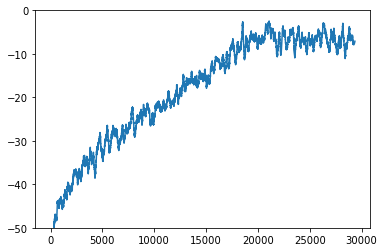

In [27]:
# reward received during training
rpR = np.vstack(episode_reward)
from scipy.signal import savgol_filter
yhat = savgol_filter(rpR[:,2], 361, 2) # window size 51, polynomial order 3
#plt.plot(rpR[:,4])
plt.figure(figsize=(6,4))
plt.plot(yhat)
plt.ylim([-50,0])

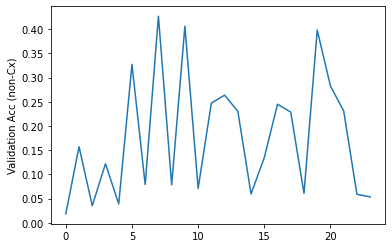

In [29]:
vvr = np.stack(validation_reward)
plt.figure(figsize=(6,4))
plt.plot(vvr[:,1])
plt.ylabel('Validation Acc (non-Cx)')
plt.show()

In [ ]:
# histogram of Q values last 10 episodes
epn = -1
mmat = allEpData
episQ = np.stack(mmat[epn][:,0])[:,]
episY = mmat[epn][:,4]*10+10
episC = mmat[epn][:,5]*10+10
episTau = mmat[epn][:,1]
# print (episY)

plt.figure(figsize=(20,10))
plt.rcParams["figure.figsize"] = (20,10)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(episY, label='GT')
ax1.plot(episTau, label='Tau', color='black')
#ax1.plot(episC+1, label='pi(s)', color='cyan')
ax1.legend(loc='best')

ax2.plot(episQ[:,0], label='A1')
ax2.plot(episQ[:,1], label='A2')
ax2.plot(episQ[:,2], label='A3')
ax2.plot(episQ[:,3], label='A4')
ax2.plot(episQ[:,4], label='A5')
ax2.plot(episQ[:,5], label='Ax')
ax2.set_ylim([-4,5])
ax2.legend(loc='best')

In [28]:
def remove_duplicates(arr): 
    final_list = [] 
    gt_tr = []
    final_list.append(arr[0])     
    for i in range(1,arr.shape[0]): 
        if arr[i] != arr[i-1]:
            final_list.append(arr[i])     
            if arr[i] != num_camera-1:
                gt_tr.append(arr[i])
    return final_list, gt_tr

In [30]:
print (epoch)

2826


In [32]:
policy_net.load_state_dict(torch.load('./models/policy_db4_semisup5601')['state_dict'])

Initial position:  [  2   2 200  85  64 136]
Initial position:  [  2   2  17  89  65 146]
Initial position:  [   3 1880  190  106   54  133]
Initial position:  [   1 1448  120   96   27   81]
Initial position:  [   2 2236  219   80   52  133]
Initial position:  [  3 630 114  82  82 156]
Initial position:  [  2  68   1  94  37 131]
Person:  0
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 2, 4, 3, 4]
GT transitions:  23
Transitions captured:  21


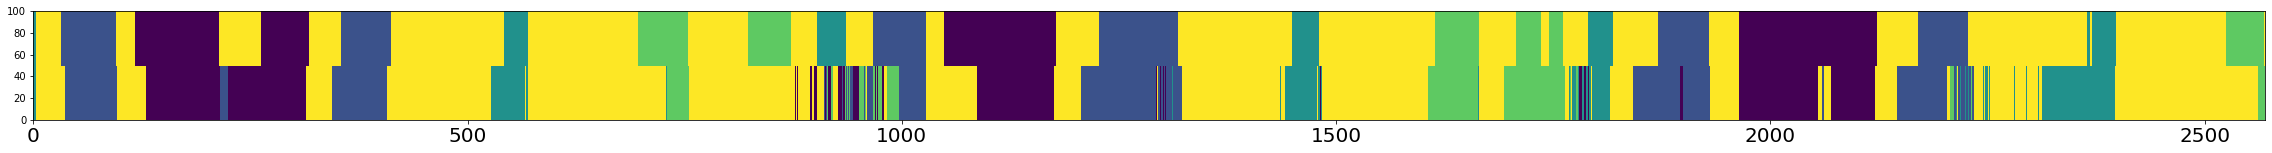

A,P,R:  0.7540856031128405 0.6990218209179835 0.756514657980456
Num frames:  (1329, 333)
Accuracy:  0.7540856031128405
Person:  1
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4]
GT transitions:  26
Transitions captured:  14


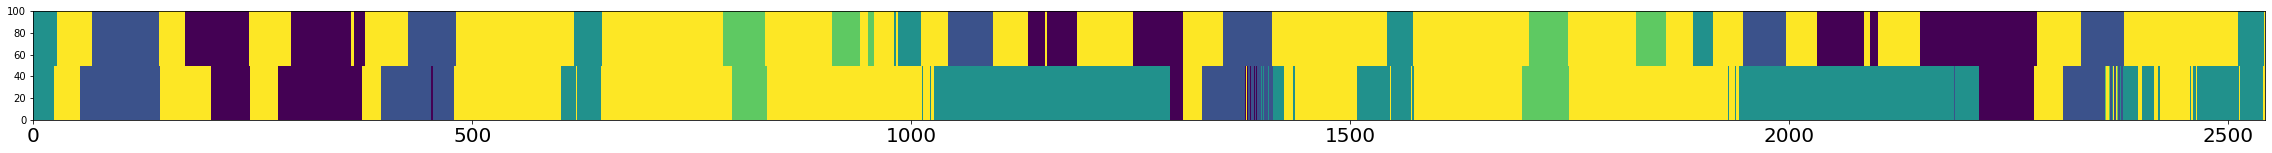

A,P,R:  0.5961462839166339 0.41591067690160505 0.5269672855879752
Num frames:  (1433, 492)
Accuracy:  0.5961462839166339
Person:  2
Transitions:  [3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 1, 4, 1, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4]
GT transitions:  19
Transitions captured:  16


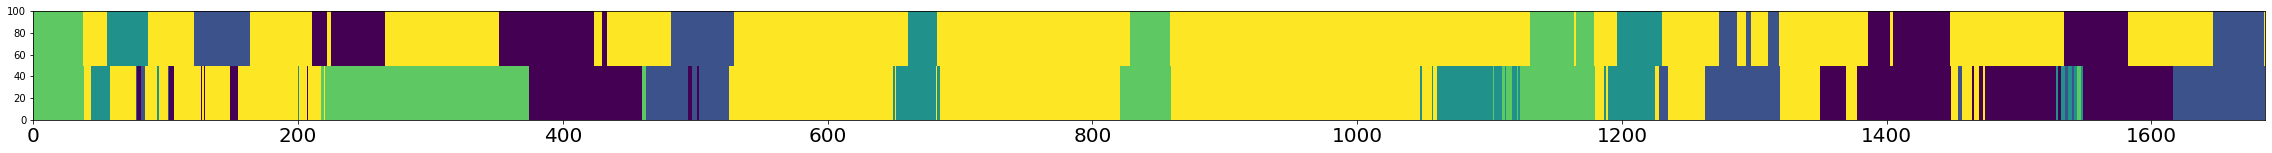

A,P,R:  0.6192170818505338 0.4213197969543147 0.7021996615905245
Num frames:  (985, 466)
Accuracy:  0.6192170818505338
Person:  3
Transitions:  [1, 4, 2, 4]
GT transitions:  1
Transitions captured:  1


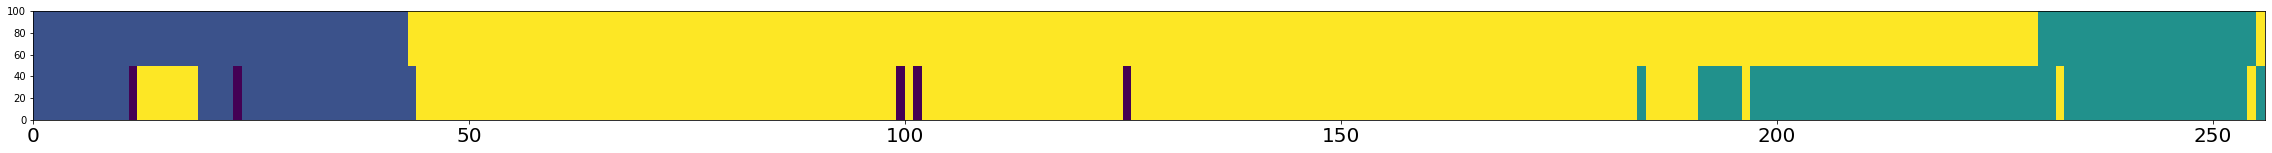

A,P,R:  0.78515625 0.5533980582524272 0.8382352941176471
Num frames:  (103, 44)
Accuracy:  0.78515625
Person:  4
Transitions:  [2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4]
GT transitions:  9
Transitions captured:  6


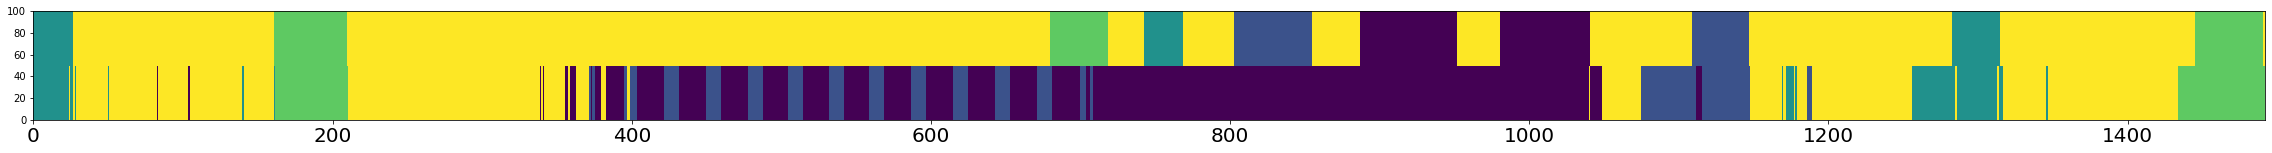

A,P,R:  0.5596514745308311 0.32049947970863685 0.7096774193548387
Num frames:  (961, 531)
Accuracy:  0.5596514745308311
Person:  5
Transitions:  [3, 4, 2, 4]
GT transitions:  1
Transitions captured:  1


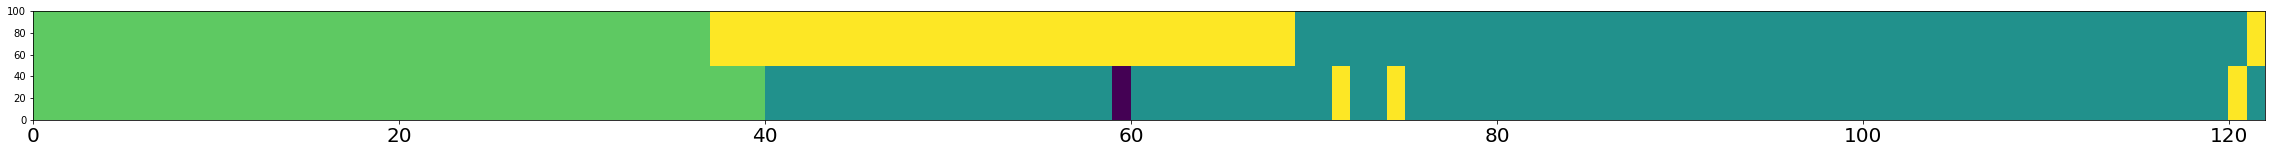

A,P,R:  0.7049180327868853 0.7226890756302521 0.9662921348314607
Num frames:  (119, 33)
Accuracy:  0.7049180327868853
Person:  6
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4]
GT transitions:  27
Transitions captured:  23


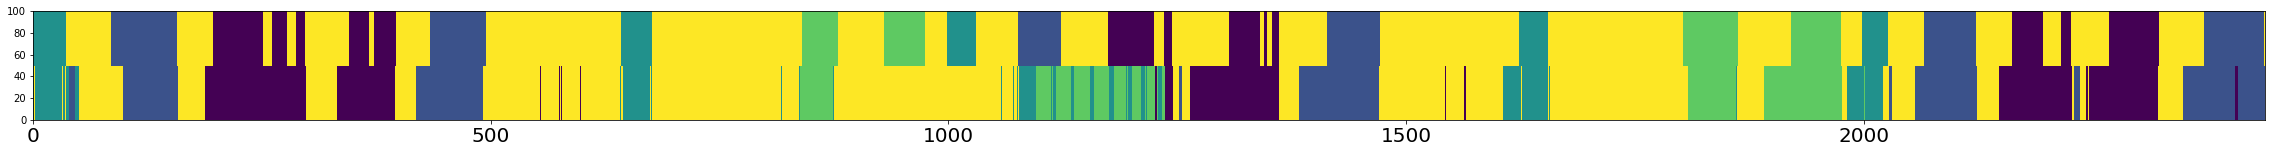

A,P,R:  0.7392373923739237 0.6161314413741599 0.7842205323193916
Num frames:  (1339, 409)
Accuracy:  0.7392373923739237
0.6797731597959498
Average (only transitions) A,P,R 0.6797731597959498 0.5355671928199114 0.7548724265403278
Average (all targets) A,P,R,F, ttr 0.6797731597959498 0.5355671928199114 0.7548724265403278 436.14285714285717 [47, 53, 39, 3, 19, 3, 55]
8577


In [30]:
policy_net.eval()
req_inc = 0
render = False
_,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
tr_acc = 0
avg_tr_captured = []
A,P,R,F, ttr = [],[],[],[],[]
A_onlytr,P_onlytr,R_onlytr = [],[],[]
nfr = []
for i in range(len(acc)):
    print ('Person: ',i)
    gt = np.array([d[0] for d in acc[i]])
    pr = np.array([d[1] for d in acc[i]])
    g = gt #t[gt != num_camera-1]
    p = pr #r[gt != num_camera-1]
    
    dups,gt_tr = remove_duplicates(g)
    print ('Transitions: ', dups)
    print ('GT transitions: ', len(gt_tr))
    print ('Transitions captured: ', numTR[i])
    if len(gt_tr) != 0:
        avg_tr_captured.append((numTR[i],len(gt_tr)))
        contains_tr = 1
    else:
        print ('')
        contains_tr = 0
        #continue
    
    # plot transitions
    afc.plot_color_transitions(p,g)
    # MCTA and number of frames
    if req_inc == 1:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
    else:
        ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        
    if contains_tr == 1:
        A_onlytr.append(ac)
        P_onlytr.append(pr)
        R_onlytr.append(re)
    A.append(ac)
    P.append(pr)
    R.append(re)
    F.append(fr)
    ttr.append(tr)
    print ('A,P,R: ', ac,pr,re)
    f = afc.compute_num_frames(p,g)
    nfr.append(f)
    print ('Num frames: ', f)
    # Accuracy
    tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
    tr_acc += tacc
    print ('Accuracy: ',tacc)
print (tr_acc/len(A))
print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
print (np.sum(nfr))

In [31]:
a = np.stack(avg_tr_captured)
print (np.mean(a[:,0]/a[:,1]))
print (sum(a[:,0])/sum(a[:,1]))

0.8303041140569745
0.7735849056603774


In [29]:
from IPython.display import clear_output
def eval_policy():
    policy_net.eval()
    req_inc = 0
    render = False
    _,acc,_,numTR = test_func(pTest,iloc='fix',eloc='last', fixLoc=2, isdebug=0, req_inc=req_inc)
    tr_acc = 0
    avg_tr_captured = []
    A,P,R,F, ttr = [],[],[],[],[]
    Fscore, Fscore_onlytr = [],[]
    A_onlytr,P_onlytr,R_onlytr = [],[],[]
    nfr = []
    for i in range(len(acc)):
        print ('Person: ',i)
        gt = np.array([d[0] for d in acc[i]])
        pr = np.array([d[1] for d in acc[i]])
        g = gt #t[gt != num_camera-1]
        p = pr #r[gt != num_camera-1]

        dups,gt_tr = remove_duplicates(g)
        print ('Transitions: ', dups)
        print ('GT transitions: ', len(gt_tr))
        print ('Transitions captured: ', numTR[i])
        if len(gt_tr) != 0:
            avg_tr_captured.append((numTR[i],len(gt_tr)))
            contains_tr = 1
        else:
            print ('')
            contains_tr = 0
            #continue

        # plot transitions
    #     afc.plot_color_transitions(p,g)
        # MCTA and number of frames
        if req_inc == 1:
            ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)
        else:
            ac,pr,re,fr,tr = afc.compute_APRF_one_person_sct_ict(p,g)

        fs = 2*(pr*re)/(pr+re)
        if contains_tr == 1:
            A_onlytr.append(ac)
            P_onlytr.append(pr)
            R_onlytr.append(re)
            Fscore_onlytr.append(fs)
        A.append(ac)
        P.append(pr)
        R.append(re)
        F.append(fr)
        Fscore.append(fs) 
        ttr.append(tr)
        print ('A,P,R: ', ac,pr,re)
        f = afc.compute_num_frames(p,g)
        nfr.append(f)
        print ('Num frames: ', f)
        # Accuracy
        tacc = np.sum(g==p, dtype=np.float)/g.shape[0]
        tr_acc += tacc
        print ('Accuracy: ',tacc)
    print (tr_acc/len(A))
    print ('Average (only transitions) A,P,R', np.mean(A_onlytr),np.mean(P_onlytr),np.mean(R_onlytr))
    print ('Average (all targets) A,P,R,F, ttr', np.mean(A),np.mean(P),np.mean(R),np.mean(F), ttr)
    print ('Fscore (all targets, only transitions) ', np.mean(Fscore),np.mean(Fscore_onlytr))
    print (np.sum(nfr))
    
    a = np.stack(avg_tr_captured)
    PCH_1 = np.mean(a[:,0]/a[:,1])
    PCH_2 = sum(a[:,0])/sum(a[:,1])
    print (PCH_1)
    print (PCH_2)
    
    return np.mean(A),np.mean(P),np.mean(R),np.mean(Fscore),PCH_1,PCH_2

In [31]:

all_metric_values = []
for epoch_i in range(801,epoch,20):
    modelname = './models/policy_db3_semisup_gtBOX_5_' + str(epoch_i)
    print (modelname)
    # load model
    policy_net.load_state_dict(torch.load(modelname)['state_dict'])
    
    A,P,R,F1,PCH1,PCH2 = eval_policy()
    all_metric_values.append((epoch_i,A,P,R,F1,PCH1,PCH2))
    
    clear_output(wait=True)

./models/policy_db3_semisup_gtBOX_5_4581
Initial position:  [  2   2 200  85  64 136]
Initial position:  [  2   2  17  89  65 146]
Initial position:  [   3 1880  190  106   54  133]
Initial position:  [   1 1448  120   96   27   81]
Initial position:  [   2 2236  219   80   52  133]
Initial position:  [  3 630 114  82  82 156]
Initial position:  [  2  68   1  94  37 131]
Person:  0
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 1, 4, 2, 4, 2, 4, 3, 4]
GT transitions:  23
Transitions captured:  21
A,P,R:  0.6680933852140077 0.615234375 0.7695439739413681
Num frames:  (1536, 570)
Accuracy:  0.6680933852140077
Person:  1
Transitions:  [2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 3, 4, 2, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4, 3, 4, 3, 4, 2, 4, 1, 4, 0, 4, 0, 4, 0, 4, 1, 4, 2, 4]
GT transitions:  26
Transitions captured:  18
A,P,R:  0.6751867872591427 0.5743944636678201 0.733863837312113

In [34]:
len(all_metric_values)

101

In [32]:
np.save('./all_metric_values_db3_5steps', all_metric_values)

In [33]:
all_metric_values_cat = {}
all_metric_values_cat['all_metric_values'] = np.stack(all_metric_values)
spio.savemat('../../8tb/abstraction/unsup/all_metric_values_db3_5steps.mat', all_metric_values_cat)

### Test function

In [ ]:
backup_fname = '/media/win/HRLhkl/Q_CamSel_3L_l4_st200_db3_1tCont_2'
hkl.dump([[episode_reward, running_reward]], backup_fname+'_variables.hkl')

In [1]:
1/np.log(600*12)

NameError: name 'np' is not defined

In [ ]:
pp = 1
np.max(pTest[pp][1:,1] - pTest[pp][0:-1,1])